In [0]:
import numpy as np
import glob
from PIL import Image
import tensorflow as tf
import os
import sys
from skimage.io import imread, imshow
import random
import pandas as pd
import gc
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import random
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images,imsave
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
from tqdm import tqdm_notebook, tnrange
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

Using TensorFlow backend.


In [0]:
# Build U-Net model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
 
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
 
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c5)
 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout) 

In [0]:
def crop_function(image,model_path):
  model.load_weights(model_path)
  truenumrows = len(image) 
  truenumcols = len(image[0])
  img1 = resize(image, (128, 128), mode='constant', preserve_range=True)
  img2 = resize(image, (truenumrows,truenumcols))
  xmini = 0
  xmax = 0
  ymini = 0 
  ymax = 0
  x=np.array(img1)
  x=np.expand_dims(x, axis=0)
  predict = model.predict(x, verbose=1)
  predict = (predict > 0.5).astype(np.uint8)
  predicted = np.squeeze(predict[0])
  predicted2 = resize(predicted,(truenumrows,truenumcols), mode='constant', preserve_range=True)
  numrows = len(predicted2) 
  numcols = len(predicted2[0])
  #x minimam
  for i in range (numrows):
    for j in range (numcols):
      if predicted2[i][j] == 1:
        xmini = i
        break
      else:
        continue
    if xmini:
      break
    else:
      continue
  #xmaximum
  for i in range (numrows-1,-1,-1):
    for j in range (numcols):
      if predicted2[i][j] == 1:
        xmax = i
        break
      else:
        continue
    if xmax:
      break
    else:
      continue
  #ymini
  for j in range (numcols):
    for i in range (numrows):
      if predicted2[i][j] == 1:
        ymini = j
        break
      else:
        continue
    if ymini:
      break
    else:
      continue
  #ymax
  for j in range (numcols-1,-1,-1):
    for i in range (numrows):
      if predicted2[i][j] == 1:
        ymax = j
        break
      else:
        continue
    if ymax:
      break
    else:
      continue
  print (xmini)
  print (xmax)
  print (ymini)
  print (ymax)
  if xmini == 0 and xmax == 0 and ymini == 0 and ymax == 0:
    imshow(img2)
    plt.show()
    imshow(predicted2)
    plt.show()
    return img2
  else:
    return img2[xmini:xmax,ymini:ymax]

In [0]:
akiec_num=0
for filename in glob.glob("/content/drive/My Drive/Color_Constancy_skin_cancer/akiec/*.jpg"):
  akiec_num=akiec_num+1
print(akiec_num)  

327


In [0]:
bcc_num=0
for filename in glob.glob("/content/drive/My Drive/Color_Constancy_skin_cancer/bcc/*.jpg"):
  bcc_num=bcc_num+1
print(bcc_num)  

514


In [0]:
mel_num=0
for filename in glob.glob("/content/drive/My Drive/Color_Constancy_skin_cancer/mel/*.jpg"):
  mel_num=mel_num+1
print(mel_num)  

1113


In [0]:
bkl_num=0
for filename in glob.glob("/content/drive/My Drive/Color_Constancy_skin_cancer/bkl/*.jpg"):
  bkl_num=bkl_num+1
print(bkl_num)  

1099


In [0]:
nv_num=0
for filename in glob.glob("/content/drive/My Drive/Color_Constancy_skin_cancer/nv/*.jpg"):
  nv_num=nv_num+1
print(nv_num)  

6705


In [0]:
#get bcc train
gc.disable()
train = []
for filename in glob.glob("/content/drive/My Drive/color_cons_skin_cancer_crop/bcc/train/*.jpg"):
    path = filename.split("/")
    name = path[7]  
    parts=name.split(".")
    ids=parts[0]  
    train.append(ids)
print (len(train))
gc.enable()     

411


In [0]:
#get bcc train
gc.disable()
validate = []
for filename in glob.glob("/content/drive/My Drive/color_cons_skin_cancer_crop/bcc/validation/*.jpg"):
    path = filename.split("/")
    name = path[7]  
    parts=name.split(".")
    ids=parts[0]  
    validate.append(ids)
print (len(validate))
gc.enable()     

103


In [0]:
for i in validate:
  os.remove("/content/drive/My Drive/color_cons_skin_cancer_crop/bcc/train/"+i+".jpg")

In [0]:
df_num=0
for filename in glob.glob("/content/drive/My Drive/Color_Constancy_skin_cancer/df/*.jpg"):
  df_num=df_num+1
print(df_num)  

115


In [0]:
vasc_num=0
for filename in glob.glob("/content/drive/My Drive/Color_Constancy_skin_cancer/vasc/*.jpg"):
  vasc_num=vasc_num+1
print(vasc_num)  

142


In [0]:
gc.disable()
counter=0
x=0
y=0
m ="/content/drive/My Drive/Colab Notebooks/u_net-architecture-weights-colorcons.h5"
for filename in glob.glob("/content/drive/My Drive/Color_Constancy_skin_cancer/akiec/*.jpg"): #assuming gif    
    path = filename.split("/")
    name = path[6]  
    parts=name.split(".")
    ids=parts[0]                          
    img=imread(filename)
    img1 = resize(img, (128, 128), mode='constant', preserve_range=True)
    img3 = crop_function(img,m)
    if counter < int(akiec_num*0.8):#train
      imsave("/content/drive/My Drive/color_cons_skin_cancer_crop/akiec/train/"+ids+".jpg",img3)
      x=x+1
    else:#validation
      imsave("/content/drive/My Drive/color_cons_skin_cancer_crop/akiec/validation/"+ids+".jpg",img3)
      y=y+1
    counter=counter+1
gc.enable() 
print(counter)  
print(x)
print(y)

1/1 [==============================] - 0s 5ms/sample


600
450
9
440
110
484
1/1 [==============================] - 0s 4ms/sample
600
450


142
310
232
381
1/1 [==============================] - 0s 6ms/sample
600
450


142
366
152
479
1/1 [==============================] - 0s 4ms/sample


600
450
65
433
59
597
1/1 [==============================] - 0s 5ms/sample


600
450
23
447
7
494
1/1 [==============================] - 0s 4ms/sample
600
450


128
303
166
376
1/1 [==============================] - 0s 4ms/sample
600
450


149
268
190
353
1/1 [==============================] - 0s 8ms/sample


600
450
9
412
40
531
1/1 [==============================] - 0s 4ms/sample


600
450
83
444
157
470
1/1 [==============================] - 0s 4ms/sample
600
450


128
387
152
423
1/1 [==============================] - 0s 4ms/sample


600
450
97
440
30
597
1/1 [==============================] - 0s 4ms/sample


600
450
2
307
190
597
1/1 [==============================] - 0s 5ms/sample


600
450
76
391
73
461
1/1 [==============================] - 0s 5ms/sample


600
450
40
405
63
517
1/1 [==============================] - 0s 5ms/sample


600
450
104
377
2
536
1/1 [==============================] - 0s 5ms/sample


600
450
2
447
30
597
1/1 [==============================] - 0s 5ms/sample


600
450
9
444
77
484
1/1 [==============================] - 0s 5ms/sample


600
450
5
444
68
569
1/1 [==============================] - 0s 5ms/sample


600
450
2
321
105
526
1/1 [==============================] - 0s 5ms/sample


600
450
2
384
2
559
1/1 [==============================] - 0s 5ms/sample
600
450


97
345
124
442
1/1 [==============================] - 0s 4ms/sample


600
450
72
402
91
494
1/1 [==============================] - 0s 4ms/sample


600
450
37
433
59
597
1/1 [==============================] - 0s 5ms/sample
600
450


132
324
120
423
1/1 [==============================] - 0s 5ms/sample


600
450
58
416
68
498
1/1 [==============================] - 0s 5ms/sample


600
450
44
405
91
508
1/1 [==============================] - 0s 5ms/sample


600
450
2
426
2
597
1/1 [==============================] - 0s 4ms/sample


600
450
44
426
105
479
1/1 [==============================] - 0s 4ms/sample


600
450
65
447
101
475
1/1 [==============================] - 0s 5ms/sample
600
450


156
345
190
414
1/1 [==============================] - 0s 5ms/sample


600
450
2
447
96
573
1/1 [==============================] - 0s 11ms/sample


600
450
23
321
2
498
1/1 [==============================] - 0s 5ms/sample


600
450
79
447
45
498
1/1 [==============================] - 0s 5ms/sample


600
450
86
430
138
433
1/1 [==============================] - 0s 5ms/sample


600
450
58
366
105
484
1/1 [==============================] - 0s 5ms/sample


600
450
86
384
120
470
1/1 [==============================] - 0s 5ms/sample


600
450
23
419
73
522
1/1 [==============================] - 0s 4ms/sample


600
450
26
423
91
437
1/1 [==============================] - 0s 4ms/sample


600
450
54
377
40
559
1/1 [==============================] - 0s 4ms/sample


600
450
19
447
2
536
1/1 [==============================] - 0s 11ms/sample


600
450
111
370
73
461
1/1 [==============================] - 0s 4ms/sample


600
450
26
395
16
517
1/1 [==============================] - 0s 4ms/sample


600
450
26
447
7
597
1/1 [==============================] - 0s 4ms/sample


600
450
90
416
152
433
1/1 [==============================] - 0s 5ms/sample
600
450


135
328
152
437
1/1 [==============================] - 0s 4ms/sample


600
450
65
405
82
479
1/1 [==============================] - 0s 7ms/sample


600
450
2
447
26
470
1/1 [==============================] - 0s 5ms/sample


600
450
2
447
35
583
1/1 [==============================] - 0s 4ms/sample


600
450
76
416
2
456
1/1 [==============================] - 0s 5ms/sample


600
450
30
447
2
536
1/1 [==============================] - 0s 5ms/sample


600
450
2
447
73
550
1/1 [==============================] - 0s 5ms/sample


600
450
107
366
2
386
1/1 [==============================] - 0s 5ms/sample
600
450


97
363
129
451
1/1 [==============================] - 0s 4ms/sample


600
450
26
423
110
597
1/1 [==============================] - 0s 4ms/sample


600
450
2
387
101
597
1/1 [==============================] - 0s 4ms/sample
600
450
149


380
176
423
1/1 [==============================] - 0s 4ms/sample


600
450
2
363
2
597
1/1 [==============================] - 0s 6ms/sample


600
450
2
447
105
494
1/1 [==============================] - 0s 5ms/sample


600
450
47
395
91
470
1/1 [==============================] - 0s 5ms/sample


600
450
2
423
96
540
1/1 [==============================] - 0s 6ms/sample


600
450
2
447
2
494
1/1 [==============================] - 0s 5ms/sample


600
450
37
384
124
587
1/1 [==============================] - 0s 5ms/sample


600
450
30
391
2
597
1/1 [==============================] - 0s 5ms/sample


600
450
72
447
2
597
1/1 [==============================] - 0s 4ms/sample


600
450
97
387
68
451
1/1 [==============================] - 0s 5ms/sample


600
450
79
377
105
461
1/1 [==============================] - 0s 5ms/sample


600
450
146
387
21
489
1/1 [==============================] - 0s 4ms/sample


600
450
79
377
101
461
1/1 [==============================] - 0s 4ms/sample


600
450
86
398
63
451
1/1 [==============================] - 0s 4ms/sample


600
450
40
387
30
587
1/1 [==============================] - 0s 5ms/sample


600
450
23
447
40
554
1/1 [==============================] - 0s 5ms/sample


600
450
2
447
40
597
1/1 [==============================] - 0s 5ms/sample


600
450
125
419
105
461
1/1 [==============================] - 0s 5ms/sample
600
450


132
349
138
442
1/1 [==============================] - 0s 5ms/sample


600
450
121
373
2
344
1/1 [==============================] - 0s 9ms/sample


600
450
37
430
101
479
1/1 [==============================] - 0s 5ms/sample


600
450
2
433
101
540
1/1 [==============================] - 0s 5ms/sample


600
450
2
430
87
526
1/1 [==============================] - 0s 5ms/sample


600
450
65
444
82
597
1/1 [==============================] - 0s 5ms/sample


600
450
37
412
2
597
1/1 [==============================] - 0s 6ms/sample


600
450
2
444
21
597
1/1 [==============================] - 0s 7ms/sample


600
450
30
447
2
564
1/1 [==============================] - 0s 5ms/sample


600
450
65
433
148
461
1/1 [==============================] - 0s 5ms/sample


600
450
90
366
157
484
1/1 [==============================] - 0s 5ms/sample


600
450
72
370
120
479
1/1 [==============================] - 0s 8ms/sample


600
450
47
447
87
465
1/1 [==============================] - 0s 5ms/sample


600
450
23
447
26
498
1/1 [==============================] - 0s 5ms/sample


600
450
16
447
77
508
1/1 [==============================] - 0s 5ms/sample


600
450
37
419
105
465
1/1 [==============================] - 0s 5ms/sample


600
450
51
440
82
461
1/1 [==============================] - 0s 4ms/sample


600
450
97
440
45
479
1/1 [==============================] - 0s 4ms/sample


600
450
2
447
77
597
1/1 [==============================] - 0s 5ms/sample


600
450
30
447
30
550
1/1 [==============================] - 0s 4ms/sample


600
450
107
384
129
470
1/1 [==============================] - 0s 5ms/sample


600
450
83
391
157
409
1/1 [==============================] - 0s 4ms/sample


600
450
47
387
63
564
1/1 [==============================] - 0s 4ms/sample


600
450
33
433
77
531
1/1 [==============================] - 0s 4ms/sample


600
450
2
437
26
545
1/1 [==============================] - 0s 4ms/sample
600
450


97
391
157
414
1/1 [==============================] - 0s 7ms/sample


600
450
2
402
63
597
1/1 [==============================] - 0s 5ms/sample


600
450
26
416
2
573
1/1 [==============================] - 0s 5ms/sample


600
450
30
426
91
522
1/1 [==============================] - 0s 5ms/sample


600
450
2
363
2
583
1/1 [==============================] - 0s 5ms/sample


600
450
2
447
49
564
1/1 [==============================] - 0s 4ms/sample
600
450
90


402
166
395
1/1 [==============================] - 0s 4ms/sample


600
450
2
444
2
508
1/1 [==============================] - 0s 4ms/sample


600
450
2
423
40
597
1/1 [==============================] - 0s 4ms/sample


600
450
26
423
45
554
1/1 [==============================] - 0s 4ms/sample


600
450
2
447
2
583
1/1 [==============================] - 0s 4ms/sample


600
450
65
437
2
597
1/1 [==============================] - 0s 4ms/sample
600
450
23
370
45
583


1/1 [==============================] - 0s 4ms/sample


600
450
93
380
73
583
1/1 [==============================] - 0s 4ms/sample
600
450
111
391
152
470


1/1 [==============================] - 0s 4ms/sample


600
450
2
447
91
494
1/1 [==============================] - 0s 5ms/sample


600
450
33
395
16
479
1/1 [==============================] - 0s 5ms/sample


600
450
30
423
35
569
1/1 [==============================] - 0s 5ms/sample


600
450
30
447
49
517
1/1 [==============================] - 0s 5ms/sample


600
450
47
447
87
597
1/1 [==============================] - 0s 9ms/sample


600
450
62
405
87
475
1/1 [==============================] - 0s 5ms/sample


600
450
93
398
162
554
1/1 [==============================] - 0s 5ms/sample


600
450
76
430
101
503
1/1 [==============================] - 0s 5ms/sample


600
450
44
426
59
508
1/1 [==============================] - 0s 5ms/sample


600
450
83
444
2
597
1/1 [==============================] - 0s 5ms/sample


600
450
54
402
21
569
1/1 [==============================] - 0s 5ms/sample


600
450
30
373
73
526
1/1 [==============================] - 0s 5ms/sample
600
450
100
405
148
437


1/1 [==============================] - 0s 5ms/sample
600
450


139
380
176
414
1/1 [==============================] - 0s 5ms/sample


600
450
132
409
129
428
1/1 [==============================] - 0s 5ms/sample


600
450
47
391
77
508
1/1 [==============================] - 0s 4ms/sample


600
450
23
391
120
447
1/1 [==============================] - 0s 5ms/sample


600
450
65
423
120
583
1/1 [==============================] - 0s 5ms/sample


600
450
2
444
54
597
1/1 [==============================] - 0s 5ms/sample


600
450
23
447
21
597
1/1 [==============================] - 0s 5ms/sample


600
450
111
373
105
442
1/1 [==============================] - 0s 5ms/sample


600
450
69
437
21
531
1/1 [==============================] - 0s 4ms/sample


600
450
90
409
124
508
1/1 [==============================] - 0s 4ms/sample
600
450


156
331
185
367
1/1 [==============================] - 0s 6ms/sample


600
450
83
419
143
540
1/1 [==============================] - 0s 4ms/sample


600
450
76
363
171
592
1/1 [==============================] - 0s 5ms/sample


600
450
26
447
120
578
1/1 [==============================] - 0s 5ms/sample
600
450


118
289
227
400
1/1 [==============================] - 0s 5ms/sample
600
450


167
303
227
362
1/1 [==============================] - 0s 5ms/sample


600
450
79
409
110
498
1/1 [==============================] - 0s 5ms/sample


600
450
72
363
49
554
1/1 [==============================] - 0s 5ms/sample
600
450


93
342
138
409
1/1 [==============================] - 0s 5ms/sample


600
450
93
447
59
526
1/1 [==============================] - 0s 5ms/sample


600
450
30
426
2
503
1/1 [==============================] - 0s 5ms/sample
600
450


132
324
195
423
1/1 [==============================] - 0s 5ms/sample


600
450
76
447
26
531
1/1 [==============================] - 0s 14ms/sample
600
450


83
335
190
461
1/1 [==============================] - 0s 5ms/sample


600
450
40
384
105
498
1/1 [==============================] - 0s 5ms/sample


600
450
2
447
45
526
1/1 [==============================] - 0s 5ms/sample
600
450
86
356
134
428


1/1 [==============================] - 0s 5ms/sample
600
450
72
331
190
489


1/1 [==============================] - 0s 5ms/sample
600
450
100


349
157
475
1/1 [==============================] - 0s 5ms/sample


600
450
37
430
82
597
1/1 [==============================] - 0s 4ms/sample


600
450
2
447
129
545
1/1 [==============================] - 0s 4ms/sample


600
450
90
405
120
461
1/1 [==============================] - 0s 4ms/sample


600
450
2
373
68
390
1/1 [==============================] - 0s 5ms/sample


600
450
58
373
148
451
1/1 [==============================] - 0s 4ms/sample
600
450
118


447
195
395
1/1 [==============================] - 0s 4ms/sample


600
450
72
380
7
386
1/1 [==============================] - 0s 4ms/sample


600
450
12
405
115
569
1/1 [==============================] - 0s 5ms/sample


600
450
65
447
45
597
1/1 [==============================] - 0s 4ms/sample


600
450
47
430
30
597
1/1 [==============================] - 0s 4ms/sample
600
450


111
324
96
362
1/1 [==============================] - 0s 4ms/sample
600
450
100
328
96
367


1/1 [==============================] - 0s 4ms/sample


600
450
65
405
82
536
1/1 [==============================] - 0s 4ms/sample


600
450
86
447
30
592
1/1 [==============================] - 0s 5ms/sample


600
450
54
398
21
554
1/1 [==============================] - 0s 5ms/sample


600
450
44
384
91
475
1/1 [==============================] - 0s 5ms/sample


600
450
23
447
2
573
1/1 [==============================] - 0s 4ms/sample


600
450
37
419
73
597
1/1 [==============================] - 0s 5ms/sample


600
450
47
430
2
587
1/1 [==============================] - 0s 5ms/sample


600
450
76
447
124
587
1/1 [==============================] - 0s 5ms/sample


600
450
2
447
152
545
1/1 [==============================] - 0s 5ms/sample


600
450
2
444
2
554
1/1 [==============================] - 0s 5ms/sample


600
450
2
433
21
479
1/1 [==============================] - 0s 5ms/sample


600
450
2
366
54
536
1/1 [==============================] - 0s 5ms/sample


600
450
33
398
157
419
1/1 [==============================] - 0s 5ms/sample


600
450
23
419
87
414
1/1 [==============================] - 0s 5ms/sample


600
450
2
444
2
597
1/1 [==============================] - 0s 5ms/sample


600
450
2
447
2
597
1/1 [==============================] - 0s 5ms/sample


600
450
90
356
129
470
1/1 [==============================] - 0s 5ms/sample
600
450
93
359
101
456


1/1 [==============================] - 0s 5ms/sample
600
450
69


331
105
461
1/1 [==============================] - 0s 5ms/sample


600
450
2
447
96
517
1/1 [==============================] - 0s 5ms/sample


600
450
2
447
45
526
1/1 [==============================] - 0s 5ms/sample
600
450


79
324
138
447
1/1 [==============================] - 0s 4ms/sample
600
450


181
398
270
404
1/1 [==============================] - 0s 5ms/sample


600
450
121
433
105
461
1/1 [==============================] - 0s 5ms/sample


600
450
47
402
82
489
1/1 [==============================] - 0s 4ms/sample


600
450
146
430
2
597
1/1 [==============================] - 0s 4ms/sample


600
450
9
430
21
508
1/1 [==============================] - 0s 4ms/sample


600
450
19
398
171
475
1/1 [==============================] - 0s 5ms/sample


600
450
33
391
176
423
1/1 [==============================] - 0s 5ms/sample
600
450


83
338
171
437
1/1 [==============================] - 0s 5ms/sample


600
450
26
447
40
569
1/1 [==============================] - 0s 5ms/sample


600
450
33
314
63
423
1/1 [==============================] - 0s 5ms/sample
600
450


118
345
157
423
1/1 [==============================] - 0s 5ms/sample
600
450


121
317
195
400
1/1 [==============================] - 0s 5ms/sample


600
450
26
423
124
554
1/1 [==============================] - 0s 4ms/sample


600
450
79
433
110
545
1/1 [==============================] - 0s 4ms/sample


600
450
30
398
26
554
1/1 [==============================] - 0s 4ms/sample


600
450
62
447
96
597
1/1 [==============================] - 0s 4ms/sample


600
450
12
447
30
597
1/1 [==============================] - 0s 5ms/sample


600
450
2
447
21
597
1/1 [==============================] - 0s 5ms/sample


600
450
62
352
35
536
1/1 [==============================] - 0s 5ms/sample


600
450
51
345
40
545
1/1 [==============================] - 0s 5ms/sample


600
450
9
447
91
592
1/1 [==============================] - 0s 5ms/sample


600
450
65
447
82
479
1/1 [==============================] - 0s 5ms/sample


600
450
23
440
40
550
1/1 [==============================] - 0s 5ms/sample


600
450
19
402
82
498
1/1 [==============================] - 0s 5ms/sample


600
450
19
416
82
503
1/1 [==============================] - 0s 5ms/sample


600
450
16
416
77
508
1/1 [==============================] - 0s 5ms/sample


600
450
9
433
59
494
1/1 [==============================] - 0s 5ms/sample


600
450
16
433
2
503
1/1 [==============================] - 0s 5ms/sample


600
450
90
387
68
479
1/1 [==============================] - 0s 4ms/sample


600
450
2
430
73
522
1/1 [==============================] - 0s 5ms/sample


600
450
19
324
138
550
1/1 [==============================] - 0s 5ms/sample


600
450
37
447
35
573
1/1 [==============================] - 0s 5ms/sample


600
450
83
419
45
517
1/1 [==============================] - 0s 5ms/sample


600
450
44
430
77
569
1/1 [==============================] - 0s 5ms/sample


600
450
83
444
105
573
1/1 [==============================] - 0s 5ms/sample


600
450
54
366
138
475
1/1 [==============================] - 0s 5ms/sample


600
450
2
426
82
517
1/1 [==============================] - 0s 5ms/sample


600
450
23
447
2
564
1/1 [==============================] - 0s 5ms/sample


600
450
135
430
195
597
1/1 [==============================] - 0s 5ms/sample


600
450
2
447
16
587
1/1 [==============================] - 0s 5ms/sample


600
450
2
433
40
597
1/1 [==============================] - 0s 5ms/sample


600
450
79
447
73
512
1/1 [==============================] - 0s 6ms/sample


600
450
65
387
105
484
1/1 [==============================] - 0s 5ms/sample


600
450
2
416
129
433
1/1 [==============================] - 0s 5ms/sample


600
450
44
419
105
442
1/1 [==============================] - 0s 5ms/sample


600
450
2
447
73
531
1/1 [==============================] - 0s 4ms/sample


600
450
12
426
82
554
1/1 [==============================] - 0s 4ms/sample
600
450


146
335
63
334
1/1 [==============================] - 0s 5ms/sample


600
450
107
342
21
479
1/1 [==============================] - 0s 5ms/sample


600
450
2
447
2
597
1/1 [==============================] - 0s 4ms/sample


600
450
97
423
91
545
1/1 [==============================] - 0s 4ms/sample
600
450


163
310
213
554
1/1 [==============================] - 0s 4ms/sample


600
450
23
447
68
517
1/1 [==============================] - 0s 5ms/sample


600
450
90
359
77
597
1/1 [==============================] - 0s 5ms/sample
600
450


163
395
176
372
1/1 [==============================] - 0s 5ms/sample
600
450
90
370
134
433


1/1 [==============================] - 0s 5ms/sample
600
450


135
317
213
362
1/1 [==============================] - 0s 5ms/sample


600
450
26
433
40
461
1/1 [==============================] - 0s 5ms/sample


600
450
2
447
2
597
1/1 [==============================] - 0s 4ms/sample


600
450
51
373
87
498
1/1 [==============================] - 0s 4ms/sample


600
450
58
405
16
597
1/1 [==============================] - 0s 4ms/sample


600
450
65
440
91
437
1/1 [==============================] - 0s 4ms/sample


600
450
26
447
115
489
1/1 [==============================] - 0s 9ms/sample


600
450
37
384
101
498
1/1 [==============================] - 0s 5ms/sample


600
450
33
447
45
498
1/1 [==============================] - 0s 5ms/sample


600
450
104
412
120
423
1/1 [==============================] - 0s 5ms/sample


600
450
2
416
45
578
1/1 [==============================] - 0s 4ms/sample


600
450
62
328
124
494
1/1 [==============================] - 0s 5ms/sample


600
450
23
402
49
503
1/1 [==============================] - 0s 5ms/sample


600
450
2
447
2
559
1/1 [==============================] - 0s 4ms/sample


600
450
2
447
40
414
1/1 [==============================] - 0s 4ms/sample


600
450
83
352
73
395
1/1 [==============================] - 0s 5ms/sample


600
450
2
447
96
573
1/1 [==============================] - 0s 4ms/sample


600
450
23
447
87
461
1/1 [==============================] - 0s 4ms/sample


600
450
2
444
16
554
1/1 [==============================] - 0s 4ms/sample


600
450
9
447
2
564
1/1 [==============================] - 0s 4ms/sample
600
450


65
328
162
451
1/1 [==============================] - 0s 5ms/sample
600
450


163
363
171
358
1/1 [==============================] - 0s 5ms/sample
600
450


121
335
176
433
1/1 [==============================] - 0s 4ms/sample


600
450
2
447
54
503
1/1 [==============================] - 0s 5ms/sample


600
450
93
430
105
479
1/1 [==============================] - 0s 5ms/sample


600
450
2
387
2
597
1/1 [==============================] - 0s 5ms/sample


600
450
79
447
26
554
1/1 [==============================] - 0s 5ms/sample


600
450
114
447
12
447
1/1 [==============================] - 0s 4ms/sample


600
450
9
324
180
498
1/1 [==============================] - 0s 5ms/sample


600
450
9
402
87
456
1/1 [==============================] - 0s 5ms/sample


600
450
2
444
30
597
1/1 [==============================] - 0s 4ms/sample


600
450
2
387
2
526
1/1 [==============================] - 0s 4ms/sample
600
450
65
391
21
554


1/1 [==============================] - 0s 4ms/sample
600
450


107
317
176
442
1/1 [==============================] - 0s 5ms/sample


600
450
76
391
105
479
1/1 [==============================] - 0s 5ms/sample


600
450
76
416
35
573
1/1 [==============================] - 0s 5ms/sample
600
450


100
328
171
428
1/1 [==============================] - 0s 5ms/sample
600
450


100
331
204
433
1/1 [==============================] - 0s 4ms/sample


600
450
2
366
2
451
1/1 [==============================] - 0s 4ms/sample
600
450


121
331
162
376
1/1 [==============================] - 0s 4ms/sample
600
450


125
307
195
390
1/1 [==============================] - 0s 4ms/sample


600
450
19
423
49
554
1/1 [==============================] - 0s 4ms/sample
600
450


167
342
223
348
1/1 [==============================] - 0s 4ms/sample


600
450
114
430
2
512
1/1 [==============================] - 0s 4ms/sample


600
450
114
419
2
414
1/1 [==============================] - 0s 4ms/sample


600
450
26
447
45
470
1/1 [==============================] - 0s 4ms/sample


600
450
2
412
2
597
1/1 [==============================] - 0s 4ms/sample


600
450
97
387
152
433
1/1 [==============================] - 0s 4ms/sample


600
450
47
356
40
442
1/1 [==============================] - 0s 4ms/sample


600
450
90
352
138
479
1/1 [==============================] - 0s 4ms/sample


600
450
107
426
2
564
1/1 [==============================] - 0s 4ms/sample
600
450
93
366
157
451


1/1 [==============================] - 0s 5ms/sample


600
450
93
398
45
592
1/1 [==============================] - 0s 5ms/sample


600
450
86
377
96
583
1/1 [==============================] - 0s 5ms/sample


600
450
9
447
101
479
1/1 [==============================] - 0s 5ms/sample


600
450
2
419
2
559
1/1 [==============================] - 0s 5ms/sample


600
450
132
447
2
395
1/1 [==============================] - 0s 5ms/sample


600
450
79
433
129
498
1/1 [==============================] - 0s 5ms/sample


600
450
69
398
59
554
1/1 [==============================] - 0s 5ms/sample


600
450
62
387
157
522
1/1 [==============================] - 0s 4ms/sample
600
450


178
380
204
414
1/1 [==============================] - 0s 5ms/sample


600
450
2
447
68
484
1/1 [==============================] - 0s 5ms/sample


600
450
54
416
30
494
1/1 [==============================] - 0s 5ms/sample


600
450
2
430
2
597
1/1 [==============================] - 0s 5ms/sample


600
450
2
444
63
536
1/1 [==============================] - 0s 5ms/sample


600
450
2
437
59
536
1/1 [==============================] - 0s 5ms/sample


600
450
111
423
82
465
1/1 [==============================] - 0s 5ms/sample


600
450
40
447
2
564
1/1 [==============================] - 0s 4ms/sample
600
450
132
416
162
442


1/1 [==============================] - 0s 5ms/sample


600
450
65
342
105
451
1/1 [==============================] - 0s 5ms/sample


600
450
65
419
134
461
1/1 [==============================] - 0s 5ms/sample
600
450


188
331
180
367
1/1 [==============================] - 0s 5ms/sample


600
450
37
419
91
592
1/1 [==============================] - 0s 4ms/sample


600
450
37
324
105
573
1/1 [==============================] - 0s 4ms/sample


600
450
128
447
2
404
1/1 [==============================] - 0s 5ms/sample
600
450


128
282
232
386
1/1 [==============================] - 0s 5ms/sample
600
450
2
447
138
479


1/1 [==============================] - 0s 5ms/sample


600
450
76
373
129
442
1/1 [==============================] - 0s 5ms/sample


600
450
2
395
35
554
1/1 [==============================] - 0s 4ms/sample
600
450


100
345
120
442
1/1 [==============================] - 0s 4ms/sample


600
450
69
373
87
489
1/1 [==============================] - 0s 5ms/sample


600
450
23
352
157
479
327
261
66


1/1 [==============================] - 0s 5ms/sample
26
338
35
508
1/1 [==============================] - 0s 4ms/sample
33
352
16
597
1/1 [==============================] - 0s 5ms/sample
111
307
115
419
1/1 [==============================] - 0s 4ms/sample
146
278
185
386
1/1 [==============================] - 0s 5ms/sample
121
356
138
494
1/1 [==============================] - 0s 5ms/sample
153
286
82
400
1/1 [==============================] - 0s 5ms/sample
26
447
87
564
1/1 [==============================] - 0s 4ms/sample
69
349
115
489
1/1 [==============================] - 0s 5ms/sample


30
426
96
573
ISIC_0027526
1/1 [==============================] - 0s 5ms/sample


135
296
176
404
ISIC_0024431
1/1 [==============================] - 0s 5ms/sample


58
366
45
517
ISIC_0026656
1/1 [==============================] - 0s 5ms/sample


23
349
171
461
ISIC_0026760
1/1 [==============================] - 0s 4ms/sample


171
300
213
386
ISIC_0025718
1/1 [==============================] - 0s 4ms/sample


19
314
105
437
ISIC_0027135
1/1 [==============================] - 0s 4ms/sample


76
373
138
409
ISIC_0027976
1/1 [==============================] - 0s 6ms/sample


47
409
68
559
ISIC_0028238
1/1 [==============================] - 0s 4ms/sample


135
289
180
404
ISIC_0029755
1/1 [==============================] - 0s 4ms/sample


23
447
2
597
ISIC_0026321
1/1 [==============================] - 0s 4ms/sample
76
447
30
489
1/1 [==============================] - 0s 4ms/sample
135
380
148
400
1/1 [==============================] - 0s 4ms/sample
97
412
101
423
1/1 [==============================] - 0s 4ms/sample
19
447
2
597
1/1 [==============================] - 0s 4ms/sample
26
433
162
470
1/1 [==============================] - 0s 4ms/sample
121
293
237
386
1/1 [==============================] - 0s 4ms/sample
2
433
2
597
1/1 [==============================] - 0s 6ms/sample
69
324
148
423
1/1 [==============================] - 0s 6ms/sample
206
303
185
273
1/1 [==============================] - 0s 5ms/sample
12
384
124
461
1/1 [==============================] - 0s 5ms/sample
86
447
2
470
1/1 [==============================] - 0s 5ms/sample
118
447
2
442
1/1 [==============================] - 0s 5ms/sample
107
300
199
395
1/1 [==============================] - 0s 5ms/sample
51
395
124
470
1/1 [======================

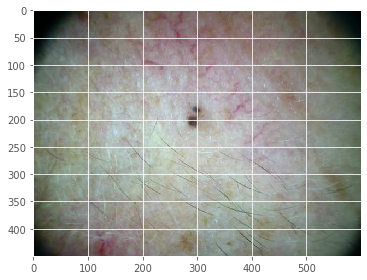

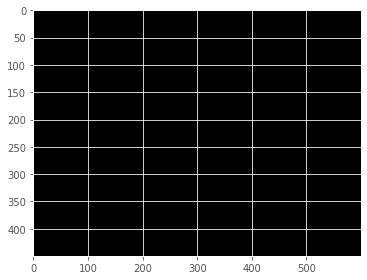

1/1 [==============================] - 0s 4ms/sample
121
303
148
386
1/1 [==============================] - 0s 4ms/sample
128
380
138
414
1/1 [==============================] - 0s 5ms/sample
79
430
91
470
1/1 [==============================] - 0s 5ms/sample
2
426
143
451
1/1 [==============================] - 0s 5ms/sample
135
300
227
353
1/1 [==============================] - 0s 5ms/sample
26
335
143
381
1/1 [==============================] - 0s 5ms/sample
2
359
12
597
1/1 [==============================] - 0s 5ms/sample
174
331
185
372
1/1 [==============================] - 0s 5ms/sample
86
402
110
479
1/1 [==============================] - 0s 4ms/sample
90
356
138
479
1/1 [==============================] - 0s 4ms/sample
2
423
2
597
1/1 [==============================] - 0s 4ms/sample
79
387
63
498
1/1 [==============================] - 0s 4ms/sample
111
335
134
433
1/1 [==============================] - 0s 5ms/sample
79
398
152
433
1/1 [==============================] - 0s 4ms/sampl

107
366
176
456
ISIC_0028652
1/1 [==============================] - 0s 5ms/sample


79
419
45
475
ISIC_0027038
1/1 [==============================] - 0s 4ms/sample


76
419
91
512
ISIC_0032030
1/1 [==============================] - 0s 5ms/sample


104
331
2
461
ISIC_0031651
1/1 [==============================] - 0s 5ms/sample


19
447
120
517
ISIC_0027525
1/1 [==============================] - 0s 4ms/sample


2
447
35
597
ISIC_0024550
1/1 [==============================] - 0s 4ms/sample


2
447
115
536
ISIC_0029919
1/1 [==============================] - 0s 5ms/sample


149
300
209
376
ISIC_0028928
1/1 [==============================] - 0s 4ms/sample


128
307
195
404
ISIC_0031378
1/1 [==============================] - 0s 5ms/sample


65
430
120
428
ISIC_0024564
1/1 [==============================] - 0s 5ms/sample
107
391
195
400


ISIC_0025322
1/1 [==============================] - 0s 5ms/sample


132
370
138
512
ISIC_0027677
1/1 [==============================] - 0s 5ms/sample


114
380
120
479
ISIC_0024833
1/1 [==============================] - 0s 5ms/sample


97
370
82
531
ISIC_0027546
1/1 [==============================] - 0s 5ms/sample


2
447
2
587
ISIC_0030868
1/1 [==============================] - 0s 5ms/sample


2
440
2
597
ISIC_0026995
1/1 [==============================] - 0s 5ms/sample


86
430
2
597
ISIC_0029123
1/1 [==============================] - 0s 5ms/sample


153
447
2
559
ISIC_0029372
1/1 [==============================] - 0s 5ms/sample


86
395
26
587
ISIC_0030782
1/1 [==============================] - 0s 5ms/sample


23
447
124
498
ISIC_0030915
1/1 [==============================] - 0s 5ms/sample


72
419
195
395
ISIC_0031318
1/1 [==============================] - 0s 5ms/sample


30
430
148
470
ISIC_0031470
1/1 [==============================] - 0s 4ms/sample


69
416
82
494
ISIC_0032092
1/1 [==============================] - 0s 5ms/sample


69
419
63
498
ISIC_0024787
1/1 [==============================] - 0s 5ms/sample


171
321
166
362
ISIC_0027281
1/1 [==============================] - 0s 5ms/sample


132
359
134
372
ISIC_0027291
1/1 [==============================] - 0s 5ms/sample


23
395
26
428
ISIC_0029602
1/1 [==============================] - 0s 5ms/sample


2
352
115
597
ISIC_0028147
1/1 [==============================] - 0s 5ms/sample


149
275
241
367
ISIC_0030954
1/1 [==============================] - 0s 5ms/sample


12
345
157
479
ISIC_0031062
1/1 [==============================] - 0s 5ms/sample


86
426
2
465
ISIC_0029053
1/1 [==============================] - 0s 5ms/sample


167
307
204
353
ISIC_0030094
1/1 [==============================] - 0s 5ms/sample
125
331
134
428


ISIC_0024436
1/1 [==============================] - 0s 5ms/sample


37
423
110
461
ISIC_0026940
1/1 [==============================] - 0s 5ms/sample


107
377
96
442
ISIC_0030352
1/1 [==============================] - 0s 5ms/sample


65
384
101
461
ISIC_0029745
1/1 [==============================] - 0s 5ms/sample


128
433
162
442
ISIC_0028419
1/1 [==============================] - 0s 5ms/sample


72
366
157
456
ISIC_0025818
1/1 [==============================] - 0s 5ms/sample


97
359
171
456
ISIC_0030746
1/1 [==============================] - 0s 5ms/sample


76
384
213
456
ISIC_0029220
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0031986
1/1 [==============================] - 0s 5ms/sample


58
373
87
597
ISIC_0028350
1/1 [==============================] - 0s 4ms/sample


65
416
49
409
ISIC_0028814
1/1 [==============================] - 0s 5ms/sample


83
356
129
554
ISIC_0025509
1/1 [==============================] - 0s 5ms/sample


90
352
148
456
ISIC_0024443
1/1 [==============================] - 0s 5ms/sample


104
373
134
470
ISIC_0029342
1/1 [==============================] - 0s 5ms/sample


104
387
124
479
ISIC_0028577
1/1 [==============================] - 0s 5ms/sample


174
257
227
339
ISIC_0026829
1/1 [==============================] - 0s 5ms/sample


23
433
2
597
ISIC_0029680
1/1 [==============================] - 0s 5ms/sample


65
433
54
597
ISIC_0030339
1/1 [==============================] - 0s 4ms/sample


2
352
190
592
ISIC_0028964
1/1 [==============================] - 0s 4ms/sample


118
433
105
475
ISIC_0032132
1/1 [==============================] - 0s 5ms/sample


26
402
26
597
ISIC_0029545
1/1 [==============================] - 0s 4ms/sample


2
426
2
461
ISIC_0028568
1/1 [==============================] - 0s 4ms/sample


44
416
129
437
ISIC_0031298
1/1 [==============================] - 0s 4ms/sample


40
419
138
479
ISIC_0030249
1/1 [==============================] - 0s 5ms/sample


149
356
171
423
ISIC_0032302
1/1 [==============================] - 0s 4ms/sample


139
331
176
423
ISIC_0029352
1/1 [==============================] - 0s 5ms/sample


30
416
120
517
ISIC_0028122
1/1 [==============================] - 0s 5ms/sample


51
419
115
494
ISIC_0027595
1/1 [==============================] - 0s 5ms/sample


62
380
54
597
ISIC_0026154
1/1 [==============================] - 0s 4ms/sample


54
275
199
404
ISIC_0031697
1/1 [==============================] - 0s 4ms/sample


62
349
143
536
ISIC_0029917
1/1 [==============================] - 0s 4ms/sample


19
416
129
414
ISIC_0028687
1/1 [==============================] - 0s 5ms/sample


2
423
45
475
ISIC_0027120
1/1 [==============================] - 0s 5ms/sample


30
405
241
573
ISIC_0029501
1/1 [==============================] - 0s 5ms/sample


135
321
157
386
ISIC_0030138
1/1 [==============================] - 0s 5ms/sample


104
356
134
465
ISIC_0032185
1/1 [==============================] - 0s 5ms/sample


69
335
120
545
ISIC_0032222
1/1 [==============================] - 0s 5ms/sample


44
398
87
554
ISIC_0025019
1/1 [==============================] - 0s 5ms/sample


30
349
96
461
ISIC_0027759
1/1 [==============================] - 0s 5ms/sample


65
426
82
545
ISIC_0032429
1/1 [==============================] - 0s 5ms/sample


26
395
68
465
ISIC_0029951
1/1 [==============================] - 0s 5ms/sample


26
447
63
536
ISIC_0027675
1/1 [==============================] - 0s 5ms/sample


185
395
30
404
ISIC_0031614
1/1 [==============================] - 0s 5ms/sample


114
310
195
372
ISIC_0024984
1/1 [==============================] - 0s 5ms/sample


26
373
105
545
ISIC_0026090
1/1 [==============================] - 0s 6ms/sample


44
370
138
559
ISIC_0025285
1/1 [==============================] - 0s 5ms/sample


19
289
2
400
ISIC_0027920
1/1 [==============================] - 0s 5ms/sample


118
345
124
447
ISIC_0027788
1/1 [==============================] - 0s 4ms/sample


93
324
180
409
ISIC_0029857
1/1 [==============================] - 0s 4ms/sample
72
342
138
414


ISIC_0028653
1/1 [==============================] - 0s 5ms/sample


76
380
2
362
ISIC_0031263
1/1 [==============================] - 0s 4ms/sample


79
345
176
456
ISIC_0024829
1/1 [==============================] - 0s 4ms/sample


23
447
73
554
ISIC_0032164
1/1 [==============================] - 0s 4ms/sample


2
437
21
498
ISIC_0031041
1/1 [==============================] - 0s 4ms/sample


79
331
185
381
ISIC_0025031
1/1 [==============================] - 0s 4ms/sample


185
447
2
362
ISIC_0032316
1/1 [==============================] - 0s 5ms/sample


160
384
195
400
ISIC_0024931
1/1 [==============================] - 0s 4ms/sample


188
261
265
339
ISIC_0024411
1/1 [==============================] - 0s 5ms/sample


19
395
77
498
ISIC_0028671
1/1 [==============================] - 0s 5ms/sample


132
395
129
414
ISIC_0026957
1/1 [==============================] - 0s 4ms/sample


30
447
2
597
ISIC_0025564
1/1 [==============================] - 0s 5ms/sample


149
331
120
442
ISIC_0032318
1/1 [==============================] - 0s 5ms/sample


58
419
148
508
ISIC_0030767
1/1 [==============================] - 0s 5ms/sample


100
363
138
442
ISIC_0032061
1/1 [==============================] - 0s 5ms/sample


44
387
63
554
ISIC_0031971
1/1 [==============================] - 0s 5ms/sample


174
307
218
395
ISIC_0031721
1/1 [==============================] - 0s 5ms/sample


178
271
232
358
ISIC_0028542
1/1 [==============================] - 0s 4ms/sample


181
286
199
358
ISIC_0025260
1/1 [==============================] - 0s 4ms/sample


142
328
166
395
ISIC_0031531
1/1 [==============================] - 0s 4ms/sample


146
310
213
358
ISIC_0028978
1/1 [==============================] - 0s 4ms/sample


23
447
2
494
ISIC_0028728
4715
4715
0


In [0]:
counter=0
x=0
y=0
for filename in glob.glob("/content/drive/My Drive/Color_Constancy_skin_cancer/bcc/*.jpg"): #assuming gif    
    path = filename.split("/")
    name = path[6]  
    parts=name.split(".")
    ids=parts[0]                          
    img=imread(filename)
    img1 = resize(img, (128, 128), mode='constant', preserve_range=True)
    img3 = crop_function(img,m)
    if counter < int(nv_num*0.8):
      #train
      if ids in train:
        continue
      else:
        imsave("/content/drive/My Drive/color_cons_skin_cancer_crop/bcc/train/"+ids+".jpg",img3)
        x=x+1
        print(ids)
    else:
      #validation
      if ids in validate:
        continue
      else:
        imsave("/content/drive/My Drive/color_cons_skin_cancer_crop/bcc/validation/"+ids+".jpg",img3)
        y=y+1
        print(ids)
    counter=counter+1
gc.enable() 
print(counter)  
print(x)
print(y)

In [0]:
gc.disable()
counter=0
x=0
y=0
m ="/content/drive/My Drive/Colab Notebooks/u_net-architecture-weights-colorcons.h5"
for filename in glob.glob("/content/drive/My Drive/Color_Constancy_skin_cancer/bkl/*.jpg"): #assuming gif    
    path = filename.split("/")
    name = path[6]  
    parts=name.split(".")
    ids=parts[0]                          
    img=imread(filename)
    img1 = resize(img, (128, 128), mode='constant', preserve_range=True)
    img3 = crop_function(img,m)
    if counter < int(bkl_num*0.8):#train
      imsave("/content/drive/My Drive/color_cons_skin_cancer_crop/bkl/train/"+ids+".jpg",img3)
      x=x+1
    else:#validation
      imsave("/content/drive/My Drive/color_cons_skin_cancer_crop/bkl/validation/"+ids+".jpg",img3)
      y=y+1
    counter=counter+1
gc.enable() 
print(counter)  
print(x)
print(y)

1/1 [==============================] - 0s 7ms/sample


139
303
218
367
1/1 [==============================] - 0s 4ms/sample
2
447
120
503


1/1 [==============================] - 0s 4ms/sample


2
444
105
531
1/1 [==============================] - 0s 11ms/sample


30
416
110
456
1/1 [==============================] - 0s 5ms/sample
79
359
176
447


1/1 [==============================] - 0s 5ms/sample


33
310
166
409
1/1 [==============================] - 0s 5ms/sample


132
321
223
348
1/1 [==============================] - 0s 5ms/sample


65
303
157
414
1/1 [==============================] - 0s 5ms/sample
62
366
180
404


1/1 [==============================] - 0s 4ms/sample


69
356
152
409
1/1 [==============================] - 0s 4ms/sample


33
398
59
540
1/1 [==============================] - 0s 4ms/sample


2
423
26
573
1/1 [==============================] - 0s 4ms/sample


163
243
246
339
1/1 [==============================] - 0s 5ms/sample


90
352
129
475
1/1 [==============================] - 0s 5ms/sample


93
342
138
423
1/1 [==============================] - 0s 5ms/sample


51
391
49
545
1/1 [==============================] - 0s 8ms/sample


125
338
82
569
1/1 [==============================] - 0s 5ms/sample


121
275
209
362
1/1 [==============================] - 0s 5ms/sample


174
247
260
334
1/1 [==============================] - 0s 5ms/sample


2
433
120
512
1/1 [==============================] - 0s 5ms/sample
72


356
190
451
1/1 [==============================] - 0s 5ms/sample


19
447
223
442
1/1 [==============================] - 0s 5ms/sample


111
402
260
400
1/1 [==============================] - 0s 5ms/sample


100
345
152
428
1/1 [==============================] - 0s 5ms/sample


62
395
199
428
1/1 [==============================] - 0s 5ms/sample


142
282
227
362
1/1 [==============================] - 0s 5ms/sample


9
430
180
461
1/1 [==============================] - 0s 5ms/sample


69
419
77
545
1/1 [==============================] - 0s 5ms/sample


2
430
63
554
1/1 [==============================] - 0s 5ms/sample


192
278
255
344
1/1 [==============================] - 0s 5ms/sample


2
423
124
479
1/1 [==============================] - 0s 5ms/sample


19
447
45
536
1/1 [==============================] - 0s 5ms/sample


2
416
21
554
1/1 [==============================] - 0s 5ms/sample


23
331
138
489
1/1 [==============================] - 0s 5ms/sample


23
423
115
540
1/1 [==============================] - 0s 5ms/sample


83
405
157
512
1/1 [==============================] - 0s 5ms/sample


44
416
120
522
1/1 [==============================] - 0s 5ms/sample


2
447
54
564
1/1 [==============================] - 0s 5ms/sample


51
419
63
494
1/1 [==============================] - 0s 5ms/sample


128
289
195
409
1/1 [==============================] - 0s 5ms/sample


121
338
157
414
1/1 [==============================] - 0s 5ms/sample


23
384
124
470
1/1 [==============================] - 0s 5ms/sample


72
373
91
470
1/1 [==============================] - 0s 5ms/sample


139
342
190
442
1/1 [==============================] - 0s 5ms/sample


37
402
49
498
1/1 [==============================] - 0s 5ms/sample


65
384
152
554
1/1 [==============================] - 0s 5ms/sample


79
433
2
554
1/1 [==============================] - 0s 5ms/sample


37
447
45
536
1/1 [==============================] - 0s 5ms/sample


51
409
54
517
1/1 [==============================] - 0s 5ms/sample


2
447
87
583
1/1 [==============================] - 0s 5ms/sample


2
437
73
569
1/1 [==============================] - 0s 5ms/sample


2
447
91
597
1/1 [==============================] - 0s 4ms/sample


132
317
213
423
1/1 [==============================] - 0s 5ms/sample


54
419
124
494
1/1 [==============================] - 0s 5ms/sample


44
426
115
508
1/1 [==============================] - 0s 4ms/sample


12
398
59
489
1/1 [==============================] - 0s 5ms/sample
69
328
115
404


1/1 [==============================] - 0s 5ms/sample


54
352
82
550
1/1 [==============================] - 0s 5ms/sample


33
412
2
597
1/1 [==============================] - 0s 6ms/sample


65
338
148
442
1/1 [==============================] - 0s 6ms/sample


23
437
120
508
1/1 [==============================] - 0s 5ms/sample


149
384
213
433
1/1 [==============================] - 0s 5ms/sample


90
412
157
442
1/1 [==============================] - 0s 5ms/sample


40
412
77
564
1/1 [==============================] - 0s 5ms/sample


111
296
162
414
1/1 [==============================] - 0s 5ms/sample


58
398
115
479
1/1 [==============================] - 0s 5ms/sample


111
300
195
376
1/1 [==============================] - 0s 5ms/sample


69
426
110
470
1/1 [==============================] - 0s 5ms/sample


2
447
2
559
1/1 [==============================] - 0s 4ms/sample


33
409
54
545
1/1 [==============================] - 0s 5ms/sample


33
402
148
531
1/1 [==============================] - 0s 5ms/sample


107
307
185
372
1/1 [==============================] - 0s 5ms/sample


118
430
120
592
1/1 [==============================] - 0s 5ms/sample


58
321
96
447
1/1 [==============================] - 0s 5ms/sample


132
321
152
437
1/1 [==============================] - 0s 5ms/sample
65
321
199
508


1/1 [==============================] - 0s 5ms/sample


149
310
237
409
1/1 [==============================] - 0s 5ms/sample
69


317
209
508
1/1 [==============================] - 0s 5ms/sample


33
447
148
597
1/1 [==============================] - 0s 5ms/sample


37
447
157
597
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
1/1 [==============================] - 0s 4ms/sample


33
303
115
479
1/1 [==============================] - 0s 5ms/sample


51
380
143
475
1/1 [==============================] - 0s 4ms/sample


62
416
143
404
1/1 [==============================] - 0s 4ms/sample


163
402
190
367
1/1 [==============================] - 0s 4ms/sample
65
324
120
423


1/1 [==============================] - 0s 4ms/sample


135
212
284
367
1/1 [==============================] - 0s 5ms/sample


12
430
171
597
1/1 [==============================] - 0s 5ms/sample


79
366
87
329
1/1 [==============================] - 0s 5ms/sample


33
416
59
564
1/1 [==============================] - 0s 5ms/sample
125
387
120
437


1/1 [==============================] - 0s 5ms/sample


40
377
77
456
1/1 [==============================] - 0s 5ms/sample


26
405
134
475
1/1 [==============================] - 0s 5ms/sample


83
384
124
400
1/1 [==============================] - 0s 5ms/sample


23
409
148
540
1/1 [==============================] - 0s 5ms/sample


2
447
54
597
1/1 [==============================] - 0s 5ms/sample


44
391
129
489
1/1 [==============================] - 0s 5ms/sample


23
384
21
554
1/1 [==============================] - 0s 5ms/sample


44
419
152
554
1/1 [==============================] - 0s 5ms/sample


118
324
152
437
1/1 [==============================] - 0s 5ms/sample


156
289
227
362
1/1 [==============================] - 0s 5ms/sample


146
324
176
442
1/1 [==============================] - 0s 5ms/sample


86
359
134
503
1/1 [==============================] - 0s 7ms/sample
156


363
129
470
1/1 [==============================] - 0s 5ms/sample


76
426
2
564
1/1 [==============================] - 0s 5ms/sample


26
447
26
592
1/1 [==============================] - 0s 5ms/sample


54
366
82
447
1/1 [==============================] - 0s 5ms/sample


72
377
124
470
1/1 [==============================] - 0s 5ms/sample


33
426
105
479
1/1 [==============================] - 0s 5ms/sample


51
373
124
597
1/1 [==============================] - 0s 5ms/sample


72
363
171
592
1/1 [==============================] - 0s 5ms/sample


2
426
21
583
1/1 [==============================] - 0s 4ms/sample


26
391
21
545
1/1 [==============================] - 0s 4ms/sample


111
331
138
433
1/1 [==============================] - 0s 5ms/sample


107
387
148
456
1/1 [==============================] - 0s 5ms/sample
100


384
148
423
1/1 [==============================] - 0s 5ms/sample


90
317
195
419
1/1 [==============================] - 0s 5ms/sample


97
373
190
447
1/1 [==============================] - 0s 5ms/sample


33
345
82
508
1/1 [==============================] - 0s 6ms/sample


9
440
40
559
1/1 [==============================] - 0s 4ms/sample


72
359
176
437
1/1 [==============================] - 0s 4ms/sample


2
440
54
550
1/1 [==============================] - 0s 4ms/sample


2
447
87
573
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
1/1 [==============================] - 0s 4ms/sample


19
426
30
597
1/1 [==============================] - 0s 5ms/sample


83
447
2
329
1/1 [==============================] - 0s 4ms/sample


37
391
30
597
1/1 [==============================] - 0s 5ms/sample


111
345
148
428
1/1 [==============================] - 0s 4ms/sample


19
412
40
526
1/1 [==============================] - 0s 4ms/sample


118
366
185
433
1/1 [==============================] - 0s 4ms/sample


19
447
45
545
1/1 [==============================] - 0s 4ms/sample


47
423
45
554
1/1 [==============================] - 0s 4ms/sample
90
345
110
447


1/1 [==============================] - 0s 5ms/sample


104
331
82
494
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
1/1 [==============================] - 0s 5ms/sample


83
405
143
423
1/1 [==============================] - 0s 4ms/sample


121
384
120
423
1/1 [==============================] - 0s 6ms/sample


107
321
176
390
1/1 [==============================] - 0s 4ms/sample


2
447
143
578
1/1 [==============================] - 0s 5ms/sample


2
423
45
597
1/1 [==============================] - 0s 5ms/sample


26
416
87
526
1/1 [==============================] - 0s 5ms/sample


72
440
138
479
1/1 [==============================] - 0s 5ms/sample


125
314
152
400
1/1 [==============================] - 0s 5ms/sample


100
335
162
419
1/1 [==============================] - 0s 4ms/sample


79
412
2
597
1/1 [==============================] - 0s 5ms/sample


132
278
157
419
1/1 [==============================] - 0s 4ms/sample


2
447
12
597
1/1 [==============================] - 0s 5ms/sample


2
447
30
573
1/1 [==============================] - 0s 5ms/sample


33
345
148
447
1/1 [==============================] - 0s 5ms/sample


93
416
77
592
1/1 [==============================] - 0s 5ms/sample


100
338
166
395
1/1 [==============================] - 0s 7ms/sample


37
426
91
573
1/1 [==============================] - 0s 4ms/sample


9
430
59
559
1/1 [==============================] - 0s 4ms/sample


72
328
152
479
1/1 [==============================] - 0s 5ms/sample


33
419
82
597
1/1 [==============================] - 0s 4ms/sample


26
405
40
597
1/1 [==============================] - 0s 4ms/sample


26
447
87
545
1/1 [==============================] - 0s 5ms/sample


58
437
96
536
1/1 [==============================] - 0s 5ms/sample


76
444
176
489
1/1 [==============================] - 0s 4ms/sample


125
324
213
414
1/1 [==============================] - 0s 5ms/sample


100
310
138
423
1/1 [==============================] - 0s 5ms/sample


72
356
77
456
1/1 [==============================] - 0s 5ms/sample
79
328
120
451


1/1 [==============================] - 0s 5ms/sample


65
363
54
447
1/1 [==============================] - 0s 5ms/sample
114
363
134
447


1/1 [==============================] - 0s 4ms/sample


146
444
35
526
1/1 [==============================] - 0s 7ms/sample


2
370
63
597
1/1 [==============================] - 0s 4ms/sample


26
359
96
554
1/1 [==============================] - 0s 5ms/sample
47
447
77
470


1/1 [==============================] - 0s 5ms/sample


23
447
35
517
1/1 [==============================] - 0s 5ms/sample


2
447
2
564
1/1 [==============================] - 0s 4ms/sample


2
405
2
597
1/1 [==============================] - 0s 4ms/sample


111
356
82
470
1/1 [==============================] - 0s 4ms/sample


69
373
96
484
1/1 [==============================] - 0s 4ms/sample


72
391
143
503
1/1 [==============================] - 0s 5ms/sample


93
447
124
414
1/1 [==============================] - 0s 4ms/sample


90
338
105
442
1/1 [==============================] - 0s 6ms/sample


192
278
246
344
1/1 [==============================] - 0s 4ms/sample
114
363
157
484


1/1 [==============================] - 0s 4ms/sample


2
345
101
536
1/1 [==============================] - 0s 5ms/sample


30
447
124
597
1/1 [==============================] - 0s 5ms/sample


65
363
162
423
1/1 [==============================] - 0s 5ms/sample


90
405
110
545
1/1 [==============================] - 0s 5ms/sample


83
338
134
437
1/1 [==============================] - 0s 5ms/sample


30
384
45
564
1/1 [==============================] - 0s 4ms/sample


69
380
120
447
1/1 [==============================] - 0s 4ms/sample


62
426
96
554
1/1 [==============================] - 0s 5ms/sample


104
310
176
372
1/1 [==============================] - 0s 5ms/sample


30
370
96
419
1/1 [==============================] - 0s 4ms/sample


58
398
82
498
1/1 [==============================] - 0s 5ms/sample


93
370
115
437
1/1 [==============================] - 0s 4ms/sample


79
328
171
414
1/1 [==============================] - 0s 4ms/sample


149
352
199
423
1/1 [==============================] - 0s 4ms/sample


125
345
190
470
1/1 [==============================] - 0s 4ms/sample
76
335
190
517


1/1 [==============================] - 0s 5ms/sample


47
412
16
597
1/1 [==============================] - 0s 5ms/sample
2
433
45
526


1/1 [==============================] - 0s 5ms/sample


37
395
115
498
1/1 [==============================] - 0s 4ms/sample


30
370
124
447
1/1 [==============================] - 0s 5ms/sample


114
300
101
423
1/1 [==============================] - 0s 4ms/sample


23
405
16
573
1/1 [==============================] - 0s 4ms/sample


69
370
101
583
1/1 [==============================] - 0s 5ms/sample


79
409
96
536
1/1 [==============================] - 0s 5ms/sample


2
433
35
597
1/1 [==============================] - 0s 5ms/sample


26
423
120
479
1/1 [==============================] - 0s 4ms/sample


44
419
134
423
1/1 [==============================] - 0s 4ms/sample


23
430
2
583
1/1 [==============================] - 0s 4ms/sample


30
430
77
536
1/1 [==============================] - 0s 5ms/sample


69
405
157
489
1/1 [==============================] - 0s 4ms/sample


93
366
138
442
1/1 [==============================] - 0s 5ms/sample


33
380
16
456
1/1 [==============================] - 0s 5ms/sample


44
447
87
526
1/1 [==============================] - 0s 5ms/sample


30
395
143
484
1/1 [==============================] - 0s 5ms/sample


65
370
110
531
1/1 [==============================] - 0s 5ms/sample


83
359
101
442
1/1 [==============================] - 0s 5ms/sample


33
387
166
564
1/1 [==============================] - 0s 5ms/sample


125
395
190
451
1/1 [==============================] - 0s 5ms/sample


65
328
82
475
1/1 [==============================] - 0s 5ms/sample


9
384
63
554
1/1 [==============================] - 0s 5ms/sample


121
433
2
461
1/1 [==============================] - 0s 5ms/sample


90
433
124
470
1/1 [==============================] - 0s 5ms/sample


44
419
96
484
1/1 [==============================] - 0s 5ms/sample


72
387
49
498
1/1 [==============================] - 0s 5ms/sample


121
345
166
461
1/1 [==============================] - 0s 5ms/sample


2
423
91
554
1/1 [==============================] - 0s 5ms/sample


79
384
91
465
1/1 [==============================] - 0s 5ms/sample


40
380
21
526
1/1 [==============================] - 0s 5ms/sample


72
380
138
447
1/1 [==============================] - 0s 5ms/sample


2
433
152
531
1/1 [==============================] - 0s 5ms/sample


26
433
87
508
1/1 [==============================] - 0s 5ms/sample


33
342
152
456
1/1 [==============================] - 0s 5ms/sample


33
437
49
592
1/1 [==============================] - 0s 5ms/sample


86
423
49
428
1/1 [==============================] - 0s 5ms/sample


33
419
59
554
1/1 [==============================] - 0s 4ms/sample


62
447
35
597
1/1 [==============================] - 0s 5ms/sample


128
331
157
423
1/1 [==============================] - 0s 4ms/sample


139
307
176
414
1/1 [==============================] - 0s 4ms/sample


69
352
82
475
1/1 [==============================] - 0s 4ms/sample


135
300
204
390
1/1 [==============================] - 0s 5ms/sample


2
370
129
470
1/1 [==============================] - 0s 5ms/sample
33
342
176
419


1/1 [==============================] - 0s 5ms/sample
33


338
195
442
1/1 [==============================] - 0s 5ms/sample


69
412
77
428
1/1 [==============================] - 0s 5ms/sample


37
430
115
508
1/1 [==============================] - 0s 5ms/sample


26
430
2
461
1/1 [==============================] - 0s 5ms/sample


54
398
148
461
1/1 [==============================] - 0s 5ms/sample


37
384
115
512
1/1 [==============================] - 0s 5ms/sample


23
328
35
404
1/1 [==============================] - 0s 5ms/sample


100
423
2
320
1/1 [==============================] - 0s 5ms/sample


114
300
209
372
1/1 [==============================] - 0s 5ms/sample


54
363
105
470
1/1 [==============================] - 0s 4ms/sample


139
314
185
362
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
1/1 [==============================] - 0s 4ms/sample


30
391
134
433
1/1 [==============================] - 0s 4ms/sample


111
356
138
456
1/1 [==============================] - 0s 5ms/sample


23
405
49
517
1/1 [==============================] - 0s 5ms/sample


54
423
110
512
1/1 [==============================] - 0s 5ms/sample


142
331
195
376
1/1 [==============================] - 0s 5ms/sample


30
447
96
489
1/1 [==============================] - 0s 5ms/sample


72
419
143
433
1/1 [==============================] - 0s 4ms/sample


51
328
82
479
1/1 [==============================] - 0s 4ms/sample


2
430
2
512
1/1 [==============================] - 0s 4ms/sample


69
373
63
498
1/1 [==============================] - 0s 5ms/sample


97
356
40
465
1/1 [==============================] - 0s 4ms/sample


19
363
110
447
1/1 [==============================] - 0s 4ms/sample


118
331
180
381
1/1 [==============================] - 0s 5ms/sample


51
363
110
433
1/1 [==============================] - 0s 5ms/sample


2
447
45
597
1/1 [==============================] - 0s 5ms/sample


2
433
30
597
1/1 [==============================] - 0s 5ms/sample


79
380
96
517
1/1 [==============================] - 0s 5ms/sample


37
395
105
531
1/1 [==============================] - 0s 5ms/sample


30
395
96
545
1/1 [==============================] - 0s 5ms/sample
111
402
152
489


1/1 [==============================] - 0s 5ms/sample


86
398
54
564
1/1 [==============================] - 0s 5ms/sample


2
419
2
597
1/1 [==============================] - 0s 5ms/sample


9
426
26
597
1/1 [==============================] - 0s 4ms/sample


23
447
2
597
1/1 [==============================] - 0s 4ms/sample


30
405
26
597
1/1 [==============================] - 0s 5ms/sample


19
440
101
479
1/1 [==============================] - 0s 5ms/sample


111
366
209
451
1/1 [==============================] - 0s 5ms/sample


142
387
180
489
1/1 [==============================] - 0s 5ms/sample


153
328
195
404
1/1 [==============================] - 0s 5ms/sample


104
384
171
404
1/1 [==============================] - 0s 5ms/sample


135
384
185
404
1/1 [==============================] - 0s 5ms/sample


76
402
115
433
1/1 [==============================] - 0s 5ms/sample


146
321
232
358
1/1 [==============================] - 0s 5ms/sample
72


352
77
423
1/1 [==============================] - 0s 5ms/sample


37
447
199
545
1/1 [==============================] - 0s 5ms/sample


47
416
35
550
1/1 [==============================] - 0s 5ms/sample


100
387
82
461
1/1 [==============================] - 0s 5ms/sample


30
405
162
428
1/1 [==============================] - 0s 5ms/sample


93
387
199
433
1/1 [==============================] - 0s 5ms/sample


2
447
35
508
1/1 [==============================] - 0s 5ms/sample


128
328
152
465
1/1 [==============================] - 0s 5ms/sample


93
338
124
442
1/1 [==============================] - 0s 5ms/sample


125
310
171
381
1/1 [==============================] - 0s 5ms/sample


149
321
166
372
1/1 [==============================] - 0s 5ms/sample
139
384
120


423
1/1 [==============================] - 0s 5ms/sample


69
352
120
470
1/1 [==============================] - 0s 5ms/sample


51
328
124
442
1/1 [==============================] - 0s 5ms/sample


58
402
82
494
1/1 [==============================] - 0s 4ms/sample


72
398
82
461
1/1 [==============================] - 0s 4ms/sample


125
405
101
437
1/1 [==============================] - 0s 12ms/sample


37
377
115
456
1/1 [==============================] - 0s 5ms/sample


72
384
115
545
1/1 [==============================] - 0s 5ms/sample


79
377
195
456
1/1 [==============================] - 0s 4ms/sample


2
444
110
442
1/1 [==============================] - 0s 4ms/sample


146
321
204
381
1/1 [==============================] - 0s 5ms/sample


62
342
199
442
1/1 [==============================] - 0s 4ms/sample


58
373
110
494
1/1 [==============================] - 0s 4ms/sample


128
384
105
479
1/1 [==============================] - 0s 4ms/sample


69
387
63
437
1/1 [==============================] - 0s 5ms/sample


12
447
87
503
1/1 [==============================] - 0s 5ms/sample


58
359
166
456
1/1 [==============================] - 0s 5ms/sample


2
447
2
554
1/1 [==============================] - 0s 5ms/sample


58
380
82
494
1/1 [==============================] - 0s 5ms/sample


19
377
54
559
1/1 [==============================] - 0s 5ms/sample


51
335
73
540
1/1 [==============================] - 0s 5ms/sample


93
363
152
489
1/1 [==============================] - 0s 5ms/sample
97
352


115
503
1/1 [==============================] - 0s 5ms/sample


65
303
148
475
1/1 [==============================] - 0s 5ms/sample


65
352
120
597
1/1 [==============================] - 0s 5ms/sample


23
384
101
559
1/1 [==============================] - 0s 4ms/sample


72
380
124
419
1/1 [==============================] - 0s 4ms/sample


2
447
2
597
1/1 [==============================] - 0s 4ms/sample


51
430
2
512
1/1 [==============================] - 0s 4ms/sample


37
426
7
536
1/1 [==============================] - 0s 5ms/sample


90
447
40
494
1/1 [==============================] - 0s 4ms/sample


37
447
91
569
1/1 [==============================] - 0s 5ms/sample


167
314
148
404
1/1 [==============================] - 0s 5ms/sample


23
416
134
461
1/1 [==============================] - 0s 4ms/sample


54
447
2
367
1/1 [==============================] - 0s 4ms/sample


2
395
2
498
1/1 [==============================] - 0s 4ms/sample


104
328
129
395
1/1 [==============================] - 0s 4ms/sample


139
331
166
414
1/1 [==============================] - 0s 5ms/sample


93
419
40
508
1/1 [==============================] - 0s 5ms/sample


93
447
148
470
1/1 [==============================] - 0s 5ms/sample


2
405
87
517
1/1 [==============================] - 0s 5ms/sample


37
409
73
564
1/1 [==============================] - 0s 5ms/sample


33
391
96
536
1/1 [==============================] - 0s 5ms/sample


79
303
148
419
1/1 [==============================] - 0s 5ms/sample


2
430
35
554
1/1 [==============================] - 0s 9ms/sample


30
395
21
597
1/1 [==============================] - 0s 5ms/sample


47
391
54
578
1/1 [==============================] - 0s 5ms/sample


2
419
35
597
1/1 [==============================] - 0s 5ms/sample


54
377
2
512
1/1 [==============================] - 0s 5ms/sample


65
447
59
564
1/1 [==============================] - 0s 5ms/sample


79
416
63
522
1/1 [==============================] - 0s 5ms/sample


132
380
105
442
1/1 [==============================] - 0s 5ms/sample


132
324
157
409
1/1 [==============================] - 0s 6ms/sample


163
275
218
353
1/1 [==============================] - 0s 5ms/sample


16
426
2
597
1/1 [==============================] - 0s 5ms/sample


44
423
49
508
1/1 [==============================] - 0s 5ms/sample


62
338
129
404
1/1 [==============================] - 0s 5ms/sample


79
395
40
559
1/1 [==============================] - 0s 5ms/sample


118
328
138
409
1/1 [==============================] - 0s 5ms/sample


26
423
2
545
1/1 [==============================] - 0s 5ms/sample


23
391
2
512
1/1 [==============================] - 0s 4ms/sample


12
377
35
569
1/1 [==============================] - 0s 4ms/sample


2
440
35
597
1/1 [==============================] - 0s 4ms/sample


12
447
2
597
1/1 [==============================] - 0s 5ms/sample


33
416
35
573
1/1 [==============================] - 0s 5ms/sample


104
338
185
414
1/1 [==============================] - 0s 4ms/sample


135
324
176
404
1/1 [==============================] - 0s 5ms/sample


2
370
157
597
1/1 [==============================] - 0s 5ms/sample


118
282
143
470
1/1 [==============================] - 0s 6ms/sample


37
426
45
597
1/1 [==============================] - 0s 6ms/sample


86
328
96
470
1/1 [==============================] - 0s 5ms/sample


2
395
77
465
1/1 [==============================] - 0s 5ms/sample


62
409
87
512
1/1 [==============================] - 0s 5ms/sample


86
363
138
461
1/1 [==============================] - 0s 5ms/sample


23
447
68
526
1/1 [==============================] - 0s 5ms/sample


107
324
190
404
1/1 [==============================] - 0s 5ms/sample


128
366
138
442
1/1 [==============================] - 0s 5ms/sample


51
387
129
461
1/1 [==============================] - 0s 5ms/sample


118
419
129
461
1/1 [==============================] - 0s 5ms/sample


47
405
134
479
1/1 [==============================] - 0s 5ms/sample


149
359
213
376
1/1 [==============================] - 0s 5ms/sample


86
366
171
376
1/1 [==============================] - 0s 5ms/sample
90
370
120
451


1/1 [==============================] - 0s 5ms/sample


76
387
171
475
1/1 [==============================] - 0s 5ms/sample


9
412
120
503
1/1 [==============================] - 0s 4ms/sample


9
447
40
564
1/1 [==============================] - 0s 4ms/sample


19
373
91
442
1/1 [==============================] - 0s 5ms/sample


128
314
171
461
1/1 [==============================] - 0s 5ms/sample


100
416
73
465
1/1 [==============================] - 0s 5ms/sample


86
391
171
564
1/1 [==============================] - 0s 5ms/sample


40
433
68
564
1/1 [==============================] - 0s 4ms/sample


69
412
110
442
1/1 [==============================] - 0s 4ms/sample


114
317
176
400
1/1 [==============================] - 0s 7ms/sample


79
366
105
517
1/1 [==============================] - 0s 5ms/sample
93
335
124
461


1/1 [==============================] - 0s 5ms/sample


2
447
35
597
1/1 [==============================] - 0s 5ms/sample


26
416
68
597
1/1 [==============================] - 0s 5ms/sample


33
391
96
475
1/1 [==============================] - 0s 5ms/sample


139
303
204
376
1/1 [==============================] - 0s 5ms/sample


83
387
176
484
1/1 [==============================] - 0s 5ms/sample


33
447
120
512
1/1 [==============================] - 0s 5ms/sample


23
426
68
545
1/1 [==============================] - 0s 5ms/sample
79
387
171
433


1/1 [==============================] - 0s 5ms/sample


111
345
185
442
1/1 [==============================] - 0s 4ms/sample
128
380
138
428


1/1 [==============================] - 0s 4ms/sample
44
317
91
437


1/1 [==============================] - 0s 5ms/sample


2
380
209
597
1/1 [==============================] - 0s 4ms/sample
33
370
45
470


1/1 [==============================] - 0s 5ms/sample
114
349
134
465


1/1 [==============================] - 0s 5ms/sample


72
331
204
433
1/1 [==============================] - 0s 5ms/sample


40
328
195
372
1/1 [==============================] - 0s 5ms/sample
79
387
152
465


1/1 [==============================] - 0s 5ms/sample


47
412
40
550
1/1 [==============================] - 0s 4ms/sample


26
328
129
597
1/1 [==============================] - 0s 4ms/sample


16
335
59
456
1/1 [==============================] - 0s 4ms/sample


86
409
134
573
1/1 [==============================] - 0s 4ms/sample


37
419
21
498
1/1 [==============================] - 0s 4ms/sample


79
423
30
564
1/1 [==============================] - 0s 5ms/sample
114
409
120
428


1/1 [==============================] - 0s 4ms/sample


72
405
176
489
1/1 [==============================] - 0s 5ms/sample


33
405
124
494
1/1 [==============================] - 0s 5ms/sample


33
447
68
597
1/1 [==============================] - 0s 5ms/sample


2
359
35
554
1/1 [==============================] - 0s 5ms/sample


79
373
129
489
1/1 [==============================] - 0s 6ms/sample


76
331
138
390
1/1 [==============================] - 0s 4ms/sample


128
328
91
367
1/1 [==============================] - 0s 4ms/sample


100
345
45
475
1/1 [==============================] - 0s 4ms/sample


171
328
251
358
1/1 [==============================] - 0s 5ms/sample


23
395
138
479
1/1 [==============================] - 0s 4ms/sample


51
433
54
545
1/1 [==============================] - 0s 4ms/sample


86
405
204
470
1/1 [==============================] - 0s 4ms/sample


83
419
82
536
1/1 [==============================] - 0s 4ms/sample


37
419
2
573
1/1 [==============================] - 0s 4ms/sample


142
289
213
353
1/1 [==============================] - 0s 4ms/sample


12
352
87
545
1/1 [==============================] - 0s 4ms/sample


23
412
49
597
1/1 [==============================] - 0s 5ms/sample
90


373
82
498
1/1 [==============================] - 0s 4ms/sample


54
405
45
559
1/1 [==============================] - 0s 5ms/sample


30
430
30
526
1/1 [==============================] - 0s 4ms/sample


100
335
148
498
1/1 [==============================] - 0s 4ms/sample


128
419
143
470
1/1 [==============================] - 0s 7ms/sample


40
373
26
597
1/1 [==============================] - 0s 4ms/sample


54
321
148
508
1/1 [==============================] - 0s 5ms/sample


44
416
110
517
1/1 [==============================] - 0s 5ms/sample


2
310
115
554
1/1 [==============================] - 0s 4ms/sample


86
356
148
428
1/1 [==============================] - 0s 4ms/sample


209
387
199
423
1/1 [==============================] - 0s 5ms/sample


2
444
12
597
1/1 [==============================] - 0s 4ms/sample


40
402
45
465
1/1 [==============================] - 0s 4ms/sample


26
373
143
564
1/1 [==============================] - 0s 4ms/sample
19
380
96
517


1/1 [==============================] - 0s 4ms/sample


79
342
134
484
1/1 [==============================] - 0s 4ms/sample


69
380
96
569
1/1 [==============================] - 0s 5ms/sample


97
324
143
479
1/1 [==============================] - 0s 4ms/sample


26
391
54
498
1/1 [==============================] - 0s 4ms/sample


90
380
120
498
1/1 [==============================] - 0s 4ms/sample


132
324
218
409
1/1 [==============================] - 0s 5ms/sample


107
317
195
390
1/1 [==============================] - 0s 4ms/sample


9
398
180
597
1/1 [==============================] - 0s 5ms/sample


58
447
134
508
1/1 [==============================] - 0s 4ms/sample


37
444
138
573
1/1 [==============================] - 0s 4ms/sample


62
275
91
414
1/1 [==============================] - 0s 4ms/sample


30
423
45
554
1/1 [==============================] - 0s 5ms/sample


12
430
2
597
1/1 [==============================] - 0s 5ms/sample


69
356
129
428
1/1 [==============================] - 0s 5ms/sample


132
447
77
423
1/1 [==============================] - 0s 5ms/sample


167
261
227
325
1/1 [==============================] - 0s 4ms/sample


132
338
157
386
1/1 [==============================] - 0s 5ms/sample
90
363
143
451


1/1 [==============================] - 0s 5ms/sample


16
447
30
531
1/1 [==============================] - 0s 4ms/sample


125
338
204
386
1/1 [==============================] - 0s 4ms/sample


104
412
101
494
1/1 [==============================] - 0s 5ms/sample


97
335
274
479
1/1 [==============================] - 0s 5ms/sample


9
391
35
550
1/1 [==============================] - 0s 5ms/sample


19
402
129
442
1/1 [==============================] - 0s 5ms/sample


62
430
2
597
1/1 [==============================] - 0s 4ms/sample
30
426
45
484


1/1 [==============================] - 0s 4ms/sample


76
426
16
583
1/1 [==============================] - 0s 4ms/sample


118
377
176
451
1/1 [==============================] - 0s 5ms/sample


100
335
199
456
1/1 [==============================] - 0s 5ms/sample


2
447
45
564
1/1 [==============================] - 0s 4ms/sample


188
261
265
325
1/1 [==============================] - 0s 5ms/sample


192
264
265
325
1/1 [==============================] - 0s 7ms/sample


171
402
190
428
1/1 [==============================] - 0s 5ms/sample


163
261
251
334
1/1 [==============================] - 0s 5ms/sample


2
363
157
494
1/1 [==============================] - 0s 5ms/sample


26
412
82
508
1/1 [==============================] - 0s 5ms/sample


160
307
185
376
1/1 [==============================] - 0s 4ms/sample


47
440
16
498
1/1 [==============================] - 0s 4ms/sample


2
440
21
508
1/1 [==============================] - 0s 4ms/sample


86
402
101
456
1/1 [==============================] - 0s 4ms/sample


33
356
40
587
1/1 [==============================] - 0s 5ms/sample


118
405
120
564
1/1 [==============================] - 0s 4ms/sample


104
317
96
597
1/1 [==============================] - 0s 4ms/sample


40
395
115
475
1/1 [==============================] - 0s 4ms/sample


23
447
2
597
1/1 [==============================] - 0s 4ms/sample


111
303
120
475
1/1 [==============================] - 0s 4ms/sample


47
384
63
498
1/1 [==============================] - 0s 5ms/sample


44
409
68
508
1/1 [==============================] - 0s 5ms/sample


178
402
199
526
1/1 [==============================] - 0s 6ms/sample


2
423
40
592
1/1 [==============================] - 0s 4ms/sample


128
317
152
390
1/1 [==============================] - 0s 4ms/sample


93
440
105
456
1/1 [==============================] - 0s 5ms/sample


65
331
204
597
1/1 [==============================] - 0s 4ms/sample


30
423
101
503
1/1 [==============================] - 0s 7ms/sample


2
416
129
512
1/1 [==============================] - 0s 5ms/sample


111
335
180
404
1/1 [==============================] - 0s 5ms/sample


16
405
68
494
1/1 [==============================] - 0s 5ms/sample


135
321
171
437
1/1 [==============================] - 0s 5ms/sample


33
416
105
508
1/1 [==============================] - 0s 4ms/sample


2
356
2
597
1/1 [==============================] - 0s 4ms/sample


2
384
16
597
1/1 [==============================] - 0s 4ms/sample


26
370
2
583
1/1 [==============================] - 0s 5ms/sample


19
405
2
554
1/1 [==============================] - 0s 5ms/sample


118
409
91
451
1/1 [==============================] - 0s 5ms/sample


2
423
21
545
1/1 [==============================] - 0s 9ms/sample


16
447
2
550
1/1 [==============================] - 0s 4ms/sample


2
433
40
470
1/1 [==============================] - 0s 5ms/sample


19
377
87
433
1/1 [==============================] - 0s 8ms/sample
37
412
40
489


1/1 [==============================] - 0s 5ms/sample


93
324
199
465
1/1 [==============================] - 0s 5ms/sample


16
437
2
564
1/1 [==============================] - 0s 5ms/sample


26
426
82
489
1/1 [==============================] - 0s 5ms/sample


30
345
120
433
1/1 [==============================] - 0s 5ms/sample


44
366
59
517
1/1 [==============================] - 0s 5ms/sample


107
321
176
381
1/1 [==============================] - 0s 5ms/sample


33
356
16
404
1/1 [==============================] - 0s 5ms/sample
135
387
152
451


1/1 [==============================] - 0s 5ms/sample


163
370
162
428
1/1 [==============================] - 0s 5ms/sample


125
331
162
414
1/1 [==============================] - 0s 4ms/sample


58
398
54
498
1/1 [==============================] - 0s 5ms/sample


121
377
101
494
1/1 [==============================] - 0s 4ms/sample


26
395
138
494
1/1 [==============================] - 0s 4ms/sample


33
430
110
475
1/1 [==============================] - 0s 4ms/sample


100
402
54
536
1/1 [==============================] - 0s 4ms/sample


2
447
35
597
1/1 [==============================] - 0s 4ms/sample


139
335
166
433
1/1 [==============================] - 0s 5ms/sample


100
380
105
461
1/1 [==============================] - 0s 4ms/sample


37
447
68
531
1/1 [==============================] - 0s 4ms/sample


19
444
2
479
1/1 [==============================] - 0s 5ms/sample


104
363
143
437
1/1 [==============================] - 0s 5ms/sample


2
444
2
583
1/1 [==============================] - 0s 4ms/sample


107
447
171
470
1/1 [==============================] - 0s 7ms/sample


128
314
204
400
1/1 [==============================] - 0s 4ms/sample


2
447
26
554
1/1 [==============================] - 0s 4ms/sample


47
363
134
451
1/1 [==============================] - 0s 4ms/sample


139
380
129
597
1/1 [==============================] - 0s 7ms/sample


33
380
209
522
1/1 [==============================] - 0s 5ms/sample


153
359
162
367
1/1 [==============================] - 0s 5ms/sample


76
447
21
573
1/1 [==============================] - 0s 5ms/sample


65
352
87
489
1/1 [==============================] - 0s 5ms/sample


2
444
21
597
1/1 [==============================] - 0s 5ms/sample


2
430
2
597
1/1 [==============================] - 0s 4ms/sample


40
430
16
531
1/1 [==============================] - 0s 4ms/sample


54
419
21
489
1/1 [==============================] - 0s 5ms/sample


128
419
124
419
1/1 [==============================] - 0s 5ms/sample


135
419
120
442
1/1 [==============================] - 0s 5ms/sample


23
447
101
545
1/1 [==============================] - 0s 5ms/sample


2
433
105
517
1/1 [==============================] - 0s 5ms/sample


2
447
59
550
1/1 [==============================] - 0s 5ms/sample


79
373
54
461
1/1 [==============================] - 0s 5ms/sample


65
387
87
531
1/1 [==============================] - 0s 5ms/sample


26
416
124
470
1/1 [==============================] - 0s 5ms/sample


37
433
2
494
1/1 [==============================] - 0s 5ms/sample


62
359
96
470
1/1 [==============================] - 0s 5ms/sample


79
342
143
404
1/1 [==============================] - 0s 5ms/sample


160
447
2
465
1/1 [==============================] - 0s 5ms/sample


76
433
40
461
1/1 [==============================] - 0s 5ms/sample


83
384
45
517
1/1 [==============================] - 0s 5ms/sample


51
405
176
470
1/1 [==============================] - 0s 5ms/sample


139
423
213
428
1/1 [==============================] - 0s 5ms/sample


26
423
101
550
1/1 [==============================] - 0s 5ms/sample


2
356
2
494
1/1 [==============================] - 0s 4ms/sample


135
338
180
414
1/1 [==============================] - 0s 6ms/sample


153
286
251
358
1/1 [==============================] - 0s 6ms/sample


114
317
204
386
1/1 [==============================] - 0s 5ms/sample


100
328
166
437
1/1 [==============================] - 0s 5ms/sample


142
286
246
386
1/1 [==============================] - 0s 5ms/sample


107
363
204
437
1/1 [==============================] - 0s 5ms/sample


153
286
246
362
1/1 [==============================] - 0s 5ms/sample


37
419
96
494
1/1 [==============================] - 0s 5ms/sample


100
387
110
447
1/1 [==============================] - 0s 5ms/sample


12
380
171
456
1/1 [==============================] - 0s 5ms/sample


139
278
218
362
1/1 [==============================] - 0s 5ms/sample


107
349
185
433
1/1 [==============================] - 0s 5ms/sample


69
430
166
494
1/1 [==============================] - 0s 5ms/sample


128
289
138
381
1/1 [==============================] - 0s 5ms/sample


163
447
91
404
1/1 [==============================] - 0s 5ms/sample


2
387
120
554
1/1 [==============================] - 0s 5ms/sample


76
426
148
489
1/1 [==============================] - 0s 5ms/sample


121
324
204
381
1/1 [==============================] - 0s 4ms/sample


2
264
223
597
1/1 [==============================] - 0s 4ms/sample


2
447
101
583
1/1 [==============================] - 0s 5ms/sample


104
282
185
456
1/1 [==============================] - 0s 4ms/sample


19
387
166
517
1/1 [==============================] - 0s 5ms/sample


44
366
115
475
1/1 [==============================] - 0s 5ms/sample


2
328
2
404
1/1 [==============================] - 0s 4ms/sample


19
387
49
479
1/1 [==============================] - 0s 5ms/sample


114
300
176
395
1/1 [==============================] - 0s 5ms/sample


118
342
129
400
1/1 [==============================] - 0s 5ms/sample


83
335
115
409
1/1 [==============================] - 0s 5ms/sample


178
247
260
334
1/1 [==============================] - 0s 4ms/sample


149
278
302
404
1/1 [==============================] - 0s 5ms/sample


44
419
68
545
1/1 [==============================] - 0s 4ms/sample


149
300
213
386
1/1 [==============================] - 0s 4ms/sample


146
328
204
395
1/1 [==============================] - 0s 5ms/sample


65
405
138
475
1/1 [==============================] - 0s 5ms/sample


135
345
148
465
1/1 [==============================] - 0s 5ms/sample
40
384
124
564


1/1 [==============================] - 0s 5ms/sample


83
321
21
414
1/1 [==============================] - 0s 5ms/sample


178
261
270
339
1/1 [==============================] - 0s 5ms/sample


167
278
246
348
1/1 [==============================] - 0s 5ms/sample


156
359
213
386
1/1 [==============================] - 0s 5ms/sample


132
314
227
367
1/1 [==============================] - 0s 5ms/sample


37
416
124
419
1/1 [==============================] - 0s 5ms/sample


19
416
162
419
1/1 [==============================] - 0s 5ms/sample


69
331
157
414
1/1 [==============================] - 0s 5ms/sample


153
275
73
386
1/1 [==============================] - 0s 5ms/sample


79
387
120
484
1/1 [==============================] - 0s 4ms/sample


44
391
143
428
1/1 [==============================] - 0s 4ms/sample


26
352
7
386
1/1 [==============================] - 0s 5ms/sample


83
331
185
390
1/1 [==============================] - 0s 5ms/sample
72
366


185
414
1/1 [==============================] - 0s 4ms/sample


149
247
279
367
1/1 [==============================] - 0s 4ms/sample


135
254
246
348
1/1 [==============================] - 0s 4ms/sample


114
391
134
512
1/1 [==============================] - 0s 4ms/sample


121
338
199
348
1/1 [==============================] - 0s 4ms/sample


171
240
279
353
1/1 [==============================] - 0s 5ms/sample


171
268
260
372
1/1 [==============================] - 0s 5ms/sample


100
324
176
465
1/1 [==============================] - 0s 5ms/sample


121
317
120
390
1/1 [==============================] - 0s 5ms/sample


65
349
129
522
1/1 [==============================] - 0s 5ms/sample
104
384
143
442


1/1 [==============================] - 0s 4ms/sample


9
328
199
597
1/1 [==============================] - 0s 6ms/sample


40
409
96
531
1/1 [==============================] - 0s 4ms/sample


26
412
77
461
1/1 [==============================] - 0s 4ms/sample


93
342
162
428
1/1 [==============================] - 0s 5ms/sample


2
430
73
597
1/1 [==============================] - 0s 5ms/sample
54
328
157
461


1/1 [==============================] - 0s 5ms/sample


163
296
251
372
1/1 [==============================] - 0s 5ms/sample


23
359
2
597
1/1 [==============================] - 0s 5ms/sample


111
286
45
498
1/1 [==============================] - 0s 5ms/sample


100
307
110
489
1/1 [==============================] - 0s 5ms/sample


114
328
138
545
1/1 [==============================] - 0s 5ms/sample


30
440
2
597
1/1 [==============================] - 0s 5ms/sample


16
391
68
545
1/1 [==============================] - 0s 5ms/sample


2
377
45
475
1/1 [==============================] - 0s 5ms/sample
2
447
2
437


1/1 [==============================] - 0s 5ms/sample


135
314
246
395
1/1 [==============================] - 0s 5ms/sample


188
271
270
344
1/1 [==============================] - 0s 5ms/sample


125
303
246
395
1/1 [==============================] - 0s 5ms/sample


139
289
218
372
1/1 [==============================] - 0s 5ms/sample


83
363
101
489
1/1 [==============================] - 0s 5ms/sample


79
373
82
498
1/1 [==============================] - 0s 5ms/sample


121
293
209
372
1/1 [==============================] - 0s 5ms/sample


47
444
120
484
1/1 [==============================] - 0s 5ms/sample


160
324
162
423
1/1 [==============================] - 0s 4ms/sample


188
257
265
353
1/1 [==============================] - 0s 5ms/sample


62
300
204
367
1/1 [==============================] - 0s 4ms/sample


188
342
199
344
1/1 [==============================] - 0s 4ms/sample


128
328
166
400
1/1 [==============================] - 0s 4ms/sample


86
359
115
437
1/1 [==============================] - 0s 4ms/sample


79
380
120
423
1/1 [==============================] - 0s 6ms/sample


192
356
251
400
1/1 [==============================] - 0s 5ms/sample


153
447
87
414
1/1 [==============================] - 0s 5ms/sample


2
423
185
428
1/1 [==============================] - 0s 5ms/sample


16
426
59
479
1/1 [==============================] - 0s 5ms/sample


86
356
157
409
1/1 [==============================] - 0s 4ms/sample


79
289
157
465
1/1 [==============================] - 0s 4ms/sample


100
352
148
400
1/1 [==============================] - 0s 5ms/sample


2
387
49
494
1/1 [==============================] - 0s 4ms/sample


104
335
209
395
1/1 [==============================] - 0s 5ms/sample


100
384
166
419
1/1 [==============================] - 0s 4ms/sample


181
268
260
339
1/1 [==============================] - 0s 5ms/sample


181
296
241
344
1/1 [==============================] - 0s 5ms/sample


111
307
199
404
1/1 [==============================] - 0s 5ms/sample


104
345
120
386
1/1 [==============================] - 0s 5ms/sample


178
261
265
348
1/1 [==============================] - 0s 5ms/sample


51
405
105
470
1/1 [==============================] - 0s 5ms/sample


2
444
45
573
1/1 [==============================] - 0s 5ms/sample


40
447
143
456
1/1 [==============================] - 0s 5ms/sample


156
331
227
372
1/1 [==============================] - 0s 6ms/sample


125
356
157
414
1/1 [==============================] - 0s 5ms/sample


23
402
101
508
1/1 [==============================] - 0s 5ms/sample


107
349
162
404
1/1 [==============================] - 0s 5ms/sample


12
419
105
470
1/1 [==============================] - 0s 5ms/sample


19
314
2
386
1/1 [==============================] - 0s 5ms/sample


118
345
195
400
1/1 [==============================] - 0s 5ms/sample


62
391
87
489
1/1 [==============================] - 0s 5ms/sample


163
293
218
353
1/1 [==============================] - 0s 5ms/sample


132
289
223
386
1/1 [==============================] - 0s 7ms/sample


107
391
124
362
1/1 [==============================] - 0s 8ms/sample


100
303
204
451
1/1 [==============================] - 0s 4ms/sample


23
293
45
423
1/1 [==============================] - 0s 5ms/sample


47
370
134
433
1/1 [==============================] - 0s 5ms/sample


58
380
120
433
1/1 [==============================] - 0s 5ms/sample


30
324
223
437
1/1 [==============================] - 0s 5ms/sample


90
447
143
442
1/1 [==============================] - 0s 5ms/sample


65
321
185
404
1/1 [==============================] - 0s 5ms/sample


23
444
124
503
1/1 [==============================] - 0s 5ms/sample


33
412
124
494
1/1 [==============================] - 0s 5ms/sample


135
310
209
390
1/1 [==============================] - 0s 5ms/sample


33
412
91
508
1/1 [==============================] - 0s 5ms/sample


142
324
218
437
1/1 [==============================] - 0s 5ms/sample


156
289
237
367
1/1 [==============================] - 0s 4ms/sample


83
349
134
433
1/1 [==============================] - 0s 4ms/sample


104
300
195
461
1/1 [==============================] - 0s 5ms/sample


69
391
204
442
1/1 [==============================] - 0s 5ms/sample


2
447
148
484
1/1 [==============================] - 0s 5ms/sample


2
447
77
597
1/1 [==============================] - 0s 5ms/sample


104
289
87
358
1/1 [==============================] - 0s 5ms/sample


2
447
82
536
1/1 [==============================] - 0s 5ms/sample


19
416
2
433
1/1 [==============================] - 0s 5ms/sample


58
398
30
554
1/1 [==============================] - 0s 4ms/sample


9
447
2
597
1/1 [==============================] - 0s 5ms/sample


90
423
124
583
1/1 [==============================] - 0s 5ms/sample


54
444
82
597
1/1 [==============================] - 0s 5ms/sample


62
335
152
414
1/1 [==============================] - 0s 5ms/sample


51
342
190
395
1/1 [==============================] - 0s 5ms/sample


72
359
120
451
1/1 [==============================] - 0s 5ms/sample


19
405
45
564
1/1 [==============================] - 0s 4ms/sample


160
275
227
372
1/1 [==============================] - 0s 4ms/sample


58
345
129
498
1/1 [==============================] - 0s 4ms/sample


2
423
124
484
1/1 [==============================] - 0s 4ms/sample


69
373
134
428
1/1 [==============================] - 0s 4ms/sample


79
293
180
494
1/1 [==============================] - 0s 5ms/sample


19
440
120
433
1/1 [==============================] - 0s 5ms/sample


65
391
101
461
1/1 [==============================] - 0s 5ms/sample


83
352
185
447
1/1 [==============================] - 0s 5ms/sample


114
324
204
409
1/1 [==============================] - 0s 4ms/sample


23
419
134
512
1/1 [==============================] - 0s 4ms/sample


26
423
40
597
1/1 [==============================] - 0s 5ms/sample


93
349
129
498
1/1 [==============================] - 0s 5ms/sample


121
384
171
414
1/1 [==============================] - 0s 5ms/sample


26
447
91
475
1/1 [==============================] - 0s 4ms/sample
90
370
143
447


1/1 [==============================] - 0s 4ms/sample


16
430
82
512
1/1 [==============================] - 0s 4ms/sample


2
423
148
517
1/1 [==============================] - 0s 5ms/sample


118
363
199
437
1/1 [==============================] - 0s 6ms/sample


47
447
176
494
1/1 [==============================] - 0s 5ms/sample


58
373
180
395
1/1 [==============================] - 0s 5ms/sample


79
373
213
400
1/1 [==============================] - 0s 5ms/sample


135
317
209
376
1/1 [==============================] - 0s 5ms/sample


37
380
105
419
1/1 [==============================] - 0s 5ms/sample


30
412
45
508
1/1 [==============================] - 0s 5ms/sample


76
335
120
484
1/1 [==============================] - 0s 5ms/sample


47
412
101
461
1/1 [==============================] - 0s 5ms/sample


26
447
73
494
1/1 [==============================] - 0s 4ms/sample


114
398
166
423
1/1 [==============================] - 0s 5ms/sample


178
366
185
362
1/1 [==============================] - 0s 5ms/sample


23
437
120
489
1/1 [==============================] - 0s 5ms/sample
121
416
96
381


1/1 [==============================] - 0s 5ms/sample


62
423
115
419
1/1 [==============================] - 0s 5ms/sample


26
430
96
475
1/1 [==============================] - 0s 5ms/sample


93
384
148
437
1/1 [==============================] - 0s 5ms/sample


83
349
218
456
1/1 [==============================] - 0s 5ms/sample


132
271
218
353
1/1 [==============================] - 0s 5ms/sample


40
384
195
498
1/1 [==============================] - 0s 5ms/sample


86
402
120
550
1/1 [==============================] - 0s 4ms/sample


2
444
16
470
1/1 [==============================] - 0s 6ms/sample


2
430
124
475
1/1 [==============================] - 0s 5ms/sample


19
444
40
489
1/1 [==============================] - 0s 4ms/sample


30
370
110
479
1/1 [==============================] - 0s 5ms/sample


16
416
77
494
1/1 [==============================] - 0s 5ms/sample


107
398
180
423
1/1 [==============================] - 0s 5ms/sample


2
440
129
554
1/1 [==============================] - 0s 5ms/sample


44
342
152
494
1/1 [==============================] - 0s 5ms/sample


37
349
195
583
1/1 [==============================] - 0s 4ms/sample


2
444
120
522
1/1 [==============================] - 0s 5ms/sample


19
412
110
461
1/1 [==============================] - 0s 5ms/sample


33
416
115
569
1/1 [==============================] - 0s 5ms/sample


37
387
124
433
1/1 [==============================] - 0s 5ms/sample


58
423
63
569
1/1 [==============================] - 0s 5ms/sample


62
359
152
470
1/1 [==============================] - 0s 9ms/sample


2
426
63
550
1/1 [==============================] - 0s 5ms/sample


90
349
176
419
1/1 [==============================] - 0s 4ms/sample


30
387
129
456
1/1 [==============================] - 0s 5ms/sample
86
335
115
484


1/1 [==============================] - 0s 4ms/sample


51
384
63
573
1/1 [==============================] - 0s 5ms/sample


16
405
96
536
1/1 [==============================] - 0s 5ms/sample
72
366
115
409


1/1 [==============================] - 0s 5ms/sample


83
328
148
442
1/1 [==============================] - 0s 4ms/sample


2
416
54
554
1/1 [==============================] - 0s 4ms/sample


2
366
101
465
1/1 [==============================] - 0s 4ms/sample


86
335
91
447
1/1 [==============================] - 0s 4ms/sample


86
416
35
423
1/1 [==============================] - 0s 4ms/sample


97
395
209
451
1/1 [==============================] - 0s 4ms/sample


2
447
129
597
1/1 [==============================] - 0s 5ms/sample


47
405
91
526
1/1 [==============================] - 0s 5ms/sample


65
345
124
526
1/1 [==============================] - 0s 5ms/sample


19
419
68
597
1/1 [==============================] - 0s 5ms/sample


30
416
2
597
1/1 [==============================] - 0s 4ms/sample


2
447
2
545
1/1 [==============================] - 0s 4ms/sample


40
384
30
428
1/1 [==============================] - 0s 5ms/sample


23
366
2
564
1/1 [==============================] - 0s 5ms/sample


86
377
105
465
1/1 [==============================] - 0s 4ms/sample


9
384
26
597
1/1 [==============================] - 0s 5ms/sample


2
444
2
597
1/1 [==============================] - 0s 5ms/sample


30
423
2
442
1/1 [==============================] - 0s 5ms/sample


47
433
2
597
1/1 [==============================] - 0s 5ms/sample


128
243
251
367
1/1 [==============================] - 0s 5ms/sample


65
310
87
400
1/1 [==============================] - 0s 4ms/sample


30
402
152
479
1/1 [==============================] - 0s 4ms/sample


97
419
204
522
1/1 [==============================] - 0s 5ms/sample


2
409
124
554
1/1 [==============================] - 0s 5ms/sample


9
373
105
470
1/1 [==============================] - 0s 5ms/sample
26
416
91
451


1/1 [==============================] - 0s 6ms/sample


65
447
82
442
1/1 [==============================] - 0s 5ms/sample


62
402
91
470
1/1 [==============================] - 0s 5ms/sample


2
437
21
554
1/1 [==============================] - 0s 5ms/sample


26
444
87
442
1/1 [==============================] - 0s 5ms/sample


2
447
49
423
1/1 [==============================] - 0s 5ms/sample


30
430
30
484
1/1 [==============================] - 0s 5ms/sample


76
440
59
465
1/1 [==============================] - 0s 5ms/sample


149
352
110
362
1/1 [==============================] - 0s 5ms/sample


16
447
2
512
1/1 [==============================] - 0s 5ms/sample


23
426
120
522
1/1 [==============================] - 0s 5ms/sample


19
433
63
597
1/1 [==============================] - 0s 5ms/sample
139
412
166
423


1/1 [==============================] - 0s 5ms/sample


2
447
68
489
1/1 [==============================] - 0s 5ms/sample


135
387
134
339
1/1 [==============================] - 0s 5ms/sample


16
430
2
564
1/1 [==============================] - 0s 5ms/sample


2
426
2
597
1/1 [==============================] - 0s 4ms/sample


2
398
2
597
1/1 [==============================] - 0s 5ms/sample


58
398
2
597
1/1 [==============================] - 0s 4ms/sample


23
412
2
597
1/1 [==============================] - 0s 5ms/sample


107
352
91
367
1/1 [==============================] - 0s 5ms/sample


51
430
35
489
1/1 [==============================] - 0s 4ms/sample


69
405
26
564
1/1 [==============================] - 0s 4ms/sample


23
423
68
508
1/1 [==============================] - 0s 4ms/sample


9
430
96
573
1/1 [==============================] - 0s 4ms/sample


2
447
2
597
1/1 [==============================] - 0s 5ms/sample
62


335
124
451
1/1 [==============================] - 0s 5ms/sample


26
423
110
569
1/1 [==============================] - 0s 5ms/sample


23
412
40
597
1/1 [==============================] - 0s 5ms/sample


2
447
2
540
1/1 [==============================] - 0s 5ms/sample


2
447
45
597
1/1 [==============================] - 0s 4ms/sample


163
349
82
447
1/1 [==============================] - 0s 4ms/sample


54
426
120
597
1/1 [==============================] - 0s 5ms/sample


69
331
138
573
1/1 [==============================] - 0s 5ms/sample


47
331
2
344
1/1 [==============================] - 0s 4ms/sample


83
303
68
372
1/1 [==============================] - 0s 4ms/sample


79
300
105
433
1/1 [==============================] - 0s 4ms/sample
111
363
138
461


1/1 [==============================] - 0s 5ms/sample


135
321
307
465
1/1 [==============================] - 0s 5ms/sample


30
359
87
428
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
1/1 [==============================] - 0s 4ms/sample


2
342
120
503
1/1 [==============================] - 0s 5ms/sample


37
391
138
442
1/1 [==============================] - 0s 5ms/sample


62
366
204
456
1/1 [==============================] - 0s 5ms/sample


86
423
21
465
1/1 [==============================] - 0s 5ms/sample


62
321
73
306
1/1 [==============================] - 0s 5ms/sample


2
447
105
517
1/1 [==============================] - 0s 6ms/sample


26
395
49
522
1/1 [==============================] - 0s 5ms/sample


149
398
195
484
1/1 [==============================] - 0s 5ms/sample


2
419
59
550
1/1 [==============================] - 0s 4ms/sample


23
423
77
597
1/1 [==============================] - 0s 5ms/sample


19
423
26
573
1/1 [==============================] - 0s 5ms/sample


79
391
115
531
1/1 [==============================] - 0s 5ms/sample


19
373
124
554
1/1 [==============================] - 0s 5ms/sample


23
293
40
423
1/1 [==============================] - 0s 5ms/sample


2
402
2
358
1/1 [==============================] - 0s 5ms/sample


2
447
2
526
1/1 [==============================] - 0s 5ms/sample


2
447
2
479
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
1/1 [==============================] - 0s 5ms/sample


83
384
213
597
1/1 [==============================] - 0s 5ms/sample


58
356
110
489
1/1 [==============================] - 0s 5ms/sample


76
419
180
470
1/1 [==============================] - 0s 5ms/sample


5
416
87
498
1/1 [==============================] - 0s 5ms/sample


2
416
2
597
1/1 [==============================] - 0s 4ms/sample


2
359
73
540
1/1 [==============================] - 0s 4ms/sample


2
416
134
573
1/1 [==============================] - 0s 5ms/sample


33
409
21
573
1/1 [==============================] - 0s 5ms/sample


30
447
35
390
1/1 [==============================] - 0s 5ms/sample


37
317
2
451
1/1 [==============================] - 0s 5ms/sample


76
426
2
409
1/1 [==============================] - 0s 5ms/sample


26
391
190
512
1/1 [==============================] - 0s 5ms/sample


54
345
45
400
1/1 [==============================] - 0s 5ms/sample


33
405
63
503
1/1 [==============================] - 0s 5ms/sample
37
338
110
423


1/1 [==============================] - 0s 5ms/sample


19
391
68
479
1/1 [==============================] - 0s 5ms/sample


2
426
45
597
1/1 [==============================] - 0s 5ms/sample
2
412
35
512


1/1 [==============================] - 0s 5ms/sample


2
447
2
583
1/1 [==============================] - 0s 4ms/sample


40
430
59
498
1/1 [==============================] - 0s 4ms/sample


23
352
190
461
1/1 [==============================] - 0s 5ms/sample


2
433
2
597
1/1 [==============================] - 0s 4ms/sample


90
359
21
545
1/1 [==============================] - 0s 5ms/sample


47
395
87
489
1/1 [==============================] - 0s 5ms/sample


58
377
96
461
1/1 [==============================] - 0s 4ms/sample


65
345
26
597
1/1 [==============================] - 0s 5ms/sample


54
398
82
498
1/1 [==============================] - 0s 4ms/sample


33
373
213
512
1/1 [==============================] - 0s 9ms/sample


33
440
2
484
1/1 [==============================] - 0s 5ms/sample


107
345
176
489
1/1 [==============================] - 0s 5ms/sample


2
447
2
489
1/1 [==============================] - 0s 5ms/sample


23
377
120
494
1/1 [==============================] - 0s 5ms/sample


9
423
2
465
1/1 [==============================] - 0s 4ms/sample


23
416
2
597
1/1 [==============================] - 0s 4ms/sample


19
398
120
348
1/1 [==============================] - 0s 4ms/sample


2
426
73
526
1/1 [==============================] - 0s 4ms/sample


86
387
87
564
1/1 [==============================] - 0s 4ms/sample


118
345
143
498
1/1 [==============================] - 0s 5ms/sample


37
373
59
531
1/1 [==============================] - 0s 5ms/sample


125
278
227
376
1/1 [==============================] - 0s 8ms/sample


33
405
105
479
1/1 [==============================] - 0s 5ms/sample


79
314
195
423
1/1 [==============================] - 0s 5ms/sample


132
303
209
358
1/1 [==============================] - 0s 5ms/sample


156
261
223
329
1/1 [==============================] - 0s 5ms/sample


69
324
148
423
1/1 [==============================] - 0s 5ms/sample


90
324
176
456
1/1 [==============================] - 0s 5ms/sample


2
430
124
597
1/1 [==============================] - 0s 5ms/sample


44
387
110
465
1/1 [==============================] - 0s 5ms/sample


62
296
213
456
1/1 [==============================] - 0s 5ms/sample


86
366
171
404
1/1 [==============================] - 0s 5ms/sample


146
342
232
390
1/1 [==============================] - 0s 5ms/sample


132
391
152
423
1/1 [==============================] - 0s 5ms/sample


171
264
251
362
1/1 [==============================] - 0s 5ms/sample


111
289
204
390
1/1 [==============================] - 0s 5ms/sample


2
409
134
390
1/1 [==============================] - 0s 5ms/sample


2
402
63
583
1/1 [==============================] - 0s 8ms/sample


174
310
199
437
1/1 [==============================] - 0s 5ms/sample


149
278
246
367
1/1 [==============================] - 0s 5ms/sample


86
335
143
414
1/1 [==============================] - 0s 5ms/sample


171
440
218
358
1/1 [==============================] - 0s 5ms/sample


83
416
101
442
1/1 [==============================] - 0s 5ms/sample


128
278
204
395
1/1 [==============================] - 0s 5ms/sample


76
352
120
484
1/1 [==============================] - 0s 5ms/sample


33
447
16
564
1/1 [==============================] - 0s 5ms/sample


90
328
176
428
1/1 [==============================] - 0s 5ms/sample


121
335
143
409
1/1 [==============================] - 0s 5ms/sample


163
275
218
348
1/1 [==============================] - 0s 5ms/sample


9
430
2
597
1/1 [==============================] - 0s 5ms/sample


135
317
199
419
1/1 [==============================] - 0s 5ms/sample


149
293
49
414
1/1 [==============================] - 0s 5ms/sample


188
317
237
372
1/1 [==============================] - 0s 5ms/sample


51
380
21
456
1/1 [==============================] - 0s 5ms/sample


174
398
241
386
1/1 [==============================] - 0s 5ms/sample


160
254
232
344
1/1 [==============================] - 0s 4ms/sample


118
310
171
409
1/1 [==============================] - 0s 4ms/sample


23
402
91
470
1/1 [==============================] - 0s 5ms/sample


185
349
218
362
1/1 [==============================] - 0s 5ms/sample


111
373
115
498
1/1 [==============================] - 0s 5ms/sample


135
282
199
376
1/1 [==============================] - 0s 5ms/sample
72
335
124
437


1/1 [==============================] - 0s 5ms/sample


132
300
195
395
1/1 [==============================] - 0s 5ms/sample


62
345
120
456
1/1 [==============================] - 0s 5ms/sample


19
398
63
489
1/1 [==============================] - 0s 5ms/sample


146
286
213
362
1/1 [==============================] - 0s 5ms/sample


2
395
115
442
1/1 [==============================] - 0s 5ms/sample


132
289
232
367
1/1 [==============================] - 0s 5ms/sample


26
254
40
348
1/1 [==============================] - 0s 5ms/sample


72
321
59
442
1/1 [==============================] - 0s 5ms/sample


125
447
110
465
1/1 [==============================] - 0s 5ms/sample


86
370
143
442
1/1 [==============================] - 0s 5ms/sample


23
402
68
484
1/1 [==============================] - 0s 5ms/sample


2
444
2
545
1/1 [==============================] - 0s 5ms/sample


142
300
223
348
1/1 [==============================] - 0s 5ms/sample


44
366
138
433
1/1 [==============================] - 0s 5ms/sample


107
419
152
419
1/1 [==============================] - 0s 5ms/sample


160
310
251
414
1/1 [==============================] - 0s 5ms/sample


111
331
148
423
1/1 [==============================] - 0s 5ms/sample


69
384
129
395
1/1 [==============================] - 0s 5ms/sample


167
289
232
372
1/1 [==============================] - 0s 5ms/sample


146
289
16
367
1/1 [==============================] - 0s 4ms/sample


23
387
105
447
1/1 [==============================] - 0s 5ms/sample


107
324
199
390
1/1 [==============================] - 0s 5ms/sample


139
321
199
367
1/1 [==============================] - 0s 5ms/sample


132
310
218
409
1/1 [==============================] - 0s 5ms/sample
90
363
166
456


1/1 [==============================] - 0s 5ms/sample


19
423
120
494
1/1 [==============================] - 0s 5ms/sample


125
328
185
395
1/1 [==============================] - 0s 5ms/sample


40
356
16
386
1/1 [==============================] - 0s 5ms/sample


72
426
110
489
1/1 [==============================] - 0s 4ms/sample


153
261
246
344
1/1 [==============================] - 0s 4ms/sample


167
250
260
339
1/1 [==============================] - 0s 4ms/sample


163
289
251
339
1/1 [==============================] - 0s 4ms/sample


153
261
162
358
1/1 [==============================] - 0s 4ms/sample


128
286
162
381
1/1 [==============================] - 0s 5ms/sample


167
282
204
386
1/1 [==============================] - 0s 5ms/sample


104
359
171
409
1/1 [==============================] - 0s 5ms/sample


192
264
232
339
1/1 [==============================] - 0s 5ms/sample


30
409
12
597
1/1 [==============================] - 0s 4ms/sample


51
370
110
517
1/1 [==============================] - 0s 5ms/sample
76
366
26
390


1/1 [==============================] - 0s 6ms/sample


37
314
120
494
1/1 [==============================] - 0s 5ms/sample


93
268
180
414
1/1 [==============================] - 0s 5ms/sample


86
342
138
423
1/1 [==============================] - 0s 5ms/sample


30
430
91
498
1/1 [==============================] - 0s 5ms/sample


160
271
232
348
1/1 [==============================] - 0s 5ms/sample


104
359
105
461
1/1 [==============================] - 0s 4ms/sample


83
307
162
395
1/1 [==============================] - 0s 5ms/sample


79
359
166
475
1/1 [==============================] - 0s 5ms/sample


2
395
115
564
1/1 [==============================] - 0s 5ms/sample


16
433
143
578
1/1 [==============================] - 0s 5ms/sample


76
409
35
428
1/1 [==============================] - 0s 5ms/sample


93
370
68
404
1/1 [==============================] - 0s 5ms/sample


62
395
138
484
1/1 [==============================] - 0s 4ms/sample


76
352
152
423
1/1 [==============================] - 0s 5ms/sample


2
447
134
489
1/1 [==============================] - 0s 4ms/sample


23
405
129
419
1/1 [==============================] - 0s 5ms/sample


139
328
157
395
1/1 [==============================] - 0s 4ms/sample


86
349
63
400
1/1 [==============================] - 0s 4ms/sample


9
377
166
451
1/1 [==============================] - 0s 5ms/sample


19
419
2
512
1/1 [==============================] - 0s 5ms/sample


65
300
218
400
1/1 [==============================] - 0s 5ms/sample


142
314
166
404
1/1 [==============================] - 0s 5ms/sample


62
384
54
498
1/1 [==============================] - 0s 4ms/sample


97
314
218
409
1/1 [==============================] - 0s 4ms/sample


128
398
143
512
1/1 [==============================] - 0s 5ms/sample


163
300
129
414
1/1 [==============================] - 0s 5ms/sample


188
278
190
372
1/1 [==============================] - 0s 5ms/sample


2
447
2
573
1/1 [==============================] - 0s 4ms/sample


51
423
129
475
1/1 [==============================] - 0s 6ms/sample
9
447
77
522


1/1 [==============================] - 0s 4ms/sample


40
387
59
597
1/1 [==============================] - 0s 4ms/sample


33
423
91
475
1/1 [==============================] - 0s 4ms/sample


2
366
45
508
1/1 [==============================] - 0s 5ms/sample


132
300
199
390
1/1 [==============================] - 0s 5ms/sample
76
377
166
437


1/1 [==============================] - 0s 4ms/sample


128
331
199
386
1/1 [==============================] - 0s 5ms/sample


23
433
68
508
1/1 [==============================] - 0s 4ms/sample


12
416
2
597
1/1 [==============================] - 0s 4ms/sample


58
363
30
465
1/1 [==============================] - 0s 4ms/sample


93
310
124
419
1/1 [==============================] - 0s 4ms/sample


160
278
223
381
1/1 [==============================] - 0s 5ms/sample


23
402
45
498
1/1 [==============================] - 0s 4ms/sample


121
321
185
423
1/1 [==============================] - 0s 4ms/sample


160
278
209
358
1/1 [==============================] - 0s 4ms/sample


65
328
129
437
1/1 [==============================] - 0s 4ms/sample


62
444
87
569
1/1 [==============================] - 0s 4ms/sample


111
356
148
447
1/1 [==============================] - 0s 5ms/sample


62
412
96
512
1/1 [==============================] - 0s 4ms/sample
83
377
166
409


1/1 [==============================] - 0s 4ms/sample


47
377
2
597
1/1 [==============================] - 0s 5ms/sample


9
391
2
597
1/1 [==============================] - 0s 5ms/sample


90
321
241
414
1/1 [==============================] - 0s 5ms/sample


146
286
260
376
1/1 [==============================] - 0s 5ms/sample


33
380
162
433
1/1 [==============================] - 0s 5ms/sample


125
300
218
409
1/1 [==============================] - 0s 5ms/sample
62
335
171
479


1/1 [==============================] - 0s 5ms/sample


23
405
77
494
1/1 [==============================] - 0s 5ms/sample


62
416
59
554
1/1 [==============================] - 0s 5ms/sample


79
387
91
517
1/1 [==============================] - 0s 5ms/sample


163
366
166
489
1/1 [==============================] - 0s 5ms/sample


93
395
49
573
1/1 [==============================] - 0s 5ms/sample


83
331
180
414
1/1 [==============================] - 0s 5ms/sample


47
363
148
447
1/1 [==============================] - 0s 5ms/sample


146
286
232
358
1/1 [==============================] - 0s 5ms/sample


111
342
176
419
1/1 [==============================] - 0s 5ms/sample


2
447
110
456
1/1 [==============================] - 0s 5ms/sample


72
338
166
442
1/1 [==============================] - 0s 5ms/sample


33
423
101
517
1/1 [==============================] - 0s 8ms/sample


125
352
218
404
1/1 [==============================] - 0s 5ms/sample


26
419
120
433
1/1 [==============================] - 0s 5ms/sample


51
356
101
498
1/1 [==============================] - 0s 5ms/sample


93
310
148
433
1/1 [==============================] - 0s 4ms/sample


23
423
30
508
1/1 [==============================] - 0s 4ms/sample


37
412
157
451
1/1 [==============================] - 0s 4ms/sample


90
335
213
419
1/1 [==============================] - 0s 4ms/sample


107
328
176
419
1/1 [==============================] - 0s 5ms/sample


79
426
120
489
1/1 [==============================] - 0s 5ms/sample


171
338
204
390
1/1 [==============================] - 0s 4ms/sample
135
416
157
451


1/1 [==============================] - 0s 5ms/sample


51
398
21
573
1/1 [==============================] - 0s 4ms/sample


125
363
87
512
1/1 [==============================] - 0s 4ms/sample


100
342
195
451
1/1 [==============================] - 0s 5ms/sample


2
430
96
489
1/1 [==============================] - 0s 5ms/sample


33
423
96
503
1/1 [==============================] - 0s 5ms/sample


44
387
157
461
1/1 [==============================] - 0s 5ms/sample


125
356
143
437
1/1 [==============================] - 0s 5ms/sample


153
335
195
386
1/1 [==============================] - 0s 5ms/sample


160
289
227
362
1/1 [==============================] - 0s 5ms/sample


65
433
49
545
1/1 [==============================] - 0s 5ms/sample


76
384
171
456
1/1 [==============================] - 0s 5ms/sample


33
433
120
498
1/1 [==============================] - 0s 5ms/sample


12
423
59
554
1/1 [==============================] - 0s 5ms/sample


156
282
232
386
1/1 [==============================] - 0s 5ms/sample


93
373
166
414
1/1 [==============================] - 0s 5ms/sample


30
416
143
423
1/1 [==============================] - 0s 5ms/sample


2
447
129
461
1/1 [==============================] - 0s 5ms/sample


146
356
199
423
1/1 [==============================] - 0s 5ms/sample


51
363
82
475
1/1 [==============================] - 0s 5ms/sample


51
359
124
428
1/1 [==============================] - 0s 5ms/sample


149
307
223
367
1/1 [==============================] - 0s 5ms/sample


30
387
101
451
1/1 [==============================] - 0s 5ms/sample


37
373
35
597
1/1 [==============================] - 0s 5ms/sample


163
271
227
358
1/1 [==============================] - 0s 5ms/sample


2
359
120
545
1/1 [==============================] - 0s 5ms/sample


90
363
138
583
1/1 [==============================] - 0s 5ms/sample


23
447
2
597
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
1/1 [==============================] - 0s 5ms/sample
114


377
148
423
1/1 [==============================] - 0s 5ms/sample


90
335
148
414
1/1 [==============================] - 0s 5ms/sample


51
405
110
494
1/1 [==============================] - 0s 5ms/sample


2
423
91
503
1/1 [==============================] - 0s 5ms/sample


171
257
265
334
1/1 [==============================] - 0s 5ms/sample


51
356
143
470
1/1 [==============================] - 0s 5ms/sample


135
296
195
395
1/1 [==============================] - 0s 4ms/sample


65
352
82
489
1/1 [==============================] - 0s 5ms/sample


26
387
35
512
1/1 [==============================] - 0s 4ms/sample


30
395
54
433
1099
879
220


In [0]:
gc.disable()
counter=0
x=0
y=0
m ="/content/drive/My Drive/Colab Notebooks/u_net-architecture-weights-colorcons.h5"
for filename in glob.glob("/content/drive/My Drive/Color_Constancy_skin_cancer/df/*.jpg"): #assuming gif    
    path = filename.split("/")
    name = path[6]  
    parts=name.split(".")
    ids=parts[0]                          
    img=imread(filename)
    img1 = resize(img, (128, 128), mode='constant', preserve_range=True)
    img3 = crop_function(img,m)
    if counter < int(df_num*0.8):#train
      imsave("/content/drive/My Drive/color_cons_skin_cancer_crop/df/train/"+ids+".jpg",img3)
      x=x+1
    else:#validation
      imsave("/content/drive/My Drive/color_cons_skin_cancer_crop/df/validation/"+ids+".jpg",img3)
      y=y+1
    counter=counter+1
gc.enable() 
print(counter)  
print(x)
print(y)

1/1 [==============================] - 0s 5ms/sample


76
402
185
442
1/1 [==============================] - 0s 5ms/sample


37
426
30
550
1/1 [==============================] - 0s 4ms/sample


93
356
171
414
1/1 [==============================] - 0s 5ms/sample


125
303
185
376
1/1 [==============================] - 0s 5ms/sample
132
370
138
451


1/1 [==============================] - 0s 5ms/sample


171
300
223
381
1/1 [==============================] - 0s 5ms/sample


128
321
190
400
1/1 [==============================] - 0s 5ms/sample


37
426
63
484
1/1 [==============================] - 0s 5ms/sample


30
356
129
451
1/1 [==============================] - 0s 6ms/sample


2
430
77
503
1/1 [==============================] - 0s 5ms/sample


121
296
218
376
1/1 [==============================] - 0s 5ms/sample


16
416
120
531
1/1 [==============================] - 0s 5ms/sample


121
296
199
367
1/1 [==============================] - 0s 5ms/sample


23
402
87
479
1/1 [==============================] - 0s 5ms/sample


65
384
105
517
1/1 [==============================] - 0s 5ms/sample


26
433
26
498
1/1 [==============================] - 0s 5ms/sample


142
314
185
376
1/1 [==============================] - 0s 5ms/sample


79
387
96
433
1/1 [==============================] - 0s 5ms/sample
93
373
157
437


1/1 [==============================] - 0s 5ms/sample


2
447
49
554
1/1 [==============================] - 0s 5ms/sample


47
447
105
517
1/1 [==============================] - 0s 5ms/sample


2
447
129
484
1/1 [==============================] - 0s 5ms/sample


72
423
134
484
1/1 [==============================] - 0s 6ms/sample


12
437
82
573
1/1 [==============================] - 0s 5ms/sample
2
440
82
597


1/1 [==============================] - 0s 5ms/sample


69
338
124
390
1/1 [==============================] - 0s 5ms/sample


97
335
152
470
1/1 [==============================] - 0s 5ms/sample


107
359
166
456
1/1 [==============================] - 0s 5ms/sample


26
395
134
475
1/1 [==============================] - 0s 5ms/sample


26
391
91
498
1/1 [==============================] - 0s 4ms/sample


16
286
110
559
1/1 [==============================] - 0s 4ms/sample


44
310
138
442
1/1 [==============================] - 0s 5ms/sample


86
356
105
475
1/1 [==============================] - 0s 5ms/sample


62
387
190
564
1/1 [==============================] - 0s 5ms/sample


30
391
54
508
1/1 [==============================] - 0s 5ms/sample


142
402
96
554
1/1 [==============================] - 0s 5ms/sample


163
331
143
479
1/1 [==============================] - 0s 6ms/sample


107
307
110
433
1/1 [==============================] - 0s 4ms/sample


2
437
91
517
1/1 [==============================] - 0s 5ms/sample


51
447
45
597
1/1 [==============================] - 0s 13ms/sample


23
423
45
554
1/1 [==============================] - 0s 4ms/sample


23
423
2
517
1/1 [==============================] - 0s 4ms/sample


26
447
2
564
1/1 [==============================] - 0s 4ms/sample


37
321
40
503
1/1 [==============================] - 0s 4ms/sample


76
419
49
503
1/1 [==============================] - 0s 4ms/sample


72
384
63
517
1/1 [==============================] - 0s 4ms/sample


111
430
63
526
1/1 [==============================] - 0s 4ms/sample


9
426
2
597
1/1 [==============================] - 0s 4ms/sample


2
430
2
597
1/1 [==============================] - 0s 4ms/sample


9
423
2
597
1/1 [==============================] - 0s 4ms/sample


62
387
105
428
1/1 [==============================] - 0s 4ms/sample


23
387
101
437
1/1 [==============================] - 0s 4ms/sample


111
359
209
404
1/1 [==============================] - 0s 4ms/sample


76
387
63
489
1/1 [==============================] - 0s 4ms/sample


58
356
120
475
1/1 [==============================] - 0s 5ms/sample


76
398
129
442
1/1 [==============================] - 0s 5ms/sample


121
317
213
395
1/1 [==============================] - 0s 5ms/sample


153
303
232
376
1/1 [==============================] - 0s 5ms/sample


111
331
213
428
1/1 [==============================] - 0s 5ms/sample


86
363
63
419
1/1 [==============================] - 0s 5ms/sample


167
271
227
353
1/1 [==============================] - 0s 5ms/sample


114
324
213
376
1/1 [==============================] - 0s 5ms/sample


40
447
12
597
1/1 [==============================] - 0s 4ms/sample


54
387
124
437
1/1 [==============================] - 0s 4ms/sample


2
391
49
498
1/1 [==============================] - 0s 5ms/sample


128
310
195
395
1/1 [==============================] - 0s 5ms/sample


65
370
82
489
1/1 [==============================] - 0s 5ms/sample


163
293
195
362
1/1 [==============================] - 0s 5ms/sample


156
289
255
353
1/1 [==============================] - 0s 5ms/sample


118
331
152
465
1/1 [==============================] - 0s 4ms/sample


2
447
2
597
1/1 [==============================] - 0s 4ms/sample


12
419
40
554
1/1 [==============================] - 0s 5ms/sample


121
328
185
395
1/1 [==============================] - 0s 4ms/sample


79
352
143
437
1/1 [==============================] - 0s 4ms/sample


23
398
82
489
1/1 [==============================] - 0s 5ms/sample


93
352
120
414
1/1 [==============================] - 0s 4ms/sample


26
387
49
461
1/1 [==============================] - 0s 5ms/sample


54
370
101
456
1/1 [==============================] - 0s 4ms/sample


23
423
101
540
1/1 [==============================] - 0s 4ms/sample


90
349
157
428
1/1 [==============================] - 0s 4ms/sample


107
387
157
428
1/1 [==============================] - 0s 4ms/sample


30
423
105
498
1/1 [==============================] - 0s 4ms/sample


69
391
166
512
1/1 [==============================] - 0s 4ms/sample


33
419
124
573
1/1 [==============================] - 0s 4ms/sample


114
324
209
433
1/1 [==============================] - 0s 4ms/sample


69
416
21
508
1/1 [==============================] - 0s 4ms/sample


19
447
2
508
1/1 [==============================] - 0s 4ms/sample


2
426
2
550
1/1 [==============================] - 0s 5ms/sample


33
380
68
512
1/1 [==============================] - 0s 5ms/sample


2
416
63
583
1/1 [==============================] - 0s 5ms/sample


51
398
45
475
1/1 [==============================] - 0s 4ms/sample


44
447
138
489
1/1 [==============================] - 0s 5ms/sample
69
395
45
428


1/1 [==============================] - 0s 8ms/sample


30
426
21
489
1/1 [==============================] - 0s 4ms/sample


76
391
45
433
1/1 [==============================] - 0s 4ms/sample


2
447
2
587
1/1 [==============================] - 0s 4ms/sample


26
391
54
489
1/1 [==============================] - 0s 4ms/sample


83
430
143
517
1/1 [==============================] - 0s 4ms/sample


58
402
21
386
1/1 [==============================] - 0s 4ms/sample


86
423
91
419
1/1 [==============================] - 0s 4ms/sample


2
447
2
597
1/1 [==============================] - 0s 5ms/sample


93
447
2
489
1/1 [==============================] - 0s 5ms/sample


90
402
120
470
1/1 [==============================] - 0s 5ms/sample


30
373
2
409
1/1 [==============================] - 0s 5ms/sample


40
405
105
465
1/1 [==============================] - 0s 5ms/sample


2
423
2
597
1/1 [==============================] - 0s 4ms/sample


2
419
2
597
1/1 [==============================] - 0s 5ms/sample


44
342
105
442
1/1 [==============================] - 0s 4ms/sample


37
416
40
456
1/1 [==============================] - 0s 5ms/sample


19
405
96
597
1/1 [==============================] - 0s 5ms/sample


26
331
77
475
1/1 [==============================] - 0s 5ms/sample


33
426
96
494
1/1 [==============================] - 0s 5ms/sample


2
447
63
554
1/1 [==============================] - 0s 5ms/sample


83
384
120
437
1/1 [==============================] - 0s 4ms/sample


2
444
68
578
115
92
23


In [0]:
gc.disable()
counter=0
x=0
y=0
m ="/content/drive/My Drive/Colab Notebooks/u_net-architecture-weights-colorcons.h5"
for filename in glob.glob("/content/drive/My Drive/Color_Constancy_skin_cancer/mel/*.jpg"): #assuming gif    
    path = filename.split("/")
    name = path[6]  
    parts=name.split(".")
    ids=parts[0]                          
    img=imread(filename)
    img1 = resize(img, (128, 128), mode='constant', preserve_range=True)
    img3 = crop_function(img,m)
    if counter < int(mel_num*0.8):#train
      imsave("/content/drive/My Drive/color_cons_skin_cancer_crop/mel/train/"+ids+".jpg",img3)
      x=x+1
    else:#validation
      imsave("/content/drive/My Drive/color_cons_skin_cancer_crop/mel/validation/"+ids+".jpg",img3)
      y=y+1
    counter=counter+1
gc.enable() 
print(counter)  
print(x)
print(y)

1/1 [==============================] - 0s 4ms/sample


181
264
260
334
1/1 [==============================] - 0s 4ms/sample


114
331
180
404
1/1 [==============================] - 0s 4ms/sample
30
423
68
461


1/1 [==============================] - 0s 5ms/sample


2
444
105
489
1/1 [==============================] - 0s 5ms/sample


100
359
180
419
1/1 [==============================] - 0s 5ms/sample


33
416
134
461
1/1 [==============================] - 0s 5ms/sample


2
373
73
597
1/1 [==============================] - 0s 6ms/sample


121
328
241
376
1/1 [==============================] - 0s 5ms/sample


72
387
171
376
1/1 [==============================] - 0s 5ms/sample


2
423
120
414
1/1 [==============================] - 0s 5ms/sample


163
307
209
404
1/1 [==============================] - 0s 4ms/sample


30
359
73
545
1/1 [==============================] - 0s 4ms/sample


47
416
7
531
1/1 [==============================] - 0s 4ms/sample


107
328
110
433
1/1 [==============================] - 0s 5ms/sample
79
363
77
470


1/1 [==============================] - 0s 4ms/sample


2
444
120
484
1/1 [==============================] - 0s 5ms/sample
72
391
223
461


1/1 [==============================] - 0s 5ms/sample


121
352
209
386
1/1 [==============================] - 0s 5ms/sample


51
366
162
489
1/1 [==============================] - 0s 4ms/sample


153
296
232
381
1/1 [==============================] - 0s 4ms/sample


40
402
91
465
1/1 [==============================] - 0s 5ms/sample


100
352
176
433
1/1 [==============================] - 0s 5ms/sample


149
303
218
376
1/1 [==============================] - 0s 5ms/sample


76
387
96
400
1/1 [==============================] - 0s 4ms/sample


178
250
270
329
1/1 [==============================] - 0s 4ms/sample


167
296
251
358
1/1 [==============================] - 0s 4ms/sample


30
359
91
536
1/1 [==============================] - 0s 4ms/sample


100
317
176
461
1/1 [==============================] - 0s 5ms/sample


26
440
26
597
1/1 [==============================] - 0s 4ms/sample


104
342
166
409
1/1 [==============================] - 0s 5ms/sample


40
444
54
526
1/1 [==============================] - 0s 5ms/sample


97
328
166
442
1/1 [==============================] - 0s 5ms/sample


97
275
195
400
1/1 [==============================] - 0s 7ms/sample


107
317
115
484
1/1 [==============================] - 0s 5ms/sample


79
366
40
564
1/1 [==============================] - 0s 5ms/sample


65
373
110
470
1/1 [==============================] - 0s 5ms/sample


37
423
2
597
1/1 [==============================] - 0s 5ms/sample


97
335
176
433
1/1 [==============================] - 0s 5ms/sample


47
384
124
503
1/1 [==============================] - 0s 5ms/sample


54
363
7
597
1/1 [==============================] - 0s 5ms/sample


111
331
91
494
1/1 [==============================] - 0s 7ms/sample


58
409
91
461
1/1 [==============================] - 0s 5ms/sample


142
307
195
376
1/1 [==============================] - 0s 5ms/sample


111
338
157
404
1/1 [==============================] - 0s 5ms/sample


97
359
105
484
1/1 [==============================] - 0s 5ms/sample


54
423
35
564
1/1 [==============================] - 0s 5ms/sample


16
426
87
540
1/1 [==============================] - 0s 5ms/sample


37
409
120
508
1/1 [==============================] - 0s 5ms/sample


62
377
68
554
1/1 [==============================] - 0s 5ms/sample


97
342
110
494
1/1 [==============================] - 0s 5ms/sample


16
419
16
597
1/1 [==============================] - 0s 4ms/sample


23
447
21
597
1/1 [==============================] - 0s 4ms/sample


23
405
138
470
1/1 [==============================] - 0s 4ms/sample


2
447
101
498
1/1 [==============================] - 0s 5ms/sample


9
419
2
554
1/1 [==============================] - 0s 5ms/sample
107
342
176
494


1/1 [==============================] - 0s 5ms/sample


72
412
96
583
1/1 [==============================] - 0s 5ms/sample


111
363
129
479
1/1 [==============================] - 0s 5ms/sample


69
356
54
564
1/1 [==============================] - 0s 5ms/sample


149
293
209
419
1/1 [==============================] - 0s 5ms/sample


121
317
134
442
1/1 [==============================] - 0s 5ms/sample


149
271
213
348
1/1 [==============================] - 0s 5ms/sample


5
447
16
573
1/1 [==============================] - 0s 7ms/sample


2
447
40
597
1/1 [==============================] - 0s 4ms/sample


79
324
143
494
1/1 [==============================] - 0s 5ms/sample


125
264
171
428
1/1 [==============================] - 0s 5ms/sample


33
352
63
554
1/1 [==============================] - 0s 5ms/sample


163
314
227
372
1/1 [==============================] - 0s 5ms/sample


146
317
148
414
1/1 [==============================] - 0s 4ms/sample


62
391
35
597
1/1 [==============================] - 0s 4ms/sample


118
352
129
508
1/1 [==============================] - 0s 4ms/sample


100
321
115
456
1/1 [==============================] - 0s 4ms/sample


16
447
45
597
1/1 [==============================] - 0s 5ms/sample


76
359
209
400
1/1 [==============================] - 0s 5ms/sample


114
300
152
447
1/1 [==============================] - 0s 4ms/sample


19
426
176
433
1/1 [==============================] - 0s 5ms/sample


33
384
16
569
1/1 [==============================] - 0s 5ms/sample


5
440
152
447
1/1 [==============================] - 0s 5ms/sample


135
338
237
372
1/1 [==============================] - 0s 9ms/sample


111
359
204
390
1/1 [==============================] - 0s 5ms/sample


76
409
232
400
1/1 [==============================] - 0s 4ms/sample


79
356
115
451
1/1 [==============================] - 0s 4ms/sample


23
426
54
498
1/1 [==============================] - 0s 4ms/sample


2
387
91
461
1/1 [==============================] - 0s 4ms/sample


121
363
148
447
1/1 [==============================] - 0s 4ms/sample


16
440
40
559
1/1 [==============================] - 0s 4ms/sample


44
409
77
517
1/1 [==============================] - 0s 4ms/sample


128
384
77
451
1/1 [==============================] - 0s 5ms/sample


167
307
199
395
1/1 [==============================] - 0s 4ms/sample


142
335
134
423
1/1 [==============================] - 0s 4ms/sample


79
328
143
447
1/1 [==============================] - 0s 5ms/sample


111
282
180
381
1/1 [==============================] - 0s 5ms/sample
37
380
101
536


1/1 [==============================] - 0s 5ms/sample


79
405
49
540
1/1 [==============================] - 0s 8ms/sample


19
437
143
437
1/1 [==============================] - 0s 5ms/sample


23
412
12
597
1/1 [==============================] - 0s 7ms/sample


9
423
148
428
1/1 [==============================] - 0s 5ms/sample


9
398
87
540
1/1 [==============================] - 0s 5ms/sample


2
395
101
550
1/1 [==============================] - 0s 5ms/sample


19
444
143
409
1/1 [==============================] - 0s 5ms/sample


51
433
171
414
1/1 [==============================] - 0s 5ms/sample


118
377
209
381
1/1 [==============================] - 0s 5ms/sample


2
447
195
484
1/1 [==============================] - 0s 5ms/sample


107
416
68
578
1/1 [==============================] - 0s 5ms/sample


153
377
26
508
1/1 [==============================] - 0s 5ms/sample


125
356
166
437
1/1 [==============================] - 0s 5ms/sample


51
250
218
573
1/1 [==============================] - 0s 5ms/sample


12
247
237
461
1/1 [==============================] - 0s 4ms/sample
51


342
176
479
1/1 [==============================] - 0s 4ms/sample


40
419
120
536
1/1 [==============================] - 0s 4ms/sample


100
314
209
414
1/1 [==============================] - 0s 4ms/sample


83
430
26
479
1/1 [==============================] - 0s 7ms/sample


114
419
87
433
1/1 [==============================] - 0s 6ms/sample


44
398
77
512
1/1 [==============================] - 0s 5ms/sample


62
419
120
498
1/1 [==============================] - 0s 4ms/sample


2
426
82
554
1/1 [==============================] - 0s 4ms/sample


97
331
223
451
1/1 [==============================] - 0s 4ms/sample


2
416
87
508
1/1 [==============================] - 0s 4ms/sample


58
373
152
465
1/1 [==============================] - 0s 5ms/sample


12
426
166
433
1/1 [==============================] - 0s 5ms/sample


76
402
77
503
1/1 [==============================] - 0s 5ms/sample


132
342
180
428
1/1 [==============================] - 0s 5ms/sample


97
328
190
475
1/1 [==============================] - 0s 5ms/sample


135
387
120
536
1/1 [==============================] - 0s 4ms/sample


139
296
232
414
1/1 [==============================] - 0s 4ms/sample
76


352
195
461
1/1 [==============================] - 0s 5ms/sample


44
395
129
498
1/1 [==============================] - 0s 5ms/sample


93
419
134
508
1/1 [==============================] - 0s 4ms/sample


2
426
49
564
1/1 [==============================] - 0s 5ms/sample


16
380
110
484
1/1 [==============================] - 0s 5ms/sample


76
387
101
522
1/1 [==============================] - 0s 5ms/sample


107
352
129
484
1/1 [==============================] - 0s 4ms/sample


23
430
16
597
1/1 [==============================] - 0s 5ms/sample


90
282
195
390
1/1 [==============================] - 0s 5ms/sample


93
317
223
451
1/1 [==============================] - 0s 5ms/sample


23
423
96
522
1/1 [==============================] - 0s 5ms/sample


76
377
59
517
1/1 [==============================] - 0s 5ms/sample


30
447
2
597
1/1 [==============================] - 0s 5ms/sample


146
321
152
404
1/1 [==============================] - 0s 5ms/sample
114
349
96
442


1/1 [==============================] - 0s 5ms/sample


79
398
16
508
1/1 [==============================] - 0s 4ms/sample


128
331
195
414
1/1 [==============================] - 0s 4ms/sample


104
377
166
456
1/1 [==============================] - 0s 5ms/sample


58
433
120
522
1/1 [==============================] - 0s 5ms/sample


83
377
73
437
1/1 [==============================] - 0s 5ms/sample


132
324
157
390
1/1 [==============================] - 0s 5ms/sample


153
314
162
358
1/1 [==============================] - 0s 4ms/sample


2
447
63
597
1/1 [==============================] - 0s 5ms/sample


19
444
68
545
1/1 [==============================] - 0s 5ms/sample


33
426
91
508
1/1 [==============================] - 0s 5ms/sample


33
373
129
437
1/1 [==============================] - 0s 5ms/sample


107
307
204
381
1/1 [==============================] - 0s 5ms/sample


76
352
162
414
1/1 [==============================] - 0s 5ms/sample


2
447
45
536
1/1 [==============================] - 0s 5ms/sample


2
447
120
470
1/1 [==============================] - 0s 5ms/sample


125
395
180
395
1/1 [==============================] - 0s 5ms/sample


69
356
120
484
1/1 [==============================] - 0s 5ms/sample


54
391
162
456
1/1 [==============================] - 0s 5ms/sample


86
359
190
423
1/1 [==============================] - 0s 5ms/sample


171
447
2
344
1/1 [==============================] - 0s 5ms/sample


33
433
54
540
1/1 [==============================] - 0s 5ms/sample


139
300
251
348
1/1 [==============================] - 0s 5ms/sample


76
359
213
386
1/1 [==============================] - 0s 5ms/sample
23
405
185
409


1/1 [==============================] - 0s 4ms/sample


69
380
120
484
1/1 [==============================] - 0s 4ms/sample


33
433
77
526
1/1 [==============================] - 0s 5ms/sample


121
314
180
404
1/1 [==============================] - 0s 5ms/sample


128
321
190
409
1/1 [==============================] - 0s 5ms/sample


90
370
134
456
1/1 [==============================] - 0s 5ms/sample


51
405
91
498
1/1 [==============================] - 0s 5ms/sample


2
447
87
550
1/1 [==============================] - 0s 4ms/sample


104
331
190
404
1/1 [==============================] - 0s 4ms/sample


30
419
129
489
1/1 [==============================] - 0s 4ms/sample


153
331
176
395
1/1 [==============================] - 0s 5ms/sample


86
387
73
419
1/1 [==============================] - 0s 5ms/sample


37
447
30
479
1/1 [==============================] - 0s 5ms/sample


72
377
16
559
1/1 [==============================] - 0s 5ms/sample


142
271
195
400
1/1 [==============================] - 0s 5ms/sample


107
303
129
470
1/1 [==============================] - 0s 5ms/sample


58
380
129
475
1/1 [==============================] - 0s 4ms/sample


30
423
45
536
1/1 [==============================] - 0s 4ms/sample


2
433
73
526
1/1 [==============================] - 0s 4ms/sample


26
426
45
554
1/1 [==============================] - 0s 4ms/sample


160
321
227
367
1/1 [==============================] - 0s 4ms/sample


128
359
195
409
1/1 [==============================] - 0s 5ms/sample


86
409
152
470
1/1 [==============================] - 0s 5ms/sample


47
405
35
583
1/1 [==============================] - 0s 5ms/sample


107
356
148
526
1/1 [==============================] - 0s 4ms/sample


142
335
162
461
1/1 [==============================] - 0s 4ms/sample


97
282
223
442
1/1 [==============================] - 0s 4ms/sample


142
268
246
390
1/1 [==============================] - 0s 5ms/sample


62
352
110
470
1/1 [==============================] - 0s 4ms/sample


30
405
73
526
1/1 [==============================] - 0s 4ms/sample


51
433
138
479
1/1 [==============================] - 0s 4ms/sample


44
391
148
461
1/1 [==============================] - 0s 4ms/sample


100
345
162
414
1/1 [==============================] - 0s 4ms/sample


37
338
134
465
1/1 [==============================] - 0s 6ms/sample


26
433
59
554
1/1 [==============================] - 0s 6ms/sample


2
447
2
559
1/1 [==============================] - 0s 4ms/sample


132
303
134
442
1/1 [==============================] - 0s 4ms/sample


86
342
49
512
1/1 [==============================] - 0s 4ms/sample


9
419
2
597
1/1 [==============================] - 0s 4ms/sample
58
447
63
419


1/1 [==============================] - 0s 4ms/sample


9
447
21
451
1/1 [==============================] - 0s 5ms/sample


30
380
82
573
1/1 [==============================] - 0s 5ms/sample


107
310
157
447
1/1 [==============================] - 0s 4ms/sample


76
345
138
531
1/1 [==============================] - 0s 4ms/sample


167
293
227
353
1/1 [==============================] - 0s 4ms/sample


132
331
199
395
1/1 [==============================] - 0s 5ms/sample


65
391
134
456
1/1 [==============================] - 0s 5ms/sample


171
275
241
362
1/1 [==============================] - 0s 5ms/sample


86
331
180
465
1/1 [==============================] - 0s 5ms/sample


132
321
209
423
1/1 [==============================] - 0s 5ms/sample


62
412
157
484
1/1 [==============================] - 0s 5ms/sample


16
447
120
550
1/1 [==============================] - 0s 5ms/sample


65
391
115
479
1/1 [==============================] - 0s 5ms/sample


12
444
68
559
1/1 [==============================] - 0s 5ms/sample


2
447
35
484
1/1 [==============================] - 0s 5ms/sample


65
352
115
550
1/1 [==============================] - 0s 5ms/sample


19
444
2
597
1/1 [==============================] - 0s 5ms/sample


33
391
152
437
1/1 [==============================] - 0s 5ms/sample


100
433
30
409
1/1 [==============================] - 0s 5ms/sample


76
307
223
447
1/1 [==============================] - 0s 5ms/sample


37
416
7
498
1/1 [==============================] - 0s 5ms/sample


69
384
54
465
1/1 [==============================] - 0s 5ms/sample


139
345
138
414
1/1 [==============================] - 0s 5ms/sample


54
419
12
597
1/1 [==============================] - 0s 4ms/sample


100
447
2
428
1/1 [==============================] - 0s 5ms/sample


149
359
204
395
1/1 [==============================] - 0s 4ms/sample


26
440
91
498
1/1 [==============================] - 0s 4ms/sample
114


405
152
414
1/1 [==============================] - 0s 5ms/sample


142
384
152
447
1/1 [==============================] - 0s 4ms/sample


62
444
49
540
1/1 [==============================] - 0s 4ms/sample


132
328
180
428
1/1 [==============================] - 0s 4ms/sample


139
328
171
376
1/1 [==============================] - 0s 4ms/sample
104
370
110
409


1/1 [==============================] - 0s 4ms/sample


65
409
68
465
1/1 [==============================] - 0s 4ms/sample


2
447
82
554
1/1 [==============================] - 0s 4ms/sample


2
426
21
554
1/1 [==============================] - 0s 4ms/sample


44
395
110
554
1/1 [==============================] - 0s 4ms/sample


132
328
185
456
1/1 [==============================] - 0s 4ms/sample


90
377
129
545
1/1 [==============================] - 0s 4ms/sample


51
423
73
597
1/1 [==============================] - 0s 4ms/sample


195
363
279
367
1/1 [==============================] - 0s 4ms/sample


93
384
129
433
1/1 [==============================] - 0s 4ms/sample


47
430
82
475
1/1 [==============================] - 0s 5ms/sample


47
437
87
489
1/1 [==============================] - 0s 5ms/sample


72
409
115
470
1/1 [==============================] - 0s 5ms/sample


132
366
157
428
1/1 [==============================] - 0s 5ms/sample


51
373
101
442
1/1 [==============================] - 0s 4ms/sample


9
409
45
479
1/1 [==============================] - 0s 7ms/sample


104
328
162
400
1/1 [==============================] - 0s 5ms/sample


19
433
96
498
1/1 [==============================] - 0s 5ms/sample


47
395
138
465
1/1 [==============================] - 0s 5ms/sample


30
405
96
484
1/1 [==============================] - 0s 5ms/sample


72
338
148
428
1/1 [==============================] - 0s 5ms/sample
26
398
77
461


1/1 [==============================] - 0s 5ms/sample


93
426
2
597
1/1 [==============================] - 0s 5ms/sample


9
359
138
498
1/1 [==============================] - 0s 5ms/sample


72
405
45
517
1/1 [==============================] - 0s 5ms/sample


111
314
180
400
1/1 [==============================] - 0s 5ms/sample


23
426
73
503
1/1 [==============================] - 0s 5ms/sample


40
380
115
470
1/1 [==============================] - 0s 5ms/sample


86
380
185
470
1/1 [==============================] - 0s 5ms/sample


2
419
129
597
1/1 [==============================] - 0s 5ms/sample


93
278
199
404
1/1 [==============================] - 0s 5ms/sample


2
447
96
597
1/1 [==============================] - 0s 5ms/sample


2
447
96
461
1/1 [==============================] - 0s 5ms/sample


86
366
162
395
1/1 [==============================] - 0s 5ms/sample


139
359
148
456
1/1 [==============================] - 0s 5ms/sample


19
444
77
597
1/1 [==============================] - 0s 5ms/sample


114
331
166
395
1/1 [==============================] - 0s 5ms/sample


26
395
101
465
1/1 [==============================] - 0s 4ms/sample


9
426
2
433
1/1 [==============================] - 0s 5ms/sample


188
331
185
390
1/1 [==============================] - 0s 5ms/sample


40
405
30
583
1/1 [==============================] - 0s 5ms/sample


121
331
134
428
1/1 [==============================] - 0s 5ms/sample


118
321
209
395
1/1 [==============================] - 0s 6ms/sample


62
373
152
465
1/1 [==============================] - 0s 5ms/sample


76
363
157
423
1/1 [==============================] - 0s 5ms/sample


19
437
96
484
1/1 [==============================] - 0s 5ms/sample


12
423
87
522
1/1 [==============================] - 0s 5ms/sample


118
310
204
414
1/1 [==============================] - 0s 5ms/sample


104
356
176
437
1/1 [==============================] - 0s 5ms/sample


79
412
120
447
1/1 [==============================] - 0s 5ms/sample


26
419
82
484
1/1 [==============================] - 0s 5ms/sample


72
423
26
465
1/1 [==============================] - 0s 5ms/sample


58
430
129
494
1/1 [==============================] - 0s 5ms/sample


79
423
124
456
1/1 [==============================] - 0s 5ms/sample


65
363
129
475
1/1 [==============================] - 0s 5ms/sample


104
363
166
400
1/1 [==============================] - 0s 5ms/sample


79
384
129
409
1/1 [==============================] - 0s 5ms/sample


118
373
157
409
1/1 [==============================] - 0s 5ms/sample


121
296
213
390
1/1 [==============================] - 0s 5ms/sample


114
282
213
381
1/1 [==============================] - 0s 5ms/sample


72
380
124
423
1/1 [==============================] - 0s 5ms/sample


153
254
255
344
1/1 [==============================] - 0s 5ms/sample


37
377
105
503
1/1 [==============================] - 0s 5ms/sample


86
338
152
451
1/1 [==============================] - 0s 5ms/sample


97
419
157
451
1/1 [==============================] - 0s 5ms/sample


118
257
209
358
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
1/1 [==============================] - 0s 4ms/sample


26
419
63
554
1/1 [==============================] - 0s 4ms/sample
37
426
35
489


1/1 [==============================] - 0s 5ms/sample


62
268
209
362
1/1 [==============================] - 0s 5ms/sample


40
352
105
479
1/1 [==============================] - 0s 5ms/sample


2
447
40
564
1/1 [==============================] - 0s 4ms/sample


104
324
157
465
1/1 [==============================] - 0s 5ms/sample


2
444
152
489
1/1 [==============================] - 0s 4ms/sample


19
440
176
414
1/1 [==============================] - 0s 4ms/sample


62
405
157
423
1/1 [==============================] - 0s 5ms/sample


72
349
63
475
1/1 [==============================] - 0s 5ms/sample


23
447
138
475
1/1 [==============================] - 0s 5ms/sample


51
447
2
587
1/1 [==============================] - 0s 5ms/sample


2
447
63
503
1/1 [==============================] - 0s 4ms/sample


2
447
96
494
1/1 [==============================] - 0s 4ms/sample


167
286
241
376
1/1 [==============================] - 0s 4ms/sample


30
387
77
512
1/1 [==============================] - 0s 5ms/sample


132
331
171
386
1/1 [==============================] - 0s 4ms/sample


47
275
195
390
1/1 [==============================] - 0s 5ms/sample


62
384
115
484
1/1 [==============================] - 0s 5ms/sample


9
444
7
597
1/1 [==============================] - 0s 5ms/sample


100
349
115
526
1/1 [==============================] - 0s 7ms/sample


58
384
21
583
1/1 [==============================] - 0s 5ms/sample


139
310
176
451
1/1 [==============================] - 0s 4ms/sample


97
377
96
423
1/1 [==============================] - 0s 4ms/sample


30
373
21
489
1/1 [==============================] - 0s 4ms/sample
2
447
110
475


1/1 [==============================] - 0s 5ms/sample


51
423
138
461
1/1 [==============================] - 0s 6ms/sample


135
314
199
400
1/1 [==============================] - 0s 5ms/sample


90
328
180
400
1/1 [==============================] - 0s 4ms/sample


72
423
120
451
1/1 [==============================] - 0s 4ms/sample


26
409
54
554
1/1 [==============================] - 0s 4ms/sample


26
426
96
517
1/1 [==============================] - 0s 4ms/sample


2
437
82
526
1/1 [==============================] - 0s 4ms/sample


2
447
54
512
1/1 [==============================] - 0s 5ms/sample


118
380
115
456
1/1 [==============================] - 0s 6ms/sample


79
426
120
494
1/1 [==============================] - 0s 5ms/sample


2
426
54
489
1/1 [==============================] - 0s 5ms/sample


54
377
129
461
1/1 [==============================] - 0s 4ms/sample


2
433
2
597
1/1 [==============================] - 0s 4ms/sample


160
278
237
372
1/1 [==============================] - 0s 5ms/sample


111
307
204
423
1/1 [==============================] - 0s 4ms/sample


33
359
143
512
1/1 [==============================] - 0s 7ms/sample


121
373
190
437
1/1 [==============================] - 0s 6ms/sample


90
363
166
409
1/1 [==============================] - 0s 5ms/sample
111
398
35
545


1/1 [==============================] - 0s 4ms/sample


26
423
91
442
1/1 [==============================] - 0s 4ms/sample


153
307
204
386
1/1 [==============================] - 0s 4ms/sample


167
264
237
348
1/1 [==============================] - 0s 5ms/sample


132
373
129
423
1/1 [==============================] - 0s 5ms/sample


97
324
148
381
1/1 [==============================] - 0s 5ms/sample


30
352
101
395
1/1 [==============================] - 0s 5ms/sample


171
257
270
372
1/1 [==============================] - 0s 5ms/sample


104
363
176
489
1/1 [==============================] - 0s 5ms/sample


83
359
185
419
1/1 [==============================] - 0s 5ms/sample


118
328
176
414
1/1 [==============================] - 0s 5ms/sample


62
391
82
479
1/1 [==============================] - 0s 5ms/sample


114
307
166
390
1/1 [==============================] - 0s 5ms/sample


26
426
40
512
1/1 [==============================] - 0s 5ms/sample


97
321
171
423
1/1 [==============================] - 0s 5ms/sample


79
345
87
456
1/1 [==============================] - 0s 5ms/sample


37
412
54
583
1/1 [==============================] - 0s 5ms/sample


167
324
232
372
1/1 [==============================] - 0s 5ms/sample


121
342
195
404
1/1 [==============================] - 0s 5ms/sample


174
271
279
367
1/1 [==============================] - 0s 5ms/sample


2
430
54
554
1/1 [==============================] - 0s 5ms/sample


47
377
120
484
1/1 [==============================] - 0s 5ms/sample


107
328
190
414
1/1 [==============================] - 0s 5ms/sample


23
444
162
470
1/1 [==============================] - 0s 5ms/sample


40
423
2
583
1/1 [==============================] - 0s 4ms/sample


30
423
2
597
1/1 [==============================] - 0s 4ms/sample


69
391
21
512
1/1 [==============================] - 0s 4ms/sample


33
342
138
573
1/1 [==============================] - 0s 4ms/sample


114
338
185
489
1/1 [==============================] - 0s 5ms/sample


58
447
115
479
1/1 [==============================] - 0s 5ms/sample


153
317
199
404
1/1 [==============================] - 0s 4ms/sample


23
419
49
526
1/1 [==============================] - 0s 4ms/sample


83
380
115
484
1/1 [==============================] - 0s 5ms/sample


93
331
227
433
1/1 [==============================] - 0s 4ms/sample


58
437
82
522
1/1 [==============================] - 0s 5ms/sample


104
373
148
451
1/1 [==============================] - 0s 5ms/sample


139
275
195
414
1/1 [==============================] - 0s 5ms/sample


19
387
21
597
1/1 [==============================] - 0s 5ms/sample


107
335
82
494
1/1 [==============================] - 0s 5ms/sample


44
395
16
597
1/1 [==============================] - 0s 5ms/sample


76
387
59
597
1/1 [==============================] - 0s 5ms/sample


135
370
148
536
1/1 [==============================] - 0s 5ms/sample


114
303
232
414
1/1 [==============================] - 0s 5ms/sample


47
380
157
494
1/1 [==============================] - 0s 5ms/sample


37
398
162
526
1/1 [==============================] - 0s 5ms/sample


2
447
115
597
1/1 [==============================] - 0s 5ms/sample


104
380
227
508
1/1 [==============================] - 0s 5ms/sample


12
430
120
559
1/1 [==============================] - 0s 5ms/sample


111
331
129
512
1/1 [==============================] - 0s 5ms/sample


30
377
2
597
1/1 [==============================] - 0s 5ms/sample


40
419
110
597
1/1 [==============================] - 0s 5ms/sample


2
447
63
597
1/1 [==============================] - 0s 5ms/sample


156
335
138
390
1/1 [==============================] - 0s 5ms/sample


69
370
40
442
1/1 [==============================] - 0s 5ms/sample


23
377
2
573
1/1 [==============================] - 0s 5ms/sample


37
395
105
475
1/1 [==============================] - 0s 7ms/sample
2
444
45
531


1/1 [==============================] - 0s 4ms/sample


83
366
120
517
1/1 [==============================] - 0s 5ms/sample


2
423
40
597
1/1 [==============================] - 0s 4ms/sample


72
363
59
503
1/1 [==============================] - 0s 4ms/sample


40
398
35
540
1/1 [==============================] - 0s 5ms/sample


26
377
180
419
1/1 [==============================] - 0s 5ms/sample


2
402
162
494
1/1 [==============================] - 0s 5ms/sample


37
395
16
587
1/1 [==============================] - 0s 4ms/sample


47
412
195
428
1/1 [==============================] - 0s 4ms/sample


72
387
110
465
1/1 [==============================] - 0s 5ms/sample


128
359
190
419
1/1 [==============================] - 0s 4ms/sample


135
310
227
404
1/1 [==============================] - 0s 5ms/sample


90
416
162
465
1/1 [==============================] - 0s 4ms/sample


114
377
190
433
1/1 [==============================] - 0s 4ms/sample


26
423
101
465
1/1 [==============================] - 0s 5ms/sample


2
423
134
550
1/1 [==============================] - 0s 4ms/sample


2
405
157
536
1/1 [==============================] - 0s 4ms/sample


79
331
129
512
1/1 [==============================] - 0s 5ms/sample


19
387
40
554
1/1 [==============================] - 0s 5ms/sample


9
419
73
559
1/1 [==============================] - 0s 5ms/sample


128
303
195
390
1/1 [==============================] - 0s 5ms/sample
65
342
143
447


1/1 [==============================] - 0s 5ms/sample


30
447
124
470
1/1 [==============================] - 0s 5ms/sample


37
423
134
484
1/1 [==============================] - 0s 5ms/sample


51
447
101
554
1/1 [==============================] - 0s 5ms/sample


100
402
105
465
1/1 [==============================] - 0s 5ms/sample


2
447
35
508
1/1 [==============================] - 0s 5ms/sample


26
356
101
526
1/1 [==============================] - 0s 5ms/sample


135
391
157
451
1/1 [==============================] - 0s 5ms/sample


37
423
54
554
1/1 [==============================] - 0s 5ms/sample


33
412
120
479
1/1 [==============================] - 0s 5ms/sample


149
310
288
442
1/1 [==============================] - 0s 6ms/sample


104
387
190
461
1/1 [==============================] - 0s 4ms/sample


47
402
129
475
1/1 [==============================] - 0s 4ms/sample
76
356
185
461


1/1 [==============================] - 0s 5ms/sample


2
437
21
554
1/1 [==============================] - 0s 4ms/sample


76
310
143
400
1/1 [==============================] - 0s 5ms/sample


2
447
54
536
1/1 [==============================] - 0s 5ms/sample


83
377
152
442
1/1 [==============================] - 0s 5ms/sample


19
447
12
597
1/1 [==============================] - 0s 4ms/sample


2
447
30
597
1/1 [==============================] - 0s 4ms/sample


86
430
101
489
1/1 [==============================] - 0s 4ms/sample


19
447
21
545
1/1 [==============================] - 0s 4ms/sample


37
447
162
419
1/1 [==============================] - 0s 5ms/sample


62
359
2
536
1/1 [==============================] - 0s 4ms/sample


23
419
40
559
1/1 [==============================] - 0s 4ms/sample


121
363
129
456
1/1 [==============================] - 0s 5ms/sample


23
447
16
597
1/1 [==============================] - 0s 7ms/sample


44
352
105
531
1/1 [==============================] - 0s 4ms/sample


114
384
166
419
1/1 [==============================] - 0s 6ms/sample


128
310
152
442
1/1 [==============================] - 0s 4ms/sample


30
409
82
451
1/1 [==============================] - 0s 5ms/sample


40
307
138
423
1/1 [==============================] - 0s 5ms/sample


62
402
96
451
1/1 [==============================] - 0s 4ms/sample


47
433
101
512
1/1 [==============================] - 0s 4ms/sample


2
447
54
554
1/1 [==============================] - 0s 4ms/sample


2
447
2
597
1/1 [==============================] - 0s 4ms/sample


132
352
166
404
1/1 [==============================] - 0s 4ms/sample


90
370
45
512
1/1 [==============================] - 0s 6ms/sample


37
405
2
573
1/1 [==============================] - 0s 4ms/sample


2
447
152
564
1/1 [==============================] - 0s 7ms/sample


23
398
110
470
1/1 [==============================] - 0s 4ms/sample


23
377
35
573
1/1 [==============================] - 0s 5ms/sample


97
303
171
536
1/1 [==============================] - 0s 5ms/sample


62
363
110
470
1/1 [==============================] - 0s 4ms/sample


16
409
21
531
1/1 [==============================] - 0s 6ms/sample


47
380
77
517
1/1 [==============================] - 0s 5ms/sample


135
387
73
569
1/1 [==============================] - 0s 4ms/sample


111
423
2
597
1/1 [==============================] - 0s 4ms/sample


33
402
129
447
1/1 [==============================] - 0s 4ms/sample


174
307
232
376
1/1 [==============================] - 0s 4ms/sample


160
335
195
414
1/1 [==============================] - 0s 4ms/sample


65
387
120
517
1/1 [==============================] - 0s 4ms/sample


19
430
45
583
1/1 [==============================] - 0s 4ms/sample


65
447
143
498
1/1 [==============================] - 0s 4ms/sample


86
387
148
423
1/1 [==============================] - 0s 4ms/sample


26
409
143
489
1/1 [==============================] - 0s 4ms/sample


2
412
77
503
1/1 [==============================] - 0s 5ms/sample


9
423
120
554
1/1 [==============================] - 0s 4ms/sample


19
447
35
597
1/1 [==============================] - 0s 4ms/sample


104
409
2
597
1/1 [==============================] - 0s 5ms/sample


44
419
2
597
1/1 [==============================] - 0s 5ms/sample


62
349
73
573
1/1 [==============================] - 0s 4ms/sample


2
423
45
564
1/1 [==============================] - 0s 4ms/sample


23
405
40
517
1/1 [==============================] - 0s 5ms/sample


19
405
63
517
1/1 [==============================] - 0s 4ms/sample


44
437
87
465
1/1 [==============================] - 0s 4ms/sample


2
447
35
597
1/1 [==============================] - 0s 4ms/sample


79
447
40
573
1/1 [==============================] - 0s 4ms/sample


2
447
26
597
1/1 [==============================] - 0s 4ms/sample


33
447
101
517
1/1 [==============================] - 0s 4ms/sample


2
430
2
597
1/1 [==============================] - 0s 4ms/sample


135
278
246
372
1/1 [==============================] - 0s 4ms/sample


23
447
2
512
1/1 [==============================] - 0s 4ms/sample


104
433
143
573
1/1 [==============================] - 0s 5ms/sample


51
402
87
512
1/1 [==============================] - 0s 5ms/sample


54
405
96
508
1/1 [==============================] - 0s 4ms/sample


2
444
2
597
1/1 [==============================] - 0s 4ms/sample


30
370
120
461
1/1 [==============================] - 0s 4ms/sample


26
395
129
597
1/1 [==============================] - 0s 5ms/sample


114
363
35
578
1/1 [==============================] - 0s 5ms/sample


33
416
35
526
1/1 [==============================] - 0s 4ms/sample


19
433
82
597
1/1 [==============================] - 0s 4ms/sample


2
440
120
597
1/1 [==============================] - 0s 4ms/sample


2
447
2
597
1/1 [==============================] - 0s 5ms/sample


2
447
12
597
1/1 [==============================] - 0s 4ms/sample


2
447
21
597
1/1 [==============================] - 0s 4ms/sample


2
430
16
587
1/1 [==============================] - 0s 4ms/sample


47
423
105
597
1/1 [==============================] - 0s 5ms/sample


62
352
124
498
1/1 [==============================] - 0s 4ms/sample


2
437
54
526
1/1 [==============================] - 0s 4ms/sample


12
447
40
508
1/1 [==============================] - 0s 4ms/sample


2
412
2
597
1/1 [==============================] - 0s 4ms/sample


2
447
2
573
1/1 [==============================] - 0s 4ms/sample


12
370
157
517
1/1 [==============================] - 0s 4ms/sample


44
359
157
512
1/1 [==============================] - 0s 4ms/sample


65
440
12
597
1/1 [==============================] - 0s 4ms/sample


26
447
82
479
1/1 [==============================] - 0s 4ms/sample
44
447
110
503


1/1 [==============================] - 0s 5ms/sample


2
447
26
597
1/1 [==============================] - 0s 4ms/sample


2
447
7
592
1/1 [==============================] - 0s 5ms/sample


2
444
2
545
1/1 [==============================] - 0s 4ms/sample


2
335
54
597
1/1 [==============================] - 0s 4ms/sample


2
338
63
597
1/1 [==============================] - 0s 4ms/sample


69
440
82
536
1/1 [==============================] - 0s 4ms/sample


37
402
176
494
1/1 [==============================] - 0s 5ms/sample


40
402
166
489
1/1 [==============================] - 0s 8ms/sample


37
447
91
564
1/1 [==============================] - 0s 5ms/sample


19
433
87
517
1/1 [==============================] - 0s 5ms/sample


2
433
87
522
1/1 [==============================] - 0s 5ms/sample


2
447
21
597
1/1 [==============================] - 0s 4ms/sample


2
447
12
597
1/1 [==============================] - 0s 5ms/sample


30
447
68
597
1/1 [==============================] - 0s 5ms/sample


104
373
115
489
1/1 [==============================] - 0s 4ms/sample


107
380
190
442
1/1 [==============================] - 0s 4ms/sample


104
384
180
442
1/1 [==============================] - 0s 4ms/sample


181
370
185
395
1/1 [==============================] - 0s 4ms/sample


163
405
180
597
1/1 [==============================] - 0s 4ms/sample


26
447
82
592
1/1 [==============================] - 0s 4ms/sample


79
433
2
479
1/1 [==============================] - 0s 4ms/sample


2
447
2
597
1/1 [==============================] - 0s 5ms/sample


19
405
115
489
1/1 [==============================] - 0s 4ms/sample


12
395
143
503
1/1 [==============================] - 0s 4ms/sample


19
409
134
508
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
1/1 [==============================] - 0s 4ms/sample


2
447
35
597
1/1 [==============================] - 0s 4ms/sample


2
447
35
597
1/1 [==============================] - 0s 5ms/sample


2
433
82
517
1/1 [==============================] - 0s 5ms/sample


2
433
82
517
1/1 [==============================] - 0s 5ms/sample


12
433
82
517
1/1 [==============================] - 0s 5ms/sample


2
430
21
470
1/1 [==============================] - 0s 5ms/sample


2
423
59
536
1/1 [==============================] - 0s 5ms/sample


44
409
2
531
1/1 [==============================] - 0s 5ms/sample


54
416
101
540
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
1/1 [==============================] - 0s 5ms/sample


2
447
63
508
1/1 [==============================] - 0s 5ms/sample


2
377
185
517
1/1 [==============================] - 0s 17ms/sample


19
430
7
597
1/1 [==============================] - 0s 4ms/sample


72
437
59
573
1/1 [==============================] - 0s 4ms/sample


2
440
91
531
1/1 [==============================] - 0s 4ms/sample


54
278
251
419
1/1 [==============================] - 0s 4ms/sample


2
419
40
583
1/1 [==============================] - 0s 5ms/sample


62
391
195
465
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
1/1 [==============================] - 0s 5ms/sample


178
352
162
353
1/1 [==============================] - 0s 5ms/sample


23
409
16
409
1/1 [==============================] - 0s 5ms/sample


2
447
101
583
1/1 [==============================] - 0s 5ms/sample


33
419
35
494
1/1 [==============================] - 0s 5ms/sample


23
416
2
550
1/1 [==============================] - 0s 5ms/sample


2
447
63
550
1/1 [==============================] - 0s 4ms/sample


83
384
73
376
1/1 [==============================] - 0s 5ms/sample


37
423
21
512
1/1 [==============================] - 0s 5ms/sample


30
447
2
597
1/1 [==============================] - 0s 5ms/sample


44
402
21
470
1/1 [==============================] - 0s 5ms/sample


19
387
110
484
1/1 [==============================] - 0s 5ms/sample


19
233
195
470
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
1/1 [==============================] - 0s 4ms/sample


54
261
115
344
1/1 [==============================] - 0s 9ms/sample


2
447
2
597
1/1 [==============================] - 0s 5ms/sample


44
282
176
428
1/1 [==============================] - 0s 5ms/sample


33
423
120
494
1/1 [==============================] - 0s 5ms/sample


2
447
63
550
1/1 [==============================] - 0s 4ms/sample
132
402
152
508


1/1 [==============================] - 0s 4ms/sample


9
416
87
489
1/1 [==============================] - 0s 4ms/sample


90
387
26
526
1/1 [==============================] - 0s 5ms/sample


118
352
162
433
1/1 [==============================] - 0s 5ms/sample


26
433
120
498
1/1 [==============================] - 0s 4ms/sample


51
370
166
470
1/1 [==============================] - 0s 4ms/sample


51
423
110
494
1/1 [==============================] - 0s 5ms/sample


83
352
110
423
1/1 [==============================] - 0s 5ms/sample


72
387
87
564
1/1 [==============================] - 0s 4ms/sample


26
447
30
597
1/1 [==============================] - 0s 5ms/sample


72
366
101
597
1/1 [==============================] - 0s 5ms/sample


2
338
101
503
1/1 [==============================] - 0s 5ms/sample


47
366
35
554
1/1 [==============================] - 0s 5ms/sample


26
447
45
564
1/1 [==============================] - 0s 4ms/sample


2
447
30
597
1/1 [==============================] - 0s 5ms/sample


23
433
2
597
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
1/1 [==============================] - 0s 5ms/sample


86
384
176
447
1/1 [==============================] - 0s 5ms/sample


114
331
49
526
1/1 [==============================] - 0s 5ms/sample


79
331
171
428
1/1 [==============================] - 0s 5ms/sample


2
433
2
451
1/1 [==============================] - 0s 5ms/sample


76
384
49
428
1/1 [==============================] - 0s 5ms/sample


37
398
87
503
1/1 [==============================] - 0s 5ms/sample


65
391
115
475
1/1 [==============================] - 0s 5ms/sample


47
412
26
587
1/1 [==============================] - 0s 5ms/sample


9
447
2
479
1/1 [==============================] - 0s 4ms/sample
100
338
82
479


1/1 [==============================] - 0s 5ms/sample


37
338
195
554
1/1 [==============================] - 0s 4ms/sample
83
384
195
437


1/1 [==============================] - 0s 6ms/sample


33
405
82
498
1/1 [==============================] - 0s 5ms/sample


65
373
138
451
1/1 [==============================] - 0s 5ms/sample


104
405
120
465
1/1 [==============================] - 0s 5ms/sample


37
398
2
564
1/1 [==============================] - 0s 5ms/sample


2
391
30
587
1/1 [==============================] - 0s 5ms/sample


69
296
162
465
1/1 [==============================] - 0s 5ms/sample


47
423
120
494
1/1 [==============================] - 0s 5ms/sample


97
335
143
423
1/1 [==============================] - 0s 5ms/sample


23
416
2
554
1/1 [==============================] - 0s 5ms/sample


118
324
157
559
1/1 [==============================] - 0s 5ms/sample


2
409
124
479
1/1 [==============================] - 0s 5ms/sample


44
423
124
479
1/1 [==============================] - 0s 5ms/sample


2
402
2
522
1/1 [==============================] - 0s 5ms/sample


97
363
152
409
1/1 [==============================] - 0s 5ms/sample


58
391
91
451
1/1 [==============================] - 0s 5ms/sample


51
402
73
545
1/1 [==============================] - 0s 5ms/sample


62
349
148
461
1/1 [==============================] - 0s 5ms/sample


90
338
227
447
1/1 [==============================] - 0s 4ms/sample


47
405
138
484
1/1 [==============================] - 0s 4ms/sample


30
437
2
554
1/1 [==============================] - 0s 4ms/sample


93
328
195
404
1/1 [==============================] - 0s 5ms/sample


65
387
87
498
1/1 [==============================] - 0s 4ms/sample


93
433
45
550
1/1 [==============================] - 0s 4ms/sample


37
426
35
559
1/1 [==============================] - 0s 4ms/sample


118
359
87
461
1/1 [==============================] - 0s 4ms/sample


12
419
101
573
1/1 [==============================] - 0s 4ms/sample


69
447
2
597
1/1 [==============================] - 0s 4ms/sample


2
447
2
597
1/1 [==============================] - 0s 5ms/sample


2
447
2
573
1/1 [==============================] - 0s 4ms/sample


37
395
68
597
1/1 [==============================] - 0s 5ms/sample


33
363
2
587
1/1 [==============================] - 0s 5ms/sample


33
405
2
597
1/1 [==============================] - 0s 5ms/sample


44
391
54
587
1/1 [==============================] - 0s 5ms/sample


47
447
40
475
1/1 [==============================] - 0s 5ms/sample


83
405
129
475
1/1 [==============================] - 0s 4ms/sample


69
373
73
554
1/1 [==============================] - 0s 5ms/sample


37
345
101
503
1/1 [==============================] - 0s 5ms/sample


90
423
101
494
1/1 [==============================] - 0s 5ms/sample


47
416
45
494
1/1 [==============================] - 0s 5ms/sample


2
447
35
597
1/1 [==============================] - 0s 5ms/sample


30
405
26
587
1/1 [==============================] - 0s 5ms/sample


33
444
2
597
1/1 [==============================] - 0s 5ms/sample


23
426
91
526
1/1 [==============================] - 0s 5ms/sample


2
430
82
554
1/1 [==============================] - 0s 5ms/sample


107
395
16
475
1/1 [==============================] - 0s 5ms/sample


23
419
68
569
1/1 [==============================] - 0s 4ms/sample


2
405
35
550
1/1 [==============================] - 0s 5ms/sample


2
447
54
479
1/1 [==============================] - 0s 5ms/sample


47
447
157
498
1/1 [==============================] - 0s 5ms/sample


72
356
143
470
1/1 [==============================] - 0s 5ms/sample


121
366
138
414
1/1 [==============================] - 0s 5ms/sample


33
447
2
447
1/1 [==============================] - 0s 5ms/sample


128
363
152
433
1/1 [==============================] - 0s 4ms/sample


23
440
2
573
1/1 [==============================] - 0s 5ms/sample


76
387
91
470
1/1 [==============================] - 0s 5ms/sample


44
447
21
597
1/1 [==============================] - 0s 5ms/sample


51
373
35
498
1/1 [==============================] - 0s 5ms/sample


69
373
96
484
1/1 [==============================] - 0s 5ms/sample


40
433
77
475
1/1 [==============================] - 0s 5ms/sample


40
433
120
456
1/1 [==============================] - 0s 5ms/sample


83
366
138
479
1/1 [==============================] - 0s 5ms/sample


23
447
45
597
1/1 [==============================] - 0s 11ms/sample


2
447
87
526
1/1 [==============================] - 0s 5ms/sample


111
373
26
559
1/1 [==============================] - 0s 5ms/sample


44
409
68
423
1/1 [==============================] - 0s 5ms/sample


135
363
260
419
1/1 [==============================] - 0s 4ms/sample


76
363
148
409
1/1 [==============================] - 0s 4ms/sample


76
366
134
484
1/1 [==============================] - 0s 4ms/sample


132
335
157
433
1/1 [==============================] - 0s 4ms/sample


72
387
101
503
1/1 [==============================] - 0s 4ms/sample


2
447
21
597
1/1 [==============================] - 0s 4ms/sample


2
447
2
597
1/1 [==============================] - 0s 4ms/sample


97
412
162
564
1/1 [==============================] - 0s 5ms/sample


33
426
124
564
1/1 [==============================] - 0s 5ms/sample


16
412
91
517
1/1 [==============================] - 0s 5ms/sample


9
402
101
536
1/1 [==============================] - 0s 4ms/sample


33
447
49
498
1/1 [==============================] - 0s 4ms/sample


37
444
77
479
1/1 [==============================] - 0s 5ms/sample


90
373
110
470
1/1 [==============================] - 0s 5ms/sample


111
356
63
564
1/1 [==============================] - 0s 4ms/sample


146
303
138
437
1/1 [==============================] - 0s 5ms/sample


2
412
82
498
1/1 [==============================] - 0s 5ms/sample


58
345
115
512
1/1 [==============================] - 0s 5ms/sample


93
307
120
433
1/1 [==============================] - 0s 5ms/sample


69
363
120
433
1/1 [==============================] - 0s 5ms/sample


90
314
166
409
1/1 [==============================] - 0s 5ms/sample


76
391
138
498
1/1 [==============================] - 0s 4ms/sample


2
419
59
545
1/1 [==============================] - 0s 4ms/sample


97
380
105
531
1/1 [==============================] - 0s 5ms/sample


100
317
152
437
1/1 [==============================] - 0s 5ms/sample


76
366
166
414
1/1 [==============================] - 0s 5ms/sample


2
444
2
583
1/1 [==============================] - 0s 4ms/sample


9
444
2
559
1/1 [==============================] - 0s 4ms/sample


2
430
2
597
1/1 [==============================] - 0s 4ms/sample


79
405
63
522
1/1 [==============================] - 0s 5ms/sample


128
303
209
390
1/1 [==============================] - 0s 5ms/sample


125
328
176
419
1/1 [==============================] - 0s 5ms/sample


114
440
45
404
1/1 [==============================] - 0s 4ms/sample


30
398
232
573
1/1 [==============================] - 0s 4ms/sample


86
387
2
597
1/1 [==============================] - 0s 5ms/sample


2
423
63
597
1/1 [==============================] - 0s 4ms/sample


30
359
115
503
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
1/1 [==============================] - 0s 5ms/sample


30
426
2
597
1/1 [==============================] - 0s 4ms/sample
83
426
101
597


1/1 [==============================] - 0s 5ms/sample


9
419
2
573
1/1 [==============================] - 0s 4ms/sample


2
402
35
498
1/1 [==============================] - 0s 4ms/sample


26
433
54
494
1/1 [==============================] - 0s 4ms/sample


69
387
2
597
1/1 [==============================] - 0s 4ms/sample


33
419
129
489
1/1 [==============================] - 0s 5ms/sample


79
359
54
517
1/1 [==============================] - 0s 9ms/sample


128
373
110
498
1/1 [==============================] - 0s 5ms/sample


139
335
166
400
1/1 [==============================] - 0s 5ms/sample


51
377
143
517
1/1 [==============================] - 0s 5ms/sample


2
440
82
587
1/1 [==============================] - 0s 4ms/sample


2
419
115
597
1/1 [==============================] - 0s 4ms/sample


2
444
101
597
1/1 [==============================] - 0s 4ms/sample


2
423
82
597
1/1 [==============================] - 0s 4ms/sample
16
447
82
522


1/1 [==============================] - 0s 5ms/sample


121
342
63
550
1/1 [==============================] - 0s 5ms/sample


132
328
204
395
1/1 [==============================] - 0s 5ms/sample


83
380
115
554
1/1 [==============================] - 0s 5ms/sample


19
433
30
597
1/1 [==============================] - 0s 5ms/sample


30
416
30
489
1/1 [==============================] - 0s 5ms/sample
93
373
199
489


1/1 [==============================] - 0s 5ms/sample


100
377
2
597
1/1 [==============================] - 0s 5ms/sample


5
423
2
545
1/1 [==============================] - 0s 5ms/sample


40
447
16
498
1/1 [==============================] - 0s 8ms/sample


100
440
157
550
1/1 [==============================] - 0s 5ms/sample


153
317
241
419
1/1 [==============================] - 0s 5ms/sample


86
444
49
461
1/1 [==============================] - 0s 5ms/sample


62
363
2
536
1/1 [==============================] - 0s 5ms/sample


132
419
87
597
1/1 [==============================] - 0s 5ms/sample


44
395
54
508
1/1 [==============================] - 0s 5ms/sample


2
433
54
597
1/1 [==============================] - 0s 4ms/sample


83
338
157
428
1/1 [==============================] - 0s 4ms/sample


65
391
2
470
1/1 [==============================] - 0s 5ms/sample


30
416
110
540
1/1 [==============================] - 0s 4ms/sample


44
412
82
559
1/1 [==============================] - 0s 4ms/sample


26
440
96
554
1/1 [==============================] - 0s 4ms/sample


23
398
101
484
1/1 [==============================] - 0s 4ms/sample


51
402
120
508
1/1 [==============================] - 0s 5ms/sample


174
300
241
372
1/1 [==============================] - 0s 4ms/sample


107
282
204
409
1/1 [==============================] - 0s 5ms/sample


33
447
45
550
1/1 [==============================] - 0s 4ms/sample


125
373
209
400
1/1 [==============================] - 0s 4ms/sample


47
412
110
461
1/1 [==============================] - 0s 5ms/sample


65
373
148
428
1/1 [==============================] - 0s 5ms/sample


19
391
30
564
1/1 [==============================] - 0s 5ms/sample


2
444
7
517
1/1 [==============================] - 0s 5ms/sample


23
419
91
470
1/1 [==============================] - 0s 4ms/sample


40
405
96
484
1/1 [==============================] - 0s 5ms/sample


93
338
195
367
1/1 [==============================] - 0s 5ms/sample


16
402
54
512
1/1 [==============================] - 0s 5ms/sample


58
366
96
489
1/1 [==============================] - 0s 4ms/sample
86
331
120
437


1/1 [==============================] - 0s 4ms/sample


23
430
2
597
1/1 [==============================] - 0s 5ms/sample


107
395
40
475
1/1 [==============================] - 0s 4ms/sample


2
391
2
564
1/1 [==============================] - 0s 4ms/sample


76
398
54
583
1/1 [==============================] - 0s 5ms/sample


69
363
77
536
1/1 [==============================] - 0s 5ms/sample


19
447
2
592
1/1 [==============================] - 0s 4ms/sample


2
430
2
597
1/1 [==============================] - 0s 5ms/sample
19
416
21
503


1/1 [==============================] - 0s 4ms/sample


97
366
138
456
1/1 [==============================] - 0s 4ms/sample


2
447
2
597
1/1 [==============================] - 0s 5ms/sample


104
352
73
526
1/1 [==============================] - 0s 4ms/sample


26
426
68
465
1/1 [==============================] - 0s 5ms/sample


54
387
143
447
1/1 [==============================] - 0s 5ms/sample


195
271
265
339
1/1 [==============================] - 0s 5ms/sample


30
402
77
545
1/1 [==============================] - 0s 5ms/sample


44
398
40
531
1/1 [==============================] - 0s 6ms/sample


79
359
96
498
1/1 [==============================] - 0s 5ms/sample


23
391
73
559
1/1 [==============================] - 0s 5ms/sample


62
433
105
451
1/1 [==============================] - 0s 4ms/sample


93
317
190
395
1/1 [==============================] - 0s 4ms/sample


2
447
30
597
1/1 [==============================] - 0s 5ms/sample


26
423
59
494
1/1 [==============================] - 0s 4ms/sample


40
426
73
484
1/1 [==============================] - 0s 4ms/sample


37
447
35
503
1/1 [==============================] - 0s 4ms/sample


79
359
152
428
1/1 [==============================] - 0s 4ms/sample


90
331
152
400
1/1 [==============================] - 0s 4ms/sample


58
363
120
451
1/1 [==============================] - 0s 12ms/sample


30
409
54
583
1/1 [==============================] - 0s 5ms/sample


153
328
204
390
1/1 [==============================] - 0s 5ms/sample


107
338
138
442
1/1 [==============================] - 0s 5ms/sample


167
331
213
409
1/1 [==============================] - 0s 4ms/sample


90
384
171
414
1/1 [==============================] - 0s 5ms/sample


33
384
82
550
1/1 [==============================] - 0s 4ms/sample


76
359
110
503
1/1 [==============================] - 0s 5ms/sample


40
391
77
498
1/1 [==============================] - 0s 4ms/sample


40
391
82
498
1/1 [==============================] - 0s 4ms/sample


121
335
195
395
1/1 [==============================] - 0s 4ms/sample


171
335
241
395
1/1 [==============================] - 0s 4ms/sample


111
338
204
423
1/1 [==============================] - 0s 5ms/sample


114
380
35
475
1/1 [==============================] - 0s 5ms/sample


90
402
45
526
1/1 [==============================] - 0s 5ms/sample


47
391
96
498
1/1 [==============================] - 0s 5ms/sample


30
430
91
545
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
1/1 [==============================] - 0s 5ms/sample


125
303
129
461
1/1 [==============================] - 0s 5ms/sample


16
430
63
526
1/1 [==============================] - 0s 5ms/sample


128
293
204
358
1/1 [==============================] - 0s 5ms/sample


2
447
16
597
1/1 [==============================] - 0s 5ms/sample


26
440
26
559
1/1 [==============================] - 0s 5ms/sample


12
423
105
475
1/1 [==============================] - 0s 5ms/sample
111
352
129
475


1/1 [==============================] - 0s 5ms/sample


93
380
87
456
1/1 [==============================] - 0s 5ms/sample


104
317
152
442
1/1 [==============================] - 0s 5ms/sample


163
300
195
339
1/1 [==============================] - 0s 5ms/sample


2
275
63
409
1/1 [==============================] - 0s 5ms/sample


19
387
49
597
1/1 [==============================] - 0s 5ms/sample


83
380
162
569
1/1 [==============================] - 0s 5ms/sample


47
444
2
564
1/1 [==============================] - 0s 5ms/sample


37
419
45
517
1/1 [==============================] - 0s 5ms/sample


163
275
218
367
1/1 [==============================] - 0s 5ms/sample


149
307
171
390
1/1 [==============================] - 0s 5ms/sample


206
335
241
395
1/1 [==============================] - 0s 5ms/sample


114
321
162
395
1/1 [==============================] - 0s 5ms/sample


2
444
2
592
1/1 [==============================] - 0s 5ms/sample


76
335
176
414
1/1 [==============================] - 0s 5ms/sample


114
286
152
433
1/1 [==============================] - 0s 5ms/sample


146
338
199
372
1/1 [==============================] - 0s 7ms/sample


62
356
162
461
1/1 [==============================] - 0s 5ms/sample


107
373
115
484
1/1 [==============================] - 0s 6ms/sample


114
335
166
461
1/1 [==============================] - 0s 7ms/sample


23
419
110
559
1/1 [==============================] - 0s 5ms/sample


2
398
143
540
1/1 [==============================] - 0s 5ms/sample


142
303
241
376
1/1 [==============================] - 0s 4ms/sample


2
352
162
498
1/1 [==============================] - 0s 4ms/sample


2
447
21
597
1/1 [==============================] - 0s 5ms/sample


90
398
110
554
1/1 [==============================] - 0s 5ms/sample


79
352
166
395
1/1 [==============================] - 0s 5ms/sample


33
402
138
489
1/1 [==============================] - 0s 5ms/sample


125
359
157
498
1/1 [==============================] - 0s 5ms/sample


76
416
63
433
1/1 [==============================] - 0s 5ms/sample


135
328
213
419
1/1 [==============================] - 0s 5ms/sample


2
405
45
597
1/1 [==============================] - 0s 4ms/sample


9
447
30
545
1/1 [==============================] - 0s 5ms/sample


23
440
101
489
1/1 [==============================] - 0s 5ms/sample


104
307
166
433
1/1 [==============================] - 0s 4ms/sample


40
373
115
494
1/1 [==============================] - 0s 4ms/sample


83
395
120
503
1/1 [==============================] - 0s 5ms/sample


111
398
134
498
1/1 [==============================] - 0s 5ms/sample


65
395
129
522
1/1 [==============================] - 0s 4ms/sample


2
447
40
540
1/1 [==============================] - 0s 4ms/sample


30
447
16
498
1/1 [==============================] - 0s 4ms/sample


2
447
2
597
1/1 [==============================] - 0s 4ms/sample


100
380
124
461
1/1 [==============================] - 0s 4ms/sample


86
426
77
545
1/1 [==============================] - 0s 6ms/sample


104
395
124
479
1/1 [==============================] - 0s 5ms/sample


30
419
91
484
1/1 [==============================] - 0s 10ms/sample


23
447
2
597
1/1 [==============================] - 0s 4ms/sample


26
447
2
597
1/1 [==============================] - 0s 4ms/sample


47
328
49
461
1/1 [==============================] - 0s 4ms/sample


76
395
63
508
1/1 [==============================] - 0s 4ms/sample


23
440
40
554
1/1 [==============================] - 0s 5ms/sample


2
440
63
597
1/1 [==============================] - 0s 4ms/sample


2
373
91
540
1/1 [==============================] - 0s 4ms/sample


79
395
110
489
1/1 [==============================] - 0s 4ms/sample


69
416
30
498
1/1 [==============================] - 0s 4ms/sample


90
370
2
564
1/1 [==============================] - 0s 5ms/sample


72
359
124
475
1/1 [==============================] - 0s 4ms/sample


114
440
82
550
1/1 [==============================] - 0s 5ms/sample


2
405
115
479
1/1 [==============================] - 0s 5ms/sample


97
331
124
451
1/1 [==============================] - 0s 5ms/sample


79
342
166
451
1/1 [==============================] - 0s 5ms/sample
97


356
105
423
1/1 [==============================] - 0s 5ms/sample


163
328
246
409
1/1 [==============================] - 0s 5ms/sample


26
359
180
433
1/1 [==============================] - 0s 5ms/sample


44
444
77
503
1/1 [==============================] - 0s 5ms/sample


30
437
63
550
1/1 [==============================] - 0s 5ms/sample


76
402
138
451
1/1 [==============================] - 0s 5ms/sample


44
275
209
597
1/1 [==============================] - 0s 5ms/sample


174
282
223
358
1/1 [==============================] - 0s 5ms/sample


146
345
148
409
1/1 [==============================] - 0s 5ms/sample


33
437
63
531
1/1 [==============================] - 0s 5ms/sample
65
387
180
470


1/1 [==============================] - 0s 5ms/sample


9
444
120
517
1/1 [==============================] - 0s 5ms/sample


69
359
30
564
1/1 [==============================] - 0s 5ms/sample


93
366
138
475
1/1 [==============================] - 0s 4ms/sample


23
395
101
494
1/1 [==============================] - 0s 4ms/sample


79
342
152
428
1/1 [==============================] - 0s 5ms/sample


23
447
129
597
1/1 [==============================] - 0s 4ms/sample


37
395
115
381
1/1 [==============================] - 0s 4ms/sample


30
447
143
479
1/1 [==============================] - 0s 5ms/sample


107
328
148
419
1/1 [==============================] - 0s 5ms/sample


47
384
54
461
1/1 [==============================] - 0s 5ms/sample
107
363
162
461


1/1 [==============================] - 0s 5ms/sample


135
275
227
376
1/1 [==============================] - 0s 5ms/sample


107
342
143
409
1/1 [==============================] - 0s 6ms/sample


90
384
120
517
1/1 [==============================] - 0s 5ms/sample


146
321
148
419
1/1 [==============================] - 0s 5ms/sample


178
296
218
400
1/1 [==============================] - 0s 5ms/sample


114
310
157
395
1/1 [==============================] - 0s 5ms/sample
76


335
105
437
1/1 [==============================] - 0s 5ms/sample


2
405
68
512
1/1 [==============================] - 0s 4ms/sample


118
331
157
419
1/1 [==============================] - 0s 5ms/sample


149
271
241
390
1/1 [==============================] - 0s 5ms/sample


2
447
68
597
1/1 [==============================] - 0s 5ms/sample


58
423
59
540
1/1 [==============================] - 0s 5ms/sample


135
303
180
423
1/1 [==============================] - 0s 5ms/sample
100
338
87
465


1/1 [==============================] - 0s 5ms/sample


65
377
49
550
1/1 [==============================] - 0s 5ms/sample


107
321
138
447
1/1 [==============================] - 0s 5ms/sample


142
282
237
390
1/1 [==============================] - 0s 5ms/sample


76
324
157
419
1/1 [==============================] - 0s 5ms/sample


62
377
87
390
1/1 [==============================] - 0s 4ms/sample


149
293
232
362
1/1 [==============================] - 0s 4ms/sample


107
331
190
386
1/1 [==============================] - 0s 8ms/sample


69
398
157
433
1/1 [==============================] - 0s 4ms/sample


146
317
237
386
1/1 [==============================] - 0s 4ms/sample


160
296
232
372
1/1 [==============================] - 0s 4ms/sample


111
328
185
419
1/1 [==============================] - 0s 4ms/sample


69
317
209
423
1/1 [==============================] - 0s 4ms/sample


12
391
148
494
1/1 [==============================] - 0s 5ms/sample


128
331
166
409
1/1 [==============================] - 0s 5ms/sample


188
419
101
358
1/1 [==============================] - 0s 5ms/sample
76
363
152
451


1/1 [==============================] - 0s 5ms/sample


142
303
237
395
1/1 [==============================] - 0s 5ms/sample


40
409
143
470
1/1 [==============================] - 0s 5ms/sample


83
328
185
414
1/1 [==============================] - 0s 5ms/sample


37
419
105
442
1/1 [==============================] - 0s 5ms/sample


135
317
218
381
1/1 [==============================] - 0s 5ms/sample


58
363
138
428
1/1 [==============================] - 0s 5ms/sample


76
303
152
414
1/1 [==============================] - 0s 5ms/sample


142
264
241
372
1/1 [==============================] - 0s 5ms/sample


104
447
143
428
1/1 [==============================] - 0s 5ms/sample


90
335
148
437
1/1 [==============================] - 0s 5ms/sample


54
423
138
447
1/1 [==============================] - 0s 5ms/sample


23
447
124
419
1/1 [==============================] - 0s 5ms/sample


93
303
190
437
1/1 [==============================] - 0s 5ms/sample


149
296
213
381
1/1 [==============================] - 0s 5ms/sample


104
366
138
428
1/1 [==============================] - 0s 5ms/sample


72
430
35
526
1/1 [==============================] - 0s 5ms/sample


83
335
176
428
1/1 [==============================] - 0s 5ms/sample


153
303
213
367
1/1 [==============================] - 0s 5ms/sample


100
331
134
400
1/1 [==============================] - 0s 5ms/sample


23
430
26
498
1/1 [==============================] - 0s 6ms/sample


153
271
237
372
1/1 [==============================] - 0s 5ms/sample


62
391
45
554
1/1 [==============================] - 0s 5ms/sample


54
370
101
470
1/1 [==============================] - 0s 5ms/sample


2
447
35
554
1/1 [==============================] - 0s 5ms/sample


163
254
241
353
1/1 [==============================] - 0s 5ms/sample


30
366
115
536
1/1 [==============================] - 0s 5ms/sample


128
271
199
372
1/1 [==============================] - 0s 5ms/sample
76
349
134
475


1/1 [==============================] - 0s 5ms/sample


19
423
124
508
1/1 [==============================] - 0s 5ms/sample


121
296
223
409
1/1 [==============================] - 0s 6ms/sample


69
328
105
456
1/1 [==============================] - 0s 5ms/sample


142
268
218
372
1/1 [==============================] - 0s 5ms/sample


160
286
223
367
1/1 [==============================] - 0s 5ms/sample


79
356
152
498
1/1 [==============================] - 0s 5ms/sample


128
349
148
437
1/1 [==============================] - 0s 5ms/sample


33
402
54
554
1/1 [==============================] - 0s 5ms/sample


23
447
21
564
1/1 [==============================] - 0s 5ms/sample


114
335
77
409
1/1 [==============================] - 0s 5ms/sample


86
423
129
465
1/1 [==============================] - 0s 5ms/sample


118
328
120
564
1/1 [==============================] - 0s 5ms/sample


2
447
82
550
1/1 [==============================] - 0s 5ms/sample


19
338
157
404
1/1 [==============================] - 0s 5ms/sample


47
335
190
414
1/1 [==============================] - 0s 5ms/sample


132
331
157
470
1/1 [==============================] - 0s 5ms/sample


2
282
82
447
1/1 [==============================] - 0s 5ms/sample


100
377
2
503
1/1 [==============================] - 0s 5ms/sample


26
380
63
531
1/1 [==============================] - 0s 5ms/sample


121
286
204
381
1/1 [==============================] - 0s 5ms/sample


62
395
87
564
1/1 [==============================] - 0s 5ms/sample


107
324
162
404
1/1 [==============================] - 0s 6ms/sample


118
447
2
494
1/1 [==============================] - 0s 5ms/sample
83
370
96
498


1/1 [==============================] - 0s 5ms/sample


76
363
138
479
1/1 [==============================] - 0s 5ms/sample


16
402
120
559
1/1 [==============================] - 0s 5ms/sample


185
268
251
362
1/1 [==============================] - 0s 5ms/sample


107
314
157
465
1/1 [==============================] - 0s 6ms/sample


16
447
2
573
1/1 [==============================] - 0s 4ms/sample


72
398
190
437
1/1 [==============================] - 0s 4ms/sample


23
373
2
597
1/1 [==============================] - 0s 5ms/sample


2
405
21
597
1/1 [==============================] - 0s 4ms/sample


128
335
120
414
1/1 [==============================] - 0s 4ms/sample


93
380
180
470
1/1 [==============================] - 0s 5ms/sample


9
440
77
536
1/1 [==============================] - 0s 5ms/sample


114
310
148
395
1/1 [==============================] - 0s 5ms/sample


76
447
124
442
1/1 [==============================] - 0s 4ms/sample


128
356
199
390
1/1 [==============================] - 0s 4ms/sample


139
275
176
400
1/1 [==============================] - 0s 5ms/sample


72
363
26
564
1/1 [==============================] - 0s 5ms/sample


135
314
223
348
1/1 [==============================] - 0s 5ms/sample


58
338
91
512
1/1 [==============================] - 0s 5ms/sample


23
423
54
554
1/1 [==============================] - 0s 5ms/sample


104
293
180
390
1/1 [==============================] - 0s 5ms/sample


107
331
190
376
1/1 [==============================] - 0s 5ms/sample


132
324
190
414
1/1 [==============================] - 0s 5ms/sample


2
423
2
597
1/1 [==============================] - 0s 5ms/sample
83
377
176
461


1/1 [==============================] - 0s 5ms/sample


2
423
110
494
1/1 [==============================] - 0s 5ms/sample


62
423
162
503
1/1 [==============================] - 0s 5ms/sample


30
444
134
554
1/1 [==============================] - 0s 5ms/sample


104
363
124
597
1/1 [==============================] - 0s 5ms/sample


227
447
2
339
1/1 [==============================] - 0s 5ms/sample


104
363
134
456
1/1 [==============================] - 0s 5ms/sample


58
423
185
573
1/1 [==============================] - 0s 5ms/sample


132
268
241
386
1/1 [==============================] - 0s 5ms/sample


104
321
185
433
1/1 [==============================] - 0s 5ms/sample


23
384
30
587
1/1 [==============================] - 0s 5ms/sample


132
275
204
433
1/1 [==============================] - 0s 5ms/sample


51
426
180
447
1/1 [==============================] - 0s 5ms/sample


171
247
265
339
1/1 [==============================] - 0s 5ms/sample


125
278
232
367
1/1 [==============================] - 0s 5ms/sample


79
398
7
536
1/1 [==============================] - 0s 5ms/sample


142
359
129
390
1/1 [==============================] - 0s 5ms/sample


100
338
157
437
1/1 [==============================] - 0s 6ms/sample


37
419
91
587
1/1 [==============================] - 0s 4ms/sample
86
342
148
479


1/1 [==============================] - 0s 5ms/sample


2
398
21
597
1/1 [==============================] - 0s 5ms/sample


16
380
73
470
1/1 [==============================] - 0s 5ms/sample


65
380
101
522
1/1 [==============================] - 0s 4ms/sample


149
289
223
395
1/1 [==============================] - 0s 4ms/sample


114
328
180
437
1/1 [==============================] - 0s 4ms/sample


23
437
77
489
1/1 [==============================] - 0s 8ms/sample


107
317
185
409
1/1 [==============================] - 0s 5ms/sample


30
426
96
508
1/1 [==============================] - 0s 5ms/sample
135
387
40
395


1/1 [==============================] - 0s 5ms/sample


2
416
21
597
1/1 [==============================] - 0s 4ms/sample
72
352
124
470


1/1 [==============================] - 0s 4ms/sample


153
278
227
376
1/1 [==============================] - 0s 5ms/sample


146
310
143
428
1/1 [==============================] - 0s 5ms/sample


19
437
2
597
1/1 [==============================] - 0s 5ms/sample


2
321
2
597
1/1 [==============================] - 0s 5ms/sample


2
402
7
592
1/1 [==============================] - 0s 5ms/sample


40
395
82
508
1/1 [==============================] - 0s 5ms/sample


121
307
166
390
1/1 [==============================] - 0s 5ms/sample


132
257
270
503
1/1 [==============================] - 0s 5ms/sample


128
303
199
362
1/1 [==============================] - 0s 5ms/sample


44
440
96
508
1/1 [==============================] - 0s 5ms/sample


121
286
232
390
1/1 [==============================] - 0s 5ms/sample


62
342
255
419
1/1 [==============================] - 0s 5ms/sample


51
380
35
592
1/1 [==============================] - 0s 5ms/sample


149
289
176
400
1/1 [==============================] - 0s 5ms/sample


2
447
2
583
1/1 [==============================] - 0s 5ms/sample


72
380
176
456
1/1 [==============================] - 0s 5ms/sample


2
402
2
597
1/1 [==============================] - 0s 5ms/sample


76
370
35
517
1/1 [==============================] - 0s 5ms/sample


2
447
16
517
1/1 [==============================] - 0s 4ms/sample


104
342
176
484
1/1 [==============================] - 0s 5ms/sample


9
412
129
592
1/1 [==============================] - 0s 5ms/sample


19
412
77
489
1/1 [==============================] - 0s 9ms/sample


100
387
190
419
1/1 [==============================] - 0s 5ms/sample


146
286
218
362
1/1 [==============================] - 0s 5ms/sample


188
268
255
339
1/1 [==============================] - 0s 5ms/sample


86
356
152
451
1/1 [==============================] - 0s 5ms/sample


54
444
87
512
1/1 [==============================] - 0s 5ms/sample


51
395
157
451
1/1 [==============================] - 0s 5ms/sample


97
303
227
404
1/1 [==============================] - 0s 5ms/sample


2
447
77
461
1/1 [==============================] - 0s 5ms/sample


62
412
110
404
1/1 [==============================] - 0s 5ms/sample


163
264
265
358
1/1 [==============================] - 0s 13ms/sample


69
328
190
372
1/1 [==============================] - 0s 5ms/sample


69
426
73
508
1/1 [==============================] - 0s 5ms/sample
121
328
91
494


1/1 [==============================] - 0s 5ms/sample


86
370
2
597
1/1 [==============================] - 0s 5ms/sample


2
430
124
503
1/1 [==============================] - 0s 5ms/sample


62
366
2
564
1/1 [==============================] - 0s 5ms/sample


2
423
30
564
1/1 [==============================] - 0s 4ms/sample


12
433
21
564
1/1 [==============================] - 0s 4ms/sample


76
384
120
470
1/1 [==============================] - 0s 4ms/sample


86
363
124
419
1/1 [==============================] - 0s 4ms/sample


163
278
232
353
1/1 [==============================] - 0s 4ms/sample


79
335
148
381
1/1 [==============================] - 0s 4ms/sample


44
416
2
550
1/1 [==============================] - 0s 4ms/sample


2
426
2
522
1/1 [==============================] - 0s 4ms/sample


93
349
54
489
1/1 [==============================] - 0s 4ms/sample


33
430
2
545
1/1 [==============================] - 0s 4ms/sample


128
296
166
447
1/1 [==============================] - 0s 5ms/sample


171
271
227
390
1/1 [==============================] - 0s 5ms/sample


37
373
54
583
1/1 [==============================] - 0s 5ms/sample


107
268
227
390
1/1 [==============================] - 0s 5ms/sample


26
328
148
461
1/1 [==============================] - 0s 4ms/sample


118
335
237
386
1/1 [==============================] - 0s 5ms/sample


19
426
152
409
1/1 [==============================] - 0s 5ms/sample


65
405
59
508
1/1 [==============================] - 0s 4ms/sample


146
296
237
414
1/1 [==============================] - 0s 5ms/sample


62
387
59
451
1/1 [==============================] - 0s 5ms/sample


139
293
143
367
1/1 [==============================] - 0s 4ms/sample


97
317
166
419
1/1 [==============================] - 0s 5ms/sample


9
433
87
484
1/1 [==============================] - 0s 4ms/sample


142
307
152
461
1/1 [==============================] - 0s 4ms/sample


97
363
45
597
1/1 [==============================] - 0s 4ms/sample


19
423
73
512
1/1 [==============================] - 0s 4ms/sample


104
271
176
404
1/1 [==============================] - 0s 4ms/sample


104
387
120
451
1/1 [==============================] - 0s 5ms/sample


135
300
213
381
1/1 [==============================] - 0s 14ms/sample


62
391
152
465
1/1 [==============================] - 0s 5ms/sample


2
370
152
479
1/1 [==============================] - 0s 5ms/sample


19
405
120
451
1/1 [==============================] - 0s 4ms/sample


93
303
223
381
1/1 [==============================] - 0s 6ms/sample


30
395
162
442
1/1 [==============================] - 0s 5ms/sample
62
395
166
437


1/1 [==============================] - 0s 4ms/sample


167
303
246
358
1/1 [==============================] - 0s 4ms/sample


128
314
213
390
1113
890
223


In [0]:
#check if train list work
n = 0
for filename in glob.glob("/content/drive/My Drive/Color_Constancy_skin_cancer/nv/*.jpg"):
    path = filename.split("/")
    name = path[6]  
    parts=name.split(".")
    ids=parts[0]   
    if ids in train:
      n = n+1       
print (n) 

2103


1/1 [==============================] - 7s 7s/sample


23
402
166
423
ISIC_0028674
1/1 [==============================] - 0s 5ms/sample


97
433
30
470
ISIC_0029714
1/1 [==============================] - 0s 4ms/sample


19
430
2
597
ISIC_0030073
1/1 [==============================] - 0s 4ms/sample


2
440
2
564
ISIC_0029517
1/1 [==============================] - 0s 5ms/sample


107
296
195
381
ISIC_0025290
1/1 [==============================] - 0s 5ms/sample
2
380
59
559
1/1 [==============================] - 0s 5ms/sample


23
398
110
437
ISIC_0024920
1/1 [==============================] - 0s 5ms/sample


2
444
124
494
ISIC_0024469
1/1 [==============================] - 0s 5ms/sample


44
447
120
475
ISIC_0028345
1/1 [==============================] - 0s 5ms/sample


86
447
82
569
ISIC_0024720
1/1 [==============================] - 0s 5ms/sample
132
398
227
461


ISIC_0028741
1/1 [==============================] - 0s 5ms/sample


79
282
134
367
ISIC_0028911
1/1 [==============================] - 0s 5ms/sample


79
247
162
329
ISIC_0028853
1/1 [==============================] - 0s 4ms/sample
2
423
45
447
1/1 [==============================] - 0s 5ms/sample


12
373
157
470
ISIC_0025917
1/1 [==============================] - 0s 4ms/sample


65
416
26
419
ISIC_0027740
1/1 [==============================] - 0s 4ms/sample


19
426
110
414
ISIC_0027981
1/1 [==============================] - 0s 5ms/sample


104
391
91
404
ISIC_0032499
1/1 [==============================] - 0s 4ms/sample


93
419
91
465
ISIC_0026977
1/1 [==============================] - 0s 4ms/sample


58
359
148
479
ISIC_0027570
1/1 [==============================] - 0s 5ms/sample


128
331
241
409
ISIC_0025951
1/1 [==============================] - 0s 4ms/sample


128
359
115
381
ISIC_0031635
1/1 [==============================] - 0s 4ms/sample


26
310
180
479
ISIC_0030042
1/1 [==============================] - 0s 5ms/sample


54
363
152
465
ISIC_0030764
1/1 [==============================] - 0s 4ms/sample


121
387
157
414
ISIC_0030718
1/1 [==============================] - 0s 4ms/sample


79
416
166
489
ISIC_0025875
1/1 [==============================] - 0s 4ms/sample
44
423
30
517


ISIC_0031260
1/1 [==============================] - 0s 5ms/sample


2
391
120
531
ISIC_0025060
1/1 [==============================] - 0s 5ms/sample


69
345
110
512
ISIC_0030897
1/1 [==============================] - 0s 5ms/sample
30
335
134
386
1/1 [==============================] - 0s 5ms/sample


37
405
148
461
ISIC_0029510
1/1 [==============================] - 0s 5ms/sample


76
405
63
414
ISIC_0030068
1/1 [==============================] - 0s 5ms/sample


90
447
68
498
ISIC_0026972
1/1 [==============================] - 0s 5ms/sample


104
359
176
414
ISIC_0030947
1/1 [==============================] - 0s 5ms/sample


16
338
143
587
ISIC_0030220
1/1 [==============================] - 0s 5ms/sample


2
419
120
498
ISIC_0028192
1/1 [==============================] - 0s 5ms/sample
44
384
82
442
1/1 [==============================] - 0s 5ms/sample


2
447
54
512
ISIC_0029364
1/1 [==============================] - 0s 5ms/sample


23
447
2
597
ISIC_0025241
1/1 [==============================] - 0s 5ms/sample


16
384
45
597
ISIC_0025125
1/1 [==============================] - 0s 5ms/sample


100
380
120
489
ISIC_0024621
1/1 [==============================] - 0s 5ms/sample


111
331
241
470
ISIC_0026699
1/1 [==============================] - 0s 5ms/sample


19
278
105
400
ISIC_0028927
1/1 [==============================] - 0s 5ms/sample


2
447
96
583
ISIC_0028241
1/1 [==============================] - 0s 5ms/sample


65
426
124
498
ISIC_0026747
1/1 [==============================] - 0s 5ms/sample


30
423
73
489
ISIC_0024858
1/1 [==============================] - 0s 7ms/sample


100
373
101
461
ISIC_0029006
1/1 [==============================] - 0s 5ms/sample


90
328
213
419
ISIC_0024568
1/1 [==============================] - 0s 5ms/sample
2
419
2
597
1/1 [==============================] - 0s 5ms/sample
30
370
105
404
1/1 [==============================] - 0s 5ms/sample


93
303
199
419
ISIC_0030857
1/1 [==============================] - 0s 5ms/sample


30
405
82
597
ISIC_0025658
1/1 [==============================] - 0s 5ms/sample


114
423
2
498
ISIC_0029806
1/1 [==============================] - 0s 6ms/sample


37
352
162
489
ISIC_0030863
1/1 [==============================] - 0s 5ms/sample


199
419
246
494
ISIC_0029324
1/1 [==============================] - 0s 5ms/sample
100
345
213
475


ISIC_0028277
1/1 [==============================] - 0s 5ms/sample


2
377
35
597
ISIC_0031864
1/1 [==============================] - 0s 6ms/sample


54
423
96
503
ISIC_0029106
1/1 [==============================] - 0s 5ms/sample
37
286
148
404
1/1 [==============================] - 0s 6ms/sample
90
370
101
419


ISIC_0031423
1/1 [==============================] - 0s 5ms/sample


44
356
124
433
ISIC_0025361
1/1 [==============================] - 0s 6ms/sample
125
398
54
494
1/1 [==============================] - 0s 11ms/sample
104
402
171
494


ISIC_0031816
1/1 [==============================] - 0s 5ms/sample


121
275
162
442
ISIC_0029722
1/1 [==============================] - 0s 5ms/sample


163
321
105
301
ISIC_0027682
1/1 [==============================] - 0s 5ms/sample


97
289
227
451
ISIC_0024671
1/1 [==============================] - 0s 10ms/sample


69
257
157
386
ISIC_0030975
1/1 [==============================] - 0s 5ms/sample


58
352
115
414
ISIC_0032054
1/1 [==============================] - 0s 5ms/sample
33
310
195
404
1/1 [==============================] - 0s 5ms/sample


114
349
162
409
ISIC_0024731
1/1 [==============================] - 0s 5ms/sample


135
384
120
456
ISIC_0029171
1/1 [==============================] - 0s 4ms/sample


107
447
2
536
ISIC_0031763
1/1 [==============================] - 0s 5ms/sample


121
310
251
395
ISIC_0030295
1/1 [==============================] - 0s 4ms/sample


118
373
148
470
ISIC_0030342
1/1 [==============================] - 0s 5ms/sample


30
423
105
451
ISIC_0024427
1/1 [==============================] - 0s 5ms/sample


19
447
45
531
ISIC_0029542
1/1 [==============================] - 0s 4ms/sample


2
377
91
489
ISIC_0027247
1/1 [==============================] - 0s 5ms/sample
37
310
138
376
1/1 [==============================] - 0s 5ms/sample
51
366
134
386
1/1 [==============================] - 0s 5ms/sample


23
359
45
400
ISIC_0026946
1/1 [==============================] - 0s 4ms/sample


86
391
237
503
ISIC_0031801
1/1 [==============================] - 0s 4ms/sample


132
402
73
465
ISIC_0026966
1/1 [==============================] - 0s 4ms/sample


47
398
148
428
ISIC_0028752
1/1 [==============================] - 0s 4ms/sample


2
293
138
419
ISIC_0025884
1/1 [==============================] - 0s 5ms/sample


90
342
166
494
ISIC_0029788
1/1 [==============================] - 0s 5ms/sample


9
433
59
517
ISIC_0032479
1/1 [==============================] - 0s 5ms/sample


86
342
166
339
ISIC_0031471
1/1 [==============================] - 0s 5ms/sample
19
391
138
484
1/1 [==============================] - 0s 5ms/sample


30
359
138
423
ISIC_0031525
1/1 [==============================] - 0s 5ms/sample
76
345
180
409


ISIC_0030480
1/1 [==============================] - 0s 5ms/sample
93
447
63
475
1/1 [==============================] - 0s 5ms/sample


93
321
157
475
ISIC_0027191
1/1 [==============================] - 0s 5ms/sample


2
444
120
536
ISIC_0027032
1/1 [==============================] - 0s 5ms/sample


23
423
30
479
ISIC_0026191
1/1 [==============================] - 0s 4ms/sample


72
402
101
517
ISIC_0029595
1/1 [==============================] - 0s 5ms/sample


83
423
152
536
ISIC_0024990
1/1 [==============================] - 0s 4ms/sample
26
345
120
517
1/1 [==============================] - 0s 5ms/sample


26
201
227
442
ISIC_0030928
1/1 [==============================] - 0s 4ms/sample


33
447
199
465
ISIC_0025704
1/1 [==============================] - 0s 4ms/sample


47
317
204
540
ISIC_0026536
1/1 [==============================] - 0s 4ms/sample


79
387
237
433
ISIC_0031954
1/1 [==============================] - 0s 5ms/sample
234
412
82
451
1/1 [==============================] - 0s 5ms/sample


2
331
59
545
ISIC_0029419
1/1 [==============================] - 0s 5ms/sample


30
373
82
587
ISIC_0024849
1/1 [==============================] - 0s 5ms/sample


2
303
176
409
ISIC_0026065
1/1 [==============================] - 0s 5ms/sample
2
278
162
414


ISIC_0025754
1/1 [==============================] - 0s 5ms/sample
26
215
251
489
1/1 [==============================] - 0s 4ms/sample


33
402
157
461
ISIC_0028595
1/1 [==============================] - 0s 4ms/sample


69
236
195
400
ISIC_0026413
1/1 [==============================] - 0s 4ms/sample


83
426
105
508
ISIC_0028157
1/1 [==============================] - 0s 5ms/sample
86


335
237
484
ISIC_0026377
1/1 [==============================] - 0s 4ms/sample


9
447
2
597
ISIC_0026597
1/1 [==============================] - 0s 4ms/sample


90
416
45
531
ISIC_0024311
1/1 [==============================] - 0s 5ms/sample


12
387
195
475
ISIC_0026259
1/1 [==============================] - 0s 5ms/sample


83
271
143
301
ISIC_0026838
1/1 [==============================] - 0s 5ms/sample


93
387
105
484
ISIC_0029074
1/1 [==============================] - 0s 4ms/sample


107
356
105
498
ISIC_0029016
1/1 [==============================] - 0s 4ms/sample


135
377
129
269
ISIC_0030927
1/1 [==============================] - 0s 5ms/sample


40
338
232
475
ISIC_0031348
1/1 [==============================] - 0s 5ms/sample
19
447
40
569
1/1 [==============================] - 0s 4ms/sample


51
338
120
390
ISIC_0029944
1/1 [==============================] - 0s 4ms/sample


2
356
45
479
ISIC_0031128
1/1 [==============================] - 0s 4ms/sample
65
300
227
437
1/1 [==============================] - 0s 5ms/sample
69
257
213
465
1/1 [==============================] - 0s 5ms/sample


139
377
143
362
ISIC_0024826
1/1 [==============================] - 0s 5ms/sample


104
447
73
573
ISIC_0028207
1/1 [==============================] - 0s 5ms/sample


132
345
143
353
ISIC_0029084
1/1 [==============================] - 0s 5ms/sample


97
345
204
386
ISIC_0030529
1/1 [==============================] - 0s 5ms/sample


121
384
138
465
ISIC_0028322
1/1 [==============================] - 0s 5ms/sample


132
387
63
329
ISIC_0030984
1/1 [==============================] - 0s 5ms/sample


118
338
96
414
ISIC_0029874
1/1 [==============================] - 0s 4ms/sample
93
380
148
423
1/1 [==============================] - 0s 4ms/sample


79
352
124
334
ISIC_0032268
1/1 [==============================] - 0s 5ms/sample


97
345
138
315
ISIC_0028250
1/1 [==============================] - 0s 4ms/sample
33
268
162
358
1/1 [==============================] - 0s 5ms/sample
47
324
77
442
1/1 [==============================] - 0s 4ms/sample
23
359
35
517
1/1 [==============================] - 0s 4ms/sample


2
437
26
597
ISIC_0027439
1/1 [==============================] - 0s 4ms/sample
90
331
171
395


ISIC_0029225
1/1 [==============================] - 0s 4ms/sample
30
303
152
423
1/1 [==============================] - 0s 4ms/sample
40
331
124
409
1/1 [==============================] - 0s 4ms/sample


2
447
68
498
ISIC_0026184
1/1 [==============================] - 0s 4ms/sample


2
444
49
550
ISIC_0029903
1/1 [==============================] - 0s 4ms/sample


185
356
105
386
ISIC_0031870
1/1 [==============================] - 0s 4ms/sample


62
328
157
442
ISIC_0025281
1/1 [==============================] - 0s 5ms/sample


37
268
246
461
ISIC_0024455
1/1 [==============================] - 0s 5ms/sample


40
430
120
395
ISIC_0024874
1/1 [==============================] - 0s 5ms/sample
33
419
82
400
1/1 [==============================] - 0s 5ms/sample


163
409
63
442
ISIC_0031427
1/1 [==============================] - 0s 5ms/sample
51
331
120
531
1/1 [==============================] - 0s 5ms/sample


128
395
96
494
ISIC_0025259
1/1 [==============================] - 0s 6ms/sample
111
356
101
433
1/1 [==============================] - 0s 5ms/sample


69
373
176
442
ISIC_0026975
1/1 [==============================] - 0s 5ms/sample


100
338
87
484
ISIC_0027720
1/1 [==============================] - 0s 5ms/sample
40
444
152
451
1/1 [==============================] - 0s 5ms/sample
30
373
157
554
1/1 [==============================] - 0s 5ms/sample
86
384
148
428
1/1 [==============================] - 0s 5ms/sample
58
419
35
573
1/1 [==============================] - 0s 5ms/sample
62
359
87
569
1/1 [==============================] - 0s 5ms/sample


54
335
209
400
ISIC_0025343
1/1 [==============================] - 0s 5ms/sample
33
349
134
423
1/1 [==============================] - 0s 6ms/sample


2
243
166
442
ISIC_0032276
1/1 [==============================] - 0s 5ms/sample


107
307
195
447
ISIC_0029816
1/1 [==============================] - 0s 5ms/sample
100
317
138
494
1/1 [==============================] - 0s 6ms/sample
9
447
2
597
1/1 [==============================] - 0s 5ms/sample
2
423
35
489
1/1 [==============================] - 0s 5ms/sample


51
409
40
517
ISIC_0026299
1/1 [==============================] - 0s 5ms/sample
104
359
120
522
1/1 [==============================] - 0s 5ms/sample


62
402
138
479
ISIC_0032094
1/1 [==============================] - 0s 8ms/sample
26
423
16
564
1/1 [==============================] - 0s 5ms/sample


142
377
199
404
ISIC_0027500
1/1 [==============================] - 0s 5ms/sample


139
419
49
503
ISIC_0026762
1/1 [==============================] - 0s 5ms/sample


132
278
143
334
ISIC_0025332
1/1 [==============================] - 0s 5ms/sample


58
430
124
465
ISIC_0024414
1/1 [==============================] - 0s 5ms/sample


44
395
101
390
ISIC_0028976
1/1 [==============================] - 0s 5ms/sample


30
384
166
461
ISIC_0027228
1/1 [==============================] - 0s 5ms/sample


33
402
138
461
ISIC_0024749
1/1 [==============================] - 0s 5ms/sample


2
447
96
409
ISIC_0025560
1/1 [==============================] - 0s 5ms/sample
2
430
16
583
1/1 [==============================] - 0s 5ms/sample


26
405
2
479
ISIC_0027885
1/1 [==============================] - 0s 5ms/sample


23
423
124
484
ISIC_0028248
1/1 [==============================] - 0s 5ms/sample
90
359
143
498
1/1 [==============================] - 0s 5ms/sample


86
426
101
470
ISIC_0031505
1/1 [==============================] - 0s 5ms/sample


58
387
63
498
ISIC_0030855
1/1 [==============================] - 0s 5ms/sample


2
405
35
597
ISIC_0026469
1/1 [==============================] - 0s 5ms/sample
65
331
171
404


ISIC_0027785
1/1 [==============================] - 0s 5ms/sample


2
345
96
540
ISIC_0024342
1/1 [==============================] - 0s 5ms/sample
2
447
54
470
1/1 [==============================] - 0s 5ms/sample
44
398
2
498
1/1 [==============================] - 0s 5ms/sample


76
447
148
498
ISIC_0028991
1/1 [==============================] - 0s 5ms/sample


30
398
40
559
ISIC_0030495
1/1 [==============================] - 0s 5ms/sample


2
440
143
461
ISIC_0026999
1/1 [==============================] - 0s 5ms/sample


142
366
166
367
ISIC_0027496
1/1 [==============================] - 0s 5ms/sample


65
380
148
451
ISIC_0029762
1/1 [==============================] - 0s 5ms/sample


248
405
180
348
ISIC_0031787
1/1 [==============================] - 0s 5ms/sample


149
352
143
367
ISIC_0029758
1/1 [==============================] - 0s 5ms/sample


121
307
176
428
ISIC_0026002
1/1 [==============================] - 0s 5ms/sample


44
300
134
428
ISIC_0025632
1/1 [==============================] - 0s 5ms/sample
37
412
199
470
1/1 [==============================] - 0s 5ms/sample


37
303
101
409
ISIC_0028850
1/1 [==============================] - 0s 5ms/sample


86
391
115
545
ISIC_0024625
1/1 [==============================] - 0s 5ms/sample


90
373
96
475
ISIC_0026550
1/1 [==============================] - 0s 5ms/sample


160
307
199
362
ISIC_0031244
1/1 [==============================] - 0s 5ms/sample


114
335
195
409
ISIC_0029103
1/1 [==============================] - 0s 5ms/sample
58
257
148
390
1/1 [==============================] - 0s 5ms/sample


30
275
162
395
ISIC_0025768
1/1 [==============================] - 0s 5ms/sample


54
219
138
329
ISIC_0031467
1/1 [==============================] - 0s 5ms/sample


2
447
73
508
ISIC_0032196
1/1 [==============================] - 0s 10ms/sample


2
447
110
479
ISIC_0030884
1/1 [==============================] - 0s 5ms/sample


2
359
87
475
ISIC_0026143
1/1 [==============================] - 0s 6ms/sample


86
380
162
437
ISIC_0024939
1/1 [==============================] - 0s 5ms/sample


23
387
73
597
ISIC_0024583
1/1 [==============================] - 0s 5ms/sample
104
345
120
461
1/1 [==============================] - 0s 4ms/sample
2
426
87
498
1/1 [==============================] - 0s 4ms/sample


62
219
302
470
ISIC_0027205
1/1 [==============================] - 0s 4ms/sample


69
447
176
498
ISIC_0028729
1/1 [==============================] - 0s 4ms/sample


128
356
157
442
ISIC_0029483
1/1 [==============================] - 0s 5ms/sample


26
222
101
437
ISIC_0024601
1/1 [==============================] - 0s 5ms/sample


23
387
45
479
ISIC_0027696
1/1 [==============================] - 0s 5ms/sample
72
275
190
409
1/1 [==============================] - 0s 5ms/sample


121
314
157
372
ISIC_0027660
1/1 [==============================] - 0s 5ms/sample
90
345
223
526
1/1 [==============================] - 0s 5ms/sample


195
345
232
423
ISIC_0026165
1/1 [==============================] - 0s 5ms/sample


2
328
120
479
ISIC_0024589
1/1 [==============================] - 0s 5ms/sample


156
377
255
465
ISIC_0031655
1/1 [==============================] - 0s 5ms/sample


104
363
185
400
ISIC_0032106
1/1 [==============================] - 0s 5ms/sample


2
402
157
479
ISIC_0030368
1/1 [==============================] - 0s 4ms/sample


16
447
120
442
ISIC_0026779
1/1 [==============================] - 0s 5ms/sample


171
395
223
470
ISIC_0032370
1/1 [==============================] - 0s 5ms/sample


72
405
40
451
ISIC_0032502
1/1 [==============================] - 0s 5ms/sample


54
391
138
409
ISIC_0029071
1/1 [==============================] - 0s 5ms/sample
79
395
115
503
1/1 [==============================] - 0s 5ms/sample
30
359
152
367
1/1 [==============================] - 0s 6ms/sample


16
447
101
465
ISIC_0024779
1/1 [==============================] - 0s 5ms/sample


33
387
124
404
ISIC_0028313
1/1 [==============================] - 0s 4ms/sample


142
324
279
423
ISIC_0029383
1/1 [==============================] - 0s 4ms/sample


234
423
265
456
ISIC_0031793
1/1 [==============================] - 0s 4ms/sample
132
359
143
465
1/1 [==============================] - 0s 5ms/sample


47
236
91
287
ISIC_0027366
1/1 [==============================] - 0s 5ms/sample


174
444
110
479
ISIC_0025629
1/1 [==============================] - 0s 5ms/sample


30
310
199
470
ISIC_0024755
1/1 [==============================] - 0s 4ms/sample


111
338
120
358
ISIC_0024405
1/1 [==============================] - 0s 4ms/sample


44
387
82
592
ISIC_0025591
1/1 [==============================] - 0s 5ms/sample
132
349
138
437


ISIC_0029532
1/1 [==============================] - 0s 5ms/sample
37
293
138
419
1/1 [==============================] - 0s 5ms/sample


93
338
68
475
ISIC_0027376
1/1 [==============================] - 0s 4ms/sample


135
342
213
400
ISIC_0024500
1/1 [==============================] - 0s 5ms/sample


2
303
59
503
ISIC_0029621
1/1 [==============================] - 0s 5ms/sample


23
426
143
583
ISIC_0029503
1/1 [==============================] - 0s 4ms/sample


37
423
91
423
ISIC_0029458
1/1 [==============================] - 0s 4ms/sample


2
423
129
447
ISIC_0032121
1/1 [==============================] - 0s 5ms/sample


2
447
105
503
ISIC_0029090
1/1 [==============================] - 0s 5ms/sample


90
402
101
512
ISIC_0025071
1/1 [==============================] - 0s 5ms/sample
132
296
171
447
1/1 [==============================] - 0s 5ms/sample


51
384
68
583
ISIC_0029921
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0024388
1/1 [==============================] - 0s 4ms/sample


37
254
134
423
ISIC_0032469
1/1 [==============================] - 0s 5ms/sample


76
423
91
470
ISIC_0030087
1/1 [==============================] - 0s 5ms/sample
111
373
176
489
1/1 [==============================] - 0s 5ms/sample


132
433
129
494
ISIC_0027833
1/1 [==============================] - 0s 5ms/sample


58
314
195
400
ISIC_0026499
1/1 [==============================] - 0s 5ms/sample


128
363
251
451
ISIC_0028249
1/1 [==============================] - 0s 5ms/sample
104
303
180
325
1/1 [==============================] - 0s 5ms/sample


65
321
204
447
ISIC_0029858
1/1 [==============================] - 0s 5ms/sample


167
342
115
409
ISIC_0029925
1/1 [==============================] - 0s 5ms/sample
76
423
82
433
1/1 [==============================] - 0s 5ms/sample


2
268
199
390
ISIC_0032137
1/1 [==============================] - 0s 4ms/sample


16
335
82
428
ISIC_0031082
1/1 [==============================] - 0s 4ms/sample
83
303
87
301
1/1 [==============================] - 0s 5ms/sample
174
391
162
545
1/1 [==============================] - 0s 6ms/sample
2
426
124
512
1/1 [==============================] - 0s 5ms/sample


37
398
190
531
ISIC_0028875
1/1 [==============================] - 0s 5ms/sample


30
250
195
465
ISIC_0027132
1/1 [==============================] - 0s 5ms/sample


2
384
2
597
ISIC_0025998
1/1 [==============================] - 0s 5ms/sample


37
335
227
526
ISIC_0024719
1/1 [==============================] - 0s 5ms/sample


62
268
251
461
ISIC_0026484
1/1 [==============================] - 0s 4ms/sample
30


229
120
400
ISIC_0031939
1/1 [==============================] - 0s 5ms/sample


76
384
180
437
ISIC_0027173
1/1 [==============================] - 0s 4ms/sample
44
447
148
461
1/1 [==============================] - 0s 5ms/sample


58
447
204
498
ISIC_0028778
1/1 [==============================] - 0s 4ms/sample
2
345
59
334
1/1 [==============================] - 0s 4ms/sample


2
430
45
597
ISIC_0024648
1/1 [==============================] - 0s 4ms/sample


23
405
54
498
ISIC_0030584
1/1 [==============================] - 0s 5ms/sample
107


409
120
301
ISIC_0029399
1/1 [==============================] - 0s 5ms/sample


111
335
157
348
ISIC_0030294
1/1 [==============================] - 0s 4ms/sample
65
310
96
372
1/1 [==============================] - 0s 5ms/sample


142
352
190
512
ISIC_0030701
1/1 [==============================] - 0s 4ms/sample


54
387
176
475
ISIC_0028839
1/1 [==============================] - 0s 5ms/sample


12
345
120
461
ISIC_0028907
1/1 [==============================] - 0s 4ms/sample


139
331
213
442
ISIC_0028245
1/1 [==============================] - 0s 4ms/sample


65
275
134
339
ISIC_0026748
1/1 [==============================] - 0s 5ms/sample


30
447
45
536
ISIC_0029663
1/1 [==============================] - 0s 4ms/sample


19
349
91
423
ISIC_0027518
1/1 [==============================] - 0s 5ms/sample
23
331
227
484
1/1 [==============================] - 0s 5ms/sample


58
416
138
362
ISIC_0025258
1/1 [==============================] - 0s 4ms/sample


135
286
227
372
ISIC_0024698
1/1 [==============================] - 0s 4ms/sample
2
447
35
597
1/1 [==============================] - 0s 7ms/sample


104
366
185
381
ISIC_0032212
1/1 [==============================] - 0s 4ms/sample


2
317
138
433
ISIC_0025775
1/1 [==============================] - 0s 4ms/sample


30
444
91
479
ISIC_0029828
1/1 [==============================] - 0s 5ms/sample


79
377
2
498
ISIC_0031588
1/1 [==============================] - 0s 5ms/sample


54
402
2
494
ISIC_0028502
1/1 [==============================] - 0s 4ms/sample
2
447
40
447
1/1 [==============================] - 0s 5ms/sample


54
359
124
409
ISIC_0031325
1/1 [==============================] - 0s 5ms/sample
54
342
77
297
1/1 [==============================] - 0s 5ms/sample
2
338
157
376
1/1 [==============================] - 0s 5ms/sample


76
391
63
395
ISIC_0025843
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0031503
1/1 [==============================] - 0s 5ms/sample


2
391
2
531
ISIC_0025384
1/1 [==============================] - 0s 5ms/sample


72
352
59
479
ISIC_0032446
1/1 [==============================] - 0s 4ms/sample
125
419
115
414
1/1 [==============================] - 0s 4ms/sample


79
416
180
386
ISIC_0027347
1/1 [==============================] - 0s 4ms/sample


178
387
204
414
ISIC_0029979
1/1 [==============================] - 0s 4ms/sample


90
447
120
583
ISIC_0029624
1/1 [==============================] - 0s 4ms/sample


2
416
2
597
ISIC_0024415
1/1 [==============================] - 0s 4ms/sample


132
359
35
419
ISIC_0025311
1/1 [==============================] - 0s 5ms/sample
167
391
96
573
1/1 [==============================] - 0s 5ms/sample


40
409
157
461
ISIC_0026555
1/1 [==============================] - 0s 5ms/sample


51
416
115
433
ISIC_0031282
1/1 [==============================] - 0s 5ms/sample


76
345
209
447
ISIC_0029961
1/1 [==============================] - 0s 5ms/sample


146
342
63
240
ISIC_0026583
1/1 [==============================] - 0s 5ms/sample


83
282
302
461
ISIC_0032226
1/1 [==============================] - 0s 4ms/sample


139
409
96
372
ISIC_0031536
1/1 [==============================] - 0s 4ms/sample


156
419
110
390
ISIC_0026681
1/1 [==============================] - 0s 5ms/sample


107
419
143
367
ISIC_0026780
1/1 [==============================] - 0s 5ms/sample


37
447
162
489
ISIC_0025218
1/1 [==============================] - 0s 5ms/sample


153
373
115
494
ISIC_0026211
1/1 [==============================] - 0s 5ms/sample


19
416
73
540
ISIC_0025457
1/1 [==============================] - 0s 5ms/sample


72
398
21
583
ISIC_0029594
1/1 [==============================] - 0s 5ms/sample


79
426
63
461
ISIC_0031575
1/1 [==============================] - 0s 5ms/sample


107
345
171
348
ISIC_0028266
1/1 [==============================] - 0s 5ms/sample


118
391
176
442
ISIC_0032060
1/1 [==============================] - 0s 4ms/sample
37
387
185
494
1/1 [==============================] - 0s 5ms/sample


76
387
68
531
ISIC_0026054
1/1 [==============================] - 0s 4ms/sample


19
447
30
484
ISIC_0029347
1/1 [==============================] - 0s 5ms/sample
19
447
120
489
1/1 [==============================] - 0s 5ms/sample
181
416
166
390
1/1 [==============================] - 0s 4ms/sample


33
447
54
381
ISIC_0028455
1/1 [==============================] - 0s 4ms/sample


44
447
143
564
ISIC_0030435
1/1 [==============================] - 0s 5ms/sample


44
426
2
573
ISIC_0024535
1/1 [==============================] - 0s 4ms/sample
54
377
157
414
1/1 [==============================] - 0s 5ms/sample
199
363
180
339
1/1 [==============================] - 0s 4ms/sample


44
300
120
386
ISIC_0025320
1/1 [==============================] - 0s 4ms/sample


2
359
82
442
ISIC_0031184
1/1 [==============================] - 0s 5ms/sample


2
366
35
573
ISIC_0024828
1/1 [==============================] - 0s 5ms/sample


2
423
45
489
ISIC_0027725
1/1 [==============================] - 0s 5ms/sample


19
282
101
348
ISIC_0028298
1/1 [==============================] - 0s 4ms/sample
83
328
110
334
1/1 [==============================] - 0s 5ms/sample


19
317
129
358
ISIC_0031269
1/1 [==============================] - 0s 5ms/sample
153
289
190
320
1/1 [==============================] - 0s 5ms/sample
33
180
152
278
1/1 [==============================] - 0s 5ms/sample


125
296
96
334
ISIC_0031403
1/1 [==============================] - 0s 4ms/sample
202
387
232
423
1/1 [==============================] - 0s 5ms/sample


118
377
120
475
ISIC_0026518
1/1 [==============================] - 0s 5ms/sample


2
310
91
447
ISIC_0030993
1/1 [==============================] - 0s 5ms/sample


104
275
148
358
ISIC_0027479
1/1 [==============================] - 0s 4ms/sample


19
356
45
353
ISIC_0031068
1/1 [==============================] - 0s 5ms/sample


86
307
134
320
ISIC_0025338
1/1 [==============================] - 0s 5ms/sample


135
395
120
400
ISIC_0030791
1/1 [==============================] - 0s 4ms/sample


100
356
124
433
ISIC_0031463
1/1 [==============================] - 0s 4ms/sample


44
352
138
414
ISIC_0027944
1/1 [==============================] - 0s 4ms/sample


220
366
166
311
ISIC_0031974
1/1 [==============================] - 0s 5ms/sample
121
219
241
344
1/1 [==============================] - 0s 5ms/sample


2
303
30
437
ISIC_0029153
1/1 [==============================] - 0s 5ms/sample
2
409
45
512
1/1 [==============================] - 0s 5ms/sample


40
447
45
550
ISIC_0030517
1/1 [==============================] - 0s 5ms/sample


16
352
143
564
ISIC_0031455
1/1 [==============================] - 0s 5ms/sample
128
373
138
442
1/1 [==============================] - 0s 5ms/sample


30
447
82
517
ISIC_0029569
1/1 [==============================] - 0s 5ms/sample
104
447
87
419
1/1 [==============================] - 0s 5ms/sample


121
335
185
390
ISIC_0024376
1/1 [==============================] - 0s 5ms/sample


104
286
284
461
ISIC_0030102
1/1 [==============================] - 0s 5ms/sample
90
349
176
456
1/1 [==============================] - 0s 5ms/sample


160
317
176
419
ISIC_0029526
1/1 [==============================] - 0s 5ms/sample
153
317
209
372
1/1 [==============================] - 0s 5ms/sample


100
335
195
470
ISIC_0031895
1/1 [==============================] - 0s 6ms/sample


16
345
171
489
ISIC_0030072
1/1 [==============================] - 0s 6ms/sample


2
447
77
419
ISIC_0025723
1/1 [==============================] - 0s 4ms/sample


79
440
101
592
ISIC_0024872
1/1 [==============================] - 0s 5ms/sample


26
409
115
508
ISIC_0031935
1/1 [==============================] - 0s 5ms/sample
26
387
26
573
1/1 [==============================] - 0s 4ms/sample


30
447
2
554
ISIC_0032210
1/1 [==============================] - 0s 5ms/sample
37
384
40
334
1/1 [==============================] - 0s 4ms/sample


2
426
2
597
ISIC_0027278
1/1 [==============================] - 0s 5ms/sample


2
405
26
479
ISIC_0026641
1/1 [==============================] - 0s 5ms/sample


2
447
115
461
ISIC_0028185
1/1 [==============================] - 0s 5ms/sample
47
395
152
498
1/1 [==============================] - 0s 5ms/sample
118
384
115
353
1/1 [==============================] - 0s 5ms/sample


72
405
2
559
ISIC_0030148
1/1 [==============================] - 0s 4ms/sample


2
447
199
587
ISIC_0029540
1/1 [==============================] - 0s 5ms/sample


160
380
190
367
ISIC_0028924
1/1 [==============================] - 0s 4ms/sample


23
447
26
545
ISIC_0032016
1/1 [==============================] - 0s 5ms/sample


2
447
35
597
ISIC_0032048
1/1 [==============================] - 0s 4ms/sample


58
271
293
512
ISIC_0026255
1/1 [==============================] - 0s 4ms/sample
2
447
82
545


ISIC_0030013
1/1 [==============================] - 0s 5ms/sample


37
409
82
437
ISIC_0031371
1/1 [==============================] - 0s 5ms/sample
216
409
110
339
1/1 [==============================] - 0s 5ms/sample


12
433
16
451
ISIC_0030523
1/1 [==============================] - 0s 5ms/sample


97
423
35
390
ISIC_0031100
1/1 [==============================] - 0s 5ms/sample
163
405
45
278
1/1 [==============================] - 0s 4ms/sample
23
328
35
423
1/1 [==============================] - 0s 4ms/sample


30
447
115
447
ISIC_0029637
1/1 [==============================] - 0s 4ms/sample


9
359
30
597
ISIC_0024979
1/1 [==============================] - 0s 5ms/sample


40
433
82
517
ISIC_0024462
1/1 [==============================] - 0s 5ms/sample


118
426
152
522
ISIC_0025415
1/1 [==============================] - 0s 5ms/sample


100
342
180
517
ISIC_0027974
1/1 [==============================] - 0s 5ms/sample


171
423
176
428
ISIC_0031207
1/1 [==============================] - 0s 6ms/sample


97
433
143
526
ISIC_0025143
1/1 [==============================] - 0s 5ms/sample
9
387
87
494


ISIC_0030918
1/1 [==============================] - 0s 5ms/sample


90
366
40
372
ISIC_0025161
1/1 [==============================] - 0s 5ms/sample


62
380
129
419
ISIC_0031926
1/1 [==============================] - 0s 4ms/sample


2
416
2
583
ISIC_0027324
1/1 [==============================] - 0s 5ms/sample


2
275
138
404
ISIC_0031652
1/1 [==============================] - 0s 5ms/sample


72
395
101
367
ISIC_0030846
1/1 [==============================] - 0s 5ms/sample


54
236
185
456
ISIC_0029829
1/1 [==============================] - 0s 5ms/sample


206
398
143
390
ISIC_0025407
1/1 [==============================] - 0s 5ms/sample


125
387
49
297
ISIC_0031297
1/1 [==============================] - 0s 5ms/sample


2
352
157
489
ISIC_0032391
1/1 [==============================] - 0s 5ms/sample


37
423
63
456
ISIC_0029149
1/1 [==============================] - 0s 6ms/sample


139
391
209
564
ISIC_0032169
1/1 [==============================] - 0s 4ms/sample


72
363
129
489
ISIC_0024584
1/1 [==============================] - 0s 4ms/sample


9
447
73
522
ISIC_0029870
1/1 [==============================] - 0s 4ms/sample


54
412
77
451
ISIC_0028164
1/1 [==============================] - 0s 4ms/sample


2
398
110
414
ISIC_0025528
1/1 [==============================] - 0s 4ms/sample


135
370
35
437
ISIC_0027000
1/1 [==============================] - 0s 4ms/sample


76
331
77
437
ISIC_0027221
1/1 [==============================] - 0s 4ms/sample


100
387
12
395
ISIC_0031833
1/1 [==============================] - 0s 4ms/sample
44
275
35
254
1/1 [==============================] - 0s 4ms/sample
30
370
40
461
1/1 [==============================] - 0s 4ms/sample


142
363
129
414
ISIC_0029998
1/1 [==============================] - 0s 4ms/sample


37
377
7
470
ISIC_0031579
1/1 [==============================] - 0s 4ms/sample


69
437
2
597
ISIC_0027810
1/1 [==============================] - 0s 5ms/sample
72
352
120
461
1/1 [==============================] - 0s 5ms/sample


167
437
120
512
ISIC_0032317
1/1 [==============================] - 0s 5ms/sample
69
373
59
404
1/1 [==============================] - 0s 5ms/sample


37
275
87
353
ISIC_0029685
1/1 [==============================] - 0s 5ms/sample


47
447
157
554
ISIC_0025053
1/1 [==============================] - 0s 5ms/sample
54
250
270
475
1/1 [==============================] - 0s 5ms/sample


69
423
63
475
ISIC_0030907
1/1 [==============================] - 0s 5ms/sample


51
289
129
540
ISIC_0030428
1/1 [==============================] - 0s 6ms/sample
9
307
77
461
1/1 [==============================] - 0s 5ms/sample


156
423
195
423
ISIC_0029373
1/1 [==============================] - 0s 5ms/sample


2
303
59
390
ISIC_0025692
1/1 [==============================] - 0s 5ms/sample
118
342
12
231
1/1 [==============================] - 0s 5ms/sample


44
331
35
419
ISIC_0029911
1/1 [==============================] - 0s 5ms/sample
33
286
157
400
1/1 [==============================] - 0s 5ms/sample


93
317
152
390
ISIC_0027634
1/1 [==============================] - 0s 5ms/sample


83
416
87
597
ISIC_0024357
1/1 [==============================] - 0s 5ms/sample


44
423
49
339
ISIC_0026755
1/1 [==============================] - 0s 5ms/sample
93
314
185
470


ISIC_0027784
1/1 [==============================] - 0s 5ms/sample


2
423
120
597
ISIC_0028359
1/1 [==============================] - 0s 5ms/sample


2
430
12
386
ISIC_0031332
1/1 [==============================] - 0s 5ms/sample
163
303
185
339
1/1 [==============================] - 0s 5ms/sample
2
447
2
597
1/1 [==============================] - 0s 4ms/sample
167
423
63
395
1/1 [==============================] - 0s 4ms/sample


114
437
124
587
ISIC_0026246
1/1 [==============================] - 0s 4ms/sample
2
409
148
451
1/1 [==============================] - 0s 4ms/sample
2
447
2
597
1/1 [==============================] - 0s 4ms/sample


30
359
54
479
ISIC_0028779
1/1 [==============================] - 0s 4ms/sample
47
416
176
564
1/1 [==============================] - 0s 4ms/sample


44
303
129
315
ISIC_0027585
1/1 [==============================] - 0s 4ms/sample


30
257
157
376
ISIC_0028302
1/1 [==============================] - 0s 5ms/sample


69
398
171
433
ISIC_0026038
1/1 [==============================] - 0s 4ms/sample
135
426
54
470
1/1 [==============================] - 0s 4ms/sample


114
398
120
470
ISIC_0029888
1/1 [==============================] - 0s 5ms/sample


9
419
54
503
ISIC_0024861
1/1 [==============================] - 0s 5ms/sample


69
405
96
456
ISIC_0032087
1/1 [==============================] - 0s 5ms/sample


26
423
162
498
ISIC_0032387
1/1 [==============================] - 0s 5ms/sample


65
416
73
390
ISIC_0026172
1/1 [==============================] - 0s 5ms/sample


146
331
227
484
ISIC_0031604
1/1 [==============================] - 0s 5ms/sample


2
416
2
597
ISIC_0027808
1/1 [==============================] - 0s 4ms/sample


2
437
35
597
ISIC_0025593
1/1 [==============================] - 0s 5ms/sample
2
447
2
597
1/1 [==============================] - 0s 5ms/sample


2
433
68
465
ISIC_0029273
1/1 [==============================] - 0s 5ms/sample


23
423
35
433
ISIC_0025206
1/1 [==============================] - 0s 4ms/sample


100
349
134
334
ISIC_0027854
1/1 [==============================] - 0s 4ms/sample
160
331
73
348
1/1 [==============================] - 0s 4ms/sample
47
419
77
550
1/1 [==============================] - 0s 5ms/sample
12
430
2
597
1/1 [==============================] - 0s 5ms/sample


79
402
171
475
ISIC_0029496
1/1 [==============================] - 0s 5ms/sample


149
359
204
433
ISIC_0025287
1/1 [==============================] - 0s 7ms/sample


51
384
162
503
ISIC_0024327
1/1 [==============================] - 0s 5ms/sample
33
342
148
569
1/1 [==============================] - 0s 5ms/sample
65
384
134
517
1/1 [==============================] - 0s 6ms/sample


76
395
129
428
ISIC_0031331
1/1 [==============================] - 0s 6ms/sample


33
398
45
597
ISIC_0025432
1/1 [==============================] - 0s 5ms/sample


40
447
21
517
ISIC_0026557
1/1 [==============================] - 0s 4ms/sample
135
359
73
479
1/1 [==============================] - 0s 5ms/sample


76
300
157
428
ISIC_0031997
1/1 [==============================] - 0s 4ms/sample


30
387
101
597
ISIC_0030669
1/1 [==============================] - 0s 4ms/sample


72
416
63
419
ISIC_0032490
1/1 [==============================] - 0s 5ms/sample


121
300
166
414
ISIC_0030642
1/1 [==============================] - 0s 4ms/sample
181
447
96
301


ISIC_0025364
1/1 [==============================] - 0s 4ms/sample


76
300
73
329
ISIC_0027703
1/1 [==============================] - 0s 4ms/sample
135
384
143
386


ISIC_0030050
1/1 [==============================] - 0s 4ms/sample


265
412
124
301
ISIC_0026234
1/1 [==============================] - 0s 4ms/sample
12
433
35
597
1/1 [==============================] - 0s 4ms/sample


86
317
162
339
ISIC_0025934
1/1 [==============================] - 0s 4ms/sample
93
293
138
320
1/1 [==============================] - 0s 4ms/sample


167
342
124
339
ISIC_0030573
1/1 [==============================] - 0s 4ms/sample
86
423
2
470
1/1 [==============================] - 0s 4ms/sample


30
444
105
597
ISIC_0025325
1/1 [==============================] - 0s 4ms/sample
2
423
2
569
1/1 [==============================] - 0s 4ms/sample


128
328
171
348
ISIC_0029966
1/1 [==============================] - 0s 4ms/sample


16
447
68
456
ISIC_0028424
1/1 [==============================] - 0s 5ms/sample


30
440
96
475
ISIC_0027411
1/1 [==============================] - 0s 5ms/sample
37
430
2
583
1/1 [==============================] - 0s 5ms/sample


19
426
2
597
ISIC_0026036
1/1 [==============================] - 0s 5ms/sample


12
447
2
597
ISIC_0024945
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0028932
1/1 [==============================] - 0s 6ms/sample
19
409
260
447
1/1 [==============================] - 0s 4ms/sample


2
447
2
569
ISIC_0031106
1/1 [==============================] - 0s 5ms/sample


9
412
30
569
ISIC_0026214
1/1 [==============================] - 0s 5ms/sample


2
447
82
484
ISIC_0025676
1/1 [==============================] - 0s 4ms/sample
2
447
63
409
1/1 [==============================] - 0s 4ms/sample


114
300
209
404
ISIC_0024407
1/1 [==============================] - 0s 5ms/sample
47
447
2
564
1/1 [==============================] - 0s 4ms/sample
149
366
218
437
1/1 [==============================] - 0s 4ms/sample
2
289
204
489
1/1 [==============================] - 0s 4ms/sample


33
426
73
526
ISIC_0025365
1/1 [==============================] - 0s 4ms/sample


149
395
157
367
ISIC_0027160
1/1 [==============================] - 0s 4ms/sample


2
447
45
550
ISIC_0028395
1/1 [==============================] - 0s 4ms/sample


65
387
115
400
ISIC_0028515
1/1 [==============================] - 0s 4ms/sample


79
430
63
597
ISIC_0030287
1/1 [==============================] - 0s 4ms/sample


2
444
16
479
ISIC_0027316
1/1 [==============================] - 0s 5ms/sample
2
430
54
545
1/1 [==============================] - 0s 5ms/sample
100
359
96
442


ISIC_0029239
1/1 [==============================] - 0s 4ms/sample
149
409
101
409
1/1 [==============================] - 0s 4ms/sample
107
314
129
376
1/1 [==============================] - 0s 5ms/sample


2
447
59
597
ISIC_0030888
1/1 [==============================] - 0s 5ms/sample


2
405
68
423
ISIC_0025501
1/1 [==============================] - 0s 5ms/sample
47
314
176
390
1/1 [==============================] - 0s 5ms/sample


2
447
54
461
ISIC_0032153
1/1 [==============================] - 0s 5ms/sample


118
300
176
358
ISIC_0025201
1/1 [==============================] - 0s 5ms/sample


69
416
152
409
ISIC_0029523
1/1 [==============================] - 0s 5ms/sample
76
423
129
386
1/1 [==============================] - 0s 5ms/sample


26
423
73
489
ISIC_0032211
1/1 [==============================] - 0s 5ms/sample
174
352
45
381
1/1 [==============================] - 0s 5ms/sample


2
395
82
526
ISIC_0026565
1/1 [==============================] - 0s 4ms/sample
23
282
54
250
1/1 [==============================] - 0s 5ms/sample
37
366
120
315
1/1 [==============================] - 0s 5ms/sample


153
342
138
447
ISIC_0029112
1/1 [==============================] - 0s 4ms/sample


121
437
105
423
ISIC_0026399
1/1 [==============================] - 0s 5ms/sample
65
352
105
301


ISIC_0029290
1/1 [==============================] - 0s 4ms/sample


51
384
96
353
ISIC_0025749
1/1 [==============================] - 0s 4ms/sample


79
419
2
451
ISIC_0029258
1/1 [==============================] - 0s 4ms/sample
19
419
73
597
1/1 [==============================] - 0s 4ms/sample


132
395
45
479
ISIC_0031388
1/1 [==============================] - 0s 5ms/sample


37
373
2
564
ISIC_0026098
1/1 [==============================] - 0s 5ms/sample


72
423
54
470
ISIC_0028482
1/1 [==============================] - 0s 4ms/sample


2
433
54
512
ISIC_0028034
1/1 [==============================] - 0s 4ms/sample


2
423
49
447
ISIC_0029336
1/1 [==============================] - 0s 5ms/sample


37
447
21
484
ISIC_0027429
1/1 [==============================] - 0s 5ms/sample


37
447
87
409
ISIC_0028690
1/1 [==============================] - 0s 5ms/sample
2
447
91
470
1/1 [==============================] - 0s 4ms/sample


2
416
91
442
ISIC_0025353
1/1 [==============================] - 0s 4ms/sample


167
387
63
475
ISIC_0026914
1/1 [==============================] - 0s 4ms/sample
40
324
105
484
1/1 [==============================] - 0s 4ms/sample
30
423
12
564
1/1 [==============================] - 0s 4ms/sample
26
430
59
531
1/1 [==============================] - 0s 4ms/sample


33
342
195
470
ISIC_0030128
1/1 [==============================] - 0s 5ms/sample
160
370
223
494
1/1 [==============================] - 0s 5ms/sample


12
437
82
522
ISIC_0026169
1/1 [==============================] - 0s 5ms/sample


160
419
87
362
ISIC_0031632
1/1 [==============================] - 0s 5ms/sample


37
331
115
479
ISIC_0025813
1/1 [==============================] - 0s 4ms/sample
185
423
82
334
1/1 [==============================] - 0s 4ms/sample
153
345
77
395
1/1 [==============================] - 0s 5ms/sample


188
366
180
409
ISIC_0030214
1/1 [==============================] - 0s 5ms/sample


37
409
110
442
ISIC_0027422
1/1 [==============================] - 0s 4ms/sample
62
321
157
386


ISIC_0025722
1/1 [==============================] - 0s 4ms/sample


118
328
209
419
ISIC_0031099
1/1 [==============================] - 0s 4ms/sample


125
423
87
362
ISIC_0028282
1/1 [==============================] - 0s 5ms/sample
2
391
54
400
1/1 [==============================] - 0s 6ms/sample
135
426
96
522
1/1 [==============================] - 0s 5ms/sample


100
300
162
367
ISIC_0026435
1/1 [==============================] - 0s 5ms/sample


178
345
270
400
ISIC_0026476
1/1 [==============================] - 0s 5ms/sample


93
293
77
428
ISIC_0031773
1/1 [==============================] - 0s 5ms/sample
86
247
204
362
1/1 [==============================] - 0s 5ms/sample


118
384
162
414
ISIC_0026283
1/1 [==============================] - 0s 5ms/sample


40
303
157
376
ISIC_0029892
1/1 [==============================] - 0s 6ms/sample


79
310
30
470
ISIC_0027912
1/1 [==============================] - 0s 5ms/sample
128
412
237
367
1/1 [==============================] - 0s 4ms/sample


51
447
152
437
ISIC_0029561
1/1 [==============================] - 0s 4ms/sample
2
447
110
494


ISIC_0026682
1/1 [==============================] - 0s 4ms/sample


30
447
54
573
ISIC_0027416
1/1 [==============================] - 0s 5ms/sample
128
380
77
503
1/1 [==============================] - 0s 4ms/sample


54
338
195
381
ISIC_0028862
1/1 [==============================] - 0s 4ms/sample


2
447
2
569
ISIC_0024746
1/1 [==============================] - 0s 4ms/sample


132
398
77
428
ISIC_0029044
1/1 [==============================] - 0s 4ms/sample
79
373
138
419
1/1 [==============================] - 0s 5ms/sample


72
303
157
489
ISIC_0030550
1/1 [==============================] - 0s 4ms/sample
30
437
35
456
1/1 [==============================] - 0s 4ms/sample


174
430
124
376
ISIC_0030235
1/1 [==============================] - 0s 4ms/sample


107
398
110
339
ISIC_0024580
1/1 [==============================] - 0s 5ms/sample
121


324
96
376
ISIC_0025930
1/1 [==============================] - 0s 5ms/sample


2
430
59
456
ISIC_0031701
1/1 [==============================] - 0s 4ms/sample


2
430
2
597
ISIC_0028594
1/1 [==============================] - 0s 5ms/sample
2
430
2
508
1/1 [==============================] - 0s 5ms/sample


100
380
105
526
ISIC_0024369
1/1 [==============================] - 0s 5ms/sample


100
335
166
489
ISIC_0029463
1/1 [==============================] - 0s 4ms/sample


114
402
120
447
ISIC_0029815
1/1 [==============================] - 0s 4ms/sample


156
447
185
419
ISIC_0028196
1/1 [==============================] - 0s 4ms/sample
2
444
105
503
1/1 [==============================] - 0s 5ms/sample
76
405
12
522
1/1 [==============================] - 0s 4ms/sample


2
447
21
564
ISIC_0024636
1/1 [==============================] - 0s 5ms/sample


2
437
40
456
ISIC_0032025
1/1 [==============================] - 0s 5ms/sample


2
447
2
479
ISIC_0031157
1/1 [==============================] - 0s 4ms/sample
30
405
2
508
1/1 [==============================] - 0s 5ms/sample


62
402
138
456
ISIC_0031907
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0025966
1/1 [==============================] - 0s 5ms/sample


30
423
12
597
ISIC_0027834
1/1 [==============================] - 0s 5ms/sample
19
423
2
517
1/1 [==============================] - 0s 5ms/sample
118
377
176
428
1/1 [==============================] - 0s 5ms/sample
2
447
40
498
1/1 [==============================] - 0s 5ms/sample


9
447
120
433
ISIC_0030903
1/1 [==============================] - 0s 5ms/sample


79
282
63
503
ISIC_0025994
1/1 [==============================] - 0s 5ms/sample


2
447
12
484
ISIC_0028962
1/1 [==============================] - 0s 5ms/sample


149
398
101
353
ISIC_0030292
1/1 [==============================] - 0s 5ms/sample


9
447
2
484
ISIC_0029015
1/1 [==============================] - 0s 5ms/sample


26
377
45
414
ISIC_0025205
1/1 [==============================] - 0s 5ms/sample


104
373
209
470
ISIC_0028668
1/1 [==============================] - 0s 5ms/sample


54
447
45
569
ISIC_0031730
1/1 [==============================] - 0s 4ms/sample


93
423
91
362
ISIC_0030469
1/1 [==============================] - 0s 5ms/sample


220
384
284
461
ISIC_0030170
1/1 [==============================] - 0s 4ms/sample
23
328
209
484
1/1 [==============================] - 0s 5ms/sample


2
447
2
433
ISIC_0026232
1/1 [==============================] - 0s 4ms/sample
167
416
87
353


ISIC_0030322
1/1 [==============================] - 0s 5ms/sample
153
426
82
592
1/1 [==============================] - 0s 5ms/sample


128
447
87
470
ISIC_0031638
1/1 [==============================] - 0s 9ms/sample


153
352
241
423
ISIC_0026562
1/1 [==============================] - 0s 5ms/sample


26
447
54
456
ISIC_0028270
1/1 [==============================] - 0s 5ms/sample


223
423
54
329
ISIC_0027576
1/1 [==============================] - 0s 4ms/sample


19
430
40
503
ISIC_0027389
1/1 [==============================] - 0s 4ms/sample
79
352
30
348


ISIC_0031330
1/1 [==============================] - 0s 5ms/sample


135
282
63
311
ISIC_0024433
1/1 [==============================] - 0s 4ms/sample


2
412
138
503
ISIC_0032011
1/1 [==============================] - 0s 5ms/sample


111
409
77
334
ISIC_0030540
1/1 [==============================] - 0s 4ms/sample


65
430
101
447
ISIC_0031151
1/1 [==============================] - 0s 5ms/sample
16
433
87
526
1/1 [==============================] - 0s 5ms/sample


69
423
162
423
ISIC_0029184
1/1 [==============================] - 0s 6ms/sample
54
426
134
437
1/1 [==============================] - 0s 5ms/sample
30
377
2
475
1/1 [==============================] - 0s 5ms/sample


178
426
91
512
ISIC_0025221
1/1 [==============================] - 0s 5ms/sample


118
395
45
442
ISIC_0027124
1/1 [==============================] - 0s 5ms/sample


2
447
148
597
ISIC_0032366
1/1 [==============================] - 0s 5ms/sample
132
335
91
339
1/1 [==============================] - 0s 4ms/sample
97
335
82
320


ISIC_0027816
1/1 [==============================] - 0s 4ms/sample
54
377
91
447
1/1 [==============================] - 0s 5ms/sample


90
366
45
522
ISIC_0030936
1/1 [==============================] - 0s 5ms/sample


62
405
2
554
ISIC_0030168
1/1 [==============================] - 0s 5ms/sample


2
423
105
517
ISIC_0031229
1/1 [==============================] - 0s 5ms/sample


97
335
2
484
ISIC_0031777
1/1 [==============================] - 0s 4ms/sample


58
416
87
597
ISIC_0025558
1/1 [==============================] - 0s 4ms/sample


2
423
21
583
ISIC_0026520
1/1 [==============================] - 0s 4ms/sample
76


380
293
512
ISIC_0028007
1/1 [==============================] - 0s 7ms/sample


23
423
54
536
ISIC_0024692
1/1 [==============================] - 0s 4ms/sample


121
275
2
217
ISIC_0030729
1/1 [==============================] - 0s 4ms/sample


26
215
157
376
ISIC_0030457
1/1 [==============================] - 0s 5ms/sample
160
296
152
358
1/1 [==============================] - 0s 5ms/sample
76
226
171
362
1/1 [==============================] - 0s 5ms/sample
2
264
129
390
1/1 [==============================] - 0s 4ms/sample


2
363
2
583
ISIC_0025794
1/1 [==============================] - 0s 5ms/sample
2
447
115
526
1/1 [==============================] - 0s 5ms/sample
90
345
157
353
1/1 [==============================] - 0s 5ms/sample


72
416
87
390
ISIC_0027691
1/1 [==============================] - 0s 5ms/sample
153
419
148
419
1/1 [==============================] - 0s 5ms/sample


128
402
223
479
ISIC_0024791
1/1 [==============================] - 0s 5ms/sample


86
222
246
404
ISIC_0028805
1/1 [==============================] - 0s 4ms/sample


65
300
105
311
ISIC_0032442
1/1 [==============================] - 0s 4ms/sample


30
282
190
484
ISIC_0025255
1/1 [==============================] - 0s 4ms/sample


26
387
59
358
ISIC_0026778
1/1 [==============================] - 0s 4ms/sample


23
338
152
386
ISIC_0028462
1/1 [==============================] - 0s 5ms/sample


114
317
166
320
ISIC_0025052
1/1 [==============================] - 0s 6ms/sample


30
293
255
465
ISIC_0030302
1/1 [==============================] - 0s 5ms/sample


146
335
209
419
ISIC_0028812
1/1 [==============================] - 0s 5ms/sample


30
366
96
367
ISIC_0031606
1/1 [==============================] - 0s 5ms/sample
153
324
59
287
1/1 [==============================] - 0s 5ms/sample


44
373
12
597
ISIC_0032453
1/1 [==============================] - 0s 5ms/sample
132
243
195
334
1/1 [==============================] - 0s 9ms/sample


146
384
152
348
ISIC_0029633
1/1 [==============================] - 0s 4ms/sample


125
286
171
419
ISIC_0027136
1/1 [==============================] - 0s 15ms/sample


227
359
134
297
ISIC_0028546
1/1 [==============================] - 0s 5ms/sample


174
447
77
592
ISIC_0028111
1/1 [==============================] - 0s 5ms/sample


79
384
2
498
ISIC_0030880
1/1 [==============================] - 0s 5ms/sample
2
402
2
597
1/1 [==============================] - 0s 4ms/sample


19
373
2
554
ISIC_0027763
1/1 [==============================] - 0s 4ms/sample


135
391
63
484
ISIC_0026700
1/1 [==============================] - 0s 4ms/sample


2
447
2
597
ISIC_0031174
1/1 [==============================] - 0s 4ms/sample
65
391
2
498
1/1 [==============================] - 0s 4ms/sample
33
342
138
465


ISIC_0028025
1/1 [==============================] - 0s 4ms/sample


93
423
21
517
ISIC_0027572
1/1 [==============================] - 0s 5ms/sample


2
447
105
559
ISIC_0027212
1/1 [==============================] - 0s 4ms/sample
2
423
35
597
1/1 [==============================] - 0s 5ms/sample


65
377
148
442
ISIC_0029822
1/1 [==============================] - 0s 4ms/sample
125
366
91
559
1/1 [==============================] - 0s 4ms/sample


2
447
2
597
ISIC_0031776
1/1 [==============================] - 0s 4ms/sample
69
391
2
564
1/1 [==============================] - 0s 5ms/sample
47
271
185
329
1/1 [==============================] - 0s 4ms/sample


107
359
190
503
ISIC_0026986
1/1 [==============================] - 0s 4ms/sample


9
447
110
465
ISIC_0024464
1/1 [==============================] - 0s 4ms/sample


188
398
87
447
ISIC_0027301
1/1 [==============================] - 0s 5ms/sample
72
250
209
414
1/1 [==============================] - 0s 4ms/sample
2
335
152
475
1/1 [==============================] - 0s 5ms/sample


93
324
105
456
ISIC_0029918
1/1 [==============================] - 0s 5ms/sample


19
380
7
597
ISIC_0028694
1/1 [==============================] - 0s 5ms/sample


128
359
152
320
ISIC_0025044
1/1 [==============================] - 0s 4ms/sample


174
349
129
325
ISIC_0025635
1/1 [==============================] - 0s 10ms/sample


40
191
166
353
ISIC_0031237
1/1 [==============================] - 0s 5ms/sample


37
236
185
376
ISIC_0026613
1/1 [==============================] - 0s 5ms/sample


107
317
110
292
ISIC_0025508
1/1 [==============================] - 0s 5ms/sample
76
345
143
447
1/1 [==============================] - 0s 4ms/sample
40
409
73
437
1/1 [==============================] - 0s 5ms/sample


65
226
152
278
ISIC_0028975
1/1 [==============================] - 0s 5ms/sample


104
370
105
395
ISIC_0029701
1/1 [==============================] - 0s 5ms/sample
178


423
209
414
ISIC_0027843
1/1 [==============================] - 0s 5ms/sample
104
395
35
494
1/1 [==============================] - 0s 4ms/sample


111
331
91
437
ISIC_0026185
1/1 [==============================] - 0s 4ms/sample


2
359
91
475
ISIC_0026137
1/1 [==============================] - 0s 5ms/sample


2
447
2
583
ISIC_0028523
1/1 [==============================] - 0s 5ms/sample
114
426
63
442
1/1 [==============================] - 0s 5ms/sample


33
345
45
564
ISIC_0030902
1/1 [==============================] - 0s 5ms/sample


2
430
2
545
ISIC_0024493
1/1 [==============================] - 0s 5ms/sample


33
433
195
470
ISIC_0026891
1/1 [==============================] - 0s 5ms/sample


125
314
209
423
ISIC_0028260
1/1 [==============================] - 0s 6ms/sample
62
391
209
461
1/1 [==============================] - 0s 5ms/sample


135
391
209
404
ISIC_0031837
1/1 [==============================] - 0s 5ms/sample
195
433
120
489
1/1 [==============================] - 0s 5ms/sample


16
433
2
498
ISIC_0030041
1/1 [==============================] - 0s 4ms/sample


72
433
54
540
ISIC_0025615
1/1 [==============================] - 0s 4ms/sample


132
433
185
428
ISIC_0029317
1/1 [==============================] - 0s 4ms/sample


104
335
162
404
ISIC_0025900
1/1 [==============================] - 0s 4ms/sample
47
324
129
597
1/1 [==============================] - 0s 4ms/sample


174
412
54
479
ISIC_0031690
1/1 [==============================] - 0s 4ms/sample


2
433
68
508
ISIC_0026594
1/1 [==============================] - 0s 4ms/sample
192
447
152
414
1/1 [==============================] - 0s 4ms/sample


33
423
138
419
ISIC_0026075
1/1 [==============================] - 0s 5ms/sample
2
444
105
404
1/1 [==============================] - 0s 5ms/sample


30
423
21
597
ISIC_0027939
1/1 [==============================] - 0s 5ms/sample


2
447
26
569
ISIC_0027164
1/1 [==============================] - 0s 5ms/sample


93
363
124
461
ISIC_0029619
1/1 [==============================] - 0s 5ms/sample


2
444
63
498
ISIC_0024637
1/1 [==============================] - 0s 5ms/sample


104
261
176
390
ISIC_0027276
1/1 [==============================] - 0s 5ms/sample


2
433
35
461
ISIC_0024879
1/1 [==============================] - 0s 5ms/sample


2
426
2
479
ISIC_0030906
1/1 [==============================] - 0s 5ms/sample


30
447
2
517
ISIC_0025120
1/1 [==============================] - 0s 5ms/sample


44
395
73
503
ISIC_0031291
1/1 [==============================] - 0s 5ms/sample


223
423
213
414
ISIC_0031947
1/1 [==============================] - 0s 6ms/sample
167
377
148
344
1/1 [==============================] - 0s 5ms/sample


121
261
162
381
ISIC_0024868
1/1 [==============================] - 0s 5ms/sample


69
335
213
461
ISIC_0024884
1/1 [==============================] - 0s 5ms/sample


26
387
120
498
ISIC_0031938
1/1 [==============================] - 0s 5ms/sample


167
356
209
451
ISIC_0027290
1/1 [==============================] - 0s 5ms/sample


156
303
91
362
ISIC_0029386
1/1 [==============================] - 0s 5ms/sample


153
359
195
414
ISIC_0027220
1/1 [==============================] - 0s 5ms/sample
107
289
120
334
1/1 [==============================] - 0s 5ms/sample


185
342
204
353
ISIC_0029675
1/1 [==============================] - 0s 5ms/sample


2
437
2
597
ISIC_0029751
1/1 [==============================] - 0s 5ms/sample


72
300
171
376
ISIC_0026175
1/1 [==============================] - 0s 5ms/sample


58
423
2
597
ISIC_0030293
1/1 [==============================] - 0s 5ms/sample


2
447
26
550
ISIC_0031035
1/1 [==============================] - 0s 5ms/sample


132
437
171
498
ISIC_0029604
1/1 [==============================] - 0s 5ms/sample


33
314
87
362
ISIC_0028967
1/1 [==============================] - 0s 5ms/sample


65
405
82
479
ISIC_0031771
1/1 [==============================] - 0s 5ms/sample
86
444
21
517
1/1 [==============================] - 0s 5ms/sample
2
426
124
522
1/1 [==============================] - 0s 5ms/sample
54
395
68
508


ISIC_0032426
1/1 [==============================] - 0s 7ms/sample


100
321
213
484
ISIC_0030411
1/1 [==============================] - 0s 5ms/sample


2
437
87
540
ISIC_0030315
1/1 [==============================] - 0s 5ms/sample


72
419
91
339
ISIC_0030269
1/1 [==============================] - 0s 7ms/sample


90
286
162
376
ISIC_0028597
1/1 [==============================] - 0s 5ms/sample
86
409
115
414
1/1 [==============================] - 0s 5ms/sample
192
352
96
381
1/1 [==============================] - 0s 5ms/sample
5
423
110
484
1/1 [==============================] - 0s 5ms/sample
26
342
105
442
1/1 [==============================] - 0s 4ms/sample
47
282
204
442
1/1 [==============================] - 0s 5ms/sample


37
373
195
564
ISIC_0027919
1/1 [==============================] - 0s 5ms/sample


72
384
68
437
ISIC_0031219
1/1 [==============================] - 0s 5ms/sample


26
338
157
465
ISIC_0031781
1/1 [==============================] - 0s 4ms/sample


2
444
2
597
ISIC_0024690
1/1 [==============================] - 0s 4ms/sample
146
430
185
465
1/1 [==============================] - 0s 4ms/sample
44
328
120
409
1/1 [==============================] - 0s 4ms/sample


202
437
321
517
ISIC_0025444
1/1 [==============================] - 0s 5ms/sample


114
412
180
447
ISIC_0025274
1/1 [==============================] - 0s 5ms/sample
79
447
2
484
1/1 [==============================] - 0s 5ms/sample
16
356
148
451
1/1 [==============================] - 0s 5ms/sample


86
426
2
461
ISIC_0025878
1/1 [==============================] - 0s 5ms/sample


86
447
73
597
ISIC_0027375
1/1 [==============================] - 0s 5ms/sample
58
447
2
597
1/1 [==============================] - 0s 5ms/sample


62
447
21
540
ISIC_0025613
1/1 [==============================] - 0s 5ms/sample


72
447
190
419
ISIC_0027564
1/1 [==============================] - 0s 5ms/sample


40
317
218
456
ISIC_0027145
1/1 [==============================] - 0s 5ms/sample


2
447
2
484
ISIC_0025256
1/1 [==============================] - 0s 6ms/sample


58
377
162
470
ISIC_0026465
1/1 [==============================] - 0s 5ms/sample


40
363
2
428
ISIC_0026256
1/1 [==============================] - 0s 5ms/sample


62
433
2
587
ISIC_0028365
1/1 [==============================] - 0s 5ms/sample


114
352
143
508
ISIC_0028108
1/1 [==============================] - 0s 5ms/sample
26
433
59
564
1/1 [==============================] - 0s 5ms/sample


128
416
2
559
ISIC_0031153
1/1 [==============================] - 0s 5ms/sample


12
366
45
325
ISIC_0030483
1/1 [==============================] - 0s 6ms/sample


44
363
7
498
ISIC_0024421
1/1 [==============================] - 0s 4ms/sample


2
402
2
344
ISIC_0026366
1/1 [==============================] - 0s 5ms/sample
44
395
87
367
1/1 [==============================] - 0s 4ms/sample


2
447
59
494
ISIC_0025192
1/1 [==============================] - 0s 4ms/sample


111
370
138
386
ISIC_0027085
1/1 [==============================] - 0s 4ms/sample


76
416
7
597
ISIC_0027251
1/1 [==============================] - 0s 5ms/sample


2
423
26
494
ISIC_0031995
1/1 [==============================] - 0s 5ms/sample


72
402
59
517
ISIC_0028572
1/1 [==============================] - 0s 5ms/sample


58
398
2
597
ISIC_0026168
1/1 [==============================] - 0s 4ms/sample


2
423
2
559
ISIC_0029469
1/1 [==============================] - 0s 4ms/sample


37
423
2
573
ISIC_0030289
1/1 [==============================] - 0s 4ms/sample


19
387
148
583
ISIC_0028933
1/1 [==============================] - 0s 4ms/sample


26
416
115
404
ISIC_0027356
1/1 [==============================] - 0s 5ms/sample


2
447
59
569
ISIC_0030836
1/1 [==============================] - 0s 5ms/sample


54
433
21
597
ISIC_0029618
1/1 [==============================] - 0s 5ms/sample
2
419
49
475
1/1 [==============================] - 0s 4ms/sample


2
447
2
569
ISIC_0028242
1/1 [==============================] - 0s 4ms/sample


202
419
115
372
ISIC_0028699
1/1 [==============================] - 0s 5ms/sample


37
363
157
512
ISIC_0030003
1/1 [==============================] - 0s 5ms/sample
149
384
96
381
1/1 [==============================] - 0s 5ms/sample
2
377
91
489
1/1 [==============================] - 0s 6ms/sample


26
447
2
503
ISIC_0032193
1/1 [==============================] - 0s 4ms/sample


69
447
129
503
ISIC_0030944
1/1 [==============================] - 0s 4ms/sample
125
416
166
409
1/1 [==============================] - 0s 5ms/sample


26
328
218
442
ISIC_0030566
1/1 [==============================] - 0s 5ms/sample
107
352
176
447


ISIC_0028142
1/1 [==============================] - 0s 5ms/sample
90
356
195
465


ISIC_0028613
1/1 [==============================] - 0s 5ms/sample


121
384
190
437
ISIC_0024887
1/1 [==============================] - 0s 5ms/sample
47
345
157
498
1/1 [==============================] - 0s 5ms/sample


132
391
232
475
ISIC_0028466
1/1 [==============================] - 0s 5ms/sample


100
324
162
484
ISIC_0027591
1/1 [==============================] - 0s 4ms/sample
47
380
91
437
1/1 [==============================] - 0s 5ms/sample


90
366
176
423
ISIC_0030282
1/1 [==============================] - 0s 6ms/sample


111
331
180
489
ISIC_0028935
1/1 [==============================] - 0s 5ms/sample


37
335
91
339
ISIC_0024985
1/1 [==============================] - 0s 5ms/sample


128
356
204
442
ISIC_0025514
1/1 [==============================] - 0s 5ms/sample
54
377
12
376
1/1 [==============================] - 0s 5ms/sample
23
321
227
404
1/1 [==============================] - 0s 5ms/sample


23
419
120
508
ISIC_0028921
1/1 [==============================] - 0s 6ms/sample


26
219
110
320
ISIC_0024598
1/1 [==============================] - 0s 4ms/sample
19
370
129
433
1/1 [==============================] - 0s 5ms/sample
2
426
16
470
1/1 [==============================] - 0s 5ms/sample
230
359
120
259
1/1 [==============================] - 0s 5ms/sample


83
387
190
479
ISIC_0031213
1/1 [==============================] - 0s 4ms/sample


12
440
120
540
ISIC_0031038
1/1 [==============================] - 0s 4ms/sample


2
426
2
494
ISIC_0032337
1/1 [==============================] - 0s 5ms/sample
69
402
129
470
1/1 [==============================] - 0s 5ms/sample
40
395
91
475
1/1 [==============================] - 0s 5ms/sample
72
405
232
550
1/1 [==============================] - 0s 5ms/sample
79
335
307
517


ISIC_0026659
1/1 [==============================] - 0s 5ms/sample


160
307
190
344
ISIC_0032231
1/1 [==============================] - 0s 5ms/sample


107
268
251
423
ISIC_0028869
1/1 [==============================] - 0s 5ms/sample
135
331
213
428
1/1 [==============================] - 0s 5ms/sample


44
433
35
526
ISIC_0028775
1/1 [==============================] - 0s 5ms/sample
83
402
115
470
1/1 [==============================] - 0s 5ms/sample
58
296
134
437
1/1 [==============================] - 0s 5ms/sample


79
335
101
428
ISIC_0025910
1/1 [==============================] - 0s 5ms/sample


72
271
279
461
ISIC_0030761
1/1 [==============================] - 0s 4ms/sample


90
419
73
522
ISIC_0031402
1/1 [==============================] - 0s 5ms/sample


26
342
213
494
ISIC_0031461
1/1 [==============================] - 0s 4ms/sample


2
286
148
447
ISIC_0030862
1/1 [==============================] - 0s 7ms/sample


135
412
82
358
ISIC_0030049
1/1 [==============================] - 0s 5ms/sample


156
444
110
465
ISIC_0025536
1/1 [==============================] - 0s 5ms/sample
65
335
162
372


ISIC_0027318
1/1 [==============================] - 0s 5ms/sample


72
380
209
489
ISIC_0032162
1/1 [==============================] - 0s 4ms/sample
26
240
87


353
ISIC_0025979
1/1 [==============================] - 0s 5ms/sample


104
423
255
489
ISIC_0026021
1/1 [==============================] - 0s 4ms/sample


142
384
157
381
ISIC_0025375
1/1 [==============================] - 0s 4ms/sample


37
447
129
423
ISIC_0026079
1/1 [==============================] - 0s 5ms/sample


65
426
105
508
ISIC_0030957
1/1 [==============================] - 0s 5ms/sample


174
423
166
494
ISIC_0025833
1/1 [==============================] - 0s 4ms/sample
104
373
110
470
1/1 [==============================] - 0s 4ms/sample
100
373
190
437


ISIC_0031288
1/1 [==============================] - 0s 6ms/sample


44
349
190
489
ISIC_0027106
1/1 [==============================] - 0s 4ms/sample


16
377
96
376
ISIC_0031392
1/1 [==============================] - 0s 4ms/sample


100
342
96
419
ISIC_0025947
1/1 [==============================] - 0s 4ms/sample


62
282
134
287
ISIC_0031909
1/1 [==============================] - 0s 4ms/sample


2
447
101
465
ISIC_0026822
1/1 [==============================] - 0s 5ms/sample


2
380
82
573
ISIC_0025559
1/1 [==============================] - 0s 5ms/sample


125
377
120
358
ISIC_0030787
1/1 [==============================] - 0s 11ms/sample


30
356
91
358
ISIC_0030000
1/1 [==============================] - 0s 4ms/sample


111
300
227
400
ISIC_0028819
1/1 [==============================] - 0s 4ms/sample


16
331
96
423
ISIC_0026460
1/1 [==============================] - 0s 4ms/sample
37
384
87
395
1/1 [==============================] - 0s 4ms/sample


86
395
96
564
ISIC_0031199
1/1 [==============================] - 0s 5ms/sample
167
387
157
451


ISIC_0029023
1/1 [==============================] - 0s 5ms/sample


79
444
68
465
ISIC_0026960
1/1 [==============================] - 0s 5ms/sample
2
359
134
423
1/1 [==============================] - 0s 5ms/sample


65
423
171
508
ISIC_0026817
1/1 [==============================] - 0s 5ms/sample
19
433
2
409
1/1 [==============================] - 0s 6ms/sample
142
395
157
367
1/1 [==============================] - 0s 5ms/sample


26
331
152
447
ISIC_0031250
1/1 [==============================] - 0s 5ms/sample


72
398
152
395
ISIC_0025084
1/1 [==============================] - 0s 5ms/sample


2
395
134
456
ISIC_0028337
1/1 [==============================] - 0s 5ms/sample


185
405
148
437
ISIC_0031438
1/1 [==============================] - 0s 5ms/sample


47
387
82
550
ISIC_0028077
1/1 [==============================] - 0s 5ms/sample
19
395
120
479
1/1 [==============================] - 0s 5ms/sample


86
440
35
597
ISIC_0024429
1/1 [==============================] - 0s 7ms/sample
30
278
190
489
1/1 [==============================] - 0s 5ms/sample


100
359
110
325
ISIC_0030519
1/1 [==============================] - 0s 5ms/sample


2
409
110
540
ISIC_0026949
1/1 [==============================] - 0s 4ms/sample


2
317
2
597
ISIC_0028428
1/1 [==============================] - 0s 4ms/sample


30
366
185
494
ISIC_0026225
1/1 [==============================] - 0s 5ms/sample


100
423
171
470
ISIC_0029142
1/1 [==============================] - 0s 5ms/sample


97
387
73
353
ISIC_0028861
1/1 [==============================] - 0s 5ms/sample


230
416
270
489
ISIC_0027373
1/1 [==============================] - 0s 5ms/sample


90
257
176
348
ISIC_0031021
1/1 [==============================] - 0s 5ms/sample


19
423
213
503
ISIC_0028319
1/1 [==============================] - 0s 6ms/sample
107
447
54
447
1/1 [==============================] - 0s 5ms/sample


72
229
176
334
ISIC_0031469
1/1 [==============================] - 0s 5ms/sample
118
387
176
386


ISIC_0032073
1/1 [==============================] - 0s 5ms/sample
100
271
241
404
1/1 [==============================] - 0s 8ms/sample


192
416
190
470
ISIC_0025003
1/1 [==============================] - 0s 4ms/sample


90
437
185
597
ISIC_0027166
1/1 [==============================] - 0s 4ms/sample


51
359
105
419
ISIC_0026202
1/1 [==============================] - 0s 5ms/sample


12
201
120
306
ISIC_0024556
1/1 [==============================] - 0s 5ms/sample
47
402
73
419
1/1 [==============================] - 0s 5ms/sample


23
444
26
512
ISIC_0030871
1/1 [==============================] - 0s 5ms/sample
33
363
124
456


ISIC_0031582
1/1 [==============================] - 0s 5ms/sample
44
423
30
433
1/1 [==============================] - 0s 5ms/sample


97
387
115
489
ISIC_0024901
1/1 [==============================] - 0s 5ms/sample
62
373
148
489
1/1 [==============================] - 0s 5ms/sample
97
373
148
390
1/1 [==============================] - 0s 8ms/sample
121
278
218
334
1/1 [==============================] - 0s 5ms/sample


86
440
162
489
ISIC_0025861
1/1 [==============================] - 0s 5ms/sample


188
314
246
404
ISIC_0032228
1/1 [==============================] - 0s 4ms/sample


90
380
96
503
ISIC_0027157
1/1 [==============================] - 0s 4ms/sample


149
314
143
386
ISIC_0028660
1/1 [==============================] - 0s 4ms/sample


132
380
134
442
ISIC_0032201
1/1 [==============================] - 0s 4ms/sample
51


335
162
433
ISIC_0032066
1/1 [==============================] - 0s 5ms/sample


16
423
68
428
ISIC_0025116
1/1 [==============================] - 0s 4ms/sample


118
373
101
386
ISIC_0028443
1/1 [==============================] - 0s 4ms/sample


160
412
87
372
ISIC_0030955
1/1 [==============================] - 0s 5ms/sample


69
342
82
315
ISIC_0024738
1/1 [==============================] - 0s 4ms/sample
125
409
152
470
1/1 [==============================] - 0s 4ms/sample
37
338
35
461
1/1 [==============================] - 0s 5ms/sample


125
331
143
325
ISIC_0029628
1/1 [==============================] - 0s 5ms/sample
23
377
134
470
1/1 [==============================] - 0s 5ms/sample
135
412
129
423
1/1 [==============================] - 0s 5ms/sample
174
395
260
503
1/1 [==============================] - 0s 5ms/sample


62
303
143
372
ISIC_0025952
1/1 [==============================] - 0s 5ms/sample


118
303
185
536
ISIC_0025868
1/1 [==============================] - 0s 5ms/sample


171
433
110
395
ISIC_0024649
1/1 [==============================] - 0s 5ms/sample


2
426
77
423
ISIC_0031051
1/1 [==============================] - 0s 5ms/sample
9
447
101
489
1/1 [==============================] - 0s 5ms/sample


2
370
2
573
ISIC_0029305
1/1 [==============================] - 0s 5ms/sample


2
373
26
494
ISIC_0027657
1/1 [==============================] - 0s 5ms/sample


2
447
2
583
ISIC_0027485
1/1 [==============================] - 0s 5ms/sample


44
331
73
386
ISIC_0031437
1/1 [==============================] - 0s 4ms/sample


2
447
2
554
ISIC_0027333
1/1 [==============================] - 0s 5ms/sample


37
387
138
508
ISIC_0026620
1/1 [==============================] - 0s 5ms/sample


12
426
35
498
ISIC_0024944
1/1 [==============================] - 0s 5ms/sample


26
352
124
498
ISIC_0025482
1/1 [==============================] - 0s 4ms/sample


2
447
2
479
ISIC_0027227
1/1 [==============================] - 0s 4ms/sample


40
426
2
573
ISIC_0024534
1/1 [==============================] - 0s 4ms/sample


30
409
2
564
ISIC_0031313
1/1 [==============================] - 0s 5ms/sample
86
444
2
395
1/1 [==============================] - 0s 4ms/sample


72
426
2
526
ISIC_0030569
1/1 [==============================] - 0s 5ms/sample


2
447
16
583
ISIC_0028048
1/1 [==============================] - 0s 4ms/sample


12
391
101
404
ISIC_0024374
1/1 [==============================] - 0s 4ms/sample
72
296
195
400
1/1 [==============================] - 0s 5ms/sample
23
331
91
428
1/1 [==============================] - 0s 8ms/sample


44
317
26
404
ISIC_0027482
1/1 [==============================] - 0s 5ms/sample


2
444
148
414
ISIC_0026689
1/1 [==============================] - 0s 4ms/sample
54
303
180
461
1/1 [==============================] - 0s 4ms/sample
26
398
45
479
1/1 [==============================] - 0s 4ms/sample


30
447
115
550
ISIC_0028184
1/1 [==============================] - 0s 4ms/sample
47
380
54
498
1/1 [==============================] - 0s 5ms/sample
19
366
82
456
1/1 [==============================] - 0s 5ms/sample


69
278
143
381
ISIC_0026320
1/1 [==============================] - 0s 7ms/sample


111
300
91
292
ISIC_0032419
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0031797
1/1 [==============================] - 0s 5ms/sample


93
321
143
442
ISIC_0025057
1/1 [==============================] - 0s 5ms/sample
97
335
2
367
1/1 [==============================] - 0s 5ms/sample
171
373
73
400
1/1 [==============================] - 0s 5ms/sample
132
338
124
348
1/1 [==============================] - 0s 5ms/sample


93
303
166
461
ISIC_0028985
1/1 [==============================] - 0s 5ms/sample


90
419
148
475
ISIC_0025024
1/1 [==============================] - 0s 6ms/sample


97
328
134
409
ISIC_0030736
1/1 [==============================] - 0s 4ms/sample


111
331
110
395
ISIC_0031685
1/1 [==============================] - 0s 4ms/sample


100
363
138
479
ISIC_0026792
1/1 [==============================] - 0s 4ms/sample
9
433
124
597
1/1 [==============================] - 0s 4ms/sample


2
447
176
489
ISIC_0026114
1/1 [==============================] - 0s 4ms/sample
37
391
134
400
1/1 [==============================] - 0s 5ms/sample
26
345
2
479
1/1 [==============================] - 0s 5ms/sample
69
366
204
437
1/1 [==============================] - 0s 5ms/sample
30
395
120
433


ISIC_0029335
1/1 [==============================] - 0s 4ms/sample


2
440
96
447
ISIC_0030875
1/1 [==============================] - 0s 4ms/sample


2
419
101
503
ISIC_0024964
1/1 [==============================] - 0s 5ms/sample
72
402
2
498
1/1 [==============================] - 0s 4ms/sample
121
398
40
447
1/1 [==============================] - 0s 5ms/sample


33
342
176
395
ISIC_0030351
1/1 [==============================] - 0s 4ms/sample
33
317
157
442
1/1 [==============================] - 0s 4ms/sample


90
370
120
386
ISIC_0025634
1/1 [==============================] - 0s 5ms/sample


79
359
124
442
ISIC_0029883
1/1 [==============================] - 0s 5ms/sample
19
384
241
554
1/1 [==============================] - 0s 5ms/sample


30
391
26
259
ISIC_0029266
1/1 [==============================] - 0s 5ms/sample


23
430
2
597
ISIC_0024523
1/1 [==============================] - 0s 5ms/sample


30
331
115
395
ISIC_0028789
1/1 [==============================] - 0s 5ms/sample


90
416
91
414
ISIC_0029111
1/1 [==============================] - 0s 4ms/sample


114
310
157
404
ISIC_0026540
1/1 [==============================] - 0s 7ms/sample


26
331
2
597
ISIC_0027386
1/1 [==============================] - 0s 4ms/sample


19
433
120
508
ISIC_0032085
1/1 [==============================] - 0s 5ms/sample


83
257
246
475
ISIC_0028703
1/1 [==============================] - 0s 5ms/sample


104
345
162
386
ISIC_0025435
1/1 [==============================] - 0s 5ms/sample
146
366
199
419
1/1 [==============================] - 0s 5ms/sample
79
278
213
353
1/1 [==============================] - 0s 5ms/sample


181
324
213
353
ISIC_0031873
1/1 [==============================] - 0s 5ms/sample


125
307
162
381
ISIC_0029629
1/1 [==============================] - 0s 5ms/sample
40
296
134
339


ISIC_0027441
1/1 [==============================] - 0s 5ms/sample
40
289
120
344


ISIC_0030254
1/1 [==============================] - 0s 5ms/sample


121
356
190
475
ISIC_0028549
1/1 [==============================] - 0s 4ms/sample
37
187
190
362
1/1 [==============================] - 0s 4ms/sample


40
444
148
470
ISIC_0024722
1/1 [==============================] - 0s 4ms/sample


153
331
129
367
ISIC_0029957
1/1 [==============================] - 0s 5ms/sample


128
387
110
479
ISIC_0027699
1/1 [==============================] - 0s 6ms/sample
9
342
148
461
1/1 [==============================] - 0s 5ms/sample


54
416
35
484
ISIC_0032438
1/1 [==============================] - 0s 5ms/sample


2
328
157
372
ISIC_0030153
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0030551
1/1 [==============================] - 0s 4ms/sample
100
303
227
503


ISIC_0029765
1/1 [==============================] - 0s 5ms/sample


156
321
218
376
ISIC_0027864
1/1 [==============================] - 0s 5ms/sample
132
387
190
447
1/1 [==============================] - 0s 5ms/sample


19
219
180
390
ISIC_0029552
1/1 [==============================] - 0s 5ms/sample
118
444
96
470
1/1 [==============================] - 0s 5ms/sample
9
402
2
433
1/1 [==============================] - 0s 5ms/sample


2
447
124
465
ISIC_0025468
1/1 [==============================] - 0s 5ms/sample


118
405
176
451
ISIC_0028657
1/1 [==============================] - 0s 5ms/sample


26
286
152
451
ISIC_0028569
1/1 [==============================] - 0s 5ms/sample


26
243
124
334
ISIC_0031788
1/1 [==============================] - 0s 5ms/sample


2
447
2
554
ISIC_0026354
1/1 [==============================] - 0s 4ms/sample
26
447
2
573
1/1 [==============================] - 0s 4ms/sample


2
433
45
564
ISIC_0031397
1/1 [==============================] - 0s 5ms/sample


2
433
2
597
ISIC_0025848
1/1 [==============================] - 0s 5ms/sample
2
447
16
564
1/1 [==============================] - 0s 5ms/sample


135
356
180
404
ISIC_0030325
1/1 [==============================] - 0s 5ms/sample
93
380
157
423


ISIC_0028268
1/1 [==============================] - 0s 5ms/sample


30
303
185
386
ISIC_0031548
1/1 [==============================] - 0s 5ms/sample


58
278
157
559
ISIC_0028171
1/1 [==============================] - 0s 5ms/sample
23
395
110
395
1/1 [==============================] - 0s 4ms/sample
19
359
2
554
1/1 [==============================] - 0s 4ms/sample
40
447
2
597
1/1 [==============================] - 0s 4ms/sample


16
335
134
475
ISIC_0028333
1/1 [==============================] - 0s 5ms/sample
19
433
101
545
1/1 [==============================] - 0s 6ms/sample


93
373
124
522
ISIC_0027078
1/1 [==============================] - 0s 6ms/sample
58
377
49
447
1/1 [==============================] - 0s 5ms/sample


69
395
143
526
ISIC_0029535
1/1 [==============================] - 0s 5ms/sample


9
352
129
475
ISIC_0032000
1/1 [==============================] - 0s 5ms/sample
19
366
166
404


ISIC_0026410
1/1 [==============================] - 0s 5ms/sample


69
250
134
311
ISIC_0024485
1/1 [==============================] - 0s 5ms/sample


100
391
171
395
ISIC_0031066
1/1 [==============================] - 0s 5ms/sample


9
345
120
461
ISIC_0025582
1/1 [==============================] - 0s 5ms/sample


100
321
199
437
ISIC_0029078
1/1 [==============================] - 0s 5ms/sample
111
293
199
419
1/1 [==============================] - 0s 5ms/sample


163
296
251
404
ISIC_0027443
1/1 [==============================] - 0s 5ms/sample


104
331
251
442
ISIC_0025176
1/1 [==============================] - 0s 5ms/sample


93
282
171
348
ISIC_0031983
1/1 [==============================] - 0s 5ms/sample


111
447
195
461
ISIC_0027830
1/1 [==============================] - 0s 5ms/sample


33
402
143
545
ISIC_0029180
1/1 [==============================] - 0s 4ms/sample
23
373
148
522
1/1 [==============================] - 0s 9ms/sample


76
331
138
400
ISIC_0027396
1/1 [==============================] - 0s 5ms/sample


132
363
232
479
ISIC_0028040
1/1 [==============================] - 0s 5ms/sample
2
426
21
554


ISIC_0026450
1/1 [==============================] - 0s 5ms/sample
2
423
59
484
1/1 [==============================] - 0s 4ms/sample
2
342
73
569
1/1 [==============================] - 0s 4ms/sample


2
416
49
597
ISIC_0024451
1/1 [==============================] - 0s 4ms/sample


100
391
195
400
ISIC_0029901
1/1 [==============================] - 0s 5ms/sample


19
321
96
465
ISIC_0028638
1/1 [==============================] - 0s 5ms/sample


62
444
2
597
ISIC_0029989
1/1 [==============================] - 0s 4ms/sample


97
293
199
428
ISIC_0027430
1/1 [==============================] - 0s 4ms/sample


58
447
124
569
ISIC_0024817
1/1 [==============================] - 0s 4ms/sample
104
296
129
381
1/1 [==============================] - 0s 4ms/sample
97
426
129
442
1/1 [==============================] - 0s 4ms/sample
104
349
176
404
1/1 [==============================] - 0s 5ms/sample
40
331
115
315


ISIC_0030627
1/1 [==============================] - 0s 4ms/sample


2
423
26
578
ISIC_0030217
1/1 [==============================] - 0s 5ms/sample


16
359
152
498
ISIC_0027039
1/1 [==============================] - 0s 5ms/sample


114
395
120
475
ISIC_0031109
1/1 [==============================] - 0s 5ms/sample


30
387
2
554
ISIC_0026938
1/1 [==============================] - 0s 4ms/sample


2
370
120
362
ISIC_0028119
1/1 [==============================] - 0s 4ms/sample
2
433
73
508
1/1 [==============================] - 0s 4ms/sample


33
433
82
498
ISIC_0024802
1/1 [==============================] - 0s 5ms/sample


167
437
82
522
ISIC_0031307
1/1 [==============================] - 0s 4ms/sample
12
430
77
554
1/1 [==============================] - 0s 4ms/sample


23
426
101
484
ISIC_0030638
1/1 [==============================] - 0s 4ms/sample


23
398
115
479
ISIC_0025686
1/1 [==============================] - 0s 4ms/sample
2
447
59
484
1/1 [==============================] - 0s 4ms/sample


2
447
63
564
ISIC_0030472
1/1 [==============================] - 0s 4ms/sample


97
303
82
442
ISIC_0030983
1/1 [==============================] - 0s 4ms/sample


90
328
77
494
ISIC_0026482
1/1 [==============================] - 0s 4ms/sample


2
430
110
423
ISIC_0026035
1/1 [==============================] - 0s 5ms/sample


23
423
96
569
ISIC_0026379
1/1 [==============================] - 0s 5ms/sample


118
384
162
512
ISIC_0024912
1/1 [==============================] - 0s 5ms/sample


118
317
148
367
ISIC_0027918
1/1 [==============================] - 0s 7ms/sample


2
395
68
550
ISIC_0032431
1/1 [==============================] - 0s 4ms/sample
23
321
68
479


ISIC_0029173
1/1 [==============================] - 0s 4ms/sample


2
433
35
550
ISIC_0030647
1/1 [==============================] - 0s 4ms/sample


2
373
45
470
ISIC_0026146
1/1 [==============================] - 0s 5ms/sample


2
447
96
587
ISIC_0025014
1/1 [==============================] - 0s 4ms/sample
86
426
148
414
1/1 [==============================] - 0s 4ms/sample


9
447
87
461
ISIC_0026563
1/1 [==============================] - 0s 4ms/sample


44
447
110
517
ISIC_0029964
1/1 [==============================] - 0s 4ms/sample


54
310
87
550
ISIC_0029151
1/1 [==============================] - 0s 4ms/sample


40
247
227
465
ISIC_0029842
1/1 [==============================] - 0s 4ms/sample


163
398
87
447
ISIC_0029807
1/1 [==============================] - 0s 5ms/sample
2
447
2
597
1/1 [==============================] - 0s 4ms/sample


26
359
91
498
ISIC_0027666
1/1 [==============================] - 0s 5ms/sample
114
402
148
423
1/1 [==============================] - 0s 4ms/sample
37
282
152
470
1/1 [==============================] - 0s 5ms/sample


100
328
204
447
ISIC_0030415
1/1 [==============================] - 0s 4ms/sample
2
423
30
597
1/1 [==============================] - 0s 5ms/sample


139
328
190
348
ISIC_0031020
1/1 [==============================] - 0s 5ms/sample


2
423
21
540
ISIC_0025572
1/1 [==============================] - 0s 5ms/sample


100
384
49
526
ISIC_0025757
1/1 [==============================] - 0s 5ms/sample


23
391
209
489
ISIC_0025535
1/1 [==============================] - 0s 5ms/sample


19
402
129
461
ISIC_0031641
1/1 [==============================] - 0s 5ms/sample
2
447
40
512
1/1 [==============================] - 0s 4ms/sample
153


387
199
414
ISIC_0024417
1/1 [==============================] - 0s 5ms/sample


19
307
2
508
ISIC_0025037
1/1 [==============================] - 0s 5ms/sample


83
387
157
479
ISIC_0029818
1/1 [==============================] - 0s 4ms/sample


83
352
190
470
ISIC_0031439
1/1 [==============================] - 0s 4ms/sample


156
338
209
414
ISIC_0024541
1/1 [==============================] - 0s 4ms/sample


2
447
96
503
ISIC_0025371
1/1 [==============================] - 0s 4ms/sample


2
426
124
540
ISIC_0031255
1/1 [==============================] - 0s 5ms/sample


54
402
96
597
ISIC_0027823
1/1 [==============================] - 0s 4ms/sample


30
377
115
508
ISIC_0030516
1/1 [==============================] - 0s 4ms/sample
30
387
87
442
1/1 [==============================] - 0s 4ms/sample


79
356
68
348
ISIC_0031205
1/1 [==============================] - 0s 4ms/sample


23
342
87
484
ISIC_0025646
1/1 [==============================] - 0s 4ms/sample


12
423
2
597
ISIC_0027835
1/1 [==============================] - 0s 5ms/sample


104
416
124
479
ISIC_0028330
1/1 [==============================] - 0s 5ms/sample
139
345
152
498
1/1 [==============================] - 0s 6ms/sample
54
345
115
433
1/1 [==============================] - 0s 6ms/sample


65
384
101
442
ISIC_0027977
1/1 [==============================] - 0s 5ms/sample


2
426
54
545
ISIC_0030634
1/1 [==============================] - 0s 4ms/sample


72
278
120
358
ISIC_0029165
1/1 [==============================] - 0s 4ms/sample


69
391
148
489
ISIC_0030185
1/1 [==============================] - 0s 4ms/sample
30
373
176
517
1/1 [==============================] - 0s 4ms/sample


37
398
87
442
ISIC_0025538
1/1 [==============================] - 0s 4ms/sample


86
398
49
522
ISIC_0026193
1/1 [==============================] - 0s 4ms/sample


33
405
120
479
ISIC_0027809
1/1 [==============================] - 0s 4ms/sample


2
423
49
489
ISIC_0030200
1/1 [==============================] - 0s 5ms/sample


93
387
49
484
ISIC_0028312
1/1 [==============================] - 0s 5ms/sample


65
303
209
409
ISIC_0025233
1/1 [==============================] - 0s 5ms/sample


156
395
129
339
ISIC_0029607
1/1 [==============================] - 0s 5ms/sample


30
426
120
550
ISIC_0030696
1/1 [==============================] - 0s 6ms/sample
47


303
82
320
ISIC_0029863
1/1 [==============================] - 0s 5ms/sample
121
430
251
465
1/1 [==============================] - 0s 5ms/sample


132
426
124
358
ISIC_0024353
1/1 [==============================] - 0s 5ms/sample
65
366
96
465
1/1 [==============================] - 0s 5ms/sample


125
335
162
409
ISIC_0030719
1/1 [==============================] - 0s 9ms/sample
40
314
176
404
1/1 [==============================] - 0s 5ms/sample


33
398
157
395
ISIC_0026472
1/1 [==============================] - 0s 5ms/sample
40
296
204
447
1/1 [==============================] - 0s 5ms/sample


135
278
204
358
ISIC_0028153
1/1 [==============================] - 0s 5ms/sample


139
447
124
386
ISIC_0025933
1/1 [==============================] - 0s 5ms/sample


26
423
105
479
ISIC_0027965
1/1 [==============================] - 0s 5ms/sample


65
264
105
348
ISIC_0032493
1/1 [==============================] - 0s 5ms/sample


30
359
2
451
ISIC_0026197
1/1 [==============================] - 0s 5ms/sample


44
282
246
479
ISIC_0032012
1/1 [==============================] - 0s 4ms/sample


181
349
260
461
ISIC_0030751
1/1 [==============================] - 0s 4ms/sample


146
324
162
376
ISIC_0029442
1/1 [==============================] - 0s 5ms/sample
72
335
120
451


ISIC_0026004
1/1 [==============================] - 0s 5ms/sample
12
363
138
353
1/1 [==============================] - 0s 5ms/sample


65
261
166
358
ISIC_0025694
1/1 [==============================] - 0s 5ms/sample


181
377
129
451
ISIC_0024391
1/1 [==============================] - 0s 5ms/sample


163
300
223
475
ISIC_0028801
1/1 [==============================] - 0s 5ms/sample


19
426
2
597
ISIC_0027741
1/1 [==============================] - 0s 5ms/sample


86
423
2
597
ISIC_0029923
1/1 [==============================] - 0s 5ms/sample
44
402
2
447
1/1 [==============================] - 0s 5ms/sample
44
310
63
278


ISIC_0024750
1/1 [==============================] - 0s 5ms/sample
118
328
241
456
1/1 [==============================] - 0s 5ms/sample


62
423
105
554
ISIC_0031480
1/1 [==============================] - 0s 5ms/sample


33
447
91
470
ISIC_0024557
1/1 [==============================] - 0s 5ms/sample


171
426
120
526
ISIC_0028722
1/1 [==============================] - 0s 5ms/sample


30
430
134
498
ISIC_0031717
1/1 [==============================] - 0s 9ms/sample


146
377
91
297
ISIC_0025565
1/1 [==============================] - 0s 5ms/sample


65
366
54
386
ISIC_0031487
1/1 [==============================] - 0s 5ms/sample


2
447
30
451
ISIC_0025232
1/1 [==============================] - 0s 4ms/sample


114
412
162
372
ISIC_0025012
1/1 [==============================] - 0s 5ms/sample


37
433
101
451
ISIC_0026307
1/1 [==============================] - 0s 5ms/sample
2
257
218
442
1/1 [==============================] - 0s 5ms/sample


97
264
124
311
ISIC_0025342
1/1 [==============================] - 0s 5ms/sample
58
324
138
353
1/1 [==============================] - 0s 5ms/sample


30
419
120
456
ISIC_0025401
1/1 [==============================] - 0s 5ms/sample


54
395
190
465
ISIC_0026579
1/1 [==============================] - 0s 7ms/sample


23
447
59
522
ISIC_0031568
1/1 [==============================] - 0s 5ms/sample


163
321
227
409
ISIC_0029551
1/1 [==============================] - 0s 5ms/sample


51
419
120
479
ISIC_0028713
1/1 [==============================] - 0s 4ms/sample
58
447
12
536
1/1 [==============================] - 0s 5ms/sample
69
286
190
381
1/1 [==============================] - 0s 5ms/sample
72
352
148
409


ISIC_0024483
1/1 [==============================] - 0s 5ms/sample
72
437
152
461
1/1 [==============================] - 0s 5ms/sample


30
447
96
433
ISIC_0031879
1/1 [==============================] - 0s 5ms/sample


30
419
87
451
ISIC_0030637
1/1 [==============================] - 0s 5ms/sample
90
384
213
423
1/1 [==============================] - 0s 6ms/sample
76
286
218
470
1/1 [==============================] - 0s 5ms/sample
72
423
40
597
1/1 [==============================] - 0s 5ms/sample
86
384
96
433
1/1 [==============================] - 0s 5ms/sample
156
338
143
353
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0026926
1/1 [==============================] - 0s 5ms/sample
192
391
227
419
1/1 [==============================] - 0s 5ms/sample
2
447
134
442


ISIC_0032177
1/1 [==============================] - 0s 4ms/sample
97
359
166
423
1/1 [==============================] - 0s 5ms/sample
30
317
138
447
1/1 [==============================] - 0s 4ms/sample
58
384
138
395
1/1 [==============================] - 0s 5ms/sample


104
433
91
475
ISIC_0031830
1/1 [==============================] - 0s 4ms/sample


16
412
110
423
ISIC_0025889
1/1 [==============================] - 0s 5ms/sample


86
328
101
395
ISIC_0028471
1/1 [==============================] - 0s 6ms/sample


118
289
232
414
ISIC_0031098
1/1 [==============================] - 0s 5ms/sample


83
324
101
367
ISIC_0028251
1/1 [==============================] - 0s 5ms/sample


23
423
115
423
ISIC_0026462
1/1 [==============================] - 0s 5ms/sample


79
324
45
451
ISIC_0030887
1/1 [==============================] - 0s 6ms/sample
146
303
152
329
1/1 [==============================] - 0s 5ms/sample
121
240
148
395
1/1 [==============================] - 0s 5ms/sample
121
335
185
404
1/1 [==============================] - 0s 5ms/sample
58
373
152
433
1/1 [==============================] - 0s 5ms/sample


2
426
2
597
ISIC_0032390
1/1 [==============================] - 0s 5ms/sample


111
366
129
376
ISIC_0026879
1/1 [==============================] - 0s 4ms/sample
62
310
190
423


ISIC_0028799
1/1 [==============================] - 0s 5ms/sample
33
398
2
597
1/1 [==============================] - 0s 5ms/sample


30
423
2
564
ISIC_0032435
1/1 [==============================] - 0s 5ms/sample
19
416
138
447
1/1 [==============================] - 0s 6ms/sample
33


271
213
461
ISIC_0031899
1/1 [==============================] - 0s 5ms/sample


2
447
82
573
ISIC_0026542
1/1 [==============================] - 0s 5ms/sample
54
402
105
522
1/1 [==============================] - 0s 5ms/sample


90
423
176
484
ISIC_0025490
1/1 [==============================] - 0s 5ms/sample
104
447
190
508
1/1 [==============================] - 0s 5ms/sample


33
447
77
550
ISIC_0031530
1/1 [==============================] - 0s 5ms/sample


12
447
2
522
ISIC_0030320
1/1 [==============================] - 0s 10ms/sample


30
387
2
597
ISIC_0029063
1/1 [==============================] - 0s 5ms/sample


79
349
148
451
ISIC_0026479
1/1 [==============================] - 0s 5ms/sample
30
423
143
484
1/1 [==============================] - 0s 5ms/sample


146
338
241
508
ISIC_0025459
1/1 [==============================] - 0s 4ms/sample


23
191
105
353
ISIC_0031765
1/1 [==============================] - 0s 5ms/sample
135
377
190
508
1/1 [==============================] - 0s 4ms/sample


72
447
63
475
ISIC_0030098
1/1 [==============================] - 0s 5ms/sample


2
423
101
451
ISIC_0024325
1/1 [==============================] - 0s 5ms/sample


146
359
316
451
ISIC_0028458
1/1 [==============================] - 0s 5ms/sample


30
205
134
325
ISIC_0026381
1/1 [==============================] - 0s 5ms/sample


2
447
143
484
ISIC_0031283
1/1 [==============================] - 0s 5ms/sample


65
275
227
470
ISIC_0025715
1/1 [==============================] - 0s 5ms/sample
121
423
120
569
1/1 [==============================] - 0s 6ms/sample


44
317
2
536
ISIC_0029256
1/1 [==============================] - 0s 5ms/sample


121
444
35
554
ISIC_0030331
1/1 [==============================] - 0s 5ms/sample


2
321
101
479
ISIC_0031415
1/1 [==============================] - 0s 5ms/sample


30
433
124
390
ISIC_0024527
1/1 [==============================] - 0s 5ms/sample
83
412
152
353
1/1 [==============================] - 0s 5ms/sample
26
380
21
597
1/1 [==============================] - 0s 5ms/sample


37
328
120
451
ISIC_0025464
1/1 [==============================] - 0s 5ms/sample


23
321
87
437
ISIC_0024651
1/1 [==============================] - 0s 5ms/sample
26
377
120
409
1/1 [==============================] - 0s 6ms/sample


58
430
2
489
ISIC_0031265
1/1 [==============================] - 0s 5ms/sample


37
345
82
512
ISIC_0029011
1/1 [==============================] - 0s 5ms/sample


12
342
59
573
ISIC_0030500
1/1 [==============================] - 0s 5ms/sample


19
423
16
536
ISIC_0030009
1/1 [==============================] - 0s 4ms/sample
26
286
129
414


ISIC_0031936
1/1 [==============================] - 0s 5ms/sample


33
395
101
381
ISIC_0030563
1/1 [==============================] - 0s 4ms/sample


2
395
101
447
ISIC_0027499
1/1 [==============================] - 0s 5ms/sample
2
426
152
437
1/1 [==============================] - 0s 6ms/sample
76
293
134
456
1/1 [==============================] - 0s 5ms/sample


40
405
82
423
ISIC_0024914
1/1 [==============================] - 0s 4ms/sample


23
412
129
433
ISIC_0031047
1/1 [==============================] - 0s 5ms/sample


153
395
143
390
ISIC_0027701
1/1 [==============================] - 0s 4ms/sample
121
331
157
311
1/1 [==============================] - 0s 5ms/sample
125
402
120
423
1/1 [==============================] - 0s 5ms/sample


153
426
143
400
ISIC_0025595
1/1 [==============================] - 0s 5ms/sample
37
366
129
461
1/1 [==============================] - 0s 10ms/sample
62
419
120
428
1/1 [==============================] - 0s 5ms/sample


23
447
63
381
ISIC_0031101
1/1 [==============================] - 0s 6ms/sample


97
366
195
414
ISIC_0030040
1/1 [==============================] - 0s 5ms/sample


40
275
223
414
ISIC_0025532
1/1 [==============================] - 0s 5ms/sample
146
426
110
447
1/1 [==============================] - 0s 6ms/sample


65
433
73
597
ISIC_0030576
1/1 [==============================] - 0s 6ms/sample


37
440
91
545
ISIC_0029134
1/1 [==============================] - 0s 5ms/sample


47
275
166
372
ISIC_0027532
1/1 [==============================] - 0s 5ms/sample


135
331
101
390
ISIC_0027070
1/1 [==============================] - 0s 6ms/sample


69
395
82
475
ISIC_0026732
1/1 [==============================] - 0s 5ms/sample


2
278
96
409
ISIC_0027979
1/1 [==============================] - 0s 5ms/sample


114
423
152
423
ISIC_0032147
1/1 [==============================] - 0s 5ms/sample


146
338
293
503
ISIC_0030290
1/1 [==============================] - 0s 5ms/sample


2
426
54
554
ISIC_0030234
1/1 [==============================] - 0s 5ms/sample
26
423
77
479
1/1 [==============================] - 0s 5ms/sample


44
243
115
353
ISIC_0026495
1/1 [==============================] - 0s 5ms/sample


121
243
274
409
ISIC_0031885
1/1 [==============================] - 0s 4ms/sample
83
377
171
376


ISIC_0031312
1/1 [==============================] - 0s 6ms/sample


79
426
45
494
ISIC_0032323
1/1 [==============================] - 0s 5ms/sample


33
444
35
465
ISIC_0025159
1/1 [==============================] - 0s 5ms/sample


26
359
12
484
ISIC_0025739
1/1 [==============================] - 0s 5ms/sample


40
402
96
498
ISIC_0026925
1/1 [==============================] - 0s 5ms/sample


100
373
82
447
ISIC_0025574
1/1 [==============================] - 0s 5ms/sample
2
447
2
597
1/1 [==============================] - 0s 4ms/sample
114
271
195
358
1/1 [==============================] - 0s 4ms/sample
97
268
241
390
1/1 [==============================] - 0s 4ms/sample


111
261
157
339
ISIC_0026464
1/1 [==============================] - 0s 5ms/sample


2
426
101
465
ISIC_0029280
1/1 [==============================] - 0s 5ms/sample


185
387
77
320
ISIC_0027061
1/1 [==============================] - 0s 5ms/sample
114
409
134
456
1/1 [==============================] - 0s 6ms/sample
139
268
176
329
1/1 [==============================] - 0s 4ms/sample


125
419
157
437
ISIC_0030206
1/1 [==============================] - 0s 4ms/sample
2
430
77
494
1/1 [==============================] - 0s 4ms/sample


72
398
120
508
ISIC_0030274
1/1 [==============================] - 0s 4ms/sample


97
324
2
353
ISIC_0025678
1/1 [==============================] - 0s 4ms/sample


2
447
16
583
ISIC_0028349
1/1 [==============================] - 0s 5ms/sample


54
440
16
498
ISIC_0032133
1/1 [==============================] - 0s 5ms/sample


23
391
73
489
ISIC_0031256
1/1 [==============================] - 0s 5ms/sample


19
426
30
597
ISIC_0032071
1/1 [==============================] - 0s 5ms/sample


2
433
2
536
ISIC_0028062
1/1 [==============================] - 0s 5ms/sample


146
423
26
419
ISIC_0024976
1/1 [==============================] - 0s 5ms/sample
33
296
124
433
1/1 [==============================] - 0s 4ms/sample


163
391
68
470
ISIC_0031114
1/1 [==============================] - 0s 4ms/sample
86
278
213
367
1/1 [==============================] - 0s 5ms/sample
111
286
171
400
1/1 [==============================] - 0s 4ms/sample
167


426
195
409
ISIC_0028939
1/1 [==============================] - 0s 5ms/sample


153
398
232
465
ISIC_0027935
1/1 [==============================] - 0s 4ms/sample


121
387
129
508
ISIC_0030734
1/1 [==============================] - 0s 4ms/sample


54
405
105
461
ISIC_0032484
1/1 [==============================] - 0s 5ms/sample


149
303
199
348
ISIC_0025146
1/1 [==============================] - 0s 5ms/sample


76
370
120
419
ISIC_0027156
1/1 [==============================] - 0s 5ms/sample


142
430
82
423
ISIC_0026361
1/1 [==============================] - 0s 5ms/sample
125
300
260
409
1/1 [==============================] - 0s 5ms/sample
111
433
176
526
1/1 [==============================] - 0s 5ms/sample
2
423
101
517
1/1 [==============================] - 0s 5ms/sample


37
447
101
437
ISIC_0028102
1/1 [==============================] - 0s 5ms/sample
167
349
260
470
1/1 [==============================] - 0s 5ms/sample


192
387
124
306
ISIC_0028721
1/1 [==============================] - 0s 4ms/sample


185
352
180
348
ISIC_0025461
1/1 [==============================] - 0s 4ms/sample


146
416
138
484
ISIC_0028160
1/1 [==============================] - 0s 5ms/sample


65
377
152
512
ISIC_0028821
1/1 [==============================] - 0s 4ms/sample


153
380
101
433
ISIC_0032202
1/1 [==============================] - 0s 5ms/sample


79
398
124
372
ISIC_0024804
1/1 [==============================] - 0s 4ms/sample


93
352
138
395
ISIC_0027868
1/1 [==============================] - 0s 5ms/sample


132
395
87
353
ISIC_0030332
1/1 [==============================] - 0s 4ms/sample


76
275
166
381
ISIC_0026651
1/1 [==============================] - 0s 5ms/sample


156
349
209
404
ISIC_0029697
1/1 [==============================] - 0s 5ms/sample
111
331
105
390
1/1 [==============================] - 0s 5ms/sample
58
198
148
292
1/1 [==============================] - 0s 5ms/sample


121
391
199
423
ISIC_0027440
1/1 [==============================] - 0s 5ms/sample
12
433
63
451
1/1 [==============================] - 0s 5ms/sample
132
363
166
386
1/1 [==============================] - 0s 4ms/sample
135
342
115
367
1/1 [==============================] - 0s 5ms/sample


146
356
91
404
ISIC_0027869
1/1 [==============================] - 0s 5ms/sample
188
391
180
461
1/1 [==============================] - 0s 5ms/sample


30
338
115
442
ISIC_0031963
1/1 [==============================] - 0s 5ms/sample


171
377
176
433
ISIC_0031625
1/1 [==============================] - 0s 5ms/sample


12
402
120
451
ISIC_0029300
1/1 [==============================] - 0s 6ms/sample


16
345
129
339
ISIC_0032002
1/1 [==============================] - 0s 5ms/sample
30
359
152
517
1/1 [==============================] - 0s 5ms/sample
139
359
124
400


ISIC_0027566
1/1 [==============================] - 0s 5ms/sample


79
430
101
395
ISIC_0030743
1/1 [==============================] - 0s 5ms/sample


209
363
68
273
ISIC_0024548
1/1 [==============================] - 0s 5ms/sample


178
423
96
404
ISIC_0030374
1/1 [==============================] - 0s 5ms/sample


107
324
96
329
ISIC_0027575
1/1 [==============================] - 0s 7ms/sample


62
405
91
503
ISIC_0024465
1/1 [==============================] - 0s 5ms/sample


65
268
209
395
ISIC_0031398
1/1 [==============================] - 0s 5ms/sample
153
373
101
320
1/1 [==============================] - 0s 5ms/sample


26
250
171
465
ISIC_0032039
1/1 [==============================] - 0s 5ms/sample


2
447
54
494
ISIC_0030306
1/1 [==============================] - 0s 5ms/sample


58
402
26
447
ISIC_0025849
1/1 [==============================] - 0s 5ms/sample
2
391
124
508
1/1 [==============================] - 0s 5ms/sample


90
426
87
376
ISIC_0030202
1/1 [==============================] - 0s 4ms/sample


104
423
87
470
ISIC_0024687
1/1 [==============================] - 0s 4ms/sample


188
377
134
306
ISIC_0027881
1/1 [==============================] - 0s 4ms/sample


37
250
176
414
ISIC_0030911
1/1 [==============================] - 0s 4ms/sample


174
433
143
484
ISIC_0027621
1/1 [==============================] - 0s 4ms/sample


202
359
255
428
ISIC_0032166
1/1 [==============================] - 0s 6ms/sample


2
321
12
367
ISIC_0032266
1/1 [==============================] - 0s 5ms/sample


118
391
54
451
ISIC_0028375
1/1 [==============================] - 0s 6ms/sample


33
447
2
597
ISIC_0031682
1/1 [==============================] - 0s 4ms/sample
30
380
77
597
1/1 [==============================] - 0s 4ms/sample


93
430
68
597
ISIC_0031734
1/1 [==============================] - 0s 5ms/sample


128
395
2
475
ISIC_0029471
1/1 [==============================] - 0s 5ms/sample


100
349
30
400
ISIC_0025406
1/1 [==============================] - 0s 4ms/sample


33
380
232
461
ISIC_0024501
1/1 [==============================] - 0s 4ms/sample
153
335
115
442


ISIC_0031173
1/1 [==============================] - 0s 5ms/sample


86
317
251
451
ISIC_0030285
1/1 [==============================] - 0s 4ms/sample


90
373
73
386
ISIC_0026415
1/1 [==============================] - 0s 5ms/sample
23
447
2
554
1/1 [==============================] - 0s 4ms/sample
58
391
2
583
1/1 [==============================] - 0s 6ms/sample


142
412
68
404
ISIC_0030570
1/1 [==============================] - 0s 6ms/sample


30
395
87
404
ISIC_0026243
1/1 [==============================] - 0s 5ms/sample


93
345
91
404
ISIC_0026470
1/1 [==============================] - 0s 5ms/sample
30
412
91
451
1/1 [==============================] - 0s 5ms/sample
128
426
209
479
1/1 [==============================] - 0s 5ms/sample


33
395
110
470
ISIC_0028377
1/1 [==============================] - 0s 5ms/sample


23
419
63
531
ISIC_0027910
1/1 [==============================] - 0s 5ms/sample


26
423
54
531
ISIC_0025090
1/1 [==============================] - 0s 5ms/sample


33
430
115
428
ISIC_0030524
1/1 [==============================] - 0s 5ms/sample
128
282
209
400
1/1 [==============================] - 0s 4ms/sample


185
356
96
297
ISIC_0029708
1/1 [==============================] - 0s 4ms/sample


33
314
148
362
ISIC_0030538
1/1 [==============================] - 0s 4ms/sample


19
282
166
475
ISIC_0029085
1/1 [==============================] - 0s 5ms/sample
121
366
195
423
1/1 [==============================] - 0s 5ms/sample


171
359
101
339
ISIC_0027111
1/1 [==============================] - 0s 5ms/sample


2
447
124
597
ISIC_0030092
1/1 [==============================] - 0s 5ms/sample


23
345
77
494
ISIC_0031190
1/1 [==============================] - 0s 4ms/sample


72
345
82
344
ISIC_0031544
1/1 [==============================] - 0s 4ms/sample
79
430
134
451
1/1 [==============================] - 0s 4ms/sample
37
282
45
297
1/1 [==============================] - 0s 4ms/sample


12
447
68
451
ISIC_0030448
1/1 [==============================] - 0s 5ms/sample
139


373
171
484
ISIC_0031504
1/1 [==============================] - 0s 5ms/sample


33
356
105
414
ISIC_0026032
1/1 [==============================] - 0s 6ms/sample


132
317
110
320
ISIC_0025318
1/1 [==============================] - 0s 5ms/sample
118
363
345
564


ISIC_0026710
1/1 [==============================] - 0s 5ms/sample


118
363
176
451
ISIC_0024322
1/1 [==============================] - 0s 5ms/sample


111
338
185
494
ISIC_0026128
1/1 [==============================] - 0s 5ms/sample


65
391
185
442
ISIC_0031523
1/1 [==============================] - 0s 5ms/sample


125
405
63
414
ISIC_0030679
1/1 [==============================] - 0s 5ms/sample


160
380
73
386
ISIC_0026740
1/1 [==============================] - 0s 5ms/sample


156
335
199
536
ISIC_0028712
1/1 [==============================] - 0s 5ms/sample


44
335
162
428
ISIC_0026112
1/1 [==============================] - 0s 5ms/sample
19
387
152
517
1/1 [==============================] - 0s 5ms/sample


128
271
195
320
ISIC_0032336
1/1 [==============================] - 0s 5ms/sample
142
380
152
409


ISIC_0030477
1/1 [==============================] - 0s 5ms/sample


62
395
63
381
ISIC_0027384
1/1 [==============================] - 0s 5ms/sample


79
384
73
367
ISIC_0024379
1/1 [==============================] - 0s 5ms/sample


2
447
40
512
ISIC_0031882
1/1 [==============================] - 0s 5ms/sample


2
437
96
536
ISIC_0026302
1/1 [==============================] - 0s 4ms/sample
33
440
21
583
1/1 [==============================] - 0s 4ms/sample


65
366
96
479
ISIC_0026812
1/1 [==============================] - 0s 4ms/sample


30
447
96
479
ISIC_0026129
1/1 [==============================] - 0s 4ms/sample
2
437
68
479
1/1 [==============================] - 0s 5ms/sample
44
370
30
536
1/1 [==============================] - 0s 5ms/sample
33
398
124
489
1/1 [==============================] - 0s 5ms/sample


16
426
2
597
ISIC_0030878
1/1 [==============================] - 0s 4ms/sample
79
380
35
531
1/1 [==============================] - 0s 4ms/sample
26
447
134
536
1/1 [==============================] - 0s 4ms/sample


47
444
87
433
ISIC_0025390
1/1 [==============================] - 0s 5ms/sample


2
402
176
503
ISIC_0029490
1/1 [==============================] - 0s 5ms/sample


12
426
35
587
ISIC_0032005
1/1 [==============================] - 0s 5ms/sample


58
289
176
404
ISIC_0026241
1/1 [==============================] - 0s 5ms/sample


58
384
157
451
ISIC_0026731
1/1 [==============================] - 0s 5ms/sample
51
310
195
447
1/1 [==============================] - 0s 5ms/sample


19
328
120
390
ISIC_0029346
1/1 [==============================] - 0s 5ms/sample


153
338
124
283
ISIC_0024555
1/1 [==============================] - 0s 5ms/sample


111
363
166
442
ISIC_0030660
1/1 [==============================] - 0s 5ms/sample


65
328
101
400
ISIC_0030461
1/1 [==============================] - 0s 5ms/sample


51
345
176
451
ISIC_0025931
1/1 [==============================] - 0s 5ms/sample


26
447
96
508
ISIC_0030239
1/1 [==============================] - 0s 5ms/sample


178
356
199
381
ISIC_0028058
1/1 [==============================] - 0s 5ms/sample


26
293
134
442
ISIC_0025974
1/1 [==============================] - 0s 5ms/sample


100
303
241
409
ISIC_0026915
1/1 [==============================] - 0s 5ms/sample
107
317
185
339
1/1 [==============================] - 0s 5ms/sample


76
331
148
404
ISIC_0025981
1/1 [==============================] - 0s 5ms/sample


23
437
2
498
ISIC_0031176
1/1 [==============================] - 0s 4ms/sample


125
345
176
395
ISIC_0031865
1/1 [==============================] - 0s 4ms/sample


30
423
96
437
ISIC_0030237
1/1 [==============================] - 0s 5ms/sample


2
447
91
372
ISIC_0032091
1/1 [==============================] - 0s 5ms/sample


139
356
171
423
ISIC_0025213
1/1 [==============================] - 0s 4ms/sample


26
426
2
484
ISIC_0030174
1/1 [==============================] - 0s 5ms/sample


97
384
176
423
ISIC_0024765
1/1 [==============================] - 0s 4ms/sample
128
282
232
390
1/1 [==============================] - 0s 5ms/sample


23
300
63
390
ISIC_0024776
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0027019
1/1 [==============================] - 0s 5ms/sample
86
384
138
315


ISIC_0026144
1/1 [==============================] - 0s 5ms/sample


174
338
152
400
ISIC_0032263
1/1 [==============================] - 0s 5ms/sample


23
345
40
409
ISIC_0027055
1/1 [==============================] - 0s 5ms/sample


2
447
40
569
ISIC_0027108
1/1 [==============================] - 0s 5ms/sample
76
303
120
456
1/1 [==============================] - 0s 5ms/sample


30
440
138
381
ISIC_0029388
1/1 [==============================] - 0s 6ms/sample
135
426
120
381
1/1 [==============================] - 0s 5ms/sample


163
370
138
339
ISIC_0030596
1/1 [==============================] - 0s 5ms/sample


58
387
157
414
ISIC_0026208
1/1 [==============================] - 0s 5ms/sample


51
356
45
498
ISIC_0024835
1/1 [==============================] - 0s 5ms/sample


44
349
91
329
ISIC_0028177
1/1 [==============================] - 0s 5ms/sample


33
419
2
517
ISIC_0030502
1/1 [==============================] - 0s 6ms/sample
104
363
96
367
1/1 [==============================] - 0s 5ms/sample


19
328
180
404
ISIC_0031231
1/1 [==============================] - 0s 5ms/sample


12
349
185
494
ISIC_0027765
1/1 [==============================] - 0s 4ms/sample
69
275
171
479
1/1 [==============================] - 0s 5ms/sample


97
317
120
470
ISIC_0027871
1/1 [==============================] - 0s 5ms/sample
2
370
2
597
1/1 [==============================] - 0s 5ms/sample


178
377
129
362
ISIC_0030668
1/1 [==============================] - 0s 4ms/sample


93
447
63
554
ISIC_0028105
1/1 [==============================] - 0s 5ms/sample


51
423
2
554
ISIC_0028554
1/1 [==============================] - 0s 5ms/sample


23
307
157
423
ISIC_0031636
1/1 [==============================] - 0s 5ms/sample


33
212
199
386
ISIC_0031714
1/1 [==============================] - 0s 5ms/sample


19
447
87
475
ISIC_0026718
1/1 [==============================] - 0s 6ms/sample
2
366
129
559
1/1 [==============================] - 0s 5ms/sample


9
409
68
522
ISIC_0025474
1/1 [==============================] - 0s 5ms/sample


12
423
110
526
ISIC_0024510
1/1 [==============================] - 0s 5ms/sample


19
363
120
451
ISIC_0030481
1/1 [==============================] - 0s 5ms/sample


30
331
129
419
ISIC_0025397
1/1 [==============================] - 0s 5ms/sample
51
391
120
381
1/1 [==============================] - 0s 5ms/sample
51
307
35
479
1/1 [==============================] - 0s 6ms/sample


2
447
45
512
ISIC_0029367
1/1 [==============================] - 0s 4ms/sample
202
444
96
451
1/1 [==============================] - 0s 5ms/sample
149
300
129
404
1/1 [==============================] - 0s 5ms/sample
142
398
152
381


ISIC_0028609
1/1 [==============================] - 0s 5ms/sample


160
338
232
433
ISIC_0031355
1/1 [==============================] - 0s 5ms/sample


171
321
195
395
ISIC_0025866
1/1 [==============================] - 0s 5ms/sample


72
328
152
353
ISIC_0025877
1/1 [==============================] - 0s 8ms/sample
37
300
105
447


ISIC_0030509
1/1 [==============================] - 0s 5ms/sample
146
391
270
437
1/1 [==============================] - 0s 5ms/sample


125
338
180
386
ISIC_0026854
1/1 [==============================] - 0s 4ms/sample


33
444
2
540
ISIC_0024860
1/1 [==============================] - 0s 6ms/sample


33
296
143
433
ISIC_0026529
1/1 [==============================] - 0s 6ms/sample


12
447
54
503
ISIC_0028711
1/1 [==============================] - 0s 4ms/sample
54
380
45
475
1/1 [==============================] - 0s 5ms/sample


33
352
218
494
ISIC_0026364
1/1 [==============================] - 0s 5ms/sample


51
447
7
597
ISIC_0026267
1/1 [==============================] - 0s 4ms/sample
33
324
105
498
1/1 [==============================] - 0s 4ms/sample


76
395
45
508
ISIC_0032188
1/1 [==============================] - 0s 5ms/sample


23
430
68
569
ISIC_0025822
1/1 [==============================] - 0s 5ms/sample


83
447
54
484
ISIC_0030490
1/1 [==============================] - 0s 6ms/sample
16
314
2
597
1/1 [==============================] - 0s 5ms/sample


58
426
2
409
ISIC_0027610
1/1 [==============================] - 0s 5ms/sample


23
447
148
362
ISIC_0031172
1/1 [==============================] - 0s 5ms/sample
37
286
162
386


ISIC_0028403
1/1 [==============================] - 0s 5ms/sample


2
419
63
592
ISIC_0029689
1/1 [==============================] - 0s 5ms/sample
93
356
26
320
1/1 [==============================] - 0s 5ms/sample
33
335
68
503
1/1 [==============================] - 0s 5ms/sample
26
412
138
522
1/1 [==============================] - 0s 5ms/sample


128
433
68
508
ISIC_0031820
1/1 [==============================] - 0s 5ms/sample
2
391
279
498
1/1 [==============================] - 0s 6ms/sample


23
419
82
512
ISIC_0029599
1/1 [==============================] - 0s 5ms/sample


2
293
82
320
ISIC_0024346
1/1 [==============================] - 0s 5ms/sample


97
370
45
409
ISIC_0028912
1/1 [==============================] - 0s 5ms/sample


2
409
2
597
ISIC_0029436
1/1 [==============================] - 0s 4ms/sample
37
377
105
423
1/1 [==============================] - 0s 5ms/sample


125
423
180
419
ISIC_0029150
1/1 [==============================] - 0s 4ms/sample


12
395
101
512
ISIC_0026920
1/1 [==============================] - 0s 4ms/sample


2
447
2
597
ISIC_0026929
1/1 [==============================] - 0s 5ms/sample


2
447
35
536
ISIC_0032411
1/1 [==============================] - 0s 5ms/sample


37
437
96
414
ISIC_0025929
1/1 [==============================] - 0s 4ms/sample


2
317
199
423
ISIC_0029999
1/1 [==============================] - 0s 4ms/sample
30
380
101
526
1/1 [==============================] - 0s 5ms/sample
33
416
2
573
1/1 [==============================] - 0s 7ms/sample
19
412
110
451
1/1 [==============================] - 0s 5ms/sample


72
377
171
456
ISIC_0030971
1/1 [==============================] - 0s 4ms/sample
23
412
101
404
1/1 [==============================] - 0s 4ms/sample
33
359
246
489
1/1 [==============================] - 0s 5ms/sample


76
352
162
489
ISIC_0029330
1/1 [==============================] - 0s 5ms/sample
2
437
68
517
1/1 [==============================] - 0s 5ms/sample
23
447
12
376
1/1 [==============================] - 0s 5ms/sample


40
356
87
517
ISIC_0024744
1/1 [==============================] - 0s 5ms/sample


37
373
105
475
ISIC_0024563
1/1 [==============================] - 0s 5ms/sample
47
447
35
550
1/1 [==============================] - 0s 5ms/sample


2
447
2
587
ISIC_0026173
1/1 [==============================] - 0s 5ms/sample
90
335
195
456


ISIC_0026227
1/1 [==============================] - 0s 5ms/sample


125
370
157
376
ISIC_0026696
1/1 [==============================] - 0s 5ms/sample


23
387
124
437
ISIC_0032487
1/1 [==============================] - 0s 5ms/sample


16
423
45
545
ISIC_0027400
1/1 [==============================] - 0s 5ms/sample
19
247
227
498


ISIC_0031357
1/1 [==============================] - 0s 5ms/sample


2
282
59
447
ISIC_0026715
1/1 [==============================] - 0s 5ms/sample


51
317
157
447
ISIC_0026773
1/1 [==============================] - 0s 5ms/sample
72
328
255
423
1/1 [==============================] - 0s 5ms/sample


30
377
129
423
ISIC_0024585
1/1 [==============================] - 0s 4ms/sample


26
423
115
423
ISIC_0026292
1/1 [==============================] - 0s 4ms/sample
26
264
152
433
1/1 [==============================] - 0s 4ms/sample


26
359
82
531
ISIC_0032507
1/1 [==============================] - 0s 4ms/sample


146
338
298
433
ISIC_0024404
1/1 [==============================] - 0s 4ms/sample
2
433
138
461
1/1 [==============================] - 0s 7ms/sample
44
359
87
465
1/1 [==============================] - 0s 4ms/sample


2
447
35
540
ISIC_0025740
1/1 [==============================] - 0s 5ms/sample


33
412
49
554
ISIC_0029189
1/1 [==============================] - 0s 5ms/sample
69
447
120
569
1/1 [==============================] - 0s 5ms/sample


40
430
40
545
ISIC_0026355
1/1 [==============================] - 0s 5ms/sample


76
395
49
423
ISIC_0026928
1/1 [==============================] - 0s 5ms/sample


156
338
307
475
ISIC_0024663
1/1 [==============================] - 0s 5ms/sample
90
380
134
400


ISIC_0027971
1/1 [==============================] - 0s 5ms/sample


33
257
246
428
ISIC_0027309
1/1 [==============================] - 0s 5ms/sample


69
426
54
583
ISIC_0029940
1/1 [==============================] - 0s 4ms/sample


54
387
143
522
ISIC_0028786
1/1 [==============================] - 0s 4ms/sample


174
338
162
409
ISIC_0031097
1/1 [==============================] - 0s 5ms/sample


146
419
138
536
ISIC_0026814
1/1 [==============================] - 0s 4ms/sample


114
398
68
470
ISIC_0032056
1/1 [==============================] - 0s 5ms/sample


107
447
115
447
ISIC_0024392
1/1 [==============================] - 0s 5ms/sample


86
387
82
564
ISIC_0028906
1/1 [==============================] - 0s 5ms/sample
160
377
73
376


ISIC_0030493
1/1 [==============================] - 0s 5ms/sample


139
359
171
376
ISIC_0029004
1/1 [==============================] - 0s 5ms/sample


114
331
120
372
ISIC_0030518
1/1 [==============================] - 0s 4ms/sample


33
328
101
358
ISIC_0031715
1/1 [==============================] - 0s 5ms/sample


65
447
68
508
ISIC_0026145
1/1 [==============================] - 0s 4ms/sample


19
430
2
522
ISIC_0025527
1/1 [==============================] - 0s 5ms/sample


37
310
120
559
ISIC_0029492
1/1 [==============================] - 0s 5ms/sample


30
352
77
325
ISIC_0024822
1/1 [==============================] - 0s 5ms/sample


51
363
21
489
ISIC_0028936
1/1 [==============================] - 0s 4ms/sample


2
416
45
554
ISIC_0025109
1/1 [==============================] - 0s 4ms/sample


72
345
2
503
ISIC_0027110
1/1 [==============================] - 0s 4ms/sample
58
433
157
597
1/1 [==============================] - 0s 5ms/sample


44
426
45
569
ISIC_0024474
1/1 [==============================] - 0s 5ms/sample


33
409
87
498
ISIC_0032454
1/1 [==============================] - 0s 4ms/sample
104
405
129
376
1/1 [==============================] - 0s 4ms/sample


104
377
77
381
ISIC_0024989
1/1 [==============================] - 0s 4ms/sample


47
395
87
573
ISIC_0027579
1/1 [==============================] - 0s 4ms/sample


156
402
180
376
ISIC_0031167
1/1 [==============================] - 0s 4ms/sample
90
447
148
419
1/1 [==============================] - 0s 4ms/sample


37
444
35
587
ISIC_0025082
1/1 [==============================] - 0s 4ms/sample


86
356
115
414
ISIC_0030418
1/1 [==============================] - 0s 4ms/sample


30
363
180
442
ISIC_0026515
1/1 [==============================] - 0s 4ms/sample


9
409
54
503
ISIC_0027539
1/1 [==============================] - 0s 4ms/sample


26
395
68
344
ISIC_0028647
1/1 [==============================] - 0s 4ms/sample


26
444
82
498
ISIC_0031581
1/1 [==============================] - 0s 5ms/sample


33
278
120
414
ISIC_0030262
1/1 [==============================] - 0s 4ms/sample


76
363
120
428
ISIC_0029181
1/1 [==============================] - 0s 5ms/sample


111
391
2
470
ISIC_0032399
1/1 [==============================] - 0s 5ms/sample


2
433
110
433
ISIC_0029706
1/1 [==============================] - 0s 5ms/sample


111
317
134
320
ISIC_0029550
1/1 [==============================] - 0s 4ms/sample


227
324
293
395
ISIC_0025493
1/1 [==============================] - 0s 4ms/sample
69
359
213
479


ISIC_0028745
1/1 [==============================] - 0s 5ms/sample


244
402
138
297
ISIC_0029639
1/1 [==============================] - 0s 5ms/sample


93
307
227
372
ISIC_0032398
1/1 [==============================] - 0s 5ms/sample


111
387
148
358
ISIC_0030556
1/1 [==============================] - 0s 5ms/sample
79
275
199
470
1/1 [==============================] - 0s 5ms/sample


51
293
270
475
ISIC_0025481
1/1 [==============================] - 0s 5ms/sample


97
303
157
390
ISIC_0026591
1/1 [==============================] - 0s 5ms/sample


174
419
157
447
ISIC_0026308
1/1 [==============================] - 0s 5ms/sample
128
402
134
465
1/1 [==============================] - 0s 6ms/sample


2
356
185
522
ISIC_0029798
1/1 [==============================] - 0s 5ms/sample


62
416
2
517
ISIC_0026253
1/1 [==============================] - 0s 5ms/sample


69
402
157
597
ISIC_0026000
1/1 [==============================] - 0s 6ms/sample


23
373
237
494
ISIC_0026397
1/1 [==============================] - 0s 5ms/sample


2
384
2
540
ISIC_0030560
1/1 [==============================] - 0s 5ms/sample


62
447
26
564
ISIC_0030414
1/1 [==============================] - 0s 4ms/sample


111
395
49
526
ISIC_0026908
1/1 [==============================] - 0s 5ms/sample
160
447
45
386
1/1 [==============================] - 0s 5ms/sample


2
447
2
540
ISIC_0029219
1/1 [==============================] - 0s 5ms/sample


2
405
68
545
ISIC_0030972
1/1 [==============================] - 0s 5ms/sample


2
314
134
386
ISIC_0027453
1/1 [==============================] - 0s 5ms/sample
128


384
171
395
ISIC_0026448
1/1 [==============================] - 0s 5ms/sample


30
359
115
512
ISIC_0032143
1/1 [==============================] - 0s 5ms/sample
69
412
120
447
1/1 [==============================] - 0s 5ms/sample


51
303
134
428
ISIC_0030141
1/1 [==============================] - 0s 5ms/sample


47
314
124
522
ISIC_0027813
1/1 [==============================] - 0s 5ms/sample
65
331
124
395


ISIC_0029536
1/1 [==============================] - 0s 5ms/sample


12
430
138
456
ISIC_0028208
1/1 [==============================] - 0s 5ms/sample


2
447
171
494
ISIC_0024559
1/1 [==============================] - 0s 5ms/sample
23
405
134
386
1/1 [==============================] - 0s 5ms/sample


19
402
105
433
ISIC_0030815
1/1 [==============================] - 0s 5ms/sample
76
387
138
447
1/1 [==============================] - 0s 5ms/sample


83
426
73
536
ISIC_0029117
1/1 [==============================] - 0s 5ms/sample
86
335
143
447
1/1 [==============================] - 0s 5ms/sample


90
377
120
484
ISIC_0027317
1/1 [==============================] - 0s 5ms/sample
54
271
176
461
1/1 [==============================] - 0s 5ms/sample


132
338
138
475
ISIC_0026510
1/1 [==============================] - 0s 5ms/sample


93
409
2
442
ISIC_0027593
1/1 [==============================] - 0s 5ms/sample
44
345
82
470


ISIC_0029218
1/1 [==============================] - 0s 5ms/sample


76
250
134
315
ISIC_0028027
1/1 [==============================] - 0s 5ms/sample


128
335
120
376
ISIC_0027009
1/1 [==============================] - 0s 5ms/sample


97
359
148
390
ISIC_0028397
1/1 [==============================] - 0s 5ms/sample


100
440
171
442
ISIC_0028021
1/1 [==============================] - 0s 5ms/sample


65
370
138
390
ISIC_0029312
1/1 [==============================] - 0s 14ms/sample


2
444
73
484
ISIC_0030545
1/1 [==============================] - 0s 5ms/sample


100
384
68
484
ISIC_0027730
1/1 [==============================] - 0s 4ms/sample


107
384
59
451
ISIC_0026570
1/1 [==============================] - 0s 5ms/sample


142
391
124
423
ISIC_0028088
1/1 [==============================] - 0s 5ms/sample


19
219
152
367
ISIC_0030307
1/1 [==============================] - 0s 5ms/sample
16
440
59
522
1/1 [==============================] - 0s 4ms/sample


90
275
162
348
ISIC_0030657
1/1 [==============================] - 0s 5ms/sample


65
314
124
409
ISIC_0026220
1/1 [==============================] - 0s 5ms/sample


2
187
213
404
ISIC_0026832
1/1 [==============================] - 0s 4ms/sample


2
440
73
465
ISIC_0027553
1/1 [==============================] - 0s 4ms/sample


178
423
157
348
ISIC_0026884
1/1 [==============================] - 0s 5ms/sample


125
426
223
508
ISIC_0030380
1/1 [==============================] - 0s 5ms/sample


2
335
105
470
ISIC_0025944
1/1 [==============================] - 0s 5ms/sample


37
437
96
433
ISIC_0029772
1/1 [==============================] - 0s 5ms/sample
156
331
148
353
1/1 [==============================] - 0s 5ms/sample
65
289
176
447
1/1 [==============================] - 0s 5ms/sample


76
384
101
512
ISIC_0028561
1/1 [==============================] - 0s 5ms/sample


2
345
180
494
ISIC_0027022
1/1 [==============================] - 0s 5ms/sample


2
433
30
597
ISIC_0024619
1/1 [==============================] - 0s 5ms/sample


83
317
152
442
ISIC_0027723
1/1 [==============================] - 0s 5ms/sample


51
370
77
475
ISIC_0026628
1/1 [==============================] - 0s 5ms/sample


44
314
209
423
ISIC_0027357
1/1 [==============================] - 0s 4ms/sample


30
395
180
475
ISIC_0031656
1/1 [==============================] - 0s 4ms/sample


2
447
35
526
ISIC_0026093
1/1 [==============================] - 0s 4ms/sample
79
359
199
494
1/1 [==============================] - 0s 4ms/sample


83
444
63
489
ISIC_0025072
1/1 [==============================] - 0s 4ms/sample


79
409
2
433
ISIC_0029871
1/1 [==============================] - 0s 4ms/sample


76
409
73
597
ISIC_0027951
1/1 [==============================] - 0s 4ms/sample


33
412
87
447
ISIC_0028769
1/1 [==============================] - 0s 4ms/sample


26
331
73
498
ISIC_0025164
1/1 [==============================] - 0s 4ms/sample


97
338
209
400
ISIC_0031532
1/1 [==============================] - 0s 7ms/sample


76
363
7
522
ISIC_0030913
1/1 [==============================] - 0s 9ms/sample
142
345
185
465
1/1 [==============================] - 0s 4ms/sample


12
447
35
522
ISIC_0027080
1/1 [==============================] - 0s 4ms/sample


69
345
157
386
ISIC_0026478
1/1 [==============================] - 0s 8ms/sample


54
345
2
597
ISIC_0031434
1/1 [==============================] - 0s 5ms/sample


23
300
2
550
ISIC_0027438
1/1 [==============================] - 0s 5ms/sample


142
356
157
348
ISIC_0025007
1/1 [==============================] - 0s 4ms/sample


44
423
54
578
ISIC_0027775
1/1 [==============================] - 0s 4ms/sample


100
430
134
447
ISIC_0024656
1/1 [==============================] - 0s 4ms/sample


2
447
54
554
ISIC_0024807
1/1 [==============================] - 0s 5ms/sample


2
419
54
550
ISIC_0028083
1/1 [==============================] - 0s 5ms/sample
83
384
157
419
1/1 [==============================] - 0s 4ms/sample
47
398
59
451


ISIC_0031320
1/1 [==============================] - 0s 4ms/sample


47
409
82
461
ISIC_0030896
1/1 [==============================] - 0s 4ms/sample


160
349
82
461
ISIC_0032505
1/1 [==============================] - 0s 4ms/sample


37
247
176
475
ISIC_0032080
1/1 [==============================] - 0s 4ms/sample
37
342
82
329
1/1 [==============================] - 0s 4ms/sample
114
275
110
259
1/1 [==============================] - 0s 5ms/sample
19
447
59
489
1/1 [==============================] - 0s 5ms/sample
128
363
246
503
1/1 [==============================] - 0s 5ms/sample


79
433
40
550
ISIC_0026688
1/1 [==============================] - 0s 5ms/sample


2
447
63
508
ISIC_0028908
1/1 [==============================] - 0s 5ms/sample
2
426
49
451
1/1 [==============================] - 0s 5ms/sample


125
402
209
428
ISIC_0026791
1/1 [==============================] - 0s 5ms/sample


26
423
2
573
ISIC_0026170
1/1 [==============================] - 0s 5ms/sample


100
430
2
447
ISIC_0031055
1/1 [==============================] - 0s 5ms/sample
65
303
190
479
1/1 [==============================] - 0s 5ms/sample


2
447
2
526
ISIC_0029088
1/1 [==============================] - 0s 4ms/sample


2
430
143
498
ISIC_0032352
1/1 [==============================] - 0s 4ms/sample


93
338
82
475
ISIC_0026572
1/1 [==============================] - 0s 5ms/sample


19
395
63
554
ISIC_0026317
1/1 [==============================] - 0s 5ms/sample


146
289
190
381
ISIC_0031273
1/1 [==============================] - 0s 5ms/sample


37
247
265
419
ISIC_0027299
1/1 [==============================] - 0s 5ms/sample
33
391
91
517
1/1 [==============================] - 0s 5ms/sample
86
310
124
381
1/1 [==============================] - 0s 5ms/sample


90
384
40
498
ISIC_0029748
1/1 [==============================] - 0s 5ms/sample


9
395
40
498
ISIC_0028979
1/1 [==============================] - 0s 5ms/sample
163
398
124
409


ISIC_0025437
1/1 [==============================] - 0s 5ms/sample


2
398
82
512
ISIC_0029148
1/1 [==============================] - 0s 5ms/sample


54
352
185
404
ISIC_0027206
1/1 [==============================] - 0s 5ms/sample


118
419
129
456
ISIC_0032361
1/1 [==============================] - 0s 5ms/sample


121
317
129
273
ISIC_0030775
1/1 [==============================] - 0s 5ms/sample
93
342
195
400
1/1 [==============================] - 0s 5ms/sample


23
300
16
395
ISIC_0030752
1/1 [==============================] - 0s 5ms/sample


37
395
157
372
ISIC_0031508
1/1 [==============================] - 0s 6ms/sample
2
447
45
573
1/1 [==============================] - 0s 5ms/sample
19
426
73
512
1/1 [==============================] - 0s 5ms/sample
47
391
35
479
1/1 [==============================] - 0s 4ms/sample
83
345
82
517
1/1 [==============================] - 0s 5ms/sample


47
321
96
433
ISIC_0031490
1/1 [==============================] - 0s 4ms/sample


79
409
54
470
ISIC_0031675
1/1 [==============================] - 0s 4ms/sample


30
338
152
479
ISIC_0028318
1/1 [==============================] - 0s 4ms/sample
62
409
190
423
1/1 [==============================] - 0s 4ms/sample


26
395
63
512
ISIC_0025036
1/1 [==============================] - 0s 5ms/sample


83
303
124
315
ISIC_0030866
1/1 [==============================] - 0s 4ms/sample


26
352
143
451
ISIC_0031998
1/1 [==============================] - 0s 5ms/sample


30
377
195
512
ISIC_0028133
1/1 [==============================] - 0s 6ms/sample


65
363
120
479
ISIC_0027477
1/1 [==============================] - 0s 4ms/sample


83
391
152
404
ISIC_0027637
1/1 [==============================] - 0s 5ms/sample


26
387
143
526
ISIC_0029484
1/1 [==============================] - 0s 5ms/sample


30
416
77
526
ISIC_0026436
1/1 [==============================] - 0s 4ms/sample
128
402
68
484
1/1 [==============================] - 0s 5ms/sample


69
416
40
437
ISIC_0025919
1/1 [==============================] - 0s 5ms/sample


2
335
54
451
ISIC_0026240
1/1 [==============================] - 0s 5ms/sample


65
395
2
522
ISIC_0029128
1/1 [==============================] - 0s 4ms/sample


104
349
120
400
ISIC_0031693
1/1 [==============================] - 0s 5ms/sample
86
345
185
409
1/1 [==============================] - 0s 4ms/sample


90
370
166
423
ISIC_0029264
1/1 [==============================] - 0s 7ms/sample


26
363
138
536
ISIC_0027617
1/1 [==============================] - 0s 4ms/sample


23
303
73
423
ISIC_0027653
1/1 [==============================] - 0s 5ms/sample


79
257
143
311
ISIC_0027457
1/1 [==============================] - 0s 4ms/sample
9
433
82
456
1/1 [==============================] - 0s 4ms/sample


86
398
143
419
ISIC_0026624
1/1 [==============================] - 0s 4ms/sample
111
444
204
597
1/1 [==============================] - 0s 6ms/sample


30
447
82
597
ISIC_0031033
1/1 [==============================] - 0s 5ms/sample


2
335
148
536
ISIC_0029087
1/1 [==============================] - 0s 5ms/sample


26
328
120
419
ISIC_0029711
1/1 [==============================] - 0s 5ms/sample
19
338
171
597
1/1 [==============================] - 0s 5ms/sample


188
356
138
353
ISIC_0025449
1/1 [==============================] - 0s 5ms/sample


37
433
120
442
ISIC_0026649
1/1 [==============================] - 0s 5ms/sample


33
236
166
390
ISIC_0025792
1/1 [==============================] - 0s 5ms/sample


33
433
68
564
ISIC_0025162
1/1 [==============================] - 0s 5ms/sample
9
303
2
573
1/1 [==============================] - 0s 5ms/sample
104
359
152
498
1/1 [==============================] - 0s 5ms/sample
23
426
138
498
1/1 [==============================] - 0s 5ms/sample


2
423
30
522
ISIC_0026235
1/1 [==============================] - 0s 4ms/sample
12
423
68
526
1/1 [==============================] - 0s 4ms/sample


86
405
87
489
ISIC_0029695
1/1 [==============================] - 0s 5ms/sample
2
331
129
465
1/1 [==============================] - 0s 5ms/sample


181
349
180
367
ISIC_0030291
1/1 [==============================] - 0s 5ms/sample


2
395
96
536
ISIC_0027638
1/1 [==============================] - 0s 5ms/sample


47
419
96
456
ISIC_0026503
1/1 [==============================] - 0s 5ms/sample


2
391
63
597
ISIC_0026677
1/1 [==============================] - 0s 6ms/sample


135
412
162
451
ISIC_0028459
1/1 [==============================] - 0s 5ms/sample


37
338
152
400
ISIC_0024977
1/1 [==============================] - 0s 5ms/sample
107
342
152
386
1/1 [==============================] - 0s 4ms/sample


135
331
157
395
ISIC_0024796
1/1 [==============================] - 0s 5ms/sample


58
440
101
503
ISIC_0032075
1/1 [==============================] - 0s 5ms/sample


47
377
63
437
ISIC_0027056
1/1 [==============================] - 0s 5ms/sample
2
380
110
442
1/1 [==============================] - 0s 5ms/sample


2
387
110
437
ISIC_0027994
1/1 [==============================] - 0s 5ms/sample


40
317
63
390
ISIC_0030402
1/1 [==============================] - 0s 5ms/sample


2
384
45
409
ISIC_0025720
1/1 [==============================] - 0s 5ms/sample
2
447
7
597
1/1 [==============================] - 0s 5ms/sample


2
387
68
508
ISIC_0027941
1/1 [==============================] - 0s 5ms/sample


2
447
73
470
ISIC_0025438
1/1 [==============================] - 0s 5ms/sample
86
331
171
479


ISIC_0030265
1/1 [==============================] - 0s 5ms/sample


125
433
162
433
ISIC_0024974
1/1 [==============================] - 0s 5ms/sample
90
423
148
498


ISIC_0030505
1/1 [==============================] - 0s 5ms/sample


114
387
138
470
ISIC_0026900
1/1 [==============================] - 0s 5ms/sample
30
391
101
461
1/1 [==============================] - 0s 5ms/sample


12
447
63
536
ISIC_0032500
1/1 [==============================] - 0s 5ms/sample
47
437
105
597
1/1 [==============================] - 0s 5ms/sample
62
345
110
517
1/1 [==============================] - 0s 6ms/sample
93
356
241
512


ISIC_0026474
1/1 [==============================] - 0s 5ms/sample


2
412
2
573
ISIC_0028182
1/1 [==============================] - 0s 4ms/sample
37
416
7
597
1/1 [==============================] - 0s 4ms/sample


100
402
68
479
ISIC_0030248
1/1 [==============================] - 0s 4ms/sample
40
310
82
437
1/1 [==============================] - 0s 4ms/sample
146
296
152
292
1/1 [==============================] - 0s 4ms/sample


104
321
166
414
ISIC_0028535
1/1 [==============================] - 0s 5ms/sample


153
384
185
414
ISIC_0024574
1/1 [==============================] - 0s 6ms/sample


65
359
251
442
ISIC_0025293
1/1 [==============================] - 0s 8ms/sample


19
331
185
428
ISIC_0025580
1/1 [==============================] - 0s 4ms/sample
2
282
63
423
1/1 [==============================] - 0s 5ms/sample


62
447
77
489
ISIC_0028246
1/1 [==============================] - 0s 5ms/sample


37
440
157
461
ISIC_0028392
1/1 [==============================] - 0s 5ms/sample
107
377
157
573
1/1 [==============================] - 0s 5ms/sample
2
391
68
564
1/1 [==============================] - 0s 4ms/sample


65
226
213
381
ISIC_0031724
1/1 [==============================] - 0s 4ms/sample


100
437
120
597
ISIC_0028552
1/1 [==============================] - 0s 5ms/sample
65
430
49
578
1/1 [==============================] - 0s 5ms/sample


121
359
101
414
ISIC_0026322
1/1 [==============================] - 0s 4ms/sample


2
412
87
475
ISIC_0032084
1/1 [==============================] - 0s 5ms/sample
26
426
73
508
1/1 [==============================] - 0s 4ms/sample
86
402
82
456
1/1 [==============================] - 0s 4ms/sample
44
331
241
489
1/1 [==============================] - 0s 4ms/sample


90
370
199
414
ISIC_0027695
1/1 [==============================] - 0s 4ms/sample


104
405
87
339
ISIC_0032052
1/1 [==============================] - 0s 4ms/sample


121
412
138
447
ISIC_0029440
1/1 [==============================] - 0s 4ms/sample


76
314
218
489
ISIC_0025968
1/1 [==============================] - 0s 4ms/sample


76
423
87
437
ISIC_0025614
1/1 [==============================] - 0s 4ms/sample


142
405
162
386
ISIC_0026727
1/1 [==============================] - 0s 5ms/sample
72


345
115
353
ISIC_0028934
1/1 [==============================] - 0s 4ms/sample


26
412
96
409
ISIC_0026945
1/1 [==============================] - 0s 5ms/sample


62
240
124
306
ISIC_0029387
1/1 [==============================] - 0s 5ms/sample


76
268
157
367
ISIC_0031004
1/1 [==============================] - 0s 4ms/sample


79
300
204
376
ISIC_0024393
1/1 [==============================] - 0s 4ms/sample


125
377
209
461
ISIC_0024960
1/1 [==============================] - 0s 4ms/sample


149
395
241
465
ISIC_0025404
1/1 [==============================] - 0s 6ms/sample


30
405
101
409
ISIC_0025854
1/1 [==============================] - 0s 4ms/sample
65
331
138
470
1/1 [==============================] - 0s 4ms/sample


171
324
298
433
ISIC_0032183
1/1 [==============================] - 0s 4ms/sample


83
380
134
451
ISIC_0024321
1/1 [==============================] - 0s 4ms/sample


139
391
166
447
ISIC_0029322
1/1 [==============================] - 0s 5ms/sample
58
293
87
372


ISIC_0030468
1/1 [==============================] - 0s 5ms/sample


83
447
129
428
ISIC_0025296
1/1 [==============================] - 0s 4ms/sample


100
373
209
437
ISIC_0031240
1/1 [==============================] - 0s 4ms/sample


72
405
143
381
ISIC_0027807
1/1 [==============================] - 0s 5ms/sample
62
440
54
564
1/1 [==============================] - 0s 6ms/sample
83
377
124


433
ISIC_0030037
1/1 [==============================] - 0s 5ms/sample


69
391
166
372
ISIC_0025549
1/1 [==============================] - 0s 9ms/sample
76
380
185
433
1/1 [==============================] - 0s 5ms/sample


114
271
176
344
ISIC_0026906
1/1 [==============================] - 0s 5ms/sample
23
345
138
442
1/1 [==============================] - 0s 4ms/sample
107
419
115
428
1/1 [==============================] - 0s 4ms/sample


69
398
134
479
ISIC_0026200
1/1 [==============================] - 0s 4ms/sample
19
447
21
597
1/1 [==============================] - 0s 5ms/sample


47
409
148
470
ISIC_0026252
1/1 [==============================] - 0s 4ms/sample
2
444
77
451
1/1 [==============================] - 0s 4ms/sample


202
377
157
367
ISIC_0025236
1/1 [==============================] - 0s 4ms/sample


2
444
2
498
ISIC_0032250
1/1 [==============================] - 0s 4ms/sample
12
317
2
564
1/1 [==============================] - 0s 4ms/sample


156
324
195
404
ISIC_0026224
1/1 [==============================] - 0s 4ms/sample


76
405
101
447
ISIC_0025714
1/1 [==============================] - 0s 4ms/sample


37
278
115
414
ISIC_0032239
1/1 [==============================] - 0s 5ms/sample


65
423
63
517
ISIC_0025925
1/1 [==============================] - 0s 5ms/sample


33
314
129
325
ISIC_0026261
1/1 [==============================] - 0s 5ms/sample


97
433
101
470
ISIC_0024919
1/1 [==============================] - 0s 5ms/sample


58
412
35
517
ISIC_0030781
1/1 [==============================] - 0s 5ms/sample


26
409
73
372
ISIC_0026859
1/1 [==============================] - 0s 5ms/sample


69
356
2
489
ISIC_0028683
1/1 [==============================] - 0s 5ms/sample


26
331
77
554
ISIC_0028143
1/1 [==============================] - 0s 5ms/sample


2
349
120
479
ISIC_0027214
1/1 [==============================] - 0s 5ms/sample
2
289
115
395
1/1 [==============================] - 0s 6ms/sample


2
447
157
508
ISIC_0025844
1/1 [==============================] - 0s 5ms/sample


12
430
45
597
ISIC_0028422
1/1 [==============================] - 0s 5ms/sample


65
342
166
479
ISIC_0030450
1/1 [==============================] - 0s 5ms/sample


72
345
162
442
ISIC_0028612
1/1 [==============================] - 0s 5ms/sample


142
289
138
283
ISIC_0028695
1/1 [==============================] - 0s 5ms/sample


79
356
241
409
ISIC_0031969
1/1 [==============================] - 0s 5ms/sample


26
289
96
597
ISIC_0026109
1/1 [==============================] - 0s 5ms/sample


2
447
195
503
ISIC_0029795
1/1 [==============================] - 0s 5ms/sample


90
395
87
409
ISIC_0031383
1/1 [==============================] - 0s 5ms/sample


125
380
2
554
ISIC_0029721
1/1 [==============================] - 0s 5ms/sample


121
331
190
386
ISIC_0028383
1/1 [==============================] - 0s 6ms/sample
90


342
157
419
ISIC_0027927
1/1 [==============================] - 0s 6ms/sample


30
419
68
489
ISIC_0024362
1/1 [==============================] - 0s 5ms/sample


2
447
96
461
ISIC_0025377
1/1 [==============================] - 0s 5ms/sample
104
303
120
597
1/1 [==============================] - 0s 5ms/sample


83
359
82
395
ISIC_0029992
1/1 [==============================] - 0s 5ms/sample


93
342
166
437
ISIC_0031116
1/1 [==============================] - 0s 5ms/sample


156
366
115
484
ISIC_0031535
1/1 [==============================] - 0s 6ms/sample


79
303
91
442
ISIC_0028902
1/1 [==============================] - 0s 5ms/sample


30
370
166
461
ISIC_0026244
1/1 [==============================] - 0s 5ms/sample


65
405
157
498
ISIC_0024307
1/1 [==============================] - 0s 5ms/sample


51
282
223
554
ISIC_0027153
1/1 [==============================] - 0s 7ms/sample


2
447
152
498
ISIC_0030357
1/1 [==============================] - 0s 5ms/sample
107
328
49
489
1/1 [==============================] - 0s 5ms/sample


65
219
185
334
ISIC_0030513
1/1 [==============================] - 0s 5ms/sample
142
387
152
362
1/1 [==============================] - 0s 6ms/sample


2
423
45
554
ISIC_0027119
1/1 [==============================] - 0s 4ms/sample
234
412
223
400
1/1 [==============================] - 0s 4ms/sample
111
356
209
428


ISIC_0032198
1/1 [==============================] - 0s 4ms/sample


2
419
110
479
ISIC_0026678
1/1 [==============================] - 0s 4ms/sample
128
359
45
564
1/1 [==============================] - 0s 5ms/sample


174
423
16
564
ISIC_0025183
1/1 [==============================] - 0s 4ms/sample
146
352
162
409
1/1 [==============================] - 0s 4ms/sample


23
426
110
583
ISIC_0030643
1/1 [==============================] - 0s 5ms/sample
33
286
96
390


ISIC_0030684
1/1 [==============================] - 0s 4ms/sample


26
437
87
372
ISIC_0027353
1/1 [==============================] - 0s 4ms/sample
23
423
101
437
1/1 [==============================] - 0s 8ms/sample


135
447
16
583
ISIC_0031162
1/1 [==============================] - 0s 5ms/sample


135
328
82
526
ISIC_0030916
1/1 [==============================] - 0s 5ms/sample
44
349
115
564
1/1 [==============================] - 0s 5ms/sample


128
338
171
353
ISIC_0028301
1/1 [==============================] - 0s 5ms/sample


44
310
134
428
ISIC_0028616
1/1 [==============================] - 0s 5ms/sample


86
409
134
470
ISIC_0027225
1/1 [==============================] - 0s 5ms/sample


44
395
101
437
ISIC_0032413
1/1 [==============================] - 0s 5ms/sample


79
282
213
461
ISIC_0026828
1/1 [==============================] - 0s 5ms/sample
206
444
138
498
1/1 [==============================] - 0s 5ms/sample


79
447
45
489
ISIC_0027200
1/1 [==============================] - 0s 5ms/sample
132
377
143
358
1/1 [==============================] - 0s 5ms/sample


19
447
35
564
ISIC_0024611
1/1 [==============================] - 0s 4ms/sample


19
430
195
489
ISIC_0028275
1/1 [==============================] - 0s 5ms/sample


37
377
96
433
ISIC_0029125
1/1 [==============================] - 0s 4ms/sample


2
387
180
456
ISIC_0032180
1/1 [==============================] - 0s 4ms/sample


19
433
143
517
ISIC_0024794
1/1 [==============================] - 0s 5ms/sample
54
247
152
456


ISIC_0032083
1/1 [==============================] - 0s 6ms/sample


2
212
138
362
ISIC_0024660
1/1 [==============================] - 0s 5ms/sample


86
222
195
292
ISIC_0028772
1/1 [==============================] - 0s 4ms/sample


121
300
237
451
ISIC_0028284
1/1 [==============================] - 0s 4ms/sample


23
303
73
531
ISIC_0027857
1/1 [==============================] - 0s 5ms/sample


37
349
73
451
ISIC_0029906
1/1 [==============================] - 0s 4ms/sample


111
419
73
451
ISIC_0026708
1/1 [==============================] - 0s 4ms/sample


209
391
152
442
ISIC_0027304
1/1 [==============================] - 0s 4ms/sample
23
447
54
503
1/1 [==============================] - 0s 4ms/sample


72
433
120
512
ISIC_0027257
1/1 [==============================] - 0s 4ms/sample


2
447
91
456
ISIC_0024820
1/1 [==============================] - 0s 5ms/sample
26
426
101
545
1/1 [==============================] - 0s 5ms/sample
202
387
204
381
1/1 [==============================] - 0s 5ms/sample
139
359
134
306
1/1 [==============================] - 0s 5ms/sample


72
307
185
409
ISIC_0025701
1/1 [==============================] - 0s 5ms/sample


26
423
2
597
ISIC_0025685
1/1 [==============================] - 0s 4ms/sample
86
363
162
367
1/1 [==============================] - 0s 4ms/sample
23
286
223
451
1/1 [==============================] - 0s 4ms/sample


146
278
227
400
ISIC_0025736
1/1 [==============================] - 0s 5ms/sample


5
377
105
470
ISIC_0026537
1/1 [==============================] - 0s 4ms/sample
2
271
120
554
1/1 [==============================] - 0s 4ms/sample
62
335
120
381
1/1 [==============================] - 0s 4ms/sample


156
402
2
503
ISIC_0029702
1/1 [==============================] - 0s 5ms/sample


30
338
148
475
ISIC_0030989
1/1 [==============================] - 0s 5ms/sample
33
440
68
498
1/1 [==============================] - 0s 5ms/sample
12
198
199
414
1/1 [==============================] - 0s 5ms/sample


156
423
152
437
ISIC_0026965
1/1 [==============================] - 0s 6ms/sample


146
363
270
479
ISIC_0030409
1/1 [==============================] - 0s 5ms/sample
160
356
270
456
1/1 [==============================] - 0s 5ms/sample
111
356
105
447
1/1 [==============================] - 0s 6ms/sample
44
391
110
498
1/1 [==============================] - 0s 5ms/sample
104
307
110
437
1/1 [==============================] - 0s 4ms/sample


125
391
30
329
ISIC_0030196
1/1 [==============================] - 0s 5ms/sample
97
345
138
339
1/1 [==============================] - 0s 4ms/sample


12
447
2
583
ISIC_0026983
1/1 [==============================] - 0s 4ms/sample


58
257
190
376
ISIC_0029423
1/1 [==============================] - 0s 5ms/sample


100
447
115
409
ISIC_0027417
1/1 [==============================] - 0s 4ms/sample


192
356
171
390
ISIC_0028514
1/1 [==============================] - 0s 5ms/sample
2
423
115
437
1/1 [==============================] - 0s 4ms/sample


90
324
185
376
ISIC_0030166
1/1 [==============================] - 0s 5ms/sample
142
363
124
419


ISIC_0031296
1/1 [==============================] - 0s 4ms/sample


100
402
152
404
ISIC_0024456
1/1 [==============================] - 0s 5ms/sample
93
405
110
489
1/1 [==============================] - 0s 7ms/sample
79
447
218
597
1/1 [==============================] - 0s 5ms/sample


58
377
124
348
ISIC_0025648
1/1 [==============================] - 0s 5ms/sample


135
387
91
339
ISIC_0024488
1/1 [==============================] - 0s 5ms/sample


33
310
157
423
ISIC_0032049
1/1 [==============================] - 0s 5ms/sample


86
380
148
456
ISIC_0027217
1/1 [==============================] - 0s 5ms/sample
156
352
134
456
1/1 [==============================] - 0s 4ms/sample
72
363
138
475
1/1 [==============================] - 0s 5ms/sample


2
447
35
498
ISIC_0028193
1/1 [==============================] - 0s 4ms/sample


100
380
171
479
ISIC_0027895
1/1 [==============================] - 0s 5ms/sample


97
419
63
545
ISIC_0024685
1/1 [==============================] - 0s 5ms/sample


19
398
166
503
ISIC_0024306
1/1 [==============================] - 0s 5ms/sample


146
384
246
442
ISIC_0027148
1/1 [==============================] - 0s 5ms/sample


23
402
2
550
ISIC_0027534
1/1 [==============================] - 0s 5ms/sample


23
447
21
559
ISIC_0027232
1/1 [==============================] - 0s 5ms/sample
146
391
176
498
1/1 [==============================] - 0s 5ms/sample
30
359
68
517


ISIC_0027409
1/1 [==============================] - 0s 5ms/sample


19
447
138
419
ISIC_0029556
1/1 [==============================] - 0s 5ms/sample


107
384
2
531
ISIC_0029377
1/1 [==============================] - 0s 5ms/sample
40
226
77
386


ISIC_0031775
1/1 [==============================] - 0s 5ms/sample
62
363
2
583
1/1 [==============================] - 0s 5ms/sample


97
275
138
428
ISIC_0025626
1/1 [==============================] - 0s 5ms/sample


19
426
26
559
ISIC_0026683
1/1 [==============================] - 0s 5ms/sample


30
264
204
419
ISIC_0031089
1/1 [==============================] - 0s 5ms/sample


79
282
152
362
ISIC_0029009
1/1 [==============================] - 0s 5ms/sample
40
447
143
484
1/1 [==============================] - 0s 5ms/sample


2
423
105
512
ISIC_0026062
1/1 [==============================] - 0s 5ms/sample


100
419
12
470
ISIC_0030613
1/1 [==============================] - 0s 5ms/sample


2
447
2
583
ISIC_0025698
1/1 [==============================] - 0s 5ms/sample


69
289
274
456
ISIC_0026896
1/1 [==============================] - 0s 5ms/sample


54
423
2
465
ISIC_0029864
1/1 [==============================] - 0s 5ms/sample


86
271
115
400
ISIC_0031141
1/1 [==============================] - 0s 4ms/sample
69
338
105
517
1/1 [==============================] - 0s 5ms/sample
97
275
16
339
1/1 [==============================] - 0s 5ms/sample


223
391
180
325
ISIC_0028071
1/1 [==============================] - 0s 5ms/sample


44
416
148
456
ISIC_0029246
1/1 [==============================] - 0s 4ms/sample


2
447
40
498
ISIC_0031230
1/1 [==============================] - 0s 4ms/sample
65
444
96
419
1/1 [==============================] - 0s 5ms/sample
79
387
40
512
1/1 [==============================] - 0s 7ms/sample


51
409
176
522
ISIC_0031032
1/1 [==============================] - 0s 4ms/sample
19
447
26
554
1/1 [==============================] - 0s 5ms/sample
121
423
87
442
1/1 [==============================] - 0s 5ms/sample


23
419
30
456
ISIC_0031679
1/1 [==============================] - 0s 5ms/sample
107
324
101
423


ISIC_0031373
1/1 [==============================] - 0s 5ms/sample


2
440
138
489
ISIC_0031854
1/1 [==============================] - 0s 5ms/sample


23
440
59
550
ISIC_0025135
1/1 [==============================] - 0s 5ms/sample


12
423
91
419
ISIC_0026119
1/1 [==============================] - 0s 5ms/sample
65
303
138
414


ISIC_0029259
1/1 [==============================] - 0s 5ms/sample
2
447
96
470
1/1 [==============================] - 0s 5ms/sample


2
349
91
447
ISIC_0028845
1/1 [==============================] - 0s 5ms/sample


171
352
152
339
ISIC_0026199
1/1 [==============================] - 0s 5ms/sample


44
243
124
372
ISIC_0029601
1/1 [==============================] - 0s 4ms/sample


26
356
2
583
ISIC_0025002
1/1 [==============================] - 0s 4ms/sample


37
363
73
456
ISIC_0032477
1/1 [==============================] - 0s 4ms/sample
47
426
2
470
1/1 [==============================] - 0s 5ms/sample
2
419
2
597
1/1 [==============================] - 0s 5ms/sample
12
286
162
470
1/1 [==============================] - 0s 4ms/sample


62
409
82
419
ISIC_0027088
1/1 [==============================] - 0s 5ms/sample


76
349
138
372
ISIC_0027158
1/1 [==============================] - 0s 5ms/sample


132
402
213
484
ISIC_0032350
1/1 [==============================] - 0s 5ms/sample


79
307
157
362
ISIC_0024502
1/1 [==============================] - 0s 5ms/sample
135
324
129
456


ISIC_0030996
1/1 [==============================] - 0s 5ms/sample


2
433
2
536
ISIC_0027199
1/1 [==============================] - 0s 5ms/sample


19
387
115
414
ISIC_0027929
1/1 [==============================] - 0s 5ms/sample


2
447
73
597
ISIC_0030753
1/1 [==============================] - 0s 4ms/sample


111
296
166
386
ISIC_0027494
1/1 [==============================] - 0s 4ms/sample


19
250
101
433
ISIC_0025124
1/1 [==============================] - 0s 4ms/sample


69
278
134
423
ISIC_0027029
1/1 [==============================] - 0s 5ms/sample


33
409
166
489
ISIC_0031920
1/1 [==============================] - 0s 5ms/sample


2
447
35
545
ISIC_0027565
1/1 [==============================] - 0s 5ms/sample


19
384
148
587
ISIC_0028053
1/1 [==============================] - 0s 4ms/sample
104
391
204
470
1/1 [==============================] - 0s 5ms/sample


9
447
2
597
ISIC_0028700
1/1 [==============================] - 0s 5ms/sample
16
412
30
564
1/1 [==============================] - 0s 5ms/sample
111
363
63
475
1/1 [==============================] - 0s 5ms/sample


86
423
2
583
ISIC_0027074
1/1 [==============================] - 0s 5ms/sample


2
447
40
437
ISIC_0025025
1/1 [==============================] - 0s 5ms/sample
2
447
68
517
1/1 [==============================] - 0s 5ms/sample


26
352
30
597
ISIC_0028327
1/1 [==============================] - 0s 5ms/sample


37
423
2
597
ISIC_0028955
1/1 [==============================] - 0s 5ms/sample
47
331
2
554
1/1 [==============================] - 0s 5ms/sample


107
405
134
508
ISIC_0029481
1/1 [==============================] - 0s 5ms/sample
16
352
30
517
1/1 [==============================] - 0s 7ms/sample
62
387
270
512
1/1 [==============================] - 0s 5ms/sample


47
447
68
573
ISIC_0025961
1/1 [==============================] - 0s 4ms/sample


62
391
87
404
ISIC_0029356
1/1 [==============================] - 0s 4ms/sample
97
384
157
494
1/1 [==============================] - 0s 4ms/sample
23
366
26
489
1/1 [==============================] - 0s 4ms/sample


2
447
129
489
ISIC_0031841
1/1 [==============================] - 0s 4ms/sample


121
345
143
437
ISIC_0025263
1/1 [==============================] - 0s 4ms/sample


44
317
59
531
ISIC_0027844
1/1 [==============================] - 0s 4ms/sample


132
296
176
339
ISIC_0029670
1/1 [==============================] - 0s 5ms/sample


2
380
101
465
ISIC_0026646
1/1 [==============================] - 0s 5ms/sample
2
426
26
503
1/1 [==============================] - 0s 5ms/sample


93
440
190
423
ISIC_0028129
1/1 [==============================] - 0s 5ms/sample
23
338
162
442
1/1 [==============================] - 0s 5ms/sample


5
447
2
583
ISIC_0030157
1/1 [==============================] - 0s 4ms/sample


9
447
120
489
ISIC_0026176
1/1 [==============================] - 0s 4ms/sample


26
398
26
536
ISIC_0030497
1/1 [==============================] - 0s 4ms/sample


58
303
166
353
ISIC_0028946
1/1 [==============================] - 0s 4ms/sample


118
380
129
315
ISIC_0029447
1/1 [==============================] - 0s 4ms/sample


2
447
77
573
ISIC_0024609
1/1 [==============================] - 0s 5ms/sample


44
447
2
569
ISIC_0026878
1/1 [==============================] - 0s 5ms/sample
2
423
2
597
1/1 [==============================] - 0s 5ms/sample
125
380
105
329
1/1 [==============================] - 0s 4ms/sample


128
391
180
414
ISIC_0031497
1/1 [==============================] - 0s 4ms/sample


118
395
185
423
ISIC_0031673
1/1 [==============================] - 0s 6ms/sample


86
286
68
353
ISIC_0028005
1/1 [==============================] - 0s 5ms/sample


23
447
2
597
ISIC_0032118
1/1 [==============================] - 0s 5ms/sample
79
293
204
381
1/1 [==============================] - 0s 5ms/sample
153
447
134
442
1/1 [==============================] - 0s 5ms/sample


2
447
30
475
ISIC_0028031
1/1 [==============================] - 0s 4ms/sample
58
402
45
597
1/1 [==============================] - 0s 5ms/sample


2
177
138
353
ISIC_0027986
1/1 [==============================] - 0s 4ms/sample


26
289
124
404
ISIC_0029069
1/1 [==============================] - 0s 5ms/sample
90
433
124
451
1/1 [==============================] - 0s 4ms/sample
2
423
35
536
1/1 [==============================] - 0s 4ms/sample


26
416
162
456
ISIC_0030020
1/1 [==============================] - 0s 4ms/sample


44
310
120
339
ISIC_0027952
1/1 [==============================] - 0s 4ms/sample


104
300
176
339
ISIC_0025625
1/1 [==============================] - 0s 4ms/sample


178
349
134
339
ISIC_0031152
1/1 [==============================] - 0s 4ms/sample
58
300
213
442
1/1 [==============================] - 0s 4ms/sample


199
356
101
287
ISIC_0030257
1/1 [==============================] - 0s 4ms/sample
65
363
241
465
1/1 [==============================] - 0s 5ms/sample


2
447
73
554
ISIC_0028716
1/1 [==============================] - 0s 5ms/sample
118
387
162
386


ISIC_0030075
1/1 [==============================] - 0s 5ms/sample
37
215
195
381
1/1 [==============================] - 0s 5ms/sample


19
278
124
344
ISIC_0032282
1/1 [==============================] - 0s 5ms/sample
114
384
227
465
1/1 [==============================] - 0s 5ms/sample


72
307
134
489
ISIC_0029750
1/1 [==============================] - 0s 5ms/sample


26
419
49
559
ISIC_0031347
1/1 [==============================] - 0s 4ms/sample
37
370
91
390
1/1 [==============================] - 0s 5ms/sample


104
321
68
545
ISIC_0030908
1/1 [==============================] - 0s 5ms/sample
19
268
129
409


ISIC_0026684
1/1 [==============================] - 0s 5ms/sample


107
314
241
419
ISIC_0030725
1/1 [==============================] - 0s 5ms/sample


19
191
148
423
ISIC_0028061
1/1 [==============================] - 0s 5ms/sample


104
387
213
447
ISIC_0031805
1/1 [==============================] - 0s 5ms/sample
40
324
101
409
1/1 [==============================] - 0s 5ms/sample
54
391
162
423
1/1 [==============================] - 0s 4ms/sample


19
402
40
583
ISIC_0024797
1/1 [==============================] - 0s 4ms/sample


2
447
63
489
ISIC_0025347
1/1 [==============================] - 0s 4ms/sample


69
205
265
400
ISIC_0030807
1/1 [==============================] - 0s 7ms/sample


30
331
96
419
ISIC_0027946
1/1 [==============================] - 0s 5ms/sample


135
391
82
498
ISIC_0032485
1/1 [==============================] - 0s 5ms/sample


174
328
129
278
ISIC_0028342
1/1 [==============================] - 0s 5ms/sample


135
303
288
423
ISIC_0032119
1/1 [==============================] - 0s 4ms/sample


2
447
110
489
ISIC_0030301
1/1 [==============================] - 0s 4ms/sample


125
352
157
451
ISIC_0029804
1/1 [==============================] - 0s 4ms/sample


62
289
152
390
ISIC_0027493
1/1 [==============================] - 0s 5ms/sample
139
268
213
334
1/1 [==============================] - 0s 5ms/sample


128
310
91
489
ISIC_0031147
1/1 [==============================] - 0s 5ms/sample
2
430
30
554
1/1 [==============================] - 0s 4ms/sample


156
373
110
414
ISIC_0024531
1/1 [==============================] - 0s 4ms/sample


90
423
148
554
ISIC_0024368
1/1 [==============================] - 0s 4ms/sample
19
426
45
564
1/1 [==============================] - 0s 5ms/sample


30
447
59
531
ISIC_0031327
1/1 [==============================] - 0s 4ms/sample


37
398
68
550
ISIC_0029415
1/1 [==============================] - 0s 4ms/sample
62
430
115
517
1/1 [==============================] - 0s 5ms/sample
26
416
96
573
1/1 [==============================] - 0s 5ms/sample


178
437
110
404
ISIC_0029224
1/1 [==============================] - 0s 5ms/sample


86
447
49
564
ISIC_0032392
1/1 [==============================] - 0s 5ms/sample


16
419
87
489
ISIC_0029509
1/1 [==============================] - 0s 5ms/sample


2
437
40
503
ISIC_0029799
1/1 [==============================] - 0s 4ms/sample


149
391
134
390
ISIC_0031815
1/1 [==============================] - 0s 4ms/sample


47
377
157
456
ISIC_0025356
1/1 [==============================] - 0s 4ms/sample
167
405
180
395
1/1 [==============================] - 0s 4ms/sample
16
395
2
597
1/1 [==============================] - 0s 4ms/sample
90
433
134
465
1/1 [==============================] - 0s 4ms/sample


100
324
77
461
ISIC_0028828
1/1 [==============================] - 0s 4ms/sample


104
419
148
409
ISIC_0028437
1/1 [==============================] - 0s 5ms/sample


47
380
73
479
ISIC_0029785
1/1 [==============================] - 0s 4ms/sample
44
391
157
489


ISIC_0026736
1/1 [==============================] - 0s 5ms/sample


100
402
120
419
ISIC_0027779
1/1 [==============================] - 0s 4ms/sample
33
366
91
423
1/1 [==============================] - 0s 4ms/sample
121
370
152
386


ISIC_0026772
1/1 [==============================] - 0s 4ms/sample


65
405
40
554
ISIC_0027633
1/1 [==============================] - 0s 4ms/sample


9
398
54
479
ISIC_0029120
1/1 [==============================] - 0s 4ms/sample


9
412
82
522
ISIC_0026673
1/1 [==============================] - 0s 4ms/sample


54
293
120
367
ISIC_0032161
1/1 [==============================] - 0s 4ms/sample


111
426
54
447
ISIC_0024650
1/1 [==============================] - 0s 4ms/sample
19
416
120
470
1/1 [==============================] - 0s 4ms/sample


107
370
260
461
ISIC_0028068
1/1 [==============================] - 0s 4ms/sample


23
184
312
447
ISIC_0030054
1/1 [==============================] - 0s 4ms/sample


16
377
162
461
ISIC_0025139
1/1 [==============================] - 0s 5ms/sample
2
391
2
400
1/1 [==============================] - 0s 5ms/sample
132
405
105
329
1/1 [==============================] - 0s 4ms/sample


79
352
49
456
ISIC_0027947
1/1 [==============================] - 0s 4ms/sample


44
402
49
578
ISIC_0026003
1/1 [==============================] - 0s 4ms/sample


93
402
157
564
ISIC_0026932
1/1 [==============================] - 0s 4ms/sample


2
433
82
461
ISIC_0031361
1/1 [==============================] - 0s 5ms/sample
2
419
35
545
1/1 [==============================] - 0s 4ms/sample
2
363
30
597
1/1 [==============================] - 0s 4ms/sample
2
412
143
409
1/1 [==============================] - 0s 4ms/sample


100
268
199
465
ISIC_0027630
1/1 [==============================] - 0s 4ms/sample
86
321
190
419
1/1 [==============================] - 0s 4ms/sample


2
391
77
461
ISIC_0027222
1/1 [==============================] - 0s 4ms/sample


90
430
21
554
ISIC_0029333
1/1 [==============================] - 0s 5ms/sample
83
275
152
423
1/1 [==============================] - 0s 5ms/sample


79
402
68
517
ISIC_0026274
1/1 [==============================] - 0s 5ms/sample


118
377
96
315
ISIC_0030388
1/1 [==============================] - 0s 5ms/sample
76
282
82
400
1/1 [==============================] - 0s 5ms/sample


114
405
82
470
ISIC_0030499
1/1 [==============================] - 0s 4ms/sample
125
352
115
526
1/1 [==============================] - 0s 5ms/sample
100
380
218
386
1/1 [==============================] - 0s 4ms/sample


76
317
120
437
ISIC_0029955
1/1 [==============================] - 0s 4ms/sample


76
335
148
442
ISIC_0031472
1/1 [==============================] - 0s 4ms/sample


69
370
105
395
ISIC_0030726
1/1 [==============================] - 0s 4ms/sample


65
331
87
494
ISIC_0032301
1/1 [==============================] - 0s 4ms/sample


72
402
124
451
ISIC_0026619
1/1 [==============================] - 0s 5ms/sample
93
419
77
550
1/1 [==============================] - 0s 5ms/sample


16
423
68
536
ISIC_0028452
1/1 [==============================] - 0s 4ms/sample
30
296
213
433


ISIC_0031365
1/1 [==============================] - 0s 4ms/sample
97
222
213
447
1/1 [==============================] - 0s 4ms/sample
104
335
209
414
1/1 [==============================] - 0s 4ms/sample
2
447
54
597
1/1 [==============================] - 0s 4ms/sample


2
423
40
517
ISIC_0025230
1/1 [==============================] - 0s 5ms/sample


93
398
162
470
ISIC_0025048
1/1 [==============================] - 0s 5ms/sample
93
296
12
404
1/1 [==============================] - 0s 5ms/sample


76
409
16
498
ISIC_0029511
1/1 [==============================] - 0s 4ms/sample
72
349
162
409
1/1 [==============================] - 0s 5ms/sample


192
430
143
437
ISIC_0025888
1/1 [==============================] - 0s 5ms/sample
72
380
129
400


ISIC_0025682
1/1 [==============================] - 0s 5ms/sample


111
366
87
353
ISIC_0029105
1/1 [==============================] - 0s 5ms/sample


90
430
180
508
ISIC_0032068
1/1 [==============================] - 0s 4ms/sample


69
405
91
564
ISIC_0028341
1/1 [==============================] - 0s 4ms/sample


90
342
21
559
ISIC_0027899
1/1 [==============================] - 0s 5ms/sample


2
278
279
597
ISIC_0026431
1/1 [==============================] - 0s 6ms/sample


62
447
63
554
ISIC_0025893
1/1 [==============================] - 0s 4ms/sample


90
380
246
564
ISIC_0028440
1/1 [==============================] - 0s 4ms/sample


76
387
91
489
ISIC_0024983
1/1 [==============================] - 0s 4ms/sample
76
366
171
386
1/1 [==============================] - 0s 5ms/sample


139
423
190
442
ISIC_0032296
1/1 [==============================] - 0s 5ms/sample


97
314
241
414
ISIC_0025745
1/1 [==============================] - 0s 5ms/sample


72
387
101
344
ISIC_0028456
1/1 [==============================] - 0s 4ms/sample


135
373
143
358
ISIC_0028950
1/1 [==============================] - 0s 4ms/sample
114
286
199
339
1/1 [==============================] - 0s 5ms/sample


100
423
124
479
ISIC_0026813
1/1 [==============================] - 0s 5ms/sample
251
423
157
386
1/1 [==============================] - 0s 4ms/sample


188
395
213
423
ISIC_0029310
1/1 [==============================] - 0s 5ms/sample


104
250
138
325
ISIC_0027515
1/1 [==============================] - 0s 8ms/sample


2
416
16
597
ISIC_0030205
1/1 [==============================] - 0s 4ms/sample
12
447
68
573
1/1 [==============================] - 0s 4ms/sample


93
335
195
423
ISIC_0028315
1/1 [==============================] - 0s 4ms/sample


19
395
152
433
ISIC_0030449
1/1 [==============================] - 0s 4ms/sample


54
363
2
597
ISIC_0027223
1/1 [==============================] - 0s 4ms/sample
23


300
223
475
ISIC_0031456
1/1 [==============================] - 0s 4ms/sample


72
243
171
395
ISIC_0024942
1/1 [==============================] - 0s 4ms/sample
26
219
288
489
1/1 [==============================] - 0s 6ms/sample


90
296
134
334
ISIC_0026061
1/1 [==============================] - 0s 4ms/sample


90
359
176
498
ISIC_0026840
1/1 [==============================] - 0s 4ms/sample


90
380
110
512
ISIC_0029520
1/1 [==============================] - 0s 4ms/sample
83
300
255
517


ISIC_0030738
1/1 [==============================] - 0s 5ms/sample


135
321
171
456
ISIC_0025761
1/1 [==============================] - 0s 4ms/sample
72
328
91
386
1/1 [==============================] - 0s 4ms/sample


37
387
120
400
ISIC_0030146
1/1 [==============================] - 0s 5ms/sample


90
409
101
442
ISIC_0032262
1/1 [==============================] - 0s 5ms/sample


2
342
101
470
ISIC_0026517
1/1 [==============================] - 0s 5ms/sample


83
356
49
503
ISIC_0026426
1/1 [==============================] - 0s 5ms/sample
104
289
134
386
1/1 [==============================] - 0s 5ms/sample
121
286
148
353
1/1 [==============================] - 0s 4ms/sample
104
331
101
423
1/1 [==============================] - 0s 4ms/sample


76
338
152
404
ISIC_0030831
1/1 [==============================] - 0s 4ms/sample
125
282
166
344
1/1 [==============================] - 0s 5ms/sample


104
275
148
414
ISIC_0028910
1/1 [==============================] - 0s 5ms/sample
86
307
138
437


ISIC_0028234
1/1 [==============================] - 0s 5ms/sample


135
395
101
484
ISIC_0031416
1/1 [==============================] - 0s 5ms/sample


65
387
87
428
ISIC_0026582
1/1 [==============================] - 0s 5ms/sample
2
447
2
597
1/1 [==============================] - 0s 6ms/sample


79
387
138
479
ISIC_0029821
1/1 [==============================] - 0s 4ms/sample
2
447
2
597
1/1 [==============================] - 0s 5ms/sample
12
402
101
489
1/1 [==============================] - 0s 5ms/sample


44
377
120
475
ISIC_0027782
1/1 [==============================] - 0s 6ms/sample


72
342
101
456
ISIC_0026334
1/1 [==============================] - 0s 5ms/sample
12
426
162
475
1/1 [==============================] - 0s 5ms/sample


97
366
129
517
ISIC_0027674
1/1 [==============================] - 0s 5ms/sample
58
377
115
508
1/1 [==============================] - 0s 5ms/sample


69
402
77
498
ISIC_0030865
1/1 [==============================] - 0s 8ms/sample


30
419
54
564
ISIC_0025034
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0028152
1/1 [==============================] - 0s 4ms/sample
79
359
157
470


ISIC_0025697
1/1 [==============================] - 0s 4ms/sample


26
317
68
367
ISIC_0031254
1/1 [==============================] - 0s 4ms/sample


118
423
2
573
ISIC_0030905
1/1 [==============================] - 0s 5ms/sample


58
370
190
479
ISIC_0026630
1/1 [==============================] - 0s 5ms/sample
33
349
35
526
1/1 [==============================] - 0s 5ms/sample


90
352
59
512
ISIC_0031136
1/1 [==============================] - 0s 4ms/sample
30
437
12
583
1/1 [==============================] - 0s 4ms/sample
33
261
124
479
1/1 [==============================] - 0s 4ms/sample


40
268
138
442
ISIC_0025360
1/1 [==============================] - 0s 4ms/sample


47
440
2
597
ISIC_0028012
1/1 [==============================] - 0s 4ms/sample


26
405
45
545
ISIC_0030108
1/1 [==============================] - 0s 5ms/sample


37
373
63
386
ISIC_0027921
1/1 [==============================] - 0s 5ms/sample


2
447
2
494
ISIC_0030673
1/1 [==============================] - 0s 5ms/sample


76
440
82
517
ISIC_0028253
1/1 [==============================] - 0s 5ms/sample
23
356
105
451
1/1 [==============================] - 0s 5ms/sample


12
444
2
597
ISIC_0025194
1/1 [==============================] - 0s 4ms/sample
2
447
2
597
1/1 [==============================] - 0s 4ms/sample


2
433
2
597
ISIC_0024917
1/1 [==============================] - 0s 4ms/sample


33
430
82
442
ISIC_0028566
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0025604
1/1 [==============================] - 0s 5ms/sample


19
349
162
461
ISIC_0024717
1/1 [==============================] - 0s 5ms/sample


12
447
2
597
ISIC_0025669
1/1 [==============================] - 0s 5ms/sample


72
416
2
484
ISIC_0032457
1/1 [==============================] - 0s 5ms/sample


2
405
134
522
ISIC_0028213
1/1 [==============================] - 0s 5ms/sample


19
395
129
381
ISIC_0030618
1/1 [==============================] - 0s 5ms/sample


62
380
73
559
ISIC_0024484
1/1 [==============================] - 0s 5ms/sample


135
247
162
259
ISIC_0025134
1/1 [==============================] - 0s 5ms/sample
2
447
96
508
1/1 [==============================] - 0s 5ms/sample


23
423
73
554
ISIC_0027791
1/1 [==============================] - 0s 5ms/sample
2
447
21
597
1/1 [==============================] - 0s 4ms/sample


2
447
68
461
ISIC_0028004
1/1 [==============================] - 0s 5ms/sample


100
271
251
494
ISIC_0026031
1/1 [==============================] - 0s 5ms/sample


2
433
77
526
ISIC_0030777
1/1 [==============================] - 0s 5ms/sample


16
395
166
573
ISIC_0029875
1/1 [==============================] - 0s 5ms/sample


2
447
2
564
ISIC_0029204
1/1 [==============================] - 0s 4ms/sample
118
377
124
381


ISIC_0029886
1/1 [==============================] - 0s 4ms/sample


90
423
96
442
ISIC_0031892
1/1 [==============================] - 0s 5ms/sample


100
419
124
419
ISIC_0028904
1/1 [==============================] - 0s 4ms/sample


2
356
91
554
ISIC_0031409
1/1 [==============================] - 0s 5ms/sample


163
391
87
451
ISIC_0028732
1/1 [==============================] - 0s 5ms/sample
2
433
115
597
1/1 [==============================] - 0s 5ms/sample


76
349
148
517
ISIC_0031695
1/1 [==============================] - 0s 4ms/sample


2
405
120
522
ISIC_0030478
1/1 [==============================] - 0s 5ms/sample
2
233
96
339
1/1 [==============================] - 0s 5ms/sample


76
331
218
428
ISIC_0028417
1/1 [==============================] - 0s 5ms/sample
114
331
152
344
1/1 [==============================] - 0s 5ms/sample


9
338
35
386
ISIC_0032155
1/1 [==============================] - 0s 5ms/sample


72
373
124
447
ISIC_0030891
1/1 [==============================] - 0s 5ms/sample
237
447
241
564
1/1 [==============================] - 0s 8ms/sample


2
373
120
517
ISIC_0029717
1/1 [==============================] - 0s 5ms/sample


107
430
16
395
ISIC_0032205
1/1 [==============================] - 0s 4ms/sample


114
335
279
484
ISIC_0030838
1/1 [==============================] - 0s 4ms/sample


23
405
26
451
ISIC_0029869
1/1 [==============================] - 0s 5ms/sample


30
349
195
419
ISIC_0026589
1/1 [==============================] - 0s 5ms/sample


12
377
49
395
ISIC_0026632
1/1 [==============================] - 0s 5ms/sample
2
335
68
409
1/1 [==============================] - 0s 4ms/sample
114
377
138
423
1/1 [==============================] - 0s 4ms/sample


30
338
152
498
ISIC_0032069
1/1 [==============================] - 0s 5ms/sample


90
331
143
353
ISIC_0029007
1/1 [==============================] - 0s 5ms/sample


2
395
110
475
ISIC_0029657
1/1 [==============================] - 0s 5ms/sample


76
328
148
433
ISIC_0025774
1/1 [==============================] - 0s 4ms/sample
72
222
176
479
1/1 [==============================] - 0s 5ms/sample


93
261
209
419
ISIC_0026020
1/1 [==============================] - 0s 6ms/sample


30
250
143
503
ISIC_0032117
1/1 [==============================] - 0s 5ms/sample
135
430
129
414
1/1 [==============================] - 0s 5ms/sample


83
398
124
404
ISIC_0030510
1/1 [==============================] - 0s 5ms/sample


146
352
120
348
ISIC_0026648
1/1 [==============================] - 0s 5ms/sample


65
268
138
353
ISIC_0025107
1/1 [==============================] - 0s 5ms/sample


19
370
138
461
ISIC_0027686
1/1 [==============================] - 0s 5ms/sample


76
423
120
437
ISIC_0030163
1/1 [==============================] - 0s 5ms/sample


135
398
73
470
ISIC_0028954
1/1 [==============================] - 0s 5ms/sample


51
264
166
494
ISIC_0031723
1/1 [==============================] - 0s 5ms/sample
2
430
87
447
1/1 [==============================] - 0s 5ms/sample


26
391
138
400
ISIC_0030999
1/1 [==============================] - 0s 5ms/sample


100
412
91
531
ISIC_0027592
1/1 [==============================] - 0s 5ms/sample


132
391
124
508
ISIC_0025408
1/1 [==============================] - 0s 5ms/sample


79
261
152
367
ISIC_0026312
1/1 [==============================] - 0s 5ms/sample
19
447
143
414
1/1 [==============================] - 0s 5ms/sample


19
342
223
470
ISIC_0026821
1/1 [==============================] - 0s 5ms/sample


30
296
307
475
ISIC_0027081
1/1 [==============================] - 0s 8ms/sample
2
419
162
498
1/1 [==============================] - 0s 5ms/sample


2
331
68
545
ISIC_0031884
1/1 [==============================] - 0s 5ms/sample


12
198
115
348
ISIC_0024775
1/1 [==============================] - 0s 5ms/sample


171
430
218
498
ISIC_0028492
1/1 [==============================] - 0s 5ms/sample


153
345
129
320
ISIC_0028409
1/1 [==============================] - 0s 5ms/sample


54
286
152
386
ISIC_0027460
1/1 [==============================] - 0s 5ms/sample


100
398
73
489
ISIC_0030799
1/1 [==============================] - 0s 5ms/sample


104
286
162
437
ISIC_0031928
1/1 [==============================] - 0s 5ms/sample


2
447
2
517
ISIC_0030286
1/1 [==============================] - 0s 5ms/sample
90
387
166
400
1/1 [==============================] - 0s 5ms/sample
125
384
120
339


ISIC_0031664
1/1 [==============================] - 0s 5ms/sample


76
275
246
414
ISIC_0028796
1/1 [==============================] - 0s 4ms/sample


111
349
110
329
ISIC_0030215
1/1 [==============================] - 0s 4ms/sample
111
402
30
423
1/1 [==============================] - 0s 4ms/sample


2
447
59
597
ISIC_0028340
1/1 [==============================] - 0s 4ms/sample


2
447
2
559
ISIC_0031669
1/1 [==============================] - 0s 4ms/sample


23
423
96
494
ISIC_0026507
1/1 [==============================] - 0s 6ms/sample


2
447
54
442
ISIC_0030861
1/1 [==============================] - 0s 4ms/sample


188
387
148
442
ISIC_0028363
1/1 [==============================] - 0s 4ms/sample


76
447
73
404
ISIC_0029073
1/1 [==============================] - 0s 4ms/sample


47
395
124
498
ISIC_0024659
1/1 [==============================] - 0s 4ms/sample


12
384
77
503
ISIC_0025949
1/1 [==============================] - 0s 4ms/sample
47
345
241
447


ISIC_0029757
1/1 [==============================] - 0s 5ms/sample


167
331
166
456
ISIC_0029521
1/1 [==============================] - 0s 5ms/sample


33
342
138
409
ISIC_0024735
1/1 [==============================] - 0s 4ms/sample


185
349
115
348
ISIC_0026486
1/1 [==============================] - 0s 5ms/sample
160
395
101
442


ISIC_0026025
1/1 [==============================] - 0s 5ms/sample
188
356
157
306
1/1 [==============================] - 0s 5ms/sample


128
338
176
367
ISIC_0027092
1/1 [==============================] - 0s 4ms/sample


135
416
171
447
ISIC_0032053
1/1 [==============================] - 0s 4ms/sample


2
447
115
512
ISIC_0030327
1/1 [==============================] - 0s 4ms/sample


2
447
101
545
ISIC_0025307
1/1 [==============================] - 0s 4ms/sample
121
335
101
400
1/1 [==============================] - 0s 5ms/sample
26
349
120
451
1/1 [==============================] - 0s 5ms/sample


65
208
241
362
ISIC_0024542
1/1 [==============================] - 0s 5ms/sample
153
395
148
381
1/1 [==============================] - 0s 5ms/sample


79
423
148
470
ISIC_0029767
1/1 [==============================] - 0s 5ms/sample
121
416
157
461
1/1 [==============================] - 0s 5ms/sample
37
405
232
564
1/1 [==============================] - 0s 5ms/sample


76
377
162
447
ISIC_0026221
1/1 [==============================] - 0s 5ms/sample


37
380
82
461
ISIC_0029414
1/1 [==============================] - 0s 5ms/sample
16
430
87
559
1/1 [==============================] - 0s 5ms/sample


23
423
59
461
ISIC_0030213
1/1 [==============================] - 0s 5ms/sample
44
409
120
512
1/1 [==============================] - 0s 5ms/sample


19
395
138
404
ISIC_0025733
1/1 [==============================] - 0s 5ms/sample


9
437
120
550
ISIC_0026357
1/1 [==============================] - 0s 5ms/sample


104
402
30
545
ISIC_0025827
1/1 [==============================] - 0s 7ms/sample


69
282
148
437
ISIC_0031729
1/1 [==============================] - 0s 5ms/sample


83
296
270
479
ISIC_0027185
1/1 [==============================] - 0s 5ms/sample
30
426
54
489
1/1 [==============================] - 0s 5ms/sample
230
370
180
390
1/1 [==============================] - 0s 5ms/sample
107
370
237
414
1/1 [==============================] - 0s 5ms/sample


104
335
265
428
ISIC_0024737
1/1 [==============================] - 0s 6ms/sample


23
226
152
419
ISIC_0025923
1/1 [==============================] - 0s 5ms/sample


79
321
251
423
ISIC_0028140
1/1 [==============================] - 0s 5ms/sample


142
387
115
362
ISIC_0032449
1/1 [==============================] - 0s 5ms/sample


79
426
105
447
ISIC_0031665
1/1 [==============================] - 0s 5ms/sample


104
437
54
517
ISIC_0025058
1/1 [==============================] - 0s 5ms/sample


37
370
162
465
ISIC_0024616
1/1 [==============================] - 0s 6ms/sample


72
345
82
376
ISIC_0024686
1/1 [==============================] - 0s 6ms/sample
83
271
77
475
1/1 [==============================] - 0s 4ms/sample


26
303
185
409
ISIC_0025011
1/1 [==============================] - 0s 5ms/sample


19
328
171
498
ISIC_0028407
1/1 [==============================] - 0s 5ms/sample


51
324
63
465
ISIC_0027193
1/1 [==============================] - 0s 5ms/sample
163
416
152
395
1/1 [==============================] - 0s 5ms/sample


37
321
195
414
ISIC_0025935
1/1 [==============================] - 0s 4ms/sample


19
402
199
437
ISIC_0029299
1/1 [==============================] - 0s 5ms/sample


171
402
134
442
ISIC_0029605
1/1 [==============================] - 0s 5ms/sample


23
257
241
423
ISIC_0025174
1/1 [==============================] - 0s 5ms/sample


58
405
82
344
ISIC_0025348
1/1 [==============================] - 0s 7ms/sample
2
250
120
409


ISIC_0024956
1/1 [==============================] - 0s 5ms/sample
97
405
82
442
1/1 [==============================] - 0s 5ms/sample


62
331
185
465
ISIC_0031767
1/1 [==============================] - 0s 4ms/sample


153
391
176
409
ISIC_0029467
1/1 [==============================] - 0s 5ms/sample


37
440
120
419
ISIC_0031110
1/1 [==============================] - 0s 5ms/sample
47
310
110
386
1/1 [==============================] - 0s 5ms/sample


104
286
288
475
ISIC_0031587
1/1 [==============================] - 0s 4ms/sample
2
412
105
409
1/1 [==============================] - 0s 4ms/sample


83
352
96
498
ISIC_0030103
1/1 [==============================] - 0s 4ms/sample


26
419
129
442
ISIC_0031370
1/1 [==============================] - 0s 4ms/sample


23
314
138
522
ISIC_0025067
1/1 [==============================] - 0s 5ms/sample
100
384
124
386
1/1 [==============================] - 0s 5ms/sample
2
278
209
479
1/1 [==============================] - 0s 4ms/sample


83
338
143
494
ISIC_0028661
1/1 [==============================] - 0s 6ms/sample


23
447
59
428
ISIC_0026127
1/1 [==============================] - 0s 5ms/sample
2
423
110
508
1/1 [==============================] - 0s 5ms/sample


2
405
138
494
ISIC_0031990
1/1 [==============================] - 0s 5ms/sample
76
310
162
508


ISIC_0027245
1/1 [==============================] - 0s 5ms/sample


58
257
180
447
ISIC_0031914
1/1 [==============================] - 0s 5ms/sample


2
352
162
494
ISIC_0031382
1/1 [==============================] - 0s 5ms/sample


62
387
138
419
ISIC_0027272
1/1 [==============================] - 0s 4ms/sample


2
447
59
489
ISIC_0032252
1/1 [==============================] - 0s 5ms/sample


135
328
176
437
ISIC_0031739
1/1 [==============================] - 0s 5ms/sample


97
331
134
358
ISIC_0024532
1/1 [==============================] - 0s 6ms/sample
2
419
49
512
1/1 [==============================] - 0s 4ms/sample
132
359
134
414


ISIC_0027028
1/1 [==============================] - 0s 4ms/sample


111
324
148
367
ISIC_0026344
1/1 [==============================] - 0s 5ms/sample


65
444
185
461
ISIC_0028855
1/1 [==============================] - 0s 5ms/sample


90
373
138
451
ISIC_0031227
1/1 [==============================] - 0s 5ms/sample
100
275
199
348
1/1 [==============================] - 0s 5ms/sample
9
278
120
465
1/1 [==============================] - 0s 4ms/sample
2
402
129
456
1/1 [==============================] - 0s 4ms/sample


2
226
213
433
ISIC_0027602
1/1 [==============================] - 0s 4ms/sample


19
423
21
447
ISIC_0030398
1/1 [==============================] - 0s 4ms/sample


83
345
204
419
ISIC_0029710
1/1 [==============================] - 0s 4ms/sample
125
303
120
283
1/1 [==============================] - 0s 5ms/sample


223
395
120
334
ISIC_0028074
1/1 [==============================] - 0s 5ms/sample


149
254
260
372
ISIC_0031855
1/1 [==============================] - 0s 5ms/sample


62
402
157
390
ISIC_0029398
1/1 [==============================] - 0s 5ms/sample


160
391
105
372
ISIC_0027380
1/1 [==============================] - 0s 5ms/sample
2
342
195
442
1/1 [==============================] - 0s 5ms/sample
72
307
35
386
1/1 [==============================] - 0s 5ms/sample


149
363
223
419
ISIC_0024398
1/1 [==============================] - 0s 5ms/sample
40
387
115
353
1/1 [==============================] - 0s 5ms/sample


44
321
176
367
ISIC_0032171
1/1 [==============================] - 0s 6ms/sample
19
384
2
597
1/1 [==============================] - 0s 5ms/sample


23
328
105
395
ISIC_0027655
1/1 [==============================] - 0s 5ms/sample
65
296
77
465
1/1 [==============================] - 0s 5ms/sample


26
342
115
494
ISIC_0030330
1/1 [==============================] - 0s 5ms/sample


62
437
152
470
ISIC_0029852
1/1 [==============================] - 0s 5ms/sample


2
416
110
564
ISIC_0027372
1/1 [==============================] - 0s 5ms/sample


2
419
35
494
ISIC_0026750
1/1 [==============================] - 0s 5ms/sample


83
380
82
404
ISIC_0030869
1/1 [==============================] - 0s 5ms/sample


2
447
120
475
ISIC_0030395
1/1 [==============================] - 0s 5ms/sample


2
430
2
597
ISIC_0025852
1/1 [==============================] - 0s 6ms/sample
65
384
120
437
1/1 [==============================] - 0s 5ms/sample


118
398
73
494
ISIC_0029949
1/1 [==============================] - 0s 5ms/sample


76
331
82
494
ISIC_0025190
1/1 [==============================] - 0s 5ms/sample


83
366
180
390
ISIC_0030222
1/1 [==============================] - 0s 5ms/sample


2
395
199
517
ISIC_0026058
1/1 [==============================] - 0s 5ms/sample


23
409
166
475
ISIC_0031553
1/1 [==============================] - 0s 5ms/sample


107
433
87
419
ISIC_0028942
1/1 [==============================] - 0s 5ms/sample


2
289
54
564
ISIC_0028748
1/1 [==============================] - 0s 5ms/sample


107
349
115
423
ISIC_0025920
1/1 [==============================] - 0s 5ms/sample


156
345
204
362
ISIC_0027321
1/1 [==============================] - 0s 5ms/sample


121
345
195
395
ISIC_0031235
1/1 [==============================] - 0s 5ms/sample


2
437
251
447
ISIC_0028391
1/1 [==============================] - 0s 5ms/sample


104
324
180
395
ISIC_0029768
1/1 [==============================] - 0s 5ms/sample


121
395
49
447
ISIC_0029261
1/1 [==============================] - 0s 4ms/sample


40
370
209
423
ISIC_0026228
1/1 [==============================] - 0s 4ms/sample


2
447
2
597
ISIC_0028036
1/1 [==============================] - 0s 4ms/sample


2
447
110
526
ISIC_0031878
1/1 [==============================] - 0s 4ms/sample


47
426
45
517
ISIC_0029047
1/1 [==============================] - 0s 4ms/sample


72
366
171
423
ISIC_0030494
1/1 [==============================] - 0s 6ms/sample
135
300
180
414
1/1 [==============================] - 0s 5ms/sample


76
377
91
376
ISIC_0027182
1/1 [==============================] - 0s 4ms/sample


47
300
218
423
ISIC_0027543
1/1 [==============================] - 0s 4ms/sample


54
307
185
456
ISIC_0030987
1/1 [==============================] - 0s 8ms/sample
90
373
124
414
1/1 [==============================] - 0s 5ms/sample
69
366
124
461
1/1 [==============================] - 0s 7ms/sample


128
412
213
470
ISIC_0030359
1/1 [==============================] - 0s 5ms/sample


12
363
162
353
ISIC_0024460
1/1 [==============================] - 0s 4ms/sample
142
430
152
386
1/1 [==============================] - 0s 4ms/sample
47
359
185
479
1/1 [==============================] - 0s 4ms/sample
100
426
134
409
1/1 [==============================] - 0s 4ms/sample
114
310
241
479
1/1 [==============================] - 0s 4ms/sample


65
370
138
414
ISIC_0029205
1/1 [==============================] - 0s 4ms/sample
156
363
77
475
1/1 [==============================] - 0s 4ms/sample


30
391
96
484
ISIC_0029122
1/1 [==============================] - 0s 4ms/sample


2
447
2
545
ISIC_0026338
1/1 [==============================] - 0s 4ms/sample
23
293
199
442


ISIC_0032298
1/1 [==============================] - 0s 4ms/sample


90
331
120
494
ISIC_0029732
1/1 [==============================] - 0s 4ms/sample


167
380
120
508
ISIC_0024603
1/1 [==============================] - 0s 5ms/sample
30
247
21
479
1/1 [==============================] - 0s 5ms/sample


65
387
2
512
ISIC_0027296
1/1 [==============================] - 0s 5ms/sample


185
405
232
447
ISIC_0027641
1/1 [==============================] - 0s 5ms/sample
104


363
223
419
ISIC_0029868
1/1 [==============================] - 0s 5ms/sample


37
278
120
470
ISIC_0025429
1/1 [==============================] - 0s 5ms/sample
44
377
152
409
1/1 [==============================] - 0s 5ms/sample


2
380
87
508
ISIC_0031687
1/1 [==============================] - 0s 5ms/sample


2
430
87
526
ISIC_0027134
1/1 [==============================] - 0s 6ms/sample


37
317
166
461
ISIC_0026635
1/1 [==============================] - 0s 5ms/sample


146
387
176
419
ISIC_0026771
1/1 [==============================] - 0s 5ms/sample


83
387
157
428
ISIC_0027647
1/1 [==============================] - 0s 5ms/sample


65
303
237
437
ISIC_0031992
1/1 [==============================] - 0s 5ms/sample


83
275
180
386
ISIC_0031810
1/1 [==============================] - 0s 4ms/sample


58
423
40
550
ISIC_0028895
1/1 [==============================] - 0s 4ms/sample


83
423
166
512
ISIC_0029626
1/1 [==============================] - 0s 4ms/sample


178
412
110
409
ISIC_0032416
1/1 [==============================] - 0s 5ms/sample


19
352
101
494
ISIC_0029175
1/1 [==============================] - 0s 5ms/sample
111
380
185
433


ISIC_0025480
1/1 [==============================] - 0s 5ms/sample


58
433
124
465
ISIC_0029622
1/1 [==============================] - 0s 5ms/sample
26
352
152
531
1/1 [==============================] - 0s 5ms/sample
76
317
195
423
1/1 [==============================] - 0s 5ms/sample
62
282
2
475
1/1 [==============================] - 0s 6ms/sample


69
356
63
503
ISIC_0029587
1/1 [==============================] - 0s 5ms/sample


23
433
35
512
ISIC_0031846
1/1 [==============================] - 0s 5ms/sample


44
229
180
423
ISIC_0026685
1/1 [==============================] - 0s 5ms/sample


100
338
195
409
ISIC_0025896
1/1 [==============================] - 0s 5ms/sample


54
419
16
526
ISIC_0031022
1/1 [==============================] - 0s 6ms/sample


65
419
124
442
ISIC_0029478
1/1 [==============================] - 0s 5ms/sample


97
377
148
447
ISIC_0029019
1/1 [==============================] - 0s 7ms/sample
37
405
26
508
1/1 [==============================] - 0s 5ms/sample
47
243
152
414
1/1 [==============================] - 0s 5ms/sample
37
384
120
381
1/1 [==============================] - 0s 6ms/sample


93
405
105
433
ISIC_0030199
1/1 [==============================] - 0s 6ms/sample


44
324
143
414
ISIC_0026392
1/1 [==============================] - 0s 4ms/sample
100
416
82
517
1/1 [==============================] - 0s 4ms/sample


69
447
30
569
ISIC_0032275
1/1 [==============================] - 0s 5ms/sample


93
433
82
479
ISIC_0032264
1/1 [==============================] - 0s 5ms/sample


128
447
166
479
ISIC_0029365
1/1 [==============================] - 0s 6ms/sample


86
447
2
597
ISIC_0030823
1/1 [==============================] - 0s 5ms/sample


40
440
2
573
ISIC_0029941
1/1 [==============================] - 0s 5ms/sample


2
447
162
573
ISIC_0030147
1/1 [==============================] - 0s 5ms/sample


44
426
101
461
ISIC_0025503
1/1 [==============================] - 0s 6ms/sample


2
370
223
498
ISIC_0028278
1/1 [==============================] - 0s 5ms/sample
69
373
148
381
1/1 [==============================] - 0s 5ms/sample
100
380
120
428
1/1 [==============================] - 0s 5ms/sample


2
447
45
597
ISIC_0027687
1/1 [==============================] - 0s 4ms/sample


51
440
73
498
ISIC_0031551
1/1 [==============================] - 0s 7ms/sample
2
359
82
423
1/1 [==============================] - 0s 5ms/sample
2
447
63
409
1/1 [==============================] - 0s 5ms/sample


62
423
148
475
ISIC_0029882
1/1 [==============================] - 0s 5ms/sample


23
447
138
597
ISIC_0030924
1/1 [==============================] - 0s 7ms/sample


132
398
152
344
ISIC_0026066
1/1 [==============================] - 0s 5ms/sample
2
447
87
428
1/1 [==============================] - 0s 10ms/sample


97
359
152
433
ISIC_0027955
1/1 [==============================] - 0s 5ms/sample


2
447
87
569
ISIC_0031862
1/1 [==============================] - 0s 5ms/sample
16
300
54
536
1/1 [==============================] - 0s 5ms/sample


2
356
134
475
ISIC_0029611
1/1 [==============================] - 0s 6ms/sample


69
359
21
554
ISIC_0027289
1/1 [==============================] - 0s 5ms/sample
65
349
143
512
1/1 [==============================] - 0s 5ms/sample


118
331
2
517
ISIC_0030178
1/1 [==============================] - 0s 5ms/sample
2
366
293
597
1/1 [==============================] - 0s 9ms/sample


47
331
16
320
ISIC_0029058
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0026918
1/1 [==============================] - 0s 5ms/sample


33
335
73
409
ISIC_0031608
1/1 [==============================] - 0s 4ms/sample


40
447
166
494
ISIC_0025913
1/1 [==============================] - 0s 4ms/sample


100
359
105
522
ISIC_0026642
1/1 [==============================] - 0s 6ms/sample
2
391
82
381
1/1 [==============================] - 0s 5ms/sample
79
328
260
461
1/1 [==============================] - 0s 4ms/sample


40
380
87
470
ISIC_0026331
1/1 [==============================] - 0s 5ms/sample


90
349
96
447
ISIC_0027362
1/1 [==============================] - 0s 5ms/sample
125
380
77
564
1/1 [==============================] - 0s 4ms/sample
111
314
204
433
1/1 [==============================] - 0s 4ms/sample


83
335
180
456
ISIC_0032464
1/1 [==============================] - 0s 5ms/sample


76
412
190
423
ISIC_0028046
1/1 [==============================] - 0s 4ms/sample
163


419
199
414
ISIC_0028382
1/1 [==============================] - 0s 5ms/sample


33
268
124
451
ISIC_0025333
1/1 [==============================] - 0s 5ms/sample


79
430
2
503
ISIC_0028691
1/1 [==============================] - 0s 4ms/sample
118
307
138
376
1/1 [==============================] - 0s 5ms/sample
30
377
152
461
1/1 [==============================] - 0s 4ms/sample
30
345
91
592
1/1 [==============================] - 0s 5ms/sample


26
447
2
550
ISIC_0027508
1/1 [==============================] - 0s 4ms/sample
107
352
166
381


ISIC_0032032
1/1 [==============================] - 0s 5ms/sample


107
440
129
419
ISIC_0030624
1/1 [==============================] - 0s 4ms/sample


149
380
105
479
ISIC_0028161
1/1 [==============================] - 0s 4ms/sample


76
447
2
569
ISIC_0024953
1/1 [==============================] - 0s 5ms/sample


2
437
16
503
ISIC_0025023
1/1 [==============================] - 0s 4ms/sample
65
338
120
470
1/1 [==============================] - 0s 5ms/sample


40
380
63
433
ISIC_0027749
1/1 [==============================] - 0s 5ms/sample


2
419
105
470
ISIC_0029446
1/1 [==============================] - 0s 4ms/sample


62
310
180
390
ISIC_0029380
1/1 [==============================] - 0s 4ms/sample


26
416
96
465
ISIC_0029593
1/1 [==============================] - 0s 4ms/sample
90
303
157
475
1/1 [==============================] - 0s 4ms/sample
76
359
101
334
1/1 [==============================] - 0s 4ms/sample


65
268
120
329
ISIC_0030467
1/1 [==============================] - 0s 5ms/sample


174
416
227
409
ISIC_0025462
1/1 [==============================] - 0s 4ms/sample
72
391
204
503
1/1 [==============================] - 0s 5ms/sample


51
250
152
339
ISIC_0028491
1/1 [==============================] - 0s 5ms/sample
19
391
26
414
1/1 [==============================] - 0s 5ms/sample


54
338
87
419
ISIC_0032503
1/1 [==============================] - 0s 4ms/sample


163
363
190
367
ISIC_0025211
1/1 [==============================] - 0s 4ms/sample


135
398
124
334
ISIC_0029948
1/1 [==============================] - 0s 4ms/sample


30
440
63
447
ISIC_0028824
1/1 [==============================] - 0s 4ms/sample


65
373
35
517
ISIC_0030228
1/1 [==============================] - 0s 4ms/sample
104
349
209
376
1/1 [==============================] - 0s 4ms/sample
69
250
157
376
1/1 [==============================] - 0s 4ms/sample
33
433
16
597
1/1 [==============================] - 0s 4ms/sample


2
447
21
597
ISIC_0029433
1/1 [==============================] - 0s 5ms/sample


23
370
2
597
ISIC_0028470
1/1 [==============================] - 0s 9ms/sample
100
328
134
390
1/1 [==============================] - 0s 4ms/sample
23
286
110
358


ISIC_0025114
1/1 [==============================] - 0s 4ms/sample


2
377
2
597
ISIC_0029922
1/1 [==============================] - 0s 4ms/sample
44
402
195
447
1/1 [==============================] - 0s 5ms/sample


2
447
2
554
ISIC_0029042
1/1 [==============================] - 0s 5ms/sample


37
398
49
569
ISIC_0026418
1/1 [==============================] - 0s 4ms/sample


79
370
68
583
ISIC_0032062
1/1 [==============================] - 0s 4ms/sample


16
447
2
597
ISIC_0030386
1/1 [==============================] - 0s 4ms/sample
135
363
241
465
1/1 [==============================] - 0s 5ms/sample


125
391
195
540
ISIC_0030252
1/1 [==============================] - 0s 4ms/sample
65
328
162
433
1/1 [==============================] - 0s 5ms/sample
135
387
143
376
1/1 [==============================] - 0s 6ms/sample


44
402
148
470
ISIC_0024699
1/1 [==============================] - 0s 5ms/sample


128
363
73
376
ISIC_0029240
1/1 [==============================] - 0s 5ms/sample


2
444
2
536
ISIC_0025204
1/1 [==============================] - 0s 5ms/sample
167
356
124
339
1/1 [==============================] - 0s 5ms/sample
202
395
73
522
1/1 [==============================] - 0s 5ms/sample


90
310
190
400
ISIC_0030713
1/1 [==============================] - 0s 5ms/sample
2
447
68
508
1/1 [==============================] - 0s 4ms/sample


90
314
124
503
ISIC_0028506
1/1 [==============================] - 0s 5ms/sample


9
395
68
573
ISIC_0028256
1/1 [==============================] - 0s 5ms/sample


2
395
143
433
ISIC_0025858
1/1 [==============================] - 0s 5ms/sample
16
430
16
447
1/1 [==============================] - 0s 4ms/sample


19
395
105
414
ISIC_0027824
1/1 [==============================] - 0s 4ms/sample


97
366
96
517
ISIC_0031262
1/1 [==============================] - 0s 4ms/sample
5
447
110
494
1/1 [==============================] - 0s 4ms/sample
2
412
82
489
1/1 [==============================] - 0s 5ms/sample
40
257
195
395
1/1 [==============================] - 0s 5ms/sample


107
268
204
404
ISIC_0027993
1/1 [==============================] - 0s 5ms/sample


86
271
138
334
ISIC_0027599
1/1 [==============================] - 0s 5ms/sample


93
233
190
329
ISIC_0024613
1/1 [==============================] - 0s 5ms/sample


100
293
171
362
ISIC_0031574
1/1 [==============================] - 0s 5ms/sample


135
373
77
428
ISIC_0032473
1/1 [==============================] - 0s 5ms/sample


107
391
101
461
ISIC_0031834
1/1 [==============================] - 0s 5ms/sample


33
423
2
494
ISIC_0025624
1/1 [==============================] - 0s 5ms/sample


125
359
162
390
ISIC_0027161
1/1 [==============================] - 0s 6ms/sample
69
352
120
442


ISIC_0026667
1/1 [==============================] - 0s 5ms/sample


76
363
21
522
ISIC_0025882
1/1 [==============================] - 0s 5ms/sample


90
342
204
409
ISIC_0028070
1/1 [==============================] - 0s 5ms/sample


72
423
73
479
ISIC_0030309
1/1 [==============================] - 0s 4ms/sample


125
419
110
456
ISIC_0030895
1/1 [==============================] - 0s 5ms/sample


2
440
134
512
ISIC_0031336
1/1 [==============================] - 0s 5ms/sample
86
296
120
344
1/1 [==============================] - 0s 5ms/sample


79
373
148
517
ISIC_0027391
1/1 [==============================] - 0s 5ms/sample


202
377
166
372
ISIC_0025770
1/1 [==============================] - 0s 5ms/sample


100
405
105
400
ISIC_0032224
1/1 [==============================] - 0s 5ms/sample
132
335
166
428
1/1 [==============================] - 0s 5ms/sample


23
331
110
447
ISIC_0026639
1/1 [==============================] - 0s 6ms/sample


125
430
63
498
ISIC_0031979
1/1 [==============================] - 0s 5ms/sample
93
300
148
447


ISIC_0031680
1/1 [==============================] - 0s 5ms/sample


135
331
73
419
ISIC_0026917
1/1 [==============================] - 0s 5ms/sample
153
345
124
320
1/1 [==============================] - 0s 5ms/sample


107
300
138
348
ISIC_0029738
1/1 [==============================] - 0s 5ms/sample


135
352
195
414
ISIC_0031627
1/1 [==============================] - 0s 4ms/sample


149
317
180
400
ISIC_0027804
1/1 [==============================] - 0s 4ms/sample


2
447
91
433
ISIC_0031828
1/1 [==============================] - 0s 4ms/sample


114
286
129
283
ISIC_0025395
1/1 [==============================] - 0s 5ms/sample


121
303
176
367
ISIC_0030304
1/1 [==============================] - 0s 4ms/sample
206
345
138
292
1/1 [==============================] - 0s 4ms/sample


156
377
185
409
ISIC_0025445
1/1 [==============================] - 0s 5ms/sample


2
423
162
386
ISIC_0024509
1/1 [==============================] - 0s 4ms/sample


93
391
87
404
ISIC_0031419
1/1 [==============================] - 0s 4ms/sample


128
373
63
479
ISIC_0031949
1/1 [==============================] - 0s 5ms/sample
23
282
134
404


ISIC_0028996
1/1 [==============================] - 0s 4ms/sample


37
173
288
437
ISIC_0029586
1/1 [==============================] - 0s 5ms/sample


86
271
152
334
ISIC_0027059
1/1 [==============================] - 0s 5ms/sample


132
321
180
404
ISIC_0028405
1/1 [==============================] - 0s 5ms/sample


16
271
120
404
ISIC_0031840
1/1 [==============================] - 0s 4ms/sample
156
328
152
344
1/1 [==============================] - 0s 5ms/sample
128
275
270
447
1/1 [==============================] - 0s 5ms/sample


2
395
91
479
ISIC_0028740
1/1 [==============================] - 0s 4ms/sample


26
321
77
597
ISIC_0024629
1/1 [==============================] - 0s 5ms/sample


2
433
54
564
ISIC_0025189
1/1 [==============================] - 0s 4ms/sample
47
380
2
592
1/1 [==============================] - 0s 4ms/sample


30
345
110
456
ISIC_0032160
1/1 [==============================] - 0s 4ms/sample
153
412
180
451
1/1 [==============================] - 0s 5ms/sample


54
377
82
404
ISIC_0032178
1/1 [==============================] - 0s 5ms/sample
62
405
35
451
1/1 [==============================] - 0s 5ms/sample
167
447
2
545
1/1 [==============================] - 0s 5ms/sample
9
419
30
597
1/1 [==============================] - 0s 4ms/sample
2
447
2
597
1/1 [==============================] - 0s 4ms/sample


62
402
101
550
ISIC_0025845
1/1 [==============================] - 0s 4ms/sample


83
447
91
475
ISIC_0031444
1/1 [==============================] - 0s 5ms/sample
79
338
101
522
1/1 [==============================] - 0s 5ms/sample


97
395
204
550
ISIC_0028563
1/1 [==============================] - 0s 5ms/sample


234
447
218
437
ISIC_0030779
1/1 [==============================] - 0s 5ms/sample
47


338
218
409
ISIC_0029681
1/1 [==============================] - 0s 6ms/sample


153
352
176
353
ISIC_0028485
1/1 [==============================] - 0s 5ms/sample


37
303
16
470
ISIC_0027656
1/1 [==============================] - 0s 5ms/sample


202
324
218
339
ISIC_0027014
1/1 [==============================] - 0s 4ms/sample


33
405
77
437
ISIC_0030113
1/1 [==============================] - 0s 5ms/sample


47
391
134
404
ISIC_0030100
1/1 [==============================] - 0s 5ms/sample
2
412
59
433


ISIC_0027459
1/1 [==============================] - 0s 5ms/sample


125
282
204
372
ISIC_0027913
1/1 [==============================] - 0s 5ms/sample


86
324
105
287
ISIC_0028206
1/1 [==============================] - 0s 4ms/sample


83
275
218
395
ISIC_0028374
1/1 [==============================] - 0s 5ms/sample


83
324
232
404
ISIC_0025991
1/1 [==============================] - 0s 5ms/sample


139
310
246
395
ISIC_0024335
1/1 [==============================] - 0s 5ms/sample


125
328
237
390
ISIC_0024785
1/1 [==============================] - 0s 6ms/sample
146
423
115
498
1/1 [==============================] - 0s 5ms/sample


149
310
255
409
ISIC_0027705
1/1 [==============================] - 0s 5ms/sample


62
447
68
470
ISIC_0025566
1/1 [==============================] - 0s 5ms/sample
90
430
35
583
1/1 [==============================] - 0s 5ms/sample
76
398
87
367
1/1 [==============================] - 0s 5ms/sample


132
349
237
475
ISIC_0028259
1/1 [==============================] - 0s 5ms/sample


69
363
148
470
ISIC_0026187
1/1 [==============================] - 0s 5ms/sample


2
444
35
573
ISIC_0025962
1/1 [==============================] - 0s 4ms/sample
65
321
110
395
1/1 [==============================] - 0s 4ms/sample
76
433
110
489
1/1 [==============================] - 0s 5ms/sample


51
363
185
470
ISIC_0029754
1/1 [==============================] - 0s 5ms/sample


23
412
143
461
ISIC_0028176
1/1 [==============================] - 0s 5ms/sample


19
409
120
522
ISIC_0031736
1/1 [==============================] - 0s 5ms/sample
107
380
157
423
1/1 [==============================] - 0s 5ms/sample


76
307
180
414
ISIC_0028416
1/1 [==============================] - 0s 4ms/sample


47
384
223
484
ISIC_0024607
1/1 [==============================] - 0s 5ms/sample


19
338
166
447
ISIC_0025382
1/1 [==============================] - 0s 5ms/sample


111
402
63
498
ISIC_0029692
1/1 [==============================] - 0s 5ms/sample


44
447
2
479
ISIC_0030572
1/1 [==============================] - 0s 5ms/sample
23
447
2
597
1/1 [==============================] - 0s 4ms/sample


30
433
2
554
ISIC_0028717
1/1 [==============================] - 0s 4ms/sample
19
303
120
400
1/1 [==============================] - 0s 4ms/sample


2
447
49
564
ISIC_0028181
1/1 [==============================] - 0s 4ms/sample


76
447
2
597
ISIC_0027131
1/1 [==============================] - 0s 6ms/sample


2
356
101
512
ISIC_0026196
1/1 [==============================] - 0s 5ms/sample


202
423
2
358
ISIC_0028203
1/1 [==============================] - 0s 5ms/sample
69
433
49
512
1/1 [==============================] - 0s 5ms/sample


76
405
120
484
ISIC_0025077
1/1 [==============================] - 0s 5ms/sample


40
384
101
540
ISIC_0032167
1/1 [==============================] - 0s 5ms/sample


33
296
110
339
ISIC_0030084
1/1 [==============================] - 0s 5ms/sample


2
419
101
442
ISIC_0029428
1/1 [==============================] - 0s 9ms/sample


47
387
134
465
ISIC_0031324
1/1 [==============================] - 0s 5ms/sample


51
405
143
409
ISIC_0029158
1/1 [==============================] - 0s 5ms/sample


72
338
54
484
ISIC_0025306
1/1 [==============================] - 0s 5ms/sample
58
402
157
475
1/1 [==============================] - 0s 5ms/sample


86
314
176
353
ISIC_0031514
1/1 [==============================] - 0s 5ms/sample
40
261
105
433


ISIC_0024413
1/1 [==============================] - 0s 5ms/sample


2
345
120
484
ISIC_0024724
1/1 [==============================] - 0s 5ms/sample
37
335
148
484
1/1 [==============================] - 0s 5ms/sample


44
444
35
508
ISIC_0026428
1/1 [==============================] - 0s 4ms/sample


2
447
129
437
ISIC_0029114
1/1 [==============================] - 0s 5ms/sample


2
430
101
470
ISIC_0030577
1/1 [==============================] - 0s 4ms/sample


72
345
91
320
ISIC_0026356
1/1 [==============================] - 0s 4ms/sample


72
335
134
498
ISIC_0027555
1/1 [==============================] - 0s 5ms/sample


19
359
110
437
ISIC_0031538
1/1 [==============================] - 0s 4ms/sample


97
363
96
404
ISIC_0028886
1/1 [==============================] - 0s 4ms/sample


33
307
138
456
ISIC_0025420
1/1 [==============================] - 0s 9ms/sample


16
387
148
489
ISIC_0026204
1/1 [==============================] - 0s 5ms/sample


30
387
138
400
ISIC_0030288
1/1 [==============================] - 0s 5ms/sample
146
293
129
456
1/1 [==============================] - 0s 5ms/sample
33
444
96
531


ISIC_0025495
1/1 [==============================] - 0s 6ms/sample


83
426
2
465
ISIC_0032351
1/1 [==============================] - 0s 5ms/sample


2
440
45
573
ISIC_0027521
1/1 [==============================] - 0s 5ms/sample


93
275
199
390
ISIC_0025423
1/1 [==============================] - 0s 5ms/sample
135
268
166
325
1/1 [==============================] - 0s 6ms/sample


69
314
124
442
ISIC_0029144
1/1 [==============================] - 0s 5ms/sample
93
317
138
484
1/1 [==============================] - 0s 5ms/sample


26
419
2
597
ISIC_0027619
1/1 [==============================] - 0s 5ms/sample


2
423
59
484
ISIC_0027746
1/1 [==============================] - 0s 5ms/sample
139
366


138
386
ISIC_0030438
1/1 [==============================] - 0s 5ms/sample


125
345
176
390
ISIC_0031155
1/1 [==============================] - 0s 5ms/sample


100
402
190
409
ISIC_0030939
1/1 [==============================] - 0s 5ms/sample


65
349
82
522
ISIC_0031179
1/1 [==============================] - 0s 5ms/sample
121
303
293
489
1/1 [==============================] - 0s 5ms/sample


114
342
265
414
ISIC_0030212
1/1 [==============================] - 0s 5ms/sample
37
247
326
512
1/1 [==============================] - 0s 7ms/sample
97
222
166
301
1/1 [==============================] - 0s 5ms/sample


132
300
251
414
ISIC_0029590
1/1 [==============================] - 0s 5ms/sample


86
416
143
489
ISIC_0030043
1/1 [==============================] - 0s 5ms/sample


104
338
195
395
ISIC_0029451
1/1 [==============================] - 0s 5ms/sample
30
282
105
372
1/1 [==============================] - 0s 5ms/sample


16
433
120
540
ISIC_0029648
1/1 [==============================] - 0s 6ms/sample


26
447
120
484
ISIC_0030671
1/1 [==============================] - 0s 5ms/sample


47
426
91
395
ISIC_0026662
1/1 [==============================] - 0s 5ms/sample


2
440
124
517
ISIC_0026088
1/1 [==============================] - 0s 5ms/sample


216
384
241
362
ISIC_0030667
1/1 [==============================] - 0s 5ms/sample
107
296
87
320
1/1 [==============================] - 0s 4ms/sample
90
447
171
498
1/1 [==============================] - 0s 5ms/sample


79
373
166
400
ISIC_0029136
1/1 [==============================] - 0s 5ms/sample


72
419
120
447
ISIC_0028013
1/1 [==============================] - 0s 4ms/sample


69
342
134
447
ISIC_0024622
1/1 [==============================] - 0s 4ms/sample
23
430
96
470
1/1 [==============================] - 0s 4ms/sample


139
387
120
456
ISIC_0025203
1/1 [==============================] - 0s 4ms/sample
86
282
157
372
1/1 [==============================] - 0s 5ms/sample


37
303
134
451
ISIC_0026627
1/1 [==============================] - 0s 5ms/sample


16
391
16
597
ISIC_0030881
1/1 [==============================] - 0s 5ms/sample


107
433
2
597
ISIC_0029375
1/1 [==============================] - 0s 5ms/sample


146
345
115
362
ISIC_0029487
1/1 [==============================] - 0s 5ms/sample


107
391
129
395
ISIC_0025185
1/1 [==============================] - 0s 5ms/sample


69
321
241
437
ISIC_0029935
1/1 [==============================] - 0s 5ms/sample


69
391
91
437
ISIC_0025750
1/1 [==============================] - 0s 5ms/sample


76
433
166
503
ISIC_0028781
1/1 [==============================] - 0s 5ms/sample


111
307
157
489
ISIC_0030506
1/1 [==============================] - 0s 5ms/sample


33
289
152
414
ISIC_0028093
1/1 [==============================] - 0s 5ms/sample


160
384
209
404
ISIC_0031994
1/1 [==============================] - 0s 5ms/sample


156
447
77
489
ISIC_0032122
1/1 [==============================] - 0s 5ms/sample


40
289
138
353
ISIC_0029186
1/1 [==============================] - 0s 5ms/sample
26
437
129
470
1/1 [==============================] - 0s 5ms/sample


142
387
199
531
ISIC_0029131
1/1 [==============================] - 0s 5ms/sample
40
398
185
489
1/1 [==============================] - 0s 5ms/sample


2
363
91
479
ISIC_0027618
1/1 [==============================] - 0s 5ms/sample
40
419
143
498
1/1 [==============================] - 0s 5ms/sample


19
398
138
456
ISIC_0029304
1/1 [==============================] - 0s 5ms/sample


19
447
77
479
ISIC_0032286
1/1 [==============================] - 0s 5ms/sample


44
352
227
498
ISIC_0024591
1/1 [==============================] - 0s 5ms/sample


118
419
115
461
ISIC_0030392
1/1 [==============================] - 0s 6ms/sample


26
236
213
428
ISIC_0029228
1/1 [==============================] - 0s 5ms/sample
26
226
171
400
1/1 [==============================] - 0s 5ms/sample
121
352
59
386
1/1 [==============================] - 0s 8ms/sample
16
373
73
475
1/1 [==============================] - 0s 5ms/sample
33
426
16
540
1/1 [==============================] - 0s 5ms/sample
44
419
124
461
1/1 [==============================] - 0s 5ms/sample
23
433
12
597
1/1 [==============================] - 0s 5ms/sample
54
261
180
503


ISIC_0031075
1/1 [==============================] - 0s 5ms/sample


30
430
2
442
ISIC_0030631
1/1 [==============================] - 0s 5ms/sample


16
419
213
564
ISIC_0026160
1/1 [==============================] - 0s 5ms/sample
40
430
157
526
1/1 [==============================] - 0s 6ms/sample
171
426
232
489


ISIC_0024506
1/1 [==============================] - 0s 5ms/sample
149
387
241
479
1/1 [==============================] - 0s 5ms/sample
30
268
152
414


ISIC_0030476
1/1 [==============================] - 0s 5ms/sample


30
275
190
437
ISIC_0024764
1/1 [==============================] - 0s 4ms/sample
51
398
59
597
1/1 [==============================] - 0s 5ms/sample
139
419
124
597
1/1 [==============================] - 0s 5ms/sample


69
338
204
409
ISIC_0027243
1/1 [==============================] - 0s 5ms/sample


107
331
148
456
ISIC_0031067
1/1 [==============================] - 0s 4ms/sample


30
419
166
545
ISIC_0026047
1/1 [==============================] - 0s 4ms/sample


12
419
82
573
ISIC_0031549
1/1 [==============================] - 0s 4ms/sample


37
373
96
475
ISIC_0027743
1/1 [==============================] - 0s 5ms/sample
26
412
45
517
1/1 [==============================] - 0s 5ms/sample


23
433
157
512
ISIC_0026985
1/1 [==============================] - 0s 6ms/sample


37
433
91
367
ISIC_0028096
1/1 [==============================] - 0s 4ms/sample


111
430
2
597
ISIC_0031214
1/1 [==============================] - 0s 5ms/sample


5
444
129
597
ISIC_0025111
1/1 [==============================] - 0s 4ms/sample
2
447
115
494
1/1 [==============================] - 0s 4ms/sample
54
300
120
489
1/1 [==============================] - 0s 4ms/sample


23
317
63
597
ISIC_0025829
1/1 [==============================] - 0s 5ms/sample
146
317
195
400
1/1 [==============================] - 0s 5ms/sample


23
447
30
494
ISIC_0031073
1/1 [==============================] - 0s 4ms/sample


149
356
138
362
ISIC_0029325
1/1 [==============================] - 0s 4ms/sample
86
300
213
400
1/1 [==============================] - 0s 4ms/sample


153
370
171
329
ISIC_0024766
1/1 [==============================] - 0s 5ms/sample
19
373
251
479
1/1 [==============================] - 0s 5ms/sample


33
303
63
564
ISIC_0029853
1/1 [==============================] - 0s 5ms/sample


93
352
157
531
ISIC_0027015
1/1 [==============================] - 0s 4ms/sample
58
300
96
414
1/1 [==============================] - 0s 4ms/sample
26
215
152
362
1/1 [==============================] - 0s 5ms/sample


139
423
204
470
ISIC_0031856
1/1 [==============================] - 0s 5ms/sample


79
447
124
461
ISIC_0031684
1/1 [==============================] - 0s 5ms/sample


100
296
265
451
ISIC_0027923
1/1 [==============================] - 0s 4ms/sample


181
391
195
475
ISIC_0029283
1/1 [==============================] - 0s 4ms/sample


47
310
152
386
ISIC_0026721
1/1 [==============================] - 0s 4ms/sample
107
331
180
437


ISIC_0026405
1/1 [==============================] - 0s 5ms/sample


107
447
68
451
ISIC_0024889
1/1 [==============================] - 0s 5ms/sample


23
307
87
344
ISIC_0028672
1/1 [==============================] - 0s 5ms/sample
121
419
120
437
1/1 [==============================] - 0s 5ms/sample


163
286
251
400
ISIC_0030071
1/1 [==============================] - 0s 5ms/sample


146
296
157
339
ISIC_0025502
1/1 [==============================] - 0s 5ms/sample
37
447
115
498
1/1 [==============================] - 0s 4ms/sample


37
359
120
419
ISIC_0026997
1/1 [==============================] - 0s 5ms/sample
65
278
232
470
1/1 [==============================] - 0s 5ms/sample


47
359
166
470
ISIC_0026164
1/1 [==============================] - 0s 5ms/sample


93
373
162
395
ISIC_0030471
1/1 [==============================] - 0s 6ms/sample
2
356
54
461
1/1 [==============================] - 0s 5ms/sample


12
324
63
456
ISIC_0029321
1/1 [==============================] - 0s 5ms/sample


2
444
35
573
ISIC_0024921
1/1 [==============================] - 0s 5ms/sample


40
373
120
404
ISIC_0029709
1/1 [==============================] - 0s 6ms/sample


37
416
30
428
ISIC_0032105
1/1 [==============================] - 0s 5ms/sample
86
380
195
442
1/1 [==============================] - 0s 5ms/sample


2
335
105
456
ISIC_0030474
1/1 [==============================] - 0s 5ms/sample


135
307
96
597
ISIC_0031280
1/1 [==============================] - 0s 5ms/sample


62
398
73
409
ISIC_0026508
1/1 [==============================] - 0s 4ms/sample


97
423
82
470
ISIC_0028244
1/1 [==============================] - 0s 5ms/sample
153
363
148
372
1/1 [==============================] - 0s 5ms/sample


107
412
96
419
ISIC_0025666
1/1 [==============================] - 0s 5ms/sample


12
370
110
597
ISIC_0027794
1/1 [==============================] - 0s 5ms/sample


2
447
82
545
ISIC_0024438
1/1 [==============================] - 0s 5ms/sample


118
310
143
353
ISIC_0026077
1/1 [==============================] - 0s 5ms/sample
97
352
110
372
1/1 [==============================] - 0s 5ms/sample


121
412
59
489
ISIC_0025796
1/1 [==============================] - 0s 5ms/sample
206
412
213
465
1/1 [==============================] - 0s 5ms/sample


2
356
2
517
ISIC_0031300
1/1 [==============================] - 0s 6ms/sample


93
359
138
554
ISIC_0029769
1/1 [==============================] - 0s 5ms/sample


37
380
2
531
ISIC_0026434
1/1 [==============================] - 0s 5ms/sample


90
391
120
433
ISIC_0031758
1/1 [==============================] - 0s 6ms/sample


139
402
96
489
ISIC_0031780
1/1 [==============================] - 0s 5ms/sample
90
423
12
494
1/1 [==============================] - 0s 5ms/sample


121
440
49
442
ISIC_0025895
1/1 [==============================] - 0s 5ms/sample
2
296
101
442
1/1 [==============================] - 0s 5ms/sample


37
331
91
503
ISIC_0027694
1/1 [==============================] - 0s 5ms/sample


146
380
176
414
ISIC_0029616
1/1 [==============================] - 0s 5ms/sample
2
447
124
479
1/1 [==============================] - 0s 5ms/sample
167
359
157
395
1/1 [==============================] - 0s 5ms/sample


2
447
124
489
ISIC_0028624
1/1 [==============================] - 0s 5ms/sample


54
198
162
306
ISIC_0030454
1/1 [==============================] - 0s 5ms/sample


33
338
152
404
ISIC_0026899
1/1 [==============================] - 0s 5ms/sample


153
359
213
475
ISIC_0027692
1/1 [==============================] - 0s 9ms/sample


30
440
101
517
ISIC_0029494
1/1 [==============================] - 0s 5ms/sample


121
331
171
367
ISIC_0030201
1/1 [==============================] - 0s 5ms/sample


125
349
166
442
ISIC_0025537
1/1 [==============================] - 0s 5ms/sample


23
426
45
583
ISIC_0026504
1/1 [==============================] - 0s 5ms/sample


2
356
185
475
ISIC_0029421
1/1 [==============================] - 0s 5ms/sample


83
384
152
433
ISIC_0025496
1/1 [==============================] - 0s 5ms/sample


86
380
124
414
ISIC_0030149
1/1 [==============================] - 0s 5ms/sample


23
440
82
564
ISIC_0028125
1/1 [==============================] - 0s 5ms/sample


146
303
227
433
ISIC_0026284
1/1 [==============================] - 0s 5ms/sample


19
342
162
409
ISIC_0028892
1/1 [==============================] - 0s 5ms/sample
30
324
204
461
1/1 [==============================] - 0s 5ms/sample


19
395
138
470
ISIC_0025216
1/1 [==============================] - 0s 5ms/sample
79
317
120
386
1/1 [==============================] - 0s 5ms/sample
104
349
124
465
1/1 [==============================] - 0s 5ms/sample
86
314
176
404
1/1 [==============================] - 0s 5ms/sample


100
286
204
423
ISIC_0028469
1/1 [==============================] - 0s 5ms/sample


111
398
138
517
ISIC_0031252
1/1 [==============================] - 0s 5ms/sample


72
356
63
503
ISIC_0030750
1/1 [==============================] - 0s 5ms/sample


156
423
176
498
ISIC_0031516
1/1 [==============================] - 0s 5ms/sample
2
409
152
484
1/1 [==============================] - 0s 5ms/sample
97
310
176
390
1/1 [==============================] - 0s 5ms/sample
107
296
166
358
1/1 [==============================] - 0s 5ms/sample


118
402
91
484
ISIC_0029506
1/1 [==============================] - 0s 5ms/sample
2
433
59
508
1/1 [==============================] - 0s 5ms/sample


2
447
124
508
ISIC_0028189
1/1 [==============================] - 0s 5ms/sample


26
370
2
437
ISIC_0030046
1/1 [==============================] - 0s 5ms/sample
107
373
180
395
1/1 [==============================] - 0s 5ms/sample
237
430
110
372
1/1 [==============================] - 0s 5ms/sample
30
398
2
597
1/1 [==============================] - 0s 5ms/sample


2
395
124
470
ISIC_0028708
1/1 [==============================] - 0s 5ms/sample
40
409
162
381
1/1 [==============================] - 0s 5ms/sample


227
409
152
348
ISIC_0031847
1/1 [==============================] - 0s 5ms/sample
37
335
171
470
1/1 [==============================] - 0s 5ms/sample
167
363
218
348
1/1 [==============================] - 0s 6ms/sample


2
447
2
587
ISIC_0027399
1/1 [==============================] - 0s 5ms/sample


107
296
176
353
ISIC_0028794
1/1 [==============================] - 0s 5ms/sample
206
437
195
489


ISIC_0026278
1/1 [==============================] - 0s 5ms/sample


90
240
218
447
ISIC_0025291
1/1 [==============================] - 0s 5ms/sample


58
395
124
470
ISIC_0027511
1/1 [==============================] - 0s 5ms/sample


125
440
190
489
ISIC_0027890
1/1 [==============================] - 0s 5ms/sample


185
409
213
390
ISIC_0029690
1/1 [==============================] - 0s 5ms/sample


90
300
190
404
ISIC_0029981
1/1 [==============================] - 0s 5ms/sample


58
395
101
433
ISIC_0026198
1/1 [==============================] - 0s 5ms/sample


37
395
134
428
ISIC_0030267
1/1 [==============================] - 0s 5ms/sample


90
359
30
545
ISIC_0024354
1/1 [==============================] - 0s 5ms/sample


23
447
96
526
ISIC_0028811
1/1 [==============================] - 0s 5ms/sample
26
338
157
423
1/1 [==============================] - 0s 5ms/sample
121
345
176
344
1/1 [==============================] - 0s 5ms/sample
2
447
35
583
1/1 [==============================] - 0s 5ms/sample


23
440
2
554
ISIC_0027342
1/1 [==============================] - 0s 5ms/sample


62
293
195
423
ISIC_0026919
1/1 [==============================] - 0s 5ms/sample


146
373
223
475
ISIC_0025802
1/1 [==============================] - 0s 5ms/sample


174
331
241
484
ISIC_0025304
1/1 [==============================] - 0s 5ms/sample


206
433
180
376
ISIC_0030864
1/1 [==============================] - 0s 5ms/sample
90
296
96
400
1/1 [==============================] - 0s 5ms/sample


40
342
120
404
ISIC_0027594
1/1 [==============================] - 0s 5ms/sample


100
324
195
437
ISIC_0030012
1/1 [==============================] - 0s 5ms/sample


142
363
157
517
ISIC_0027761
1/1 [==============================] - 0s 5ms/sample


23
187
138
339
ISIC_0029969
1/1 [==============================] - 0s 5ms/sample
163
409
148
470


ISIC_0029361
1/1 [==============================] - 0s 5ms/sample
30
447
105
498
1/1 [==============================] - 0s 5ms/sample
37
359
87
583
1/1 [==============================] - 0s 5ms/sample


76
282
157
419
ISIC_0024339
1/1 [==============================] - 0s 5ms/sample


86
366
166
451
ISIC_0025552
1/1 [==============================] - 0s 5ms/sample


58
377
129
494
ISIC_0024627
1/1 [==============================] - 0s 5ms/sample


51
391
138
451
ISIC_0024513
1/1 [==============================] - 0s 5ms/sample


2
447
16
597
ISIC_0030152
1/1 [==============================] - 0s 5ms/sample
128
352
157
437


ISIC_0029207
1/1 [==============================] - 0s 6ms/sample


209
377
218
428
ISIC_0029284
1/1 [==============================] - 0s 5ms/sample


111
278
176
311
ISIC_0028867
1/1 [==============================] - 0s 8ms/sample


97
345
148
386
ISIC_0030381
1/1 [==============================] - 0s 5ms/sample
79
391
143
442
1/1 [==============================] - 0s 5ms/sample


128
338
232
376
ISIC_0031607
1/1 [==============================] - 0s 5ms/sample
111
335
124
437
1/1 [==============================] - 0s 4ms/sample


16
419
129
409
ISIC_0024801
1/1 [==============================] - 0s 4ms/sample


72
317
63
494
ISIC_0031180
1/1 [==============================] - 0s 5ms/sample
86
356
120
414
1/1 [==============================] - 0s 5ms/sample


83
349
157
376
ISIC_0026459
1/1 [==============================] - 0s 4ms/sample


146
363
190
381
ISIC_0031124
1/1 [==============================] - 0s 5ms/sample


192
363
110
344
ISIC_0024384
1/1 [==============================] - 0s 6ms/sample
146
373
30
433


ISIC_0029234
1/1 [==============================] - 0s 4ms/sample


192
387
134
325
ISIC_0031683
1/1 [==============================] - 0s 5ms/sample


114
303
180
395
ISIC_0028002
1/1 [==============================] - 0s 5ms/sample
118
331
129
334
1/1 [==============================] - 0s 5ms/sample


58
300
195
362
ISIC_0029275
1/1 [==============================] - 0s 5ms/sample
33
395
54
526
1/1 [==============================] - 0s 5ms/sample


149
328
190
465
ISIC_0024530
1/1 [==============================] - 0s 5ms/sample


44
331
171
465
ISIC_0026483
1/1 [==============================] - 0s 4ms/sample
51
296
134
395


ISIC_0027748
1/1 [==============================] - 0s 5ms/sample


97
373
157
554
ISIC_0027481
1/1 [==============================] - 0s 4ms/sample


83
423
143
428
ISIC_0027880
1/1 [==============================] - 0s 4ms/sample


2
338
82
376
ISIC_0027906
1/1 [==============================] - 0s 4ms/sample
30
423
91
465
1/1 [==============================] - 0s 4ms/sample


12
205
166
362
ISIC_0025857
1/1 [==============================] - 0s 5ms/sample


146
331
185
414
ISIC_0027489
1/1 [==============================] - 0s 5ms/sample


47
447
105
475
ISIC_0024878
1/1 [==============================] - 0s 5ms/sample


125
373
101
550
ISIC_0029076
1/1 [==============================] - 0s 5ms/sample
44
331
232
475


ISIC_0028697
1/1 [==============================] - 0s 5ms/sample


62
349
176
395
ISIC_0030017
1/1 [==============================] - 0s 5ms/sample
79
377
16
536
1/1 [==============================] - 0s 5ms/sample


185
423
157
437
ISIC_0025202
1/1 [==============================] - 0s 5ms/sample


26
391
101
475
ISIC_0030216
1/1 [==============================] - 0s 5ms/sample


2
359
148
433
ISIC_0028893
1/1 [==============================] - 0s 5ms/sample


23
433
2
597
ISIC_0024954
1/1 [==============================] - 0s 5ms/sample
2
444
96
461
1/1 [==============================] - 0s 5ms/sample
19
345
148
451
1/1 [==============================] - 0s 5ms/sample
104
391
157
503


ISIC_0030489
1/1 [==============================] - 0s 5ms/sample


26
342
124
494
ISIC_0026332
1/1 [==============================] - 0s 5ms/sample


76
342
101
498
ISIC_0026944
1/1 [==============================] - 0s 5ms/sample


121
286
166
362
ISIC_0024326
1/1 [==============================] - 0s 4ms/sample


2
426
143
451
ISIC_0030879
1/1 [==============================] - 0s 4ms/sample
107
419
73
508
1/1 [==============================] - 0s 5ms/sample
44
377
237
461
1/1 [==============================] - 0s 5ms/sample


33
271
77
479
ISIC_0030078
1/1 [==============================] - 0s 5ms/sample


135
342
87
419
ISIC_0030345
1/1 [==============================] - 0s 4ms/sample


142
437
157
404
ISIC_0027676
1/1 [==============================] - 0s 4ms/sample
19
447
82
564
1/1 [==============================] - 0s 4ms/sample


26
303
120
484
ISIC_0028321
1/1 [==============================] - 0s 5ms/sample
2
423
59
508
1/1 [==============================] - 0s 5ms/sample


16
377
134
451
ISIC_0026386
1/1 [==============================] - 0s 5ms/sample
37
412
26
489
1/1 [==============================] - 0s 5ms/sample


2
387
16
536
ISIC_0028434
1/1 [==============================] - 0s 5ms/sample


118
370
166
451
ISIC_0034112
1/1 [==============================] - 0s 5ms/sample


111
384
101
395
ISIC_0033296
1/1 [==============================] - 0s 5ms/sample


139
345
152
367
ISIC_0033838
1/1 [==============================] - 0s 5ms/sample


171
303
204
344
ISIC_0033409
1/1 [==============================] - 0s 5ms/sample


19
447
30
559
ISIC_0033990
1/1 [==============================] - 0s 5ms/sample
76
373
96
447
1/1 [==============================] - 0s 4ms/sample


132
349
26
573
ISIC_0032585
1/1 [==============================] - 0s 5ms/sample


153
303
120
470
ISIC_0032899
1/1 [==============================] - 0s 5ms/sample


171
271
223
433
ISIC_0034157
1/1 [==============================] - 0s 5ms/sample


114
278
218
400
ISIC_0033231
1/1 [==============================] - 0s 4ms/sample


9
395
101
508
ISIC_0033035
1/1 [==============================] - 0s 4ms/sample


69
335
162
442
ISIC_0032525
1/1 [==============================] - 0s 4ms/sample


86
303
180
465
ISIC_0033233
1/1 [==============================] - 0s 5ms/sample


167
321
195
386
ISIC_0032770
1/1 [==============================] - 0s 4ms/sample


51
324
143
508
ISIC_0034184
1/1 [==============================] - 0s 4ms/sample


26
412
59
494
ISIC_0033385
1/1 [==============================] - 0s 4ms/sample


72
345
134
433
ISIC_0033471
1/1 [==============================] - 0s 5ms/sample


121
300
180
372
ISIC_0032831
1/1 [==============================] - 0s 5ms/sample


125
324
204
390
ISIC_0032780
1/1 [==============================] - 0s 5ms/sample


37
433
110
494
ISIC_0033849
1/1 [==============================] - 0s 5ms/sample


93
380
162
437
ISIC_0032861
1/1 [==============================] - 0s 5ms/sample


100
307
157
390
ISIC_0033984
1/1 [==============================] - 0s 5ms/sample


26
395
49
494
ISIC_0032640
1/1 [==============================] - 0s 5ms/sample


167
300
209
376
ISIC_0032568
1/1 [==============================] - 0s 5ms/sample


146
328
171
414
ISIC_0033126
1/1 [==============================] - 0s 5ms/sample


104
398
82
470
ISIC_0034099
1/1 [==============================] - 0s 5ms/sample


107
335
96
550
ISIC_0032599
1/1 [==============================] - 0s 5ms/sample


97
359
45
597
ISIC_0033472
1/1 [==============================] - 0s 5ms/sample


142
296
124
433
ISIC_0032667
1/1 [==============================] - 0s 5ms/sample


128
296
143
306
ISIC_0033648
1/1 [==============================] - 0s 5ms/sample


93
300
209
409
ISIC_0032825
1/1 [==============================] - 0s 5ms/sample


160
271
195
301
ISIC_0032803
1/1 [==============================] - 0s 5ms/sample


142
338
171
390
ISIC_0033798
1/1 [==============================] - 0s 4ms/sample


185
286
251
353
ISIC_0033014
1/1 [==============================] - 0s 4ms/sample
163
303
190
358
1/1 [==============================] - 0s 4ms/sample


114
317
223
367
ISIC_0032520
1/1 [==============================] - 0s 5ms/sample


23
395
157
428
ISIC_0032832
1/1 [==============================] - 0s 5ms/sample


156
282
265
362
ISIC_0033917
1/1 [==============================] - 0s 4ms/sample


97
391
63
442
ISIC_0032815
1/1 [==============================] - 0s 5ms/sample


118
307
166
419
ISIC_0033094
1/1 [==============================] - 0s 4ms/sample
5
395
30
559
1/1 [==============================] - 0s 5ms/sample
104


328
171
414
ISIC_0033475
1/1 [==============================] - 0s 4ms/sample


72
349
138
442
ISIC_0033210
1/1 [==============================] - 0s 4ms/sample
30
391
96
489
1/1 [==============================] - 0s 5ms/sample
111
328
199
461


ISIC_0032885
1/1 [==============================] - 0s 4ms/sample
65
373
152
536
1/1 [==============================] - 0s 4ms/sample


153
286
251
404
ISIC_0034102
1/1 [==============================] - 0s 4ms/sample


114
380
195
414
ISIC_0033988
1/1 [==============================] - 0s 6ms/sample


174
307
246
353
ISIC_0032859
1/1 [==============================] - 0s 4ms/sample


142
352
213
386
ISIC_0032795
1/1 [==============================] - 0s 4ms/sample
118
380
143
447
1/1 [==============================] - 0s 5ms/sample


213
307
260
367
ISIC_0033138
1/1 [==============================] - 0s 5ms/sample
174
321
223
390
1/1 [==============================] - 0s 4ms/sample


107
335
213
381
ISIC_0034319
1/1 [==============================] - 0s 5ms/sample
37
377
176
419
1/1 [==============================] - 0s 5ms/sample


132
293
241
358
ISIC_0034044
1/1 [==============================] - 0s 9ms/sample
97
356
171
442


ISIC_0032864
1/1 [==============================] - 0s 5ms/sample


132
289
218
386
ISIC_0033763
1/1 [==============================] - 0s 5ms/sample


23
405
59
470
ISIC_0033650
1/1 [==============================] - 0s 5ms/sample
90
426
162
475
1/1 [==============================] - 0s 5ms/sample


132
391
204
428
ISIC_0033715
1/1 [==============================] - 0s 5ms/sample
139
356
209
395
1/1 [==============================] - 0s 6ms/sample


51
391
115
442
ISIC_0033825
1/1 [==============================] - 0s 6ms/sample


160
296
223
348
ISIC_0033857
1/1 [==============================] - 0s 5ms/sample
93
352
166
390


ISIC_0032731
1/1 [==============================] - 0s 5ms/sample


149
384
82
470
ISIC_0033069
1/1 [==============================] - 0s 5ms/sample


206
289
241
362
ISIC_0032735
1/1 [==============================] - 0s 7ms/sample
178
310
166
353
1/1 [==============================] - 0s 4ms/sample
156
300
227
334
1/1 [==============================] - 0s 5ms/sample


79
391
138
390
ISIC_0034025
1/1 [==============================] - 0s 5ms/sample


121
373
185
367
ISIC_0033182
1/1 [==============================] - 0s 5ms/sample
86
314
166
433


ISIC_0034257
1/1 [==============================] - 0s 8ms/sample


199
278
255
348
ISIC_0032999
1/1 [==============================] - 0s 5ms/sample
146
307
185
386
1/1 [==============================] - 0s 5ms/sample


90
356
124
451
ISIC_0033236
1/1 [==============================] - 0s 5ms/sample


135
328
176
404
ISIC_0032802
1/1 [==============================] - 0s 4ms/sample
58
391
101
494
1/1 [==============================] - 0s 4ms/sample


97
345
143
433
ISIC_0033544
1/1 [==============================] - 0s 5ms/sample


2
398
2
433
ISIC_0032749
1/1 [==============================] - 0s 5ms/sample
9
345
110
395
1/1 [==============================] - 0s 5ms/sample


72
331
166
470
ISIC_0033738
1/1 [==============================] - 0s 4ms/sample


76
338
176
386
ISIC_0033510
1/1 [==============================] - 0s 5ms/sample
12
416
73
442
1/1 [==============================] - 0s 4ms/sample


125
296
213
348
ISIC_0032546
1/1 [==============================] - 0s 4ms/sample


163
345
204
414
ISIC_0032521
1/1 [==============================] - 0s 5ms/sample
23
423
96
597
1/1 [==============================] - 0s 5ms/sample
111
419
138
494
1/1 [==============================] - 0s 4ms/sample
135
349
204
395
1/1 [==============================] - 0s 5ms/sample
79
412
157
451


ISIC_0033618
1/1 [==============================] - 0s 6ms/sample


37
423
45
512
ISIC_0033016
1/1 [==============================] - 0s 5ms/sample


26
359
82
573
ISIC_0033906
1/1 [==============================] - 0s 4ms/sample
139
289
204
414
1/1 [==============================] - 0s 4ms/sample


83
328
143
489
ISIC_0034210
1/1 [==============================] - 0s 4ms/sample
132
335
148
423
1/1 [==============================] - 0s 4ms/sample
142
278
227
372
1/1 [==============================] - 0s 4ms/sample


26
423
82
536
ISIC_0033131
1/1 [==============================] - 0s 4ms/sample
93
405
166
484
1/1 [==============================] - 0s 4ms/sample
146
300
171
358
1/1 [==============================] - 0s 5ms/sample


195
257
251
320
ISIC_0032893
1/1 [==============================] - 0s 4ms/sample
125
324
157
400
1/1 [==============================] - 0s 4ms/sample


104
359
162
564
ISIC_0034111
1/1 [==============================] - 0s 4ms/sample
135
317
199
479
1/1 [==============================] - 0s 4ms/sample


163
289
237
423
ISIC_0034077
1/1 [==============================] - 0s 4ms/sample


132
366
162
447
ISIC_0033641
1/1 [==============================] - 0s 4ms/sample


160
321
204
390
ISIC_0033527
1/1 [==============================] - 0s 5ms/sample


118
395
134
479
ISIC_0032895
1/1 [==============================] - 0s 4ms/sample
174
268
270
344
1/1 [==============================] - 0s 5ms/sample
142
286
255
367
1/1 [==============================] - 0s 5ms/sample


37
398
162
433
ISIC_0032971
1/1 [==============================] - 0s 5ms/sample


167
356
237
442
ISIC_0032781
1/1 [==============================] - 0s 5ms/sample


185
314
255
390
ISIC_0033237
1/1 [==============================] - 0s 5ms/sample


156
402
223
479
ISIC_0032747
1/1 [==============================] - 0s 5ms/sample


135
257
251
390
ISIC_0034286
1/1 [==============================] - 0s 6ms/sample


104
317
148
390
ISIC_0033373
1/1 [==============================] - 0s 5ms/sample
83
349
171
395
1/1 [==============================] - 0s 5ms/sample


30
384
152
433
ISIC_0032680
1/1 [==============================] - 0s 5ms/sample


125
303
213
367
ISIC_0033674
1/1 [==============================] - 0s 5ms/sample


54
412
110
479
ISIC_0032542
1/1 [==============================] - 0s 5ms/sample


125
377
171
428
ISIC_0034224
1/1 [==============================] - 0s 5ms/sample
107


380
157
386
ISIC_0033411
1/1 [==============================] - 0s 5ms/sample
149
324
204
353
1/1 [==============================] - 0s 5ms/sample
178
296
227
339
1/1 [==============================] - 0s 5ms/sample
156
331
223
376
1/1 [==============================] - 0s 5ms/sample


33
426
120
465
ISIC_0033420
1/1 [==============================] - 0s 5ms/sample


121
384
195
409
ISIC_0032661
1/1 [==============================] - 0s 5ms/sample


90
387
120
498
ISIC_0032587
1/1 [==============================] - 0s 5ms/sample


139
261
213
372
ISIC_0033824
1/1 [==============================] - 0s 4ms/sample


90
278
157
414
ISIC_0033830
1/1 [==============================] - 0s 4ms/sample


160
310
171
376
ISIC_0032838
1/1 [==============================] - 0s 4ms/sample


79
335
101
456
ISIC_0034230
1/1 [==============================] - 0s 4ms/sample
135


345
110
414
ISIC_0033057
1/1 [==============================] - 0s 4ms/sample
69
384
218
409
1/1 [==============================] - 0s 4ms/sample


33
447
199
461
ISIC_0033155
1/1 [==============================] - 0s 4ms/sample


125
349
246
390
ISIC_0032609
1/1 [==============================] - 0s 5ms/sample


114
335
237
376
ISIC_0033729
1/1 [==============================] - 0s 4ms/sample


160
300
260
353
ISIC_0034307
1/1 [==============================] - 0s 4ms/sample
16
419
185
419
1/1 [==============================] - 0s 4ms/sample
62
363
59
564
1/1 [==============================] - 0s 4ms/sample
132
307
166
442
1/1 [==============================] - 0s 5ms/sample


90
338
105
508
ISIC_0033930
1/1 [==============================] - 0s 4ms/sample
86
366
152
395


ISIC_0033096
1/1 [==============================] - 0s 4ms/sample


5
423
87
447
ISIC_0033972
1/1 [==============================] - 0s 4ms/sample
132
314
209
362
1/1 [==============================] - 0s 6ms/sample
76
416
101
395
1/1 [==============================] - 0s 4ms/sample


160
300
232
367
ISIC_0033342
1/1 [==============================] - 0s 4ms/sample
100
345
176
409
1/1 [==============================] - 0s 4ms/sample


100
317
213
358
ISIC_0032704
1/1 [==============================] - 0s 4ms/sample


2
433
148
423
ISIC_0033289
1/1 [==============================] - 0s 5ms/sample


135
366
120
423
ISIC_0032822
1/1 [==============================] - 0s 6ms/sample


156
331
166
395
ISIC_0033283
1/1 [==============================] - 0s 5ms/sample


65
426
87
550
ISIC_0033359
1/1 [==============================] - 0s 4ms/sample


26
412
124
494
ISIC_0032905
1/1 [==============================] - 0s 4ms/sample
54
387
148
470
1/1 [==============================] - 0s 4ms/sample


121
328
209
404
ISIC_0032560
1/1 [==============================] - 0s 4ms/sample
44
398
63
554


ISIC_0033427
1/1 [==============================] - 0s 4ms/sample


97
356
129
475
ISIC_0033948
1/1 [==============================] - 0s 4ms/sample


135
278
199
386
ISIC_0033680
1/1 [==============================] - 0s 4ms/sample


118
349
232
442
ISIC_0033085
1/1 [==============================] - 0s 4ms/sample


188
331
255
348
ISIC_0033976
1/1 [==============================] - 0s 4ms/sample
171
349
232
386
1/1 [==============================] - 0s 5ms/sample


90
370
110
447
ISIC_0034179
1/1 [==============================] - 0s 4ms/sample


171
300
246
395
ISIC_0034206
1/1 [==============================] - 0s 4ms/sample


149
328
223
442
ISIC_0032980
1/1 [==============================] - 0s 4ms/sample
146
282
213
390
1/1 [==============================] - 0s 6ms/sample
76
338
63
456


ISIC_0034174
1/1 [==============================] - 0s 5ms/sample


79
402
91
475
ISIC_0028684
1/1 [==============================] - 0s 5ms/sample


40
402
45
564
ISIC_0033983
1/1 [==============================] - 0s 5ms/sample


107
359
134
437
ISIC_0025372
1/1 [==============================] - 0s 6ms/sample


149
314
209
353
ISIC_0033018
1/1 [==============================] - 0s 6ms/sample


192
307
227
329
ISIC_0032541
1/1 [==============================] - 0s 5ms/sample


90
370
176
428
ISIC_0032515
1/1 [==============================] - 0s 5ms/sample


104
328
129
409
ISIC_0025009
1/1 [==============================] - 0s 5ms/sample


40
409
134
489
ISIC_0033492
1/1 [==============================] - 0s 4ms/sample
153
307
232
503
1/1 [==============================] - 0s 4ms/sample


121
387
166
419
ISIC_0033106
1/1 [==============================] - 0s 4ms/sample


132
300
204
372
ISIC_0033506
1/1 [==============================] - 0s 4ms/sample
90
331
157
395


ISIC_0033600
1/1 [==============================] - 0s 4ms/sample


33
370
96
437
ISIC_0033714
1/1 [==============================] - 0s 4ms/sample


153
275
213
381
ISIC_0034190
1/1 [==============================] - 0s 5ms/sample
76
405
157
437
1/1 [==============================] - 0s 4ms/sample


97
380
180
414
ISIC_0033961
1/1 [==============================] - 0s 4ms/sample
139
328
218
381
1/1 [==============================] - 0s 4ms/sample
104
275
143
423
1/1 [==============================] - 0s 4ms/sample
62
349
63
564
1/1 [==============================] - 0s 5ms/sample


107
300
115
442
ISIC_0033862
1/1 [==============================] - 0s 5ms/sample


58
370
87
522
ISIC_0032942
1/1 [==============================] - 0s 4ms/sample
111
331
143
404
1/1 [==============================] - 0s 4ms/sample
107
300
176
451
1/1 [==============================] - 0s 4ms/sample
76
380
73
508
1/1 [==============================] - 0s 5ms/sample


121
331
143
442
ISIC_0032701
1/1 [==============================] - 0s 5ms/sample


44
370
115
456
ISIC_0034153
1/1 [==============================] - 0s 6ms/sample
19
447
2
494
1/1 [==============================] - 0s 5ms/sample


62
359
171
451
ISIC_0034215
1/1 [==============================] - 0s 5ms/sample


163
328
209
353
ISIC_0033743
1/1 [==============================] - 0s 5ms/sample


107
243
307
437
ISIC_0033833
1/1 [==============================] - 0s 5ms/sample


139
303
241
395
ISIC_0032512
1/1 [==============================] - 0s 5ms/sample


12
423
166
559
ISIC_0034149
1/1 [==============================] - 0s 5ms/sample


90
345
213
451
ISIC_0033800
1/1 [==============================] - 0s 5ms/sample


121
433
120
484
ISIC_0033163
1/1 [==============================] - 0s 5ms/sample


135
352
176
428
ISIC_0033887
1/1 [==============================] - 0s 4ms/sample
216
310
241
339
1/1 [==============================] - 0s 4ms/sample


167
317
204
372
ISIC_0033799
1/1 [==============================] - 0s 5ms/sample
118
349
162
419
1/1 [==============================] - 0s 5ms/sample


47
447
87
489
ISIC_0033627
1/1 [==============================] - 0s 4ms/sample


23
402
73
559
ISIC_0033803
1/1 [==============================] - 0s 4ms/sample
44
356
120
465
1/1 [==============================] - 0s 4ms/sample


65
391
68
479
ISIC_0034292
1/1 [==============================] - 0s 5ms/sample


100
377
101
433
ISIC_0034207
1/1 [==============================] - 0s 5ms/sample


149
331
195
386
ISIC_0033408
1/1 [==============================] - 0s 5ms/sample
192
300
204
372
1/1 [==============================] - 0s 5ms/sample


107
412
40
564
ISIC_0034116
1/1 [==============================] - 0s 5ms/sample
163
366
110
447
1/1 [==============================] - 0s 5ms/sample


167
278
227
400
ISIC_0032702
1/1 [==============================] - 0s 5ms/sample


100
387
87
498
ISIC_0033667
1/1 [==============================] - 0s 5ms/sample
107
335
171
531
1/1 [==============================] - 0s 5ms/sample


149
300
199
428
ISIC_0032882
1/1 [==============================] - 0s 5ms/sample


90
352
129
522
ISIC_0034078
1/1 [==============================] - 0s 4ms/sample


30
366
26
554
ISIC_0032818
1/1 [==============================] - 0s 4ms/sample


125
324
185
400
ISIC_0034060
1/1 [==============================] - 0s 5ms/sample
160
289
251
386
1/1 [==============================] - 0s 4ms/sample


37
402
73
484
ISIC_0033683
1/1 [==============================] - 0s 5ms/sample
79
324
49
484
1/1 [==============================] - 0s 4ms/sample


40
433
166
592
ISIC_0033376
1/1 [==============================] - 0s 5ms/sample
2
405
124
461
1/1 [==============================] - 0s 5ms/sample


114
342
162
376
ISIC_0033121
1/1 [==============================] - 0s 5ms/sample


33
423
115
428
ISIC_0034158
1/1 [==============================] - 0s 5ms/sample


156
296
223
353
ISIC_0033213
1/1 [==============================] - 0s 4ms/sample


114
307
171
400
ISIC_0033897
1/1 [==============================] - 0s 5ms/sample


69
377
120
498
ISIC_0033694
1/1 [==============================] - 0s 4ms/sample


174
264
241
344
ISIC_0034013
1/1 [==============================] - 0s 5ms/sample


79
359
101
512
ISIC_0032705
1/1 [==============================] - 0s 5ms/sample
114
345
138


409
ISIC_0034198
1/1 [==============================] - 0s 4ms/sample


76
402
73
447
ISIC_0033658
1/1 [==============================] - 0s 4ms/sample
104
268
204
437
1/1 [==============================] - 0s 4ms/sample


153
300
185
348
ISIC_0032689
1/1 [==============================] - 0s 5ms/sample


149
282
213
372
ISIC_0034088
1/1 [==============================] - 0s 5ms/sample


79
335
120
447
ISIC_0034268
1/1 [==============================] - 0s 4ms/sample
37
363
68
489
1/1 [==============================] - 0s 4ms/sample
160
331
213
390
1/1 [==============================] - 0s 5ms/sample


195
300
241
353
ISIC_0033311
1/1 [==============================] - 0s 4ms/sample
104


345
157
447
ISIC_0032700
1/1 [==============================] - 0s 5ms/sample


2
423
49
564
ISIC_0032608
1/1 [==============================] - 0s 5ms/sample


125
271
232
400
ISIC_0032746
1/1 [==============================] - 0s 4ms/sample
93
307
162
419


ISIC_0033266
1/1 [==============================] - 0s 5ms/sample
167
296
223
362
1/1 [==============================] - 0s 4ms/sample
135
331
180
395
1/1 [==============================] - 0s 4ms/sample


97
380
124
433
ISIC_0032787
1/1 [==============================] - 0s 5ms/sample
114
328
124
390


ISIC_0033936
1/1 [==============================] - 0s 5ms/sample
163
271
232
348
1/1 [==============================] - 0s 5ms/sample
125
278
171
358
1/1 [==============================] - 0s 5ms/sample
72
426
120
442
1/1 [==============================] - 0s 5ms/sample
153
321
213
367
1/1 [==============================] - 0s 6ms/sample


114
366
166
400
ISIC_0034178
1/1 [==============================] - 0s 5ms/sample
146
300
166
395
1/1 [==============================] - 0s 5ms/sample


114
331
77
433
ISIC_0033513
1/1 [==============================] - 0s 8ms/sample


16
395
120
554
ISIC_0033649
1/1 [==============================] - 0s 5ms/sample
65
380
30
597
1/1 [==============================] - 0s 6ms/sample


114
345
77
494
ISIC_0033478
1/1 [==============================] - 0s 5ms/sample


90
335
120
409
ISIC_0032707
1/1 [==============================] - 0s 5ms/sample


58
359
82
433
ISIC_0034311
1/1 [==============================] - 0s 5ms/sample


163
289
232
395
ISIC_0032786
1/1 [==============================] - 0s 5ms/sample


76
402
54
512
ISIC_0033788
1/1 [==============================] - 0s 5ms/sample


111
338
199
358
ISIC_0033150
1/1 [==============================] - 0s 5ms/sample


65
387
157
376
ISIC_0033698
1/1 [==============================] - 0s 5ms/sample


12
447
101
404
ISIC_0034240
1/1 [==============================] - 0s 5ms/sample


69
331
120
470
ISIC_0033220
1/1 [==============================] - 0s 5ms/sample


114
268
176
362
ISIC_0032817
1/1 [==============================] - 0s 5ms/sample


40
387
45
569
ISIC_0032820
1/1 [==============================] - 0s 5ms/sample


37
349
68
428
ISIC_0032853
1/1 [==============================] - 0s 5ms/sample
149
300
148
353
1/1 [==============================] - 0s 5ms/sample


121
321
91
372
ISIC_0034241
1/1 [==============================] - 0s 5ms/sample


58
296
120
428
ISIC_0033665
1/1 [==============================] - 0s 5ms/sample
23
391
40
526
1/1 [==============================] - 0s 5ms/sample


76
317
115
339
ISIC_0033558
1/1 [==============================] - 0s 5ms/sample


135
398
185
437
ISIC_0033590
1/1 [==============================] - 0s 5ms/sample
54
398
73
395
1/1 [==============================] - 0s 5ms/sample


100
363
204
367
ISIC_0032584
1/1 [==============================] - 0s 5ms/sample
40
405
166
390
1/1 [==============================] - 0s 6ms/sample
132
296
270
381
1/1 [==============================] - 0s 5ms/sample
86
328
157
404
1/1 [==============================] - 0s 5ms/sample


12
380
87
414
ISIC_0033566
1/1 [==============================] - 0s 5ms/sample
100
275
223
353
1/1 [==============================] - 0s 5ms/sample


83
278
223
362
ISIC_0033815
1/1 [==============================] - 0s 5ms/sample
149
254
255
334
1/1 [==============================] - 0s 5ms/sample


30
328
162
461
ISIC_0032969
1/1 [==============================] - 0s 5ms/sample
5
370
120
522
1/1 [==============================] - 0s 5ms/sample
69
402
96
517
1/1 [==============================] - 0s 5ms/sample
114
289
176
395
1/1 [==============================] - 0s 5ms/sample
76
314
120
433
1/1 [==============================] - 0s 5ms/sample


181
335
223
395
ISIC_0033282
1/1 [==============================] - 0s 5ms/sample
156
387
190
447


ISIC_0032729
1/1 [==============================] - 0s 5ms/sample


62
282
260
381
ISIC_0033076
1/1 [==============================] - 0s 5ms/sample


33
423
110
419
ISIC_0033194
1/1 [==============================] - 0s 5ms/sample


72
380
157
400
ISIC_0034258
1/1 [==============================] - 0s 5ms/sample


146
409
2
381
ISIC_0034023
1/1 [==============================] - 0s 5ms/sample


30
300
148
503
ISIC_0024521
1/1 [==============================] - 0s 5ms/sample
107
352
124
451
1/1 [==============================] - 0s 5ms/sample
76
342
96
419
1/1 [==============================] - 0s 5ms/sample
19
363
115
451
1/1 [==============================] - 0s 5ms/sample


44
345
195
423
ISIC_0025460
1/1 [==============================] - 0s 5ms/sample
44
447
110
423
1/1 [==============================] - 0s 5ms/sample


2
440
40
526
ISIC_0026939
1/1 [==============================] - 0s 4ms/sample


2
380
91
404
ISIC_0028564
1/1 [==============================] - 0s 4ms/sample


156
366
115
409
ISIC_0027340
1/1 [==============================] - 0s 5ms/sample
178
437
180
461


ISIC_0026937
1/1 [==============================] - 0s 5ms/sample
79
426
96
390
1/1 [==============================] - 0s 4ms/sample


2
356
199
494
ISIC_0030811
1/1 [==============================] - 0s 4ms/sample
47
373
176
479
1/1 [==============================] - 0s 7ms/sample


23
391
77
489
ISIC_0030062
1/1 [==============================] - 0s 4ms/sample


97
286
171
390
ISIC_0029942
1/1 [==============================] - 0s 4ms/sample


9
250
270
489
ISIC_0028604
1/1 [==============================] - 0s 4ms/sample


206
391
166
358
ISIC_0028433
1/1 [==============================] - 0s 5ms/sample


90
359
96
442
ISIC_0026073
1/1 [==============================] - 0s 5ms/sample


2
391
105
587
ISIC_0030680
1/1 [==============================] - 0s 4ms/sample


90
331
129
428
ISIC_0032229
1/1 [==============================] - 0s 5ms/sample


12
430
148
512
ISIC_0027446
1/1 [==============================] - 0s 5ms/sample
2
426
2
512
1/1 [==============================] - 0s 4ms/sample


2
447
2
550
ISIC_0030439
1/1 [==============================] - 0s 5ms/sample
30
423
16
414
1/1 [==============================] - 0s 5ms/sample


2
440
45
545
ISIC_0026793
1/1 [==============================] - 0s 4ms/sample


72
426
120
419
ISIC_0031341
1/1 [==============================] - 0s 4ms/sample


2
426
26
536
ISIC_0030236
1/1 [==============================] - 0s 5ms/sample


23
430
77
503
ISIC_0025841
1/1 [==============================] - 0s 5ms/sample
72
356
120
419


ISIC_0025797
1/1 [==============================] - 0s 5ms/sample
121
345
143
409
1/1 [==============================] - 0s 5ms/sample


72
356
101
494
ISIC_0025590
1/1 [==============================] - 0s 5ms/sample
79
423
129
414
1/1 [==============================] - 0s 8ms/sample


83
426
101
489
ISIC_0027891
1/1 [==============================] - 0s 5ms/sample


142
380
54
503
ISIC_0030762
1/1 [==============================] - 0s 5ms/sample


107
402
77
404
ISIC_0029896
1/1 [==============================] - 0s 6ms/sample


76
391
157
447
ISIC_0030568
1/1 [==============================] - 0s 5ms/sample


2
440
195
461
ISIC_0032369
1/1 [==============================] - 0s 5ms/sample
30
349
91
395
1/1 [==============================] - 0s 5ms/sample


104
387
180
442
ISIC_0027726
1/1 [==============================] - 0s 5ms/sample


16
447
120
564
ISIC_0031755
1/1 [==============================] - 0s 4ms/sample


62
335
105
414
ISIC_0026703
1/1 [==============================] - 0s 5ms/sample


37
447
2
597
ISIC_0025098
1/1 [==============================] - 0s 5ms/sample


54
387
54
573
ISIC_0024811
1/1 [==============================] - 0s 5ms/sample


37
384
138
451
ISIC_0030052
1/1 [==============================] - 0s 4ms/sample


72
402
204
554
ISIC_0026850
1/1 [==============================] - 0s 4ms/sample
118
359
101
376
1/1 [==============================] - 0s 4ms/sample


90
338
148
419
ISIC_0032293
1/1 [==============================] - 0s 5ms/sample


51
356
129
451
ISIC_0029116
1/1 [==============================] - 0s 5ms/sample


40
331
87
390
ISIC_0025334
1/1 [==============================] - 0s 5ms/sample
128
303
171
339
1/1 [==============================] - 0s 5ms/sample


51
293
166
400
ISIC_0027233
1/1 [==============================] - 0s 5ms/sample
76
363
120
404
1/1 [==============================] - 0s 5ms/sample
125
331
148
362
1/1 [==============================] - 0s 5ms/sample


40
328
101
550
ISIC_0025820
1/1 [==============================] - 0s 5ms/sample


209
387
166
390
ISIC_0028199
1/1 [==============================] - 0s 5ms/sample
23
412
45
522
1/1 [==============================] - 0s 5ms/sample
65
423
157
545
1/1 [==============================] - 0s 5ms/sample


72
423
120
423
ISIC_0025091
1/1 [==============================] - 0s 5ms/sample


2
447
2
564
ISIC_0025679
1/1 [==============================] - 0s 5ms/sample


47
419
2
597
ISIC_0026019
1/1 [==============================] - 0s 5ms/sample
79
402
110
508
1/1 [==============================] - 0s 5ms/sample
19
430
148
498
1/1 [==============================] - 0s 5ms/sample


40
447
124
512
ISIC_0029977
1/1 [==============================] - 0s 5ms/sample
2
440
2
517
1/1 [==============================] - 0s 5ms/sample


51
331
190
479
ISIC_0026851
1/1 [==============================] - 0s 5ms/sample


2
447
2
573
ISIC_0031182
1/1 [==============================] - 0s 5ms/sample


2
447
2
564
ISIC_0027818
1/1 [==============================] - 0s 4ms/sample


188
363
204
372
ISIC_0026894
1/1 [==============================] - 0s 4ms/sample


62
398
49
475
ISIC_0031737
1/1 [==============================] - 0s 6ms/sample


23
447
171
503
ISIC_0026238
1/1 [==============================] - 0s 4ms/sample


2
447
35
475
ISIC_0029646
1/1 [==============================] - 0s 5ms/sample


33
370
2
559
ISIC_0026617
1/1 [==============================] - 0s 5ms/sample
2
254
105
334


ISIC_0027817
1/1 [==============================] - 0s 4ms/sample
2
447
134
559
1/1 [==============================] - 0s 4ms/sample
2
405
209
503
1/1 [==============================] - 0s 5ms/sample


44
391
63
494
ISIC_0025187
1/1 [==============================] - 0s 6ms/sample


2
342
190
475
ISIC_0031533
1/1 [==============================] - 0s 5ms/sample
44
416
2
437
1/1 [==============================] - 0s 4ms/sample


79
363
2
597
ISIC_0027115
1/1 [==============================] - 0s 4ms/sample


2
440
30
517
ISIC_0024751
1/1 [==============================] - 0s 4ms/sample
33
419
91
442


ISIC_0025765
1/1 [==============================] - 0s 5ms/sample
5
373
2
559
1/1 [==============================] - 0s 5ms/sample


65
331
101
475
ISIC_0030749
1/1 [==============================] - 0s 5ms/sample
121
405
138
447
1/1 [==============================] - 0s 5ms/sample


47
430
138
503
ISIC_0026903
1/1 [==============================] - 0s 4ms/sample
72
363
35
465
1/1 [==============================] - 0s 4ms/sample


30
423
59
587
ISIC_0032037
1/1 [==============================] - 0s 4ms/sample


97
359
77
498
ISIC_0032319
1/1 [==============================] - 0s 4ms/sample


132
447
241
484
ISIC_0028663
1/1 [==============================] - 0s 4ms/sample
90


314
73
362
ISIC_0029800
1/1 [==============================] - 0s 4ms/sample


107
412
2
461
ISIC_0031886
1/1 [==============================] - 0s 4ms/sample


2
447
30
536
ISIC_0027381
1/1 [==============================] - 0s 4ms/sample


65
215
209
381
ISIC_0026587
1/1 [==============================] - 0s 5ms/sample


185
314
316
479
ISIC_0025688
1/1 [==============================] - 0s 5ms/sample
30
387
162
423
1/1 [==============================] - 0s 5ms/sample


153
352
199
395
ISIC_0030948
1/1 [==============================] - 0s 5ms/sample
146


380
171
404
ISIC_0027413
1/1 [==============================] - 0s 5ms/sample


100
345
204
376
ISIC_0025405
1/1 [==============================] - 0s 6ms/sample


2
328
152
390
ISIC_0028802
1/1 [==============================] - 0s 6ms/sample
40
398
157
451
1/1 [==============================] - 0s 5ms/sample
30
391
16
554
1/1 [==============================] - 0s 5ms/sample
2
447
54
456
1/1 [==============================] - 0s 5ms/sample


16
447
49
564
ISIC_0028018
1/1 [==============================] - 0s 5ms/sample
30
310
87
461
1/1 [==============================] - 0s 5ms/sample
58
324
176
404


ISIC_0024819
1/1 [==============================] - 0s 4ms/sample
107
307
288
475
1/1 [==============================] - 0s 5ms/sample


26
416
143
545
ISIC_0025764
1/1 [==============================] - 0s 4ms/sample
23
444
105
498
1/1 [==============================] - 0s 4ms/sample
104
419
115
353


ISIC_0030029
1/1 [==============================] - 0s 5ms/sample
33
419
2
512
1/1 [==============================] - 0s 4ms/sample


72
384
138
489
ISIC_0029712
1/1 [==============================] - 0s 4ms/sample


51
384
143
404
ISIC_0030691
1/1 [==============================] - 0s 4ms/sample
100
352
96
339
1/1 [==============================] - 0s 5ms/sample


100
307
120
334
ISIC_0026640
1/1 [==============================] - 0s 5ms/sample
128
331
101
344
1/1 [==============================] - 0s 5ms/sample


149
307
251
372
ISIC_0024628
1/1 [==============================] - 0s 4ms/sample
65
447
82
348
1/1 [==============================] - 0s 5ms/sample


188
377
190
442
ISIC_0025004
1/1 [==============================] - 0s 4ms/sample


156
387
209
442
ISIC_0028522
1/1 [==============================] - 0s 5ms/sample


107
387
157
423
ISIC_0024430
1/1 [==============================] - 0s 4ms/sample


26
373
87
419
ISIC_0030097
1/1 [==============================] - 0s 4ms/sample


90
412
101
536
ISIC_0030393
1/1 [==============================] - 0s 5ms/sample


2
440
2
597
ISIC_0025880
1/1 [==============================] - 0s 5ms/sample


2
303
105
404
ISIC_0028620
1/1 [==============================] - 0s 4ms/sample
33
423
40
456
1/1 [==============================] - 0s 5ms/sample


83
447
105
423
ISIC_0026181
1/1 [==============================] - 0s 4ms/sample


19
307
138
489
ISIC_0032332
1/1 [==============================] - 0s 4ms/sample
65
402
124
395
1/1 [==============================] - 0s 4ms/sample


33
416
16
559
ISIC_0026808
1/1 [==============================] - 0s 4ms/sample


69
391
49
540
ISIC_0025705
1/1 [==============================] - 0s 5ms/sample


30
212
101
273
ISIC_0027985
1/1 [==============================] - 0s 5ms/sample


90
384
199
479
ISIC_0026609
1/1 [==============================] - 0s 5ms/sample
100
307
148
372
1/1 [==============================] - 0s 6ms/sample


19
430
26
554
ISIC_0025441
1/1 [==============================] - 0s 5ms/sample
37
268
120
297
1/1 [==============================] - 0s 5ms/sample


149
373
213
404
ISIC_0024487
1/1 [==============================] - 0s 5ms/sample


47
391
73
461
ISIC_0030004
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0025788
1/1 [==============================] - 0s 5ms/sample
23
440
185
489
1/1 [==============================] - 0s 5ms/sample


2
398
115
447
ISIC_0027551
1/1 [==============================] - 0s 5ms/sample
33
331
152
479
1/1 [==============================] - 0s 5ms/sample


135
321
134
381
ISIC_0029887
1/1 [==============================] - 0s 5ms/sample


132
387
124
419
ISIC_0027583
1/1 [==============================] - 0s 5ms/sample


79
268
255
479
ISIC_0031316
1/1 [==============================] - 0s 5ms/sample
171
359
101
334
1/1 [==============================] - 0s 5ms/sample
30
328
195
437
1/1 [==============================] - 0s 5ms/sample


76
377
209
517
ISIC_0031458
1/1 [==============================] - 0s 9ms/sample


51
321
73
461
ISIC_0030633
1/1 [==============================] - 0s 5ms/sample
2
447
49
597
1/1 [==============================] - 0s 5ms/sample


2
447
16
597
ISIC_0028112
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0025690
1/1 [==============================] - 0s 5ms/sample


2
447
59
597
ISIC_0031962
1/1 [==============================] - 0s 5ms/sample


76
363
105
376
ISIC_0032299
1/1 [==============================] - 0s 5ms/sample
23
366
2
597
1/1 [==============================] - 0s 5ms/sample


2
240
180
386
ISIC_0026815
1/1 [==============================] - 0s 5ms/sample
26
366
115
423
1/1 [==============================] - 0s 5ms/sample


65
352
176
423
ISIC_0024638
1/1 [==============================] - 0s 5ms/sample
37
342
120
442
1/1 [==============================] - 0s 5ms/sample


33
409
26
597
ISIC_0029005
1/1 [==============================] - 0s 5ms/sample


12
324
124
442
ISIC_0028641
1/1 [==============================] - 0s 5ms/sample


72
412
91
597
ISIC_0028733
1/1 [==============================] - 0s 5ms/sample


26
416
2
597
ISIC_0025050
1/1 [==============================] - 0s 5ms/sample
33
303
45
597
1/1 [==============================] - 0s 5ms/sample
12
426
45
597
1/1 [==============================] - 0s 5ms/sample


12
380
82
428
ISIC_0031414
1/1 [==============================] - 0s 7ms/sample


142
331
180
362
ISIC_0029292
1/1 [==============================] - 0s 5ms/sample


19
289
124
451
ISIC_0027914
1/1 [==============================] - 0s 5ms/sample


44
321
124
344
ISIC_0030650
1/1 [==============================] - 0s 5ms/sample


83
293
166
442
ISIC_0026394
1/1 [==============================] - 0s 5ms/sample
33


303
213
390
ISIC_0031605
1/1 [==============================] - 0s 4ms/sample
40


296
209
456
ISIC_0032130
1/1 [==============================] - 0s 5ms/sample


100
278
204
376
ISIC_0028676
1/1 [==============================] - 0s 5ms/sample
86


363
124
353
ISIC_0029565
1/1 [==============================] - 0s 5ms/sample


79
373
157
456
ISIC_0029407
1/1 [==============================] - 0s 5ms/sample


128
342
199
419
ISIC_0029890
1/1 [==============================] - 0s 5ms/sample


2
402
166
545
ISIC_0032393
1/1 [==============================] - 0s 4ms/sample


132
345
115
386
ISIC_0026636
1/1 [==============================] - 0s 5ms/sample


100
416
59
526
ISIC_0026521
1/1 [==============================] - 0s 5ms/sample


107
331
120
423
ISIC_0024373
1/1 [==============================] - 0s 5ms/sample


132
359
138
404
ISIC_0026801
1/1 [==============================] - 0s 5ms/sample


132
398
124
362
ISIC_0028837
1/1 [==============================] - 0s 4ms/sample


19
412
180
451
ISIC_0030259
1/1 [==============================] - 0s 4ms/sample
188
391
143
372
1/1 [==============================] - 0s 5ms/sample


135
286
251
442
ISIC_0025556
1/1 [==============================] - 0s 4ms/sample
19
219
241
475
1/1 [==============================] - 0s 5ms/sample


12
447
148
578
ISIC_0031850
1/1 [==============================] - 0s 4ms/sample


107
268
180
353
ISIC_0032033
1/1 [==============================] - 0s 6ms/sample


19
303
77
419
ISIC_0031137
1/1 [==============================] - 0s 5ms/sample


114
430
124
362
ISIC_0025995
1/1 [==============================] - 0s 5ms/sample
97
359
227
522
1/1 [==============================] - 0s 5ms/sample


26
423
129
508
ISIC_0024681
1/1 [==============================] - 0s 5ms/sample


58
423
63
573
ISIC_0029716
1/1 [==============================] - 0s 5ms/sample


30
426
54
461
ISIC_0026345
1/1 [==============================] - 0s 5ms/sample


100
430
2
554
ISIC_0031232
1/1 [==============================] - 0s 5ms/sample
62
352
166
456
1/1 [==============================] - 0s 5ms/sample
62
310
120
404
1/1 [==============================] - 0s 4ms/sample
58
321
49
339
1/1 [==============================] - 0s 5ms/sample


100
356
129
517
ISIC_0031027
1/1 [==============================] - 0s 5ms/sample
30
380
162
531
1/1 [==============================] - 0s 4ms/sample


54
282
152
306
ISIC_0025602
1/1 [==============================] - 0s 12ms/sample


230
391
185
348
ISIC_0027369
1/1 [==============================] - 0s 7ms/sample


2
423
148
503
ISIC_0024385
1/1 [==============================] - 0s 5ms/sample
125
282
129
376
1/1 [==============================] - 0s 4ms/sample


83
447
105
517
ISIC_0031500
1/1 [==============================] - 0s 5ms/sample


2
366
87
428
ISIC_0030949
1/1 [==============================] - 0s 5ms/sample


44
391
87
484
ISIC_0028296
1/1 [==============================] - 0s 5ms/sample
58
289
134
400


ISIC_0028922
1/1 [==============================] - 0s 4ms/sample
19
317
157
442
1/1 [==============================] - 0s 5ms/sample
37
444
101
597
1/1 [==============================] - 0s 4ms/sample


107
423
91
395
ISIC_0030498
1/1 [==============================] - 0s 5ms/sample


9
423
82
498
ISIC_0026325
1/1 [==============================] - 0s 5ms/sample
2
447
26
587
1/1 [==============================] - 0s 4ms/sample


58
447
115
461
ISIC_0029314
1/1 [==============================] - 0s 4ms/sample


26
254
110
564
ISIC_0027286
1/1 [==============================] - 0s 4ms/sample
44
356


129
404
ISIC_0026543
1/1 [==============================] - 0s 4ms/sample


47
447
162
461
ISIC_0027465
1/1 [==============================] - 0s 5ms/sample
121
370
195


475
ISIC_0030938
1/1 [==============================] - 0s 5ms/sample
93
317
12
540
1/1 [==============================] - 0s 4ms/sample
2
447
2
597
1/1 [==============================] - 0s 4ms/sample
12
447
134
465
1/1 [==============================] - 0s 4ms/sample
26
303
157
414
1/1 [==============================] - 0s 5ms/sample


2
328
120
381
ISIC_0032440
1/1 [==============================] - 0s 5ms/sample
2
447
68
564


ISIC_0031054
1/1 [==============================] - 0s 4ms/sample


97
271
213
461
ISIC_0029817
1/1 [==============================] - 0s 4ms/sample
72


275
190
503
ISIC_0031826
1/1 [==============================] - 0s 5ms/sample


44
370
134
381
ISIC_0024341
1/1 [==============================] - 0s 4ms/sample


47
275
204
390
ISIC_0027079
1/1 [==============================] - 0s 4ms/sample


19
370
120
489
ISIC_0032448
1/1 [==============================] - 0s 5ms/sample
33
426
162
489
1/1 [==============================] - 0s 5ms/sample
2
447
166
550
1/1 [==============================] - 0s 4ms/sample


135
335
284
550
ISIC_0024678
1/1 [==============================] - 0s 5ms/sample
90
335
157
348
1/1 [==============================] - 0s 5ms/sample


19
166
251
404
ISIC_0029965
1/1 [==============================] - 0s 5ms/sample
26
384
157
573
1/1 [==============================] - 0s 5ms/sample


97
240
218
437
ISIC_0025475
1/1 [==============================] - 0s 5ms/sample
178
359
241
475
1/1 [==============================] - 0s 5ms/sample


2
303
91
437
ISIC_0028838
1/1 [==============================] - 0s 5ms/sample


111
430
124
573
ISIC_0024606
1/1 [==============================] - 0s 5ms/sample


2
419
101
545
ISIC_0029245
1/1 [==============================] - 0s 4ms/sample


2
447
35
423
ISIC_0031912
1/1 [==============================] - 0s 5ms/sample


2
440
73
498
ISIC_0030946
1/1 [==============================] - 0s 4ms/sample


2
447
12
545
ISIC_0031722
1/1 [==============================] - 0s 5ms/sample


86
328
110
386
ISIC_0028028
1/1 [==============================] - 0s 5ms/sample


160
307
101
315
ISIC_0028038
1/1 [==============================] - 0s 5ms/sample


192
437
213
419
ISIC_0028421
1/1 [==============================] - 0s 5ms/sample
65
345
110
423
1/1 [==============================] - 0s 5ms/sample


9
423
157
489
ISIC_0029445
1/1 [==============================] - 0s 5ms/sample


2
447
2
522
ISIC_0030622
1/1 [==============================] - 0s 8ms/sample
146
416
115
395
1/1 [==============================] - 0s 6ms/sample


65
398
68
433
ISIC_0032432
1/1 [==============================] - 0s 5ms/sample


44
433
143
489
ISIC_0029376
1/1 [==============================] - 0s 5ms/sample


30
405
101
550
ISIC_0029952
1/1 [==============================] - 0s 5ms/sample


132
300
232
404
ISIC_0030641
1/1 [==============================] - 0s 5ms/sample
100
373
120
386
1/1 [==============================] - 0s 5ms/sample


153
307
96
414
ISIC_0025916
1/1 [==============================] - 0s 6ms/sample


26
423
185
456
ISIC_0026396
1/1 [==============================] - 0s 5ms/sample
37
387
91
517
1/1 [==============================] - 0s 5ms/sample


2
338
120
503
ISIC_0030317
1/1 [==============================] - 0s 5ms/sample


40
261
115
442
ISIC_0024667
1/1 [==============================] - 0s 5ms/sample


139
338
166
423
ISIC_0026375
1/1 [==============================] - 0s 5ms/sample


128
342
176
442
ISIC_0024631
1/1 [==============================] - 0s 5ms/sample
142
331
237
437
1/1 [==============================] - 0s 8ms/sample


83
380
148
414
ISIC_0026161
1/1 [==============================] - 0s 5ms/sample
121
387
143
433
1/1 [==============================] - 0s 5ms/sample


153
335
157
409
ISIC_0025497
1/1 [==============================] - 0s 5ms/sample


30
229
143
414
ISIC_0029672
1/1 [==============================] - 0s 5ms/sample
65


300
143
372
ISIC_0030515
1/1 [==============================] - 0s 4ms/sample
58
324
96
315


ISIC_0029939
1/1 [==============================] - 0s 5ms/sample


47
426
101
447
ISIC_0025872
1/1 [==============================] - 0s 4ms/sample


69
349
157
437
ISIC_0028006
1/1 [==============================] - 0s 4ms/sample


2
447
59
470
ISIC_0030111
1/1 [==============================] - 0s 4ms/sample


90
335
96
475
ISIC_0028626
1/1 [==============================] - 0s 4ms/sample
167
423
138
395


ISIC_0024565
1/1 [==============================] - 0s 5ms/sample
51
359
157
414
1/1 [==============================] - 0s 5ms/sample


9
345
87
442
ISIC_0025403
1/1 [==============================] - 0s 5ms/sample
132
380
157
414
1/1 [==============================] - 0s 5ms/sample


72
416
166
498
ISIC_0028311
1/1 [==============================] - 0s 5ms/sample


54
335
115
292
ISIC_0027336
1/1 [==============================] - 0s 4ms/sample


160
440
162
395
ISIC_0028776
1/1 [==============================] - 0s 4ms/sample


128
423
185
442
ISIC_0028575
1/1 [==============================] - 0s 4ms/sample


2
384
171
503
ISIC_0029971
1/1 [==============================] - 0s 4ms/sample
72
387
96
311
1/1 [==============================] - 0s 4ms/sample
93
405
96
329
1/1 [==============================] - 0s 4ms/sample


5
447
110
479
ISIC_0028089
1/1 [==============================] - 0s 5ms/sample


206
387
274
494
ISIC_0032458
1/1 [==============================] - 0s 4ms/sample


171
328
195
376
ISIC_0031562
1/1 [==============================] - 0s 4ms/sample


104
282
138
334
ISIC_0025727
1/1 [==============================] - 0s 4ms/sample


69
293
185
353
ISIC_0024467
1/1 [==============================] - 0s 6ms/sample


149
345
152
386
ISIC_0026447
1/1 [==============================] - 0s 5ms/sample
86
412
152
433
1/1 [==============================] - 0s 5ms/sample


181
324
213
390
ISIC_0026373
1/1 [==============================] - 0s 5ms/sample
47
275
185
419
1/1 [==============================] - 0s 6ms/sample


51
247
171
395
ISIC_0030662
1/1 [==============================] - 0s 4ms/sample


2
423
134
479
ISIC_0029643
1/1 [==============================] - 0s 5ms/sample


114
447
91
512
ISIC_0030195
1/1 [==============================] - 0s 4ms/sample


104
447
59
461
ISIC_0029429
1/1 [==============================] - 0s 5ms/sample


30
447
2
508
ISIC_0030531
1/1 [==============================] - 0s 4ms/sample


107
402
91
498
ISIC_0027862
1/1 [==============================] - 0s 5ms/sample
2
328
63
447
1/1 [==============================] - 0s 4ms/sample


30
398
45
540
ISIC_0025151
1/1 [==============================] - 0s 5ms/sample
83
398
143
409
1/1 [==============================] - 0s 5ms/sample


69
423
68
498
ISIC_0026924
1/1 [==============================] - 0s 4ms/sample


104
405
120
461
ISIC_0025801
1/1 [==============================] - 0s 4ms/sample
97
335
124
456


ISIC_0030735
1/1 [==============================] - 0s 5ms/sample
2
426
40
479
1/1 [==============================] - 0s 5ms/sample
47
391
63
597
1/1 [==============================] - 0s 4ms/sample


33
380
87
573
ISIC_0030353
1/1 [==============================] - 0s 4ms/sample


220
335
157
287
ISIC_0031083
1/1 [==============================] - 0s 4ms/sample


33
419
54
573
ISIC_0031478
1/1 [==============================] - 0s 4ms/sample
2
447
63
517
1/1 [==============================] - 0s 4ms/sample


2
440
2
540
ISIC_0032381
1/1 [==============================] - 0s 5ms/sample
9
447
77
508
1/1 [==============================] - 0s 4ms/sample


2
398
87
512
ISIC_0026195
1/1 [==============================] - 0s 4ms/sample


23
275
68
395
ISIC_0032172
1/1 [==============================] - 0s 5ms/sample
100
395
45
367
1/1 [==============================] - 0s 5ms/sample
2
447
2
583
1/1 [==============================] - 0s 4ms/sample


9
387
105
400
ISIC_0028974
1/1 [==============================] - 0s 5ms/sample


79
317
134
423
ISIC_0030424
1/1 [==============================] - 0s 5ms/sample


62
363
199
414
ISIC_0031441
1/1 [==============================] - 0s 4ms/sample


83
303
157
404
ISIC_0026568
1/1 [==============================] - 0s 4ms/sample


26
331
91
508
ISIC_0031804
1/1 [==============================] - 0s 5ms/sample


37
395
124
456
ISIC_0030860
1/1 [==============================] - 0s 5ms/sample


2
356
73
597
ISIC_0030776
1/1 [==============================] - 0s 5ms/sample
51
391
96
423


ISIC_0026264
1/1 [==============================] - 0s 5ms/sample


19
324
77
498
ISIC_0025284
1/1 [==============================] - 0s 5ms/sample


2
447
16
597
ISIC_0032480
1/1 [==============================] - 0s 5ms/sample


121
278
162
320
ISIC_0028841
1/1 [==============================] - 0s 5ms/sample
111
331
195
479


ISIC_0025385
1/1 [==============================] - 0s 5ms/sample


104
423
120
517
ISIC_0029250
1/1 [==============================] - 0s 10ms/sample


121
345
124
526
ISIC_0032357
1/1 [==============================] - 0s 5ms/sample


33
303
101
512
ISIC_0030724
1/1 [==============================] - 0s 5ms/sample


167
398
101
433
ISIC_0030025
1/1 [==============================] - 0s 5ms/sample


51
366
120
395
ISIC_0026050
1/1 [==============================] - 0s 5ms/sample


118
349
101
508
ISIC_0027267
1/1 [==============================] - 0s 5ms/sample


93
282
143
433
ISIC_0028262
1/1 [==============================] - 0s 4ms/sample
72
328
129
358


ISIC_0029064
1/1 [==============================] - 0s 5ms/sample


93
405
110
395
ISIC_0030997
1/1 [==============================] - 0s 4ms/sample
156
384
148
447
1/1 [==============================] - 0s 5ms/sample


76
293
157
372
ISIC_0027322
1/1 [==============================] - 0s 4ms/sample


83
356
87
517
ISIC_0027664
1/1 [==============================] - 0s 5ms/sample


16
387
59
423
ISIC_0030024
1/1 [==============================] - 0s 5ms/sample


90
423
91
470
ISIC_0029295
1/1 [==============================] - 0s 5ms/sample
47
426
82
489
1/1 [==============================] - 0s 4ms/sample
51
240
138
353
1/1 [==============================] - 0s 4ms/sample


44
349
124
395
ISIC_0025294
1/1 [==============================] - 0s 4ms/sample


125
300
176
381
ISIC_0028762
1/1 [==============================] - 0s 4ms/sample


86
293
213
400
ISIC_0026289
1/1 [==============================] - 0s 4ms/sample


23
419
110
489
ISIC_0026971
1/1 [==============================] - 0s 5ms/sample


107
342
96
517
ISIC_0028948
1/1 [==============================] - 0s 4ms/sample
79
254
190
386
1/1 [==============================] - 0s 4ms/sample


146
395
171
428
ISIC_0030218
1/1 [==============================] - 0s 4ms/sample
83
370
2
419
1/1 [==============================] - 0s 4ms/sample
111
342
77
362
1/1 [==============================] - 0s 4ms/sample


40
303
120
503
ISIC_0025042
1/1 [==============================] - 0s 4ms/sample


174
370
195
381
ISIC_0031187
1/1 [==============================] - 0s 4ms/sample


100
384
124
395
ISIC_0029529
1/1 [==============================] - 0s 4ms/sample


83
423
45
489
ISIC_0029185
1/1 [==============================] - 0s 5ms/sample


12
447
110
550
ISIC_0032394
1/1 [==============================] - 0s 4ms/sample
65
275
87
442


ISIC_0030958
1/1 [==============================] - 0s 5ms/sample
142
370
87
465
1/1 [==============================] - 0s 4ms/sample


26
423
59
554
ISIC_0027803
1/1 [==============================] - 0s 4ms/sample


2
430
45
573
ISIC_0024852
1/1 [==============================] - 0s 5ms/sample


19
405
35
554
ISIC_0031860
1/1 [==============================] - 0s 5ms/sample


93
282
195
414
ISIC_0028039
1/1 [==============================] - 0s 5ms/sample


2
447
26
554
ISIC_0028852
1/1 [==============================] - 0s 5ms/sample
26
447
101
437
1/1 [==============================] - 0s 6ms/sample
146
409
96
447
1/1 [==============================] - 0s 5ms/sample
199
430
148
334
1/1 [==============================] - 0s 5ms/sample


139
447
105
508
ISIC_0028064
1/1 [==============================] - 0s 5ms/sample
37
447
115
437
1/1 [==============================] - 0s 5ms/sample


69
359
2
550
ISIC_0030702
1/1 [==============================] - 0s 5ms/sample
23
352
2
578
1/1 [==============================] - 0s 5ms/sample


132
423
110
447
ISIC_0032104
1/1 [==============================] - 0s 5ms/sample
90
373
143
489
1/1 [==============================] - 0s 5ms/sample


23
447
190
484
ISIC_0028669
1/1 [==============================] - 0s 5ms/sample


104
447
2
522
ISIC_0031010
1/1 [==============================] - 0s 5ms/sample
30
409
134
423
1/1 [==============================] - 0s 5ms/sample
79
395
157
372
1/1 [==============================] - 0s 5ms/sample


86
444
91
461
ISIC_0030044
1/1 [==============================] - 0s 5ms/sample


2
447
16
597
ISIC_0024768
1/1 [==============================] - 0s 5ms/sample


114
363
260
484
ISIC_0025357
1/1 [==============================] - 0s 5ms/sample


26
314
77
470
ISIC_0026010
1/1 [==============================] - 0s 5ms/sample


100
405
148
409
ISIC_0028191
1/1 [==============================] - 0s 5ms/sample


16
447
49
475
ISIC_0032131
1/1 [==============================] - 0s 5ms/sample


125
395
120
465
ISIC_0029424
1/1 [==============================] - 0s 5ms/sample
93
426
134
498
1/1 [==============================] - 0s 5ms/sample
163
419
195
419


ISIC_0024567
1/1 [==============================] - 0s 5ms/sample
107
387
138
376
1/1 [==============================] - 0s 5ms/sample


23
433
110
395
ISIC_0027196
1/1 [==============================] - 0s 5ms/sample


223
380
251
447
ISIC_0032101
1/1 [==============================] - 0s 5ms/sample


37
268
91
283
ISIC_0030412
1/1 [==============================] - 0s 4ms/sample
114
296
171
372
1/1 [==============================] - 0s 4ms/sample


202
412
134
404
ISIC_0030298
1/1 [==============================] - 0s 5ms/sample


19
391
45
545
ISIC_0029198
1/1 [==============================] - 0s 5ms/sample
44
342
124
447
1/1 [==============================] - 0s 4ms/sample


2
384
82
517
ISIC_0025288
1/1 [==============================] - 0s 5ms/sample


37
423
49
465
ISIC_0028396
1/1 [==============================] - 0s 5ms/sample


23
384
129
447
ISIC_0031946
1/1 [==============================] - 0s 5ms/sample


90
268
195
358
ISIC_0026271
1/1 [==============================] - 0s 5ms/sample
37
342
96
508
1/1 [==============================] - 0s 4ms/sample
2
398
49
512
1/1 [==============================] - 0s 5ms/sample


12
447
143
442
ISIC_0029936
1/1 [==============================] - 0s 5ms/sample
2
345
12
442
1/1 [==============================] - 0s 5ms/sample


2
352
2
442
ISIC_0030854
1/1 [==============================] - 0s 5ms/sample
37
433
2
573
1/1 [==============================] - 0s 5ms/sample


93
345
2
461
ISIC_0025498
1/1 [==============================] - 0s 5ms/sample
2
440
120
503
1/1 [==============================] - 0s 5ms/sample


2
373
45
564
ISIC_0028257
1/1 [==============================] - 0s 5ms/sample
153
366
138
348
1/1 [==============================] - 0s 5ms/sample
72
331
143
400


ISIC_0024759
1/1 [==============================] - 0s 5ms/sample


93
275
246
447
ISIC_0025329
1/1 [==============================] - 0s 5ms/sample


58
240
180
353
ISIC_0029834
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0025070
1/1 [==============================] - 0s 5ms/sample


51
419
59
564
ISIC_0027877
1/1 [==============================] - 0s 5ms/sample


58
257
2
400
ISIC_0031626
1/1 [==============================] - 0s 5ms/sample
72
433
2
569
1/1 [==============================] - 0s 5ms/sample


2
447
2
564
ISIC_0029954
1/1 [==============================] - 0s 4ms/sample
114
377
138
428
1/1 [==============================] - 0s 5ms/sample
2
423
63
597
1/1 [==============================] - 0s 5ms/sample


37
387
171
479
ISIC_0025673
1/1 [==============================] - 0s 5ms/sample


2
447
2
587
ISIC_0029737
1/1 [==============================] - 0s 5ms/sample


26
226
157
470
ISIC_0026669
1/1 [==============================] - 0s 5ms/sample


23
247
157
451
ISIC_0029110
1/1 [==============================] - 0s 4ms/sample


2
352
124
508
ISIC_0026095
1/1 [==============================] - 0s 4ms/sample
114
373
91
339


ISIC_0030628
1/1 [==============================] - 0s 4ms/sample
2
447
54
494
1/1 [==============================] - 0s 4ms/sample
97
380
143
390
1/1 [==============================] - 0s 4ms/sample


107
391
162
404
ISIC_0027395
1/1 [==============================] - 0s 4ms/sample


100
384
101
367
ISIC_0027207
1/1 [==============================] - 0s 5ms/sample


114
380
185
470
ISIC_0025643
1/1 [==============================] - 0s 5ms/sample
90
324
115
301
1/1 [==============================] - 0s 5ms/sample
62
293
227
390
1/1 [==============================] - 0s 5ms/sample


121
419
143
414
ISIC_0026250
1/1 [==============================] - 0s 7ms/sample


118
370
63
386
ISIC_0028366
1/1 [==============================] - 0s 5ms/sample


58
254
180
419
ISIC_0029700
1/1 [==============================] - 0s 5ms/sample
202
335
218
344
1/1 [==============================] - 0s 5ms/sample


72
377
26
554
ISIC_0025021
1/1 [==============================] - 0s 5ms/sample


30
447
96
489
ISIC_0030405
1/1 [==============================] - 0s 5ms/sample


2
447
16
597
ISIC_0029229
1/1 [==============================] - 0s 5ms/sample


2
426
54
597
ISIC_0030595
1/1 [==============================] - 0s 5ms/sample


23
338
152
484
ISIC_0027870
1/1 [==============================] - 0s 5ms/sample


19
387
59
540
ISIC_0025212
1/1 [==============================] - 0s 5ms/sample


58
240
91
334
ISIC_0026310
1/1 [==============================] - 0s 5ms/sample


2
412
124
479
ISIC_0029928
1/1 [==============================] - 0s 5ms/sample


37
398
251
498
ISIC_0026767
1/1 [==============================] - 0s 5ms/sample
2
395
68
475
1/1 [==============================] - 0s 5ms/sample


83
447
49
597
ISIC_0028536
1/1 [==============================] - 0s 5ms/sample


65
409
68
540
ISIC_0025440
1/1 [==============================] - 0s 5ms/sample


79
338
120
498
ISIC_0027104
1/1 [==============================] - 0s 5ms/sample


65
419
16
569
ISIC_0027404
1/1 [==============================] - 0s 5ms/sample
2
447
115
494
1/1 [==============================] - 0s 5ms/sample


121
430
138
404
ISIC_0027516
1/1 [==============================] - 0s 5ms/sample
149
373
246
461
1/1 [==============================] - 0s 5ms/sample
37
328
120
451
1/1 [==============================] - 0s 5ms/sample
156
373
176
512
1/1 [==============================] - 0s 5ms/sample


83
349
143
428
ISIC_0029908
1/1 [==============================] - 0s 4ms/sample


104
307
73
437
ISIC_0031968
1/1 [==============================] - 0s 5ms/sample


30
335
16
433
ISIC_0029873
1/1 [==============================] - 0s 4ms/sample


19
447
96
573
ISIC_0030389
1/1 [==============================] - 0s 4ms/sample


139
345
166
597
ISIC_0029743
1/1 [==============================] - 0s 5ms/sample
2
447
101
597
1/1 [==============================] - 0s 4ms/sample
44
286
171
390
1/1 [==============================] - 0s 4ms/sample


125
257
241
404
ISIC_0024389
1/1 [==============================] - 0s 4ms/sample
114
391
129
325
1/1 [==============================] - 0s 4ms/sample
44
447
73
508
1/1 [==============================] - 0s 4ms/sample
86
363
166
573
1/1 [==============================] - 0s 5ms/sample


2
335
185
597
ISIC_0031740
1/1 [==============================] - 0s 5ms/sample


90
324
162
400
ISIC_0031375
1/1 [==============================] - 0s 5ms/sample
30
444
54
597
1/1 [==============================] - 0s 4ms/sample


23
447
129
550
ISIC_0031751
1/1 [==============================] - 0s 4ms/sample


26
391
77
423
ISIC_0026719
1/1 [==============================] - 0s 4ms/sample


93
402
195
461
ISIC_0030590
1/1 [==============================] - 0s 4ms/sample


2
447
101
456
ISIC_0026595
1/1 [==============================] - 0s 4ms/sample
118
402
87
559
1/1 [==============================] - 0s 4ms/sample
128
430
199
494
1/1 [==============================] - 0s 5ms/sample
146
387
148
358
1/1 [==============================] - 0s 5ms/sample


47
405
16
550
ISIC_0029988
1/1 [==============================] - 0s 5ms/sample
62
296
246
414
1/1 [==============================] - 0s 5ms/sample


79
405
110
489
ISIC_0029635
1/1 [==============================] - 0s 5ms/sample
2
430
101
569
1/1 [==============================] - 0s 5ms/sample


2
433
176
484
ISIC_0028024
1/1 [==============================] - 0s 5ms/sample
19
296
120
433
1/1 [==============================] - 0s 5ms/sample


47
366
16
559
ISIC_0031910
1/1 [==============================] - 0s 5ms/sample
69
387
227
437
1/1 [==============================] - 0s 4ms/sample
2
444
63
419
1/1 [==============================] - 0s 4ms/sample
79
328
218
404
1/1 [==============================] - 0s 4ms/sample


16
247
148
372
ISIC_0028011
1/1 [==============================] - 0s 4ms/sample
114
373
124
386


ISIC_0028475
1/1 [==============================] - 0s 4ms/sample


163
377
73
498
ISIC_0031790
1/1 [==============================] - 0s 4ms/sample


23
303
101
494
ISIC_0031786
1/1 [==============================] - 0s 4ms/sample


83
307
204
390
ISIC_0032491
1/1 [==============================] - 0s 4ms/sample
23
384
49
400
1/1 [==============================] - 0s 4ms/sample


76
278
143
348
ISIC_0028629
1/1 [==============================] - 0s 5ms/sample


104
307
138
381
ISIC_0031193
1/1 [==============================] - 0s 5ms/sample
19
352
213
479
1/1 [==============================] - 0s 5ms/sample
44
275
176
390
1/1 [==============================] - 0s 5ms/sample


26
380
63
517
ISIC_0029832
1/1 [==============================] - 0s 5ms/sample


23
352
110
484
ISIC_0026723
1/1 [==============================] - 0s 6ms/sample


128
335
180
414
ISIC_0031868
1/1 [==============================] - 0s 5ms/sample


23
289
162
437
ISIC_0032326
1/1 [==============================] - 0s 5ms/sample


118
384
166
437
ISIC_0026776
1/1 [==============================] - 0s 5ms/sample


220
398
115
358
ISIC_0032383
1/1 [==============================] - 0s 5ms/sample


107
359
96
367
ISIC_0026013
1/1 [==============================] - 0s 5ms/sample


128
324
134
320
ISIC_0031333
1/1 [==============================] - 0s 5ms/sample


97
366
148
400
ISIC_0028078
1/1 [==============================] - 0s 5ms/sample


26
423
96
451
ISIC_0031916
1/1 [==============================] - 0s 5ms/sample
142
391
218
484


ISIC_0030934
1/1 [==============================] - 0s 5ms/sample


104
345
195
461
ISIC_0028530
1/1 [==============================] - 0s 4ms/sample
174
423
209
470


ISIC_0032289
1/1 [==============================] - 0s 5ms/sample
93
373
176
390


ISIC_0027341
1/1 [==============================] - 0s 5ms/sample


146
380
120
320
ISIC_0027177
1/1 [==============================] - 0s 5ms/sample
47
342
120
428
1/1 [==============================] - 0s 5ms/sample


40
342
59
597
ISIC_0026799
1/1 [==============================] - 0s 5ms/sample
19
440
35
508
1/1 [==============================] - 0s 5ms/sample
2
405
68
517
1/1 [==============================] - 0s 5ms/sample


83
380
152
479
ISIC_0028754
1/1 [==============================] - 0s 8ms/sample


47
395
152
475
ISIC_0028267
1/1 [==============================] - 0s 5ms/sample


37
409
162
512
ISIC_0032353
1/1 [==============================] - 0s 5ms/sample


107
342
110
592
ISIC_0030090
1/1 [==============================] - 0s 5ms/sample


2
423
77
423
ISIC_0027728
1/1 [==============================] - 0s 5ms/sample


90
423
166
447
ISIC_0027176
1/1 [==============================] - 0s 5ms/sample
128
324
162
367
1/1 [==============================] - 0s 5ms/sample


79
416
63
339
ISIC_0029579
1/1 [==============================] - 0s 5ms/sample
2
395
73
536
1/1 [==============================] - 0s 5ms/sample
44
430
40
404
1/1 [==============================] - 0s 5ms/sample
104
303
185
339
1/1 [==============================] - 0s 5ms/sample
2
447
54
559
1/1 [==============================] - 0s 6ms/sample


40
356
68
508
ISIC_0032001
1/1 [==============================] - 0s 5ms/sample
2
387
2
597
1/1 [==============================] - 0s 5ms/sample


107
345
120
358
ISIC_0031072
1/1 [==============================] - 0s 5ms/sample


47
391
120
437
ISIC_0028037
1/1 [==============================] - 0s 5ms/sample
2
447
16
503
1/1 [==============================] - 0s 5ms/sample
9
405
35
587
1/1 [==============================] - 0s 7ms/sample


2
447
30
484
ISIC_0030805
1/1 [==============================] - 0s 5ms/sample


107
405
124
447
ISIC_0031432
1/1 [==============================] - 0s 5ms/sample
51
356
77
367
1/1 [==============================] - 0s 5ms/sample
125
338
171
503


ISIC_0030832
1/1 [==============================] - 0s 6ms/sample


132
345
91
479
ISIC_0028169
1/1 [==============================] - 0s 5ms/sample
125
293
237
442
1/1 [==============================] - 0s 5ms/sample
104
380
82
419
1/1 [==============================] - 0s 6ms/sample


2
447
87
545
ISIC_0030587
1/1 [==============================] - 0s 5ms/sample
2
447
54
484
1/1 [==============================] - 0s 5ms/sample


37
194
251
409
ISIC_0025523
1/1 [==============================] - 0s 4ms/sample
118
328
101
498
1/1 [==============================] - 0s 5ms/sample


188
335
232
414
ISIC_0030162
1/1 [==============================] - 0s 4ms/sample


156
387
91
479
ISIC_0028286
1/1 [==============================] - 0s 5ms/sample


181
275
288
395
ISIC_0025115
1/1 [==============================] - 0s 4ms/sample
128
342
120
301
1/1 [==============================] - 0s 6ms/sample
33
423
63
428
1/1 [==============================] - 0s 5ms/sample
69
384
110
404
1/1 [==============================] - 0s 5ms/sample


47
419
101
437
ISIC_0024478
1/1 [==============================] - 0s 5ms/sample


160
409
227
442
ISIC_0024888
1/1 [==============================] - 0s 5ms/sample


2
370
91
437
ISIC_0030969
1/1 [==============================] - 0s 5ms/sample


19
219
91
442
ISIC_0031911
1/1 [==============================] - 0s 5ms/sample
33
303
157
367
1/1 [==============================] - 0s 5ms/sample


2
426
241
517
ISIC_0026882
1/1 [==============================] - 0s 5ms/sample


23
307
101
484
ISIC_0024440
1/1 [==============================] - 0s 5ms/sample


2
423
2
597
ISIC_0030699
1/1 [==============================] - 0s 5ms/sample


2
430
30
536
ISIC_0031484
1/1 [==============================] - 0s 5ms/sample


19
405
110
494
ISIC_0026797
1/1 [==============================] - 0s 5ms/sample


114
300
218
409
ISIC_0024610
1/1 [==============================] - 0s 5ms/sample
118
328
195
433
1/1 [==============================] - 0s 5ms/sample


79
324
157
381
ISIC_0027464
1/1 [==============================] - 0s 5ms/sample


26
363
110
564
ISIC_0025478
1/1 [==============================] - 0s 5ms/sample
135
402
166
428
1/1 [==============================] - 0s 5ms/sample


12
398
110
376
ISIC_0027241
1/1 [==============================] - 0s 5ms/sample


72
352
120
372
ISIC_0029065
1/1 [==============================] - 0s 5ms/sample
111
380
162
376


ISIC_0026962
1/1 [==============================] - 0s 5ms/sample
146
387
185
461


ISIC_0031242
1/1 [==============================] - 0s 5ms/sample


192
409
241
470
ISIC_0027520
1/1 [==============================] - 0s 5ms/sample


23
380
77
479
ISIC_0027926
1/1 [==============================] - 0s 4ms/sample
62
447
2
526
1/1 [==============================] - 0s 4ms/sample
62
335
101
456
1/1 [==============================] - 0s 5ms/sample


111
387
195
470
ISIC_0031338
1/1 [==============================] - 0s 5ms/sample
12
447
115
508
1/1 [==============================] - 0s 5ms/sample


2
447
195
475
ISIC_0028049
1/1 [==============================] - 0s 4ms/sample


40
426
152
503
ISIC_0032360
1/1 [==============================] - 0s 4ms/sample
163
395
73
508
1/1 [==============================] - 0s 4ms/sample


83
366
91
508
ISIC_0030112
1/1 [==============================] - 0s 4ms/sample
47
352
199
522
1/1 [==============================] - 0s 4ms/sample


76
338
190
447
ISIC_0031610
1/1 [==============================] - 0s 4ms/sample
114
426
73
451
1/1 [==============================] - 0s 4ms/sample


86
321
73
461
ISIC_0028726
1/1 [==============================] - 0s 4ms/sample


40
395
110
414
ISIC_0031267
1/1 [==============================] - 0s 5ms/sample
37


257
138
433
ISIC_0029403
1/1 [==============================] - 0s 8ms/sample


47
370
120
390
ISIC_0028547
1/1 [==============================] - 0s 7ms/sample
37
271
176
433
1/1 [==============================] - 0s 4ms/sample
2
447
77
545
1/1 [==============================] - 0s 5ms/sample


33
356
143
423
ISIC_0029727
1/1 [==============================] - 0s 4ms/sample
128
356
199
461


ISIC_0026408
1/1 [==============================] - 0s 5ms/sample


65
328
96
451
ISIC_0025839
1/1 [==============================] - 0s 4ms/sample


139
307
180
414
ISIC_0029416
1/1 [==============================] - 0s 5ms/sample


100
328
129
479
ISIC_0025483
1/1 [==============================] - 0s 4ms/sample


26
373
45
442
ISIC_0027842
1/1 [==============================] - 0s 5ms/sample
37
447
2
550
1/1 [==============================] - 0s 4ms/sample
86
352
223
447


ISIC_0029159
1/1 [==============================] - 0s 4ms/sample


2
447
171
540
ISIC_0026605
1/1 [==============================] - 0s 5ms/sample


2
447
96
479
ISIC_0030889
1/1 [==============================] - 0s 4ms/sample


2
433
40
564
ISIC_0027866
1/1 [==============================] - 0s 5ms/sample


104
419
101
526
ISIC_0029777
1/1 [==============================] - 0s 5ms/sample


65
447
49
569
ISIC_0030045
1/1 [==============================] - 0s 4ms/sample


111
331
218
461
ISIC_0030496
1/1 [==============================] - 0s 4ms/sample
79
380
68
386
1/1 [==============================] - 0s 4ms/sample
114
356
162
390
1/1 [==============================] - 0s 5ms/sample
132
412
171
400
1/1 [==============================] - 0s 5ms/sample
107
324
96
494


ISIC_0026800
1/1 [==============================] - 0s 4ms/sample


33
275
16
583
ISIC_0027733
1/1 [==============================] - 0s 5ms/sample
241
373
180
353
1/1 [==============================] - 0s 5ms/sample


65
293
241
442
ISIC_0027968
1/1 [==============================] - 0s 5ms/sample
156
433
54
372
1/1 [==============================] - 0s 5ms/sample


37
331
105
479
ISIC_0028832
1/1 [==============================] - 0s 5ms/sample
128
324
195
442
1/1 [==============================] - 0s 5ms/sample


79
437
115
564
ISIC_0031944
1/1 [==============================] - 0s 5ms/sample
51
380
120
494
1/1 [==============================] - 0s 5ms/sample
33
447
115
583
1/1 [==============================] - 0s 4ms/sample


40
363
35
587
ISIC_0027011
1/1 [==============================] - 0s 6ms/sample


2
412
2
597
ISIC_0031161
1/1 [==============================] - 0s 4ms/sample


171
391
45
475
ISIC_0032089
1/1 [==============================] - 0s 4ms/sample


2
447
101
597
ISIC_0027314
1/1 [==============================] - 0s 5ms/sample


30
289
16
554
ISIC_0031433
1/1 [==============================] - 0s 5ms/sample
90
338
82
381


ISIC_0025737
1/1 [==============================] - 0s 5ms/sample


178
384
2
470
ISIC_0024486
1/1 [==============================] - 0s 5ms/sample
76
324
120
437
1/1 [==============================] - 0s 4ms/sample
93
310
40
484
1/1 [==============================] - 0s 4ms/sample
90
321
180
447


ISIC_0031576
1/1 [==============================] - 0s 4ms/sample


2
229
209
470
ISIC_0026856
1/1 [==============================] - 0s 5ms/sample


2
307
21
503
ISIC_0029507
1/1 [==============================] - 0s 4ms/sample


2
426
49
564
ISIC_0032495
1/1 [==============================] - 0s 4ms/sample


23
395
91
367
ISIC_0029255
1/1 [==============================] - 0s 4ms/sample


93
349
152
573
ISIC_0026725
1/1 [==============================] - 0s 4ms/sample


97
268
246
400
ISIC_0030347
1/1 [==============================] - 0s 4ms/sample


76
289
166
404
ISIC_0029400
1/1 [==============================] - 0s 4ms/sample


163
335
223
386
ISIC_0030190
1/1 [==============================] - 0s 4ms/sample


2
307
59
550
ISIC_0028300
1/1 [==============================] - 0s 4ms/sample


2
387
129
597
ISIC_0030571
1/1 [==============================] - 0s 5ms/sample


19
387
77
479
ISIC_0032418
1/1 [==============================] - 0s 5ms/sample
2
423
120
484
1/1 [==============================] - 0s 5ms/sample


33
433
105
419
ISIC_0026873
1/1 [==============================] - 0s 5ms/sample
142
412
129
442
1/1 [==============================] - 0s 5ms/sample


19
444
2
597
ISIC_0032324
1/1 [==============================] - 0s 5ms/sample
100


317
190
494
ISIC_0025901
1/1 [==============================] - 0s 5ms/sample
90
338
213
484
1/1 [==============================] - 0s 5ms/sample
121
296
195
498
1/1 [==============================] - 0s 5ms/sample


79
282
227
433
ISIC_0025862
1/1 [==============================] - 0s 5ms/sample


202
412
68
531
ISIC_0024419
1/1 [==============================] - 0s 5ms/sample


76
345
87
461
ISIC_0031139
1/1 [==============================] - 0s 5ms/sample


90
331
180
489
ISIC_0026969
1/1 [==============================] - 0s 6ms/sample


128
271
101
376
ISIC_0024576
1/1 [==============================] - 0s 5ms/sample
65
384
152
348
1/1 [==============================] - 0s 6ms/sample


132
321
195
386
ISIC_0028149
1/1 [==============================] - 0s 5ms/sample


192
331
195
353
ISIC_0030431
1/1 [==============================] - 0s 4ms/sample
132
426
152
470


ISIC_0029813
1/1 [==============================] - 0s 4ms/sample


111
387
124
451
ISIC_0026757
1/1 [==============================] - 0s 4ms/sample


97
402
195
451
ISIC_0027587
1/1 [==============================] - 0s 4ms/sample


125
373
120
409
ISIC_0025426
1/1 [==============================] - 0s 4ms/sample


72
363
199
437
ISIC_0028704
1/1 [==============================] - 0s 4ms/sample
171


363
138
465
ISIC_0032506
1/1 [==============================] - 0s 5ms/sample


47
444
82
536
ISIC_0030503
1/1 [==============================] - 0s 4ms/sample


121
384
180
517
ISIC_0028533
1/1 [==============================] - 0s 4ms/sample
62
314
204
475


ISIC_0029996
1/1 [==============================] - 0s 4ms/sample


26
317
152
404
ISIC_0029916
1/1 [==============================] - 0s 4ms/sample


100
391
143
395
ISIC_0024639
1/1 [==============================] - 0s 5ms/sample
72
402
148
419
1/1 [==============================] - 0s 5ms/sample


33
402
49
489
ISIC_0028348
1/1 [==============================] - 0s 5ms/sample


37
226
143
386
ISIC_0028919
1/1 [==============================] - 0s 5ms/sample
114
412
129
395
1/1 [==============================] - 0s 4ms/sample


54
402
96
433
ISIC_0032261
1/1 [==============================] - 0s 5ms/sample
2
384
101
470
1/1 [==============================] - 0s 5ms/sample
2
405
87
526
1/1 [==============================] - 0s 5ms/sample


2
409
124
484
ISIC_0031420
1/1 [==============================] - 0s 4ms/sample


65
303
124
442
ISIC_0030656
1/1 [==============================] - 0s 4ms/sample


19
433
110
479
ISIC_0028435
1/1 [==============================] - 0s 4ms/sample


23
437
152
428
ISIC_0028526
1/1 [==============================] - 0s 5ms/sample
135
307
209
423
1/1 [==============================] - 0s 4ms/sample


97
278
190
419
ISIC_0026390
1/1 [==============================] - 0s 5ms/sample


142
345
162
315
ISIC_0028295
1/1 [==============================] - 0s 5ms/sample
72
296
148
423
1/1 [==============================] - 0s 6ms/sample


86
387
101
376
ISIC_0028099
1/1 [==============================] - 0s 5ms/sample


153
331
115
508
ISIC_0026982
1/1 [==============================] - 0s 5ms/sample
76
293
148
344
1/1 [==============================] - 0s 5ms/sample
174
398
176
447


ISIC_0032465
1/1 [==============================] - 0s 5ms/sample


19
268
171
494
ISIC_0026785
1/1 [==============================] - 0s 5ms/sample


2
384
157
465
ISIC_0025399
1/1 [==============================] - 0s 5ms/sample


44
310
96
367
ISIC_0025229
1/1 [==============================] - 0s 5ms/sample


33
310
138
470
ISIC_0028956
1/1 [==============================] - 0s 5ms/sample


16
317
190
512
ISIC_0026288
1/1 [==============================] - 0s 5ms/sample


33
240
213
390
ISIC_0026121
1/1 [==============================] - 0s 5ms/sample
23
243
124
348
1/1 [==============================] - 0s 5ms/sample


76
208
199
390
ISIC_0026756
1/1 [==============================] - 0s 5ms/sample


23
268
105
437
ISIC_0024728
1/1 [==============================] - 0s 5ms/sample


9
208
162
433
ISIC_0026943
1/1 [==============================] - 0s 5ms/sample
202
380
288
494
1/1 [==============================] - 0s 5ms/sample
135
426
120
400
1/1 [==============================] - 0s 5ms/sample


2
289
162
372
ISIC_0030739
1/1 [==============================] - 0s 5ms/sample


54
352
35
390
ISIC_0028605
1/1 [==============================] - 0s 5ms/sample


33
377
246
503
ISIC_0025418
1/1 [==============================] - 0s 7ms/sample


44
380
204
442
ISIC_0032077
1/1 [==============================] - 0s 5ms/sample
100
271
255
386
1/1 [==============================] - 0s 5ms/sample
104
321
180
339
1/1 [==============================] - 0s 5ms/sample


62
250
166
301
ISIC_0027414
1/1 [==============================] - 0s 5ms/sample


188
398
82
447
ISIC_0027778
1/1 [==============================] - 0s 5ms/sample
128
391
115
386
1/1 [==============================] - 0s 5ms/sample


163
423
195
564
ISIC_0030619
1/1 [==============================] - 0s 5ms/sample


135
303
199
334
ISIC_0030453
1/1 [==============================] - 0s 5ms/sample
132
366
143
409


ISIC_0029677
1/1 [==============================] - 0s 5ms/sample


37
384
54
381
ISIC_0027364
1/1 [==============================] - 0s 5ms/sample


30
331
246
475
ISIC_0029493
1/1 [==============================] - 0s 5ms/sample


2
447
120
484
ISIC_0027667
1/1 [==============================] - 0s 4ms/sample
23
426
49
512


ISIC_0024328
1/1 [==============================] - 0s 4ms/sample


62
345
195
465
ISIC_0031559
1/1 [==============================] - 0s 4ms/sample


2
447
35
475
ISIC_0028115
1/1 [==============================] - 0s 4ms/sample
69
433
54
442
1/1 [==============================] - 0s 5ms/sample


54
430
199
470
ISIC_0025386
1/1 [==============================] - 0s 5ms/sample


76
373
143
423
ISIC_0028518
1/1 [==============================] - 0s 4ms/sample
69
447
101
597
1/1 [==============================] - 0s 4ms/sample
2
447
120
489
1/1 [==============================] - 0s 5ms/sample


90
359
115
400
ISIC_0028510
1/1 [==============================] - 0s 5ms/sample


40
430
190
461
ISIC_0024870
1/1 [==============================] - 0s 5ms/sample
62
264
176
456


ISIC_0031756
1/1 [==============================] - 0s 4ms/sample


44
447
96
475
ISIC_0028999
1/1 [==============================] - 0s 4ms/sample


118
324
185
423
ISIC_0024406
1/1 [==============================] - 0s 4ms/sample
58
391
148
447
1/1 [==============================] - 0s 5ms/sample
2
447
96
597
1/1 [==============================] - 0s 5ms/sample
30
328
185
409
1/1 [==============================] - 0s 5ms/sample


44
395
105
465
ISIC_0025942
1/1 [==============================] - 0s 5ms/sample
33
349
148
414
1/1 [==============================] - 0s 5ms/sample


181
314
87
358
ISIC_0030127
1/1 [==============================] - 0s 5ms/sample


135
447
199
597
ISIC_0025969
1/1 [==============================] - 0s 5ms/sample
79
405
49
597
1/1 [==============================] - 0s 5ms/sample


2
447
59
508
ISIC_0027040
1/1 [==============================] - 0s 5ms/sample
107
416
218
489
1/1 [==============================] - 0s 5ms/sample
132
387
195
484
1/1 [==============================] - 0s 5ms/sample
76
314
143
320
1/1 [==============================] - 0s 6ms/sample
167
314
180
395
1/1 [==============================] - 0s 5ms/sample


30
356
2
597
ISIC_0032427
1/1 [==============================] - 0s 5ms/sample


30
412
2
437
ISIC_0032355
1/1 [==============================] - 0s 5ms/sample


104
395
73
367
ISIC_0024428
1/1 [==============================] - 0s 5ms/sample


2
430
26
489
ISIC_0031405
1/1 [==============================] - 0s 4ms/sample


83
352
115
395
ISIC_0027897
1/1 [==============================] - 0s 4ms/sample
19
387
35
437
1/1 [==============================] - 0s 4ms/sample


2
416
105
573
ISIC_0027390
1/1 [==============================] - 0s 4ms/sample
97
307
171
423
1/1 [==============================] - 0s 5ms/sample
30
433
59
489
1/1 [==============================] - 0s 5ms/sample


114
324
171
409
ISIC_0028167
1/1 [==============================] - 0s 5ms/sample
76
373
190
461
1/1 [==============================] - 0s 5ms/sample


72
373
138
437
ISIC_0029339
1/1 [==============================] - 0s 5ms/sample


62
359
157
433
ISIC_0032184
1/1 [==============================] - 0s 5ms/sample
26
402
77
479
1/1 [==============================] - 0s 5ms/sample


76
366
124
498
ISIC_0025149
1/1 [==============================] - 0s 4ms/sample


97
416
30
554
ISIC_0025938
1/1 [==============================] - 0s 4ms/sample


97
366
138
447
ISIC_0029277
1/1 [==============================] - 0s 4ms/sample


69
331
101
517
ISIC_0028117
1/1 [==============================] - 0s 5ms/sample


83
366
162
442
ISIC_0028216
1/1 [==============================] - 0s 5ms/sample


135
338
218
404
ISIC_0030621
1/1 [==============================] - 0s 5ms/sample


118
363
134
400
ISIC_0031510
1/1 [==============================] - 0s 5ms/sample


37
433
96
503
ISIC_0026209
1/1 [==============================] - 0s 4ms/sample
128
282
138
386
1/1 [==============================] - 0s 5ms/sample


69
412
129
554
ISIC_0028757
1/1 [==============================] - 0s 5ms/sample
149
324
148
381
1/1 [==============================] - 0s 6ms/sample


149
324
218
367
ISIC_0027323
1/1 [==============================] - 0s 6ms/sample


104
300
148
451
ISIC_0032274
1/1 [==============================] - 0s 4ms/sample
153
356
129
423
1/1 [==============================] - 0s 4ms/sample


72
398
54
536
ISIC_0025518
1/1 [==============================] - 0s 4ms/sample
132
380
96
456


ISIC_0026101
1/1 [==============================] - 0s 4ms/sample


40
412
68
526
ISIC_0028825
1/1 [==============================] - 0s 5ms/sample
118
324
157
419
1/1 [==============================] - 0s 5ms/sample
76
387
138
479
1/1 [==============================] - 0s 5ms/sample
86
314
190
447
1/1 [==============================] - 0s 5ms/sample


146
324
171
386
ISIC_0031070
1/1 [==============================] - 0s 5ms/sample


72
321
152
423
ISIC_0024996
1/1 [==============================] - 0s 5ms/sample


121
377
87
456
ISIC_0028092
1/1 [==============================] - 0s 5ms/sample


118
338
209
419
ISIC_0027978
1/1 [==============================] - 0s 5ms/sample


65
338
185
447
ISIC_0027045
1/1 [==============================] - 0s 5ms/sample
90
331
45
498


ISIC_0027213
1/1 [==============================] - 0s 5ms/sample


104
384
157
456
ISIC_0032176
1/1 [==============================] - 0s 5ms/sample


114
377
120
433
ISIC_0029589
1/1 [==============================] - 0s 5ms/sample
37
426
54
517
1/1 [==============================] - 0s 4ms/sample


118
321
209
395
ISIC_0029641
1/1 [==============================] - 0s 4ms/sample


118
416
110
456
ISIC_0026784
1/1 [==============================] - 0s 4ms/sample


83
402
2
536
ISIC_0025633
1/1 [==============================] - 0s 5ms/sample
79
391
185
465
1/1 [==============================] - 0s 4ms/sample


128
356
110
419
ISIC_0027236
1/1 [==============================] - 0s 4ms/sample


9
377
45
554
ISIC_0025742
1/1 [==============================] - 0s 4ms/sample
97
335
129
433
1/1 [==============================] - 0s 5ms/sample
121


324
134
419
ISIC_0031798
1/1 [==============================] - 0s 4ms/sample


128
303
171
423
ISIC_0031015
1/1 [==============================] - 0s 5ms/sample


135
321
134
447
ISIC_0028484
1/1 [==============================] - 0s 5ms/sample


160
310
223
381
ISIC_0031354
1/1 [==============================] - 0s 4ms/sample


142
296
246
390
ISIC_0027293
1/1 [==============================] - 0s 4ms/sample


132
310
185
376
ISIC_0032163
1/1 [==============================] - 0s 4ms/sample
132
317
21
573
1/1 [==============================] - 0s 4ms/sample
104
391
2
583
1/1 [==============================] - 0s 4ms/sample
146
324
195
367
1/1 [==============================] - 0s 5ms/sample
149
303
148
423
1/1 [==============================] - 0s 5ms/sample


132
352
124
414
ISIC_0026759
1/1 [==============================] - 0s 5ms/sample
118
314
195
395
1/1 [==============================] - 0s 5ms/sample
114
352
105
433
1/1 [==============================] - 0s 5ms/sample


114
349
176
381
ISIC_0025340
1/1 [==============================] - 0s 4ms/sample


142
303
213
367
ISIC_0030967
1/1 [==============================] - 0s 4ms/sample
111
335
166
400
1/1 [==============================] - 0s 4ms/sample
107
317
120
400


ISIC_0032474
1/1 [==============================] - 0s 4ms/sample


62
268
241
395
ISIC_0030819
1/1 [==============================] - 0s 4ms/sample


139
275
209
372
ISIC_0025657
1/1 [==============================] - 0s 5ms/sample


79
331
138
512
ISIC_0032015
1/1 [==============================] - 0s 5ms/sample


72
331
218
428
ISIC_0031285
1/1 [==============================] - 0s 4ms/sample


37
423
45
578
ISIC_0030532
1/1 [==============================] - 0s 4ms/sample


19
423
120
484
ISIC_0028304
1/1 [==============================] - 0s 5ms/sample
132
359
134


390
ISIC_0026615
1/1 [==============================] - 0s 4ms/sample
62
423
115
475
1/1 [==============================] - 0s 4ms/sample


146
335
180
372
ISIC_0029459
1/1 [==============================] - 0s 5ms/sample
146
278
204
414
1/1 [==============================] - 0s 4ms/sample


118
275
176
395
ISIC_0028135
1/1 [==============================] - 0s 4ms/sample
104
366
162
475
1/1 [==============================] - 0s 4ms/sample
132
278
255
376
1/1 [==============================] - 0s 4ms/sample


125
261
204
358
ISIC_0029438
1/1 [==============================] - 0s 4ms/sample


121
275
218
428
ISIC_0028715
1/1 [==============================] - 0s 4ms/sample


2
433
2
554
ISIC_0029994
1/1 [==============================] - 0s 5ms/sample
2
257
2
320
1/1 [==============================] - 0s 4ms/sample


171
416
227
587
ISIC_0031934
1/1 [==============================] - 0s 4ms/sample


118
268
143
344
ISIC_0026400
1/1 [==============================] - 0s 5ms/sample
83
321
143
442
1/1 [==============================] - 0s 4ms/sample


114
307
40
372
ISIC_0029583
1/1 [==============================] - 0s 5ms/sample


97
356
190
470
ISIC_0028212
1/1 [==============================] - 0s 5ms/sample
111
363
176
409
1/1 [==============================] - 0s 5ms/sample
107
324
101
451
1/1 [==============================] - 0s 5ms/sample


139
278
185
419
ISIC_0032136
1/1 [==============================] - 0s 4ms/sample


65
338
91
395
ISIC_0031353
1/1 [==============================] - 0s 7ms/sample
62
380
77
400
1/1 [==============================] - 0s 5ms/sample


107
300
176
376
ISIC_0025198
1/1 [==============================] - 0s 4ms/sample
111
345
91
400
1/1 [==============================] - 0s 5ms/sample
33
447
101
461
1/1 [==============================] - 0s 7ms/sample


156
380
232
428
ISIC_0027486
1/1 [==============================] - 0s 5ms/sample


114
331
124
447
ISIC_0025410
1/1 [==============================] - 0s 4ms/sample


181
293
251
390
ISIC_0026599
1/1 [==============================] - 0s 4ms/sample
195
289
265
376
1/1 [==============================] - 0s 5ms/sample
65
387
45
554
1/1 [==============================] - 0s 4ms/sample


185
300
288
376
ISIC_0026987
1/1 [==============================] - 0s 5ms/sample
149
314
255
409
1/1 [==============================] - 0s 4ms/sample


83
310
63
404
ISIC_0024841
1/1 [==============================] - 0s 5ms/sample


47
398
138
451
ISIC_0029121
1/1 [==============================] - 0s 5ms/sample


149
307
209
395
ISIC_0031302
1/1 [==============================] - 0s 5ms/sample
142
328
143
419
1/1 [==============================] - 0s 5ms/sample


2
373
40
597
ISIC_0027237
1/1 [==============================] - 0s 5ms/sample
139
293
209
419
1/1 [==============================] - 0s 6ms/sample


132
317
148
437
ISIC_0026901
1/1 [==============================] - 0s 5ms/sample


37
409
68
498
ISIC_0025245
1/1 [==============================] - 0s 5ms/sample
86
314
195
433
1/1 [==============================] - 0s 4ms/sample


19
447
59
508
ISIC_0028679
1/1 [==============================] - 0s 4ms/sample


86
373
148
419
ISIC_0029001
1/1 [==============================] - 0s 4ms/sample


26
419
45
508
ISIC_0026739
1/1 [==============================] - 0s 4ms/sample


76
412
152
456
ISIC_0025946
1/1 [==============================] - 0s 4ms/sample


37
363
68
456
ISIC_0024899
1/1 [==============================] - 0s 4ms/sample
93
359
105
494
1/1 [==============================] - 0s 4ms/sample


107
345
110
498
ISIC_0026546
1/1 [==============================] - 0s 4ms/sample


72
391
157
447
ISIC_0030121
1/1 [==============================] - 0s 4ms/sample


114
321
180
381
ISIC_0031126
1/1 [==============================] - 0s 5ms/sample


149
380
213
433
ISIC_0029736
1/1 [==============================] - 0s 5ms/sample


51
409
110
503
ISIC_0024343
1/1 [==============================] - 0s 5ms/sample


93
356
148
447
ISIC_0031311
1/1 [==============================] - 0s 4ms/sample


171
293
223
376
ISIC_0030816
1/1 [==============================] - 0s 5ms/sample


125
384
166
498
ISIC_0025506
1/1 [==============================] - 0s 5ms/sample


37
430
96
512
ISIC_0025013
1/1 [==============================] - 0s 5ms/sample


72
423
166
503
ISIC_0027724
1/1 [==============================] - 0s 5ms/sample


128
303
213
353
ISIC_0030796
1/1 [==============================] - 0s 5ms/sample
146
335
59
465
1/1 [==============================] - 0s 5ms/sample
97
359
162
400


ISIC_0030790
1/1 [==============================] - 0s 5ms/sample


114
398
68
503
ISIC_0030914
1/1 [==============================] - 0s 5ms/sample


93
300
199
437
ISIC_0029169
1/1 [==============================] - 0s 4ms/sample


114
321
176
390
ISIC_0029197
1/1 [==============================] - 0s 5ms/sample


107
314
166
404
ISIC_0028408
1/1 [==============================] - 0s 4ms/sample


142
338
180
437
ISIC_0028998
1/1 [==============================] - 0s 4ms/sample
100
331
143
437
1/1 [==============================] - 0s 5ms/sample


26
391
30
494
ISIC_0026512
1/1 [==============================] - 0s 5ms/sample
149
303
143
386
1/1 [==============================] - 0s 4ms/sample
185
377
227
456
1/1 [==============================] - 0s 5ms/sample
58
391
91
465
1/1 [==============================] - 0s 5ms/sample


121
303
232
367
ISIC_0029183
1/1 [==============================] - 0s 5ms/sample


83
359
96
437
ISIC_0028420
1/1 [==============================] - 0s 5ms/sample


19
447
105
550
ISIC_0032126
1/1 [==============================] - 0s 4ms/sample


139
289
204
390
ISIC_0026573
1/1 [==============================] - 0s 5ms/sample
192
286
255
358
1/1 [==============================] - 0s 4ms/sample


118
419
16
583
ISIC_0026340
1/1 [==============================] - 0s 5ms/sample


156
296
195
367
ISIC_0029298
1/1 [==============================] - 0s 4ms/sample


83
419
68
597
ISIC_0028217
1/1 [==============================] - 0s 5ms/sample


30
412
110
526
ISIC_0032067
1/1 [==============================] - 0s 5ms/sample


121
342
73
461
ISIC_0024790
1/1 [==============================] - 0s 4ms/sample


135
314
241
451
ISIC_0028551
1/1 [==============================] - 0s 4ms/sample


2
416
134
554
ISIC_0027988
1/1 [==============================] - 0s 5ms/sample
104
342
237
550
1/1 [==============================] - 0s 4ms/sample


135
345
213
419
ISIC_0027114
1/1 [==============================] - 0s 5ms/sample


69
402
105
475
ISIC_0032489
1/1 [==============================] - 0s 4ms/sample
114
363
171
433
1/1 [==============================] - 0s 5ms/sample
93
338
152
456


ISIC_0025597
1/1 [==============================] - 0s 6ms/sample
163
338
204
442
1/1 [==============================] - 0s 5ms/sample
76
373
87
442
1/1 [==============================] - 0s 5ms/sample


69
366
82
475
ISIC_0026698
1/1 [==============================] - 0s 5ms/sample


69
289
152
489
ISIC_0030544
1/1 [==============================] - 0s 5ms/sample


171
387
2
353
ISIC_0030962
1/1 [==============================] - 0s 5ms/sample


44
423
82
512
ISIC_0025305
1/1 [==============================] - 0s 5ms/sample


37
444
45
512
ISIC_0029978
1/1 [==============================] - 0s 4ms/sample
54
338
209
475
1/1 [==============================] - 0s 5ms/sample
128
310
134
451


ISIC_0029577
1/1 [==============================] - 0s 5ms/sample


132
331
166
517
ISIC_0024560
1/1 [==============================] - 0s 5ms/sample


128
366
241
470
ISIC_0029993
1/1 [==============================] - 0s 5ms/sample


90
373
148
442
ISIC_0026741
1/1 [==============================] - 0s 5ms/sample
51
387
120
437
1/1 [==============================] - 0s 5ms/sample


114
328
185
409
ISIC_0031117
1/1 [==============================] - 0s 5ms/sample


2
447
96
517
ISIC_0027308
1/1 [==============================] - 0s 5ms/sample


26
363
2
498
ISIC_0031046
1/1 [==============================] - 0s 5ms/sample


111
331
199
433
ISIC_0029046
1/1 [==============================] - 0s 9ms/sample


104
349
101
437
ISIC_0029138
1/1 [==============================] - 0s 5ms/sample


153
363
157
470
ISIC_0029349
1/1 [==============================] - 0s 5ms/sample


132
303
157
456
ISIC_0032047
1/1 [==============================] - 0s 5ms/sample
58
416
87
550
1/1 [==============================] - 0s 5ms/sample
107
356
180
423
1/1 [==============================] - 0s 6ms/sample


167
310
199
414
ISIC_0028557
1/1 [==============================] - 0s 5ms/sample
142
321
162
414
1/1 [==============================] - 0s 5ms/sample
135
331
195
475
1/1 [==============================] - 0s 5ms/sample


2
430
35
569
ISIC_0032243
1/1 [==============================] - 0s 4ms/sample


83
380
63
550
ISIC_0029109
1/1 [==============================] - 0s 5ms/sample


156
317
237
395
ISIC_0028675
1/1 [==============================] - 0s 5ms/sample


2
402
91
592
ISIC_0030328
1/1 [==============================] - 0s 5ms/sample


135
342
171
419
ISIC_0030117
1/1 [==============================] - 0s 4ms/sample


86
345
148
456
ISIC_0031363
1/1 [==============================] - 0s 4ms/sample
132
342
199
404
1/1 [==============================] - 0s 4ms/sample


2
402
2
597
ISIC_0026654
1/1 [==============================] - 0s 4ms/sample


97
328
223
433
ISIC_0029369
1/1 [==============================] - 0s 4ms/sample
149
328
223
423
1/1 [==============================] - 0s 5ms/sample
79
387
138
470


ISIC_0028297
1/1 [==============================] - 0s 4ms/sample
69
387
59
503
1/1 [==============================] - 0s 4ms/sample
33
426
96
526
1/1 [==============================] - 0s 4ms/sample


30
426
54
559
ISIC_0028637
1/1 [==============================] - 0s 4ms/sample


23
412
68
489
ISIC_0031942
1/1 [==============================] - 0s 4ms/sample


65
391
73
489
ISIC_0028357
1/1 [==============================] - 0s 4ms/sample


160
300
204
376
ISIC_0026226
1/1 [==============================] - 0s 4ms/sample


44
402
120
559
ISIC_0028174
1/1 [==============================] - 0s 4ms/sample


142
335
251
479
ISIC_0024566
1/1 [==============================] - 0s 4ms/sample
76
433
101
503
1/1 [==============================] - 0s 4ms/sample


160
289
223
358
ISIC_0025112
1/1 [==============================] - 0s 4ms/sample


90
310
157
404
ISIC_0028507
1/1 [==============================] - 0s 4ms/sample


23
370
101
461
ISIC_0029773
1/1 [==============================] - 0s 4ms/sample


19
440
45
531
ISIC_0029203
1/1 [==============================] - 0s 6ms/sample


69
338
157
465
ISIC_0026712
1/1 [==============================] - 0s 5ms/sample


65
377
35
494
ISIC_0032444
1/1 [==============================] - 0s 5ms/sample
118
356
152
404
1/1 [==============================] - 0s 5ms/sample
156
335
152
395
1/1 [==============================] - 0s 5ms/sample
132
370
96
437


ISIC_0027007
1/1 [==============================] - 0s 8ms/sample
118
342
180
414
1/1 [==============================] - 0s 5ms/sample


153
345
223
489
ISIC_0026398
1/1 [==============================] - 0s 5ms/sample


128
356
223
442
ISIC_0026655
1/1 [==============================] - 0s 5ms/sample


90
359
138
386
ISIC_0026672
1/1 [==============================] - 0s 5ms/sample


19
387
105
526
ISIC_0028186
1/1 [==============================] - 0s 5ms/sample


51
412
105
503
ISIC_0026099
1/1 [==============================] - 0s 5ms/sample


9
293
124
597
ISIC_0024836
1/1 [==============================] - 0s 5ms/sample
104


314
157
447
ISIC_0028983
1/1 [==============================] - 0s 5ms/sample


167
317
241
400
ISIC_0030416
1/1 [==============================] - 0s 6ms/sample


62
338
82
437
ISIC_0030180
1/1 [==============================] - 0s 5ms/sample
125
331
190
442
1/1 [==============================] - 0s 5ms/sample


185
293
232
400
ISIC_0031451
1/1 [==============================] - 0s 4ms/sample


163
338
185
447
ISIC_0025074
1/1 [==============================] - 0s 5ms/sample


90
409
110
461
ISIC_0029544
1/1 [==============================] - 0s 4ms/sample


54
352
110
456
ISIC_0028859
1/1 [==============================] - 0s 4ms/sample


118
338
185
442
ISIC_0031612
1/1 [==============================] - 0s 4ms/sample
135
335
199
419
1/1 [==============================] - 0s 5ms/sample


72
359
162
531
ISIC_0028529
1/1 [==============================] - 0s 4ms/sample


132
338
204
447
ISIC_0026588
1/1 [==============================] - 0s 5ms/sample


97
426
190
470
ISIC_0030115
1/1 [==============================] - 0s 5ms/sample
100
349
171
442
1/1 [==============================] - 0s 5ms/sample
90
338
157
381
1/1 [==============================] - 0s 5ms/sample


100
321
91
409
ISIC_0024599
1/1 [==============================] - 0s 5ms/sample


149
349
199
381
ISIC_0024352
1/1 [==============================] - 0s 4ms/sample


90
352
138
400
ISIC_0026885
1/1 [==============================] - 0s 5ms/sample


97
359
166
395
ISIC_0026293
1/1 [==============================] - 0s 5ms/sample


58
409
68
512
ISIC_0029286
1/1 [==============================] - 0s 5ms/sample


83
356
96
414
ISIC_0025784
1/1 [==============================] - 0s 5ms/sample


111
307
176
414
ISIC_0032112
1/1 [==============================] - 0s 5ms/sample


107
324
110
545
ISIC_0031306
1/1 [==============================] - 0s 5ms/sample


104
359
134
461
ISIC_0025902
1/1 [==============================] - 0s 5ms/sample


132
342
166
433
ISIC_0030704
1/1 [==============================] - 0s 5ms/sample
90
349
190
428
1/1 [==============================] - 0s 5ms/sample


12
447
12
569
ISIC_0027490
1/1 [==============================] - 0s 6ms/sample


26
380
73
512
ISIC_0029597
1/1 [==============================] - 0s 5ms/sample
86
370
115
428


ISIC_0026601
1/1 [==============================] - 0s 5ms/sample
149
352
162
442
1/1 [==============================] - 0s 5ms/sample
26
363
162
484
1/1 [==============================] - 0s 8ms/sample


83
380
59
536
ISIC_0030082
1/1 [==============================] - 0s 6ms/sample


121
447
2
597
ISIC_0027568
1/1 [==============================] - 0s 4ms/sample


79
352
54
498
ISIC_0029679
1/1 [==============================] - 0s 4ms/sample


65
391
87
550
ISIC_0026053
1/1 [==============================] - 0s 4ms/sample


65
359
105
498
ISIC_0025443
1/1 [==============================] - 0s 4ms/sample


47
366
185
470
ISIC_0030006
1/1 [==============================] - 0s 4ms/sample


118
380
110
433
ISIC_0028599
1/1 [==============================] - 0s 5ms/sample


83
391
105
517
ISIC_0027917
1/1 [==============================] - 0s 4ms/sample
86
395
124
503
1/1 [==============================] - 0s 5ms/sample


69
395
73
494
ISIC_0026097
1/1 [==============================] - 0s 5ms/sample


76
363
105
433
ISIC_0028767
1/1 [==============================] - 0s 5ms/sample


2
363
162
479
ISIC_0028378
1/1 [==============================] - 0s 5ms/sample


118
384
213
475
ISIC_0026852
1/1 [==============================] - 0s 4ms/sample


107
335
152
423
ISIC_0028589
1/1 [==============================] - 0s 4ms/sample


163
300
241
395
ISIC_0029432
1/1 [==============================] - 0s 4ms/sample


44
321
204
498
ISIC_0030646
1/1 [==============================] - 0s 4ms/sample


149
317
190
390
ISIC_0025177
1/1 [==============================] - 0s 4ms/sample


174
282
237
362
ISIC_0027530
1/1 [==============================] - 0s 5ms/sample


146
275
180
353
ISIC_0029049
1/1 [==============================] - 0s 6ms/sample


146
293
195
325
ISIC_0029018
1/1 [==============================] - 0s 5ms/sample
153
264
213
367
1/1 [==============================] - 0s 4ms/sample


202
261
260
334
ISIC_0026346
1/1 [==============================] - 0s 5ms/sample


185
300
213
428
ISIC_0032475
1/1 [==============================] - 0s 4ms/sample


121
303
96
484
ISIC_0032294
1/1 [==============================] - 0s 4ms/sample


135
380
143
451
ISIC_0029214
1/1 [==============================] - 0s 5ms/sample


163
307
209
390
ISIC_0027112
1/1 [==============================] - 0s 5ms/sample
220
271
274
329
1/1 [==============================] - 0s 5ms/sample
181
264
237
334
1/1 [==============================] - 0s 5ms/sample


185
296
251
358
ISIC_0027757
1/1 [==============================] - 0s 4ms/sample


86
356
138
414
ISIC_0026819
1/1 [==============================] - 0s 4ms/sample


192
254
279
339
ISIC_0028791
1/1 [==============================] - 0s 4ms/sample
146
261
223
334
1/1 [==============================] - 0s 5ms/sample
174
384
260
540
1/1 [==============================] - 0s 5ms/sample


114
416
185
494
ISIC_0027855
1/1 [==============================] - 0s 5ms/sample


125
286
171
344
ISIC_0026730
1/1 [==============================] - 0s 5ms/sample
195
268
246
353
1/1 [==============================] - 0s 5ms/sample


181
289
241
390
ISIC_0026519
1/1 [==============================] - 0s 5ms/sample
111
328
171
470
1/1 [==============================] - 0s 5ms/sample


76
380
157
414
ISIC_0028755
1/1 [==============================] - 0s 5ms/sample


167
314
232
372
ISIC_0027062
1/1 [==============================] - 0s 5ms/sample


104
349
124
475
ISIC_0032363
1/1 [==============================] - 0s 5ms/sample


181
300
237
390
ISIC_0025638
1/1 [==============================] - 0s 5ms/sample


83
356
110
479
ISIC_0030980
1/1 [==============================] - 0s 5ms/sample
163
359
180
437
1/1 [==============================] - 0s 5ms/sample


37
370
115
479
ISIC_0030629
1/1 [==============================] - 0s 4ms/sample


90
317
190
428
ISIC_0031178
1/1 [==============================] - 0s 4ms/sample
0
0
0
0


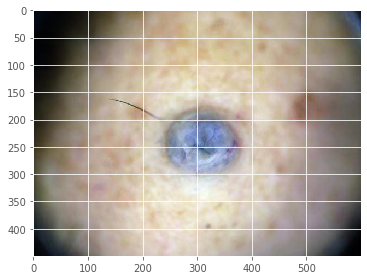

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


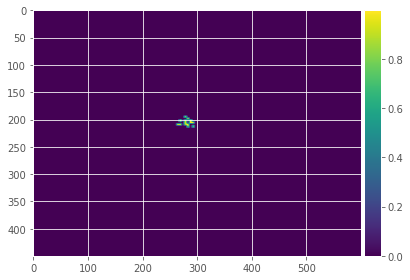

1/1 [==============================] - 0s 4ms/sample
135
338
101
475
1/1 [==============================] - 0s 4ms/sample
72
384
2
597
1/1 [==============================] - 0s 5ms/sample
72
300
251
362
1/1 [==============================] - 0s 5ms/sample
107
356
190
419
1/1 [==============================] - 0s 5ms/sample
146
303
227
419
1/1 [==============================] - 0s 5ms/sample
174
264
251
353
1/1 [==============================] - 0s 4ms/sample
111
293
213
376
1/1 [==============================] - 0s 5ms/sample
188
271
265
339
1/1 [==============================] - 0s 5ms/sample
146
293
199
428
1/1 [==============================] - 0s 5ms/sample
100
324
101
479
1/1 [==============================] - 0s 5ms/sample
97
278
213
386
1/1 [==============================] - 0s 5ms/sample
23
433
2
597
1/1 [==============================] - 0s 5ms/sample
62
440
63
447
1/1 [==============================] - 0s 5ms/sample
153
328
251
376
1/1 [==============================] - 0s 5m

121
338
91
470
ISIC_0032428
1/1 [==============================] - 0s 5ms/sample
199
307
218
372
1/1 [==============================] - 0s 5ms/sample
114
373
199
390
1/1 [==============================] - 0s 6ms/sample


185
300
265
339
ISIC_0028413
1/1 [==============================] - 0s 5ms/sample
167
271
246
344
1/1 [==============================] - 0s 5ms/sample


146
300
213
358
ISIC_0029752
1/1 [==============================] - 0s 5ms/sample
188
282
241
325
1/1 [==============================] - 0s 5ms/sample
128
335
190
367
1/1 [==============================] - 0s 5ms/sample
128
275
213
367
1/1 [==============================] - 0s 5ms/sample
181
275
255
344
1/1 [==============================] - 0s 5ms/sample
206
268
260
325
1/1 [==============================] - 0s 5ms/sample
153
289
195
348
1/1 [==============================] - 0s 4ms/sample
132
338
213
423
1/1 [==============================] - 0s 5ms/sample
40
409
96
470
1/1 [==============================] - 0s 4ms/sample
135
293
223
381
1/1 [==============================] - 0s 4ms/sample
171
257
255
339
1/1 [==============================] - 0s 4ms/sample
139
307
190
404
1/1 [==============================] - 0s 4ms/sample


79
380
115
470
ISIC_0030273
1/1 [==============================] - 0s 4ms/sample
206
264
270
348
1/1 [==============================] - 0s 4ms/sample
160
303
232
390
1/1 [==============================] - 0s 5ms/sample
142
286
246
367
1/1 [==============================] - 0s 5ms/sample
114
317
199
367
1/1 [==============================] - 0s 5ms/sample
72
395
120
470
1/1 [==============================] - 0s 5ms/sample
135
335
227
433
1/1 [==============================] - 0s 5ms/sample
97
359
124
470
1/1 [==============================] - 0s 5ms/sample
135
440
129
531
1/1 [==============================] - 0s 5ms/sample
195
296
237
344
1/1 [==============================] - 0s 6ms/sample
132
307
209
395
1/1 [==============================] - 0s 5ms/sample
206
296
237
362
1/1 [==============================] - 0s 5ms/sample
86
310
138
442
1/1 [==============================] - 0s 6ms/sample
188
282
251
376
1/1 [==============================] - 0s 5ms/sample
104
359
120
465
1/1 [====

149
282
213
390
ISIC_0025152
1/1 [==============================] - 0s 4ms/sample
132
349
199
367
1/1 [==============================] - 0s 4ms/sample
65
440
171
433
1/1 [==============================] - 0s 4ms/sample
139
271
246
339
1/1 [==============================] - 0s 4ms/sample
100
359
204
390
1/1 [==============================] - 0s 4ms/sample
153
317
185
372
1/1 [==============================] - 0s 5ms/sample
192
293
251
376
1/1 [==============================] - 0s 4ms/sample
33
391
87
536
1/1 [==============================] - 0s 5ms/sample
118
335
190
461
1/1 [==============================] - 0s 5ms/sample
132
447
195
456
1/1 [==============================] - 0s 5ms/sample
111
405
157
456
1/1 [==============================] - 0s 5ms/sample
121
345
35
512
1/1 [==============================] - 0s 5ms/sample
167
307
143
409
1/1 [==============================] - 0s 6ms/sample
149
317
190
381
1/1 [==============================] - 0s 5ms/sample
33
430
87
536
1/1 [======

156
243
265
320
ISIC_0027427
1/1 [==============================] - 0s 4ms/sample
360
380
443
475
1/1 [==============================] - 0s 4ms/sample
128
307
232
339
1/1 [==============================] - 0s 4ms/sample
83
359
199
367
1/1 [==============================] - 0s 5ms/sample
142
282
209
400
1/1 [==============================] - 0s 5ms/sample
90
324
96
508
1/1 [==============================] - 0s 5ms/sample
171
293
232
362
1/1 [==============================] - 0s 5ms/sample
86
356
148
489
1/1 [==============================] - 0s 5ms/sample
146
328
204
381
1/1 [==============================] - 0s 5ms/sample


181
328
227
395
ISIC_0024618
1/1 [==============================] - 0s 5ms/sample
163
264
232
376
1/1 [==============================] - 0s 5ms/sample
100
268
195
447
1/1 [==============================] - 0s 4ms/sample
163
310
209
386
1/1 [==============================] - 0s 4ms/sample
188
250
270
339
1/1 [==============================] - 0s 5ms/sample
146
264
255
358
1/1 [==============================] - 0s 4ms/sample
104
324
209
404
1/1 [==============================] - 0s 4ms/sample
118
314
138
494
1/1 [==============================] - 0s 5ms/sample
195
289
223
367
1/1 [==============================] - 0s 4ms/sample
153
303
190
386
1/1 [==============================] - 0s 4ms/sample
188
278
237
358
1/1 [==============================] - 0s 5ms/sample


114
310
209
362
ISIC_0024986
1/1 [==============================] - 0s 4ms/sample
195
264
260
320
1/1 [==============================] - 0s 5ms/sample
171
314
223
395
1/1 [==============================] - 0s 4ms/sample
58
384
82
494
1/1 [==============================] - 0s 5ms/sample
174
278
251
362
1/1 [==============================] - 0s 4ms/sample
90
359
199
470
1/1 [==============================] - 0s 4ms/sample
156
268
251
358
1/1 [==============================] - 0s 5ms/sample
167
314
227
353
1/1 [==============================] - 0s 4ms/sample
30
423
110
475
1/1 [==============================] - 0s 4ms/sample
30
321
166
400
1/1 [==============================] - 0s 4ms/sample
149
282
255
358
1/1 [==============================] - 0s 4ms/sample
156
314
180
433
1/1 [==============================] - 0s 4ms/sample
163
254
49
339
1/1 [==============================] - 0s 4ms/sample
174
268
251
344
1/1 [==============================] - 0s 4ms/sample
93
328
218
423
1/1 [=======

128
300
204
409
ISIC_0030930
1/1 [==============================] - 0s 4ms/sample
33
391
73
536
1/1 [==============================] - 0s 6ms/sample
90
321
157
475
1/1 [==============================] - 0s 5ms/sample
171
271
241
372
1/1 [==============================] - 0s 5ms/sample
37
370
59
545
1/1 [==============================] - 0s 5ms/sample
160
275
227
390
1/1 [==============================] - 0s 6ms/sample
58
366
35
475
1/1 [==============================] - 0s 4ms/sample
118
349
180
386
1/1 [==============================] - 0s 4ms/sample
146
335
232
390
1/1 [==============================] - 0s 5ms/sample
12
447
96
484
1/1 [==============================] - 0s 5ms/sample
163
293
241
372
1/1 [==============================] - 0s 4ms/sample
185
247
270
339
1/1 [==============================] - 0s 5ms/sample
149
303
227
372
1/1 [==============================] - 0s 5ms/sample
178
250
251
325
1/1 [==============================] - 0s 5ms/sample
153
289
246
372
1/1 [=========

23
402
115
536
ISIC_0031676
1/1 [==============================] - 0s 4ms/sample
111
310
180
400
1/1 [==============================] - 0s 5ms/sample
83
352
82
503
1/1 [==============================] - 0s 4ms/sample
153
293
195
390
1/1 [==============================] - 0s 5ms/sample
156
303
237
334
1/1 [==============================] - 0s 4ms/sample
97
338
148
386
1/1 [==============================] - 0s 4ms/sample
146
307
223
367
1/1 [==============================] - 0s 5ms/sample
178
275
260
348
1/1 [==============================] - 0s 5ms/sample
160
278
218
381
1/1 [==============================] - 0s 5ms/sample
121
286
180
390
1/1 [==============================] - 0s 5ms/sample
23
412
115
470
1/1 [==============================] - 0s 5ms/sample
128
293
227
376
1/1 [==============================] - 0s 4ms/sample
142
416
209
597
1/1 [==============================] - 0s 4ms/sample
114
444
68
437
1/1 [==============================] - 0s 4ms/sample
146
254
227
348
1/1 [======

100
303
190
372
ISIC_0031622
1/1 [==============================] - 0s 4ms/sample
97
384
180
423
1/1 [==============================] - 0s 4ms/sample
146
282
246
362
1/1 [==============================] - 0s 5ms/sample
160
271
251
358
1/1 [==============================] - 0s 5ms/sample
125
300
190
367
1/1 [==============================] - 0s 4ms/sample
128
328
171
409
1/1 [==============================] - 0s 4ms/sample
163
254
237
348
1/1 [==============================] - 0s 4ms/sample
156
286
185
381
1/1 [==============================] - 0s 4ms/sample
188
268
232
353
1/1 [==============================] - 0s 5ms/sample
83
335
134
442
1/1 [==============================] - 0s 5ms/sample
139
278
218
386
1/1 [==============================] - 0s 5ms/sample
185
264
237
348
1/1 [==============================] - 0s 5ms/sample
167
261
246
353
1/1 [==============================] - 0s 4ms/sample
139
447
260
484
1/1 [==============================] - 0s 4ms/sample
142
296
260
358
1/1 [==

153
278
232
386
ISIC_0029354
1/1 [==============================] - 0s 6ms/sample
104
328
138
414
1/1 [==============================] - 0s 5ms/sample
69
342
120
470
1/1 [==============================] - 0s 4ms/sample
132
293
223
414
1/1 [==============================] - 0s 5ms/sample
58
395
91
517
1/1 [==============================] - 0s 5ms/sample
19
380
82
517
1/1 [==============================] - 0s 5ms/sample
51
338
176
517
1/1 [==============================] - 0s 5ms/sample
121
349
195
428
1/1 [==============================] - 0s 5ms/sample
97
352
143
442
1/1 [==============================] - 0s 4ms/sample
30
387
77
494
1/1 [==============================] - 0s 4ms/sample
76
377
120
531
1/1 [==============================] - 0s 5ms/sample
149
307
134
433
1/1 [==============================] - 0s 4ms/sample
97
398
73
475
1/1 [==============================] - 0s 4ms/sample
160
286
241
376
1/1 [==============================] - 0s 5ms/sample
86
296
195
433
1/1 [=============

65
352
124
475
ISIC_0029179
1/1 [==============================] - 0s 5ms/sample
149
275
232
381
1/1 [==============================] - 0s 5ms/sample
135
314
251
465
1/1 [==============================] - 0s 5ms/sample
2
447
16
597
1/1 [==============================] - 0s 5ms/sample
9
440
40
583
1/1 [==============================] - 0s 5ms/sample
146
296
180
353
1/1 [==============================] - 0s 5ms/sample
139
296
232
367
1/1 [==============================] - 0s 5ms/sample
97
426
110
395
1/1 [==============================] - 0s 5ms/sample
76
303
218
479
1/1 [==============================] - 0s 5ms/sample
54
370
101
437
1/1 [==============================] - 0s 5ms/sample
104
335
209
423
1/1 [==============================] - 0s 5ms/sample
65
321
176
479
1/1 [==============================] - 0s 5ms/sample
104
324
138
475
1/1 [==============================] - 0s 5ms/sample
128
264
199
358
1/1 [==============================] - 0s 5ms/sample
79
377
115
489
1/1 [============

128
303
157
395
ISIC_0028287
1/1 [==============================] - 0s 5ms/sample
76
387
30
554
1/1 [==============================] - 0s 5ms/sample
149
268
232
348
1/1 [==============================] - 0s 5ms/sample
163
300
232
386
1/1 [==============================] - 0s 5ms/sample
139
314
190
390
1/1 [==============================] - 0s 4ms/sample
83
387
87
484
1/1 [==============================] - 0s 7ms/sample
111
380
143
404
1/1 [==============================] - 0s 4ms/sample
132
328
176
376
1/1 [==============================] - 0s 5ms/sample
51
423
82
465
1/1 [==============================] - 0s 4ms/sample
72
363
120
470
1/1 [==============================] - 0s 5ms/sample
104
345
101
484
1/1 [==============================] - 0s 4ms/sample
149
314
218
409
1/1 [==============================] - 0s 5ms/sample
30
426
91
465
1/1 [==============================] - 0s 4ms/sample
125
264
232
423
1/1 [==============================] - 0s 4ms/sample
62
307
190
498
1/1 [==========

153
307
232
362
ISIC_0033971
1/1 [==============================] - 0s 4ms/sample
181
282
251
339
1/1 [==============================] - 0s 4ms/sample
125
373
166
372
1/1 [==============================] - 0s 5ms/sample
174
331
209
367
1/1 [==============================] - 0s 4ms/sample
104
395
162
437
1/1 [==============================] - 0s 4ms/sample
192
300
241
344
1/1 [==============================] - 0s 4ms/sample
125
391
138
503
1/1 [==============================] - 0s 5ms/sample
171
359
171
442
1/1 [==============================] - 0s 5ms/sample
181
314
209
404
1/1 [==============================] - 0s 5ms/sample
167
331
185
372
1/1 [==============================] - 0s 5ms/sample
156
373
138
386
1/1 [==============================] - 0s 5ms/sample
86
412
68
437
1/1 [==============================] - 0s 5ms/sample
128
278
180
367
1/1 [==============================] - 0s 5ms/sample
54
402
120
461
1/1 [==============================] - 0s 5ms/sample
114
307
162
395
1/1 [===

37
377
77
409
ISIC_0025239
1/1 [==============================] - 0s 5ms/sample
33
363
138
470
1/1 [==============================] - 0s 5ms/sample
2
387
110
494
1/1 [==============================] - 0s 5ms/sample
97
321
190
414
1/1 [==============================] - 0s 5ms/sample
171
338
195
404
1/1 [==============================] - 0s 6ms/sample
47
405
68
536
1/1 [==============================] - 0s 5ms/sample
149
387
148
442
1/1 [==============================] - 0s 5ms/sample
26
423
82
419
1/1 [==============================] - 0s 5ms/sample
72
366
73
475
1/1 [==============================] - 0s 5ms/sample
156
303
190
372
1/1 [==============================] - 0s 5ms/sample
128
335
138
404
1/1 [==============================] - 0s 5ms/sample
125
296
185
376
1/1 [==============================] - 0s 5ms/sample
58
342
110
428
1/1 [==============================] - 0s 5ms/sample
44
384
77
447
1/1 [==============================] - 0s 5ms/sample
83
345
166
456
1/1 [================

163
268
241
358
ISIC_0029902
1/1 [==============================] - 0s 5ms/sample
118
345
199
381
1/1 [==============================] - 0s 4ms/sample
178
303
241
348
1/1 [==============================] - 0s 5ms/sample
146
296
157
376
1/1 [==============================] - 0s 5ms/sample
202
282
251
358
1/1 [==============================] - 0s 5ms/sample
47
278
190
433
1/1 [==============================] - 0s 5ms/sample
135
278
218
367
1/1 [==============================] - 0s 5ms/sample
118
303
237
414
1/1 [==============================] - 0s 6ms/sample
62
402
152
484
1/1 [==============================] - 0s 4ms/sample
121
352
110
451
1/1 [==============================] - 0s 4ms/sample
192
289
213
353
1/1 [==============================] - 0s 4ms/sample
146
317
199
390
1/1 [==============================] - 0s 4ms/sample
209
300
241
334
1/1 [==============================] - 0s 9ms/sample
202
282
251
344
1/1 [==============================] - 0s 5ms/sample
118
314
166
437
1/1 [==

40
405
91
545
ISIC_0033459
1/1 [==============================] - 0s 5ms/sample
121
321
157
409
1/1 [==============================] - 0s 5ms/sample
125
275
227
367
1/1 [==============================] - 0s 5ms/sample
114
335
185
404
1/1 [==============================] - 0s 4ms/sample
51
409
110
470
1/1 [==============================] - 0s 4ms/sample
135
349
120
484
1/1 [==============================] - 0s 4ms/sample
72
387
16
597
1/1 [==============================] - 0s 4ms/sample
72
356
45
564
1/1 [==============================] - 0s 4ms/sample
107
296
227
400
1/1 [==============================] - 0s 4ms/sample
58
419
45
508
1/1 [==============================] - 0s 5ms/sample
37
331
180
451
1/1 [==============================] - 0s 5ms/sample
40
366
134
447
1/1 [==============================] - 0s 5ms/sample
69
335
162
414
1/1 [==============================] - 0s 4ms/sample
160
380
241
376
1/1 [==============================] - 0s 5ms/sample
79
380
87
517
1/1 [==============

79
356
124
517
ISIC_0033388
1/1 [==============================] - 0s 5ms/sample
160
300
213
404
1/1 [==============================] - 0s 4ms/sample


118
335
157
470
ISIC_0032928
1/1 [==============================] - 0s 4ms/sample
132
254
237
348
1/1 [==============================] - 0s 5ms/sample
19
278
152
400


ISIC_0033157
1/1 [==============================] - 0s 5ms/sample
79
268
195
372
1/1 [==============================] - 0s 5ms/sample
97
338
63
451
1/1 [==============================] - 0s 5ms/sample
125
303
115
395
1/1 [==============================] - 0s 5ms/sample
107
264
148
400
1/1 [==============================] - 0s 5ms/sample
44
314
77
540
1/1 [==============================] - 0s 5ms/sample
62
321
82
479
1/1 [==============================] - 0s 5ms/sample
76
324
171
465
1/1 [==============================] - 0s 5ms/sample
23
405
68
550
1/1 [==============================] - 0s 5ms/sample
30
345
138
522
1/1 [==============================] - 0s 5ms/sample
93
402
82
517
1/1 [==============================] - 0s 4ms/sample
128
387
120
465
1/1 [==============================] - 0s 4ms/sample
142
314
195
414
1/1 [==============================] - 0s 4ms/sample
97
331
54
484
1/1 [==============================] - 0s 4ms/sample
111
317
87
456
1/1 [==============================] 

121
296
185
423
ISIC_0033497
1/1 [==============================] - 0s 4ms/sample
216
324
223
390
1/1 [==============================] - 0s 4ms/sample
153
296
157
404
1/1 [==============================] - 0s 6ms/sample
216
293
232
339
1/1 [==============================] - 0s 5ms/sample
156
303
190
390
1/1 [==============================] - 0s 4ms/sample
163
345
148
404
1/1 [==============================] - 0s 5ms/sample
62
391
59
536
1/1 [==============================] - 0s 4ms/sample
107
342
152
428
1/1 [==============================] - 0s 5ms/sample
149
387
185
376
1/1 [==============================] - 0s 5ms/sample
44
409
82
503
1/1 [==============================] - 0s 5ms/sample
2
447
96
484
1/1 [==============================] - 0s 5ms/sample
37
412
143
461
1/1 [==============================] - 0s 5ms/sample
72
398
63
475
1/1 [==============================] - 0s 5ms/sample
132
338
190
447
1/1 [==============================] - 0s 4ms/sample
156
300
232
395
1/1 [==========

160
261
260
362
ISIC_0034264
1/1 [==============================] - 0s 5ms/sample
30
349
185
461
1/1 [==============================] - 0s 4ms/sample
83
236
218
358
1/1 [==============================] - 0s 5ms/sample
135
236
246
344
1/1 [==============================] - 0s 4ms/sample
79
324
166
419
1/1 [==============================] - 0s 4ms/sample
132
286
213
376
1/1 [==============================] - 0s 4ms/sample
171
275
241
353
1/1 [==============================] - 0s 5ms/sample
139
296
195
404
1/1 [==============================] - 0s 5ms/sample
19
387
35
569
1/1 [==============================] - 0s 5ms/sample
44
366
73
517
1/1 [==============================] - 0s 5ms/sample
40
335
213
470
1/1 [==============================] - 0s 4ms/sample
23
387
195
512
1/1 [==============================] - 0s 4ms/sample
26
423
35
597
1/1 [==============================] - 0s 5ms/sample
65
447
105
489
1/1 [==============================] - 0s 5ms/sample
104
356
180
419
1/1 [============

37
423
87
512
ISIC_0032961
1/1 [==============================] - 0s 5ms/sample
111
303
195
419
1/1 [==============================] - 0s 5ms/sample
62
387
105
484
1/1 [==============================] - 0s 5ms/sample
174
264
204
362
1/1 [==============================] - 0s 5ms/sample
111
303
138
409
1/1 [==============================] - 0s 5ms/sample
156
300
180
376
1/1 [==============================] - 0s 5ms/sample
93
387
162
461
1/1 [==============================] - 0s 5ms/sample
90
391
148
409
1/1 [==============================] - 0s 5ms/sample
30
345
40
564
1/1 [==============================] - 0s 5ms/sample
69
380
87
554
1/1 [==============================] - 0s 5ms/sample
40
282
115
489
1/1 [==============================] - 0s 5ms/sample
79
293
185
419
1/1 [==============================] - 0s 5ms/sample
16
363
26
597
1/1 [==============================] - 0s 5ms/sample
2
409
129
494
1/1 [==============================] - 0s 5ms/sample
69
447
26
517
1/1 [=================

125
271
213
367
ISIC_0033105
1/1 [==============================] - 0s 5ms/sample
76
366
2
597
1/1 [==============================] - 0s 5ms/sample
153
345
246
437
1/1 [==============================] - 0s 5ms/sample
132
377
120
461
1/1 [==============================] - 0s 5ms/sample
69
391
30
597
1/1 [==============================] - 0s 4ms/sample
90
243
195
362
1/1 [==============================] - 0s 4ms/sample
153
300
246
400
1/1 [==============================] - 0s 4ms/sample
104
335
195
451
1/1 [==============================] - 0s 5ms/sample
54
331
176
428
1/1 [==============================] - 0s 5ms/sample
62
391
162
419
1/1 [==============================] - 0s 5ms/sample
23
447
2
564
1/1 [==============================] - 0s 6ms/sample
69
380
21
573
1/1 [==============================] - 0s 5ms/sample
23
359
120
437
1/1 [==============================] - 0s 5ms/sample
83
387
148
428
1/1 [==============================] - 0s 5ms/sample
79
402
77
554
1/1 [=================

69
402
176
423
ISIC_0033489
1/1 [==============================] - 0s 5ms/sample
86
335
26
592
1/1 [==============================] - 0s 5ms/sample
54
373
2
597
1/1 [==============================] - 0s 5ms/sample
100
384
138
437
1/1 [==============================] - 0s 5ms/sample
19
430
59
512
1/1 [==============================] - 0s 5ms/sample
79
314
101
404
1/1 [==============================] - 0s 5ms/sample
37
412
49
517
1/1 [==============================] - 0s 5ms/sample
2
412
91
597
1/1 [==============================] - 0s 5ms/sample
30
356
129
461
1/1 [==============================] - 0s 5ms/sample
142
296
227
386
1/1 [==============================] - 0s 5ms/sample


104
359
101
437
ISIC_0034147
1/1 [==============================] - 0s 5ms/sample
107
282
195
409
1/1 [==============================] - 0s 5ms/sample
93
335
180
419
1/1 [==============================] - 0s 5ms/sample
72
352
68
437
1/1 [==============================] - 0s 5ms/sample
62
380
120
479
1/1 [==============================] - 0s 5ms/sample
16
426
49
526
1/1 [==============================] - 0s 5ms/sample
79
370
87
573
1/1 [==============================] - 0s 4ms/sample
118
328
129
428
1/1 [==============================] - 0s 5ms/sample
142
278
195
386
1/1 [==============================] - 0s 5ms/sample
128
275
209
358
1/1 [==============================] - 0s 4ms/sample
83
307
143
395
1/1 [==============================] - 0s 5ms/sample
72
363
171
409
1/1 [==============================] - 0s 5ms/sample
121
321
204
358
1/1 [==============================] - 0s 5ms/sample
33
402
148
437
1/1 [==============================] - 0s 5ms/sample
156
317
204
390
1/1 [===========

47
335
82
475
ISIC_0033176
1/1 [==============================] - 0s 4ms/sample
58
402
96
320
1/1 [==============================] - 0s 4ms/sample
51
380
77
414
1/1 [==============================] - 0s 4ms/sample
79
345
73
479
1/1 [==============================] - 0s 5ms/sample
51
331
190
419
1/1 [==============================] - 0s 4ms/sample
135
247
251
404
1/1 [==============================] - 0s 4ms/sample
83
405
63
522
1/1 [==============================] - 0s 4ms/sample
44
342
124
479
1/1 [==============================] - 0s 5ms/sample
125
278
209
395
1/1 [==============================] - 0s 5ms/sample
90
307
166
437
1/1 [==============================] - 0s 4ms/sample
121
303
227
531
1/1 [==============================] - 0s 5ms/sample
51
286
176
404
1/1 [==============================] - 0s 4ms/sample
107
275
213
372
1/1 [==============================] - 0s 4ms/sample
146
335
223
400
1/1 [==============================] - 0s 5ms/sample
2
433
110
508
1/1 [================

86
324
30
597
ISIC_0032523
1/1 [==============================] - 0s 5ms/sample
118
296
138
540
1/1 [==============================] - 0s 5ms/sample
139
324
143
503
1/1 [==============================] - 0s 5ms/sample
104
359
68
597
1/1 [==============================] - 0s 5ms/sample
79
377
105
550
1/1 [==============================] - 0s 5ms/sample
160
342
105
465
1/1 [==============================] - 0s 6ms/sample
2
363
77
517
1/1 [==============================] - 0s 5ms/sample
62
342
115
461
1/1 [==============================] - 0s 5ms/sample
69
300
227
461
1/1 [==============================] - 0s 5ms/sample
16
324
195
536
1/1 [==============================] - 0s 5ms/sample
2
444
138
465
1/1 [==============================] - 0s 5ms/sample
19
423
152
433
1/1 [==============================] - 0s 5ms/sample
40
373
45
583
1/1 [==============================] - 0s 5ms/sample
79
282
134
475
1/1 [==============================] - 0s 5ms/sample
100
447
180
597
1/1 [================

44
307
190
390
ISIC_0034250
1/1 [==============================] - 0s 5ms/sample
118
345
166
461
1/1 [==============================] - 0s 5ms/sample
142
275
209
428
1/1 [==============================] - 0s 5ms/sample
139
303
209
344
1/1 [==============================] - 0s 5ms/sample
178
444
2
372
1/1 [==============================] - 0s 5ms/sample
54
370
87
554
1/1 [==============================] - 0s 5ms/sample
79
331
96
550
1/1 [==============================] - 0s 5ms/sample
125
359
124
419
1/1 [==============================] - 0s 5ms/sample
156
307
232
409
1/1 [==============================] - 0s 5ms/sample
86
328
124
428
1/1 [==============================] - 0s 5ms/sample
142
331
143
433
1/1 [==============================] - 0s 4ms/sample
146
289
218
400
1/1 [==============================] - 0s 5ms/sample
72
433
26
489
1/1 [==============================] - 0s 5ms/sample
139
289
185
437
1/1 [==============================] - 0s 5ms/sample
100
363
157
479
1/1 [==========

125
363
218
404
ISIC_0032571
1/1 [==============================] - 0s 4ms/sample
54
377
209
540
1/1 [==============================] - 0s 5ms/sample
93
321
115
451
1/1 [==============================] - 0s 5ms/sample
142
331
110
461
1/1 [==============================] - 0s 4ms/sample
37
373
77
512
1/1 [==============================] - 0s 4ms/sample
26
447
73
526
1/1 [==============================] - 0s 4ms/sample
65
331
148
479
1/1 [==============================] - 0s 4ms/sample
90
349
63
550
1/1 [==============================] - 0s 4ms/sample
2
349
134
498
1/1 [==============================] - 0s 6ms/sample


128
331
134
334
ISIC_0033072
1/1 [==============================] - 0s 5ms/sample
86
310
63
456
1/1 [==============================] - 0s 5ms/sample
114
278
185
451
1/1 [==============================] - 0s 5ms/sample
2
423
40
395
1/1 [==============================] - 0s 5ms/sample
100
430
124
494
1/1 [==============================] - 0s 4ms/sample
100
380
143
372
1/1 [==============================] - 0s 4ms/sample


97
321
157
536
ISIC_0034082
1/1 [==============================] - 0s 5ms/sample
69
307
101
433
1/1 [==============================] - 0s 5ms/sample
111
240
213
372
1/1 [==============================] - 0s 4ms/sample
37
426
63
503
1/1 [==============================] - 0s 4ms/sample
37
377
129
484
1/1 [==============================] - 0s 4ms/sample
114
310
157
414
1/1 [==============================] - 0s 5ms/sample
139
222
195
283
1/1 [==============================] - 0s 5ms/sample
132
303
120
325
1/1 [==============================] - 0s 5ms/sample
37
314
124
484
1/1 [==============================] - 0s 5ms/sample


76
331
82
489
ISIC_0033882
1/1 [==============================] - 0s 5ms/sample
111
310
241
386
1/1 [==============================] - 0s 4ms/sample
30
380
204
470
1/1 [==============================] - 0s 5ms/sample
139
247
288
404
1/1 [==============================] - 0s 5ms/sample


69
370
185
414
ISIC_0033375
1/1 [==============================] - 0s 4ms/sample
65
289
190
433
1/1 [==============================] - 0s 5ms/sample
23
398
120
550
1/1 [==============================] - 0s 5ms/sample
100
387
120
344
1/1 [==============================] - 0s 4ms/sample
149
303
218
376
1/1 [==============================] - 0s 4ms/sample
107
345
176
428
1/1 [==============================] - 0s 5ms/sample
51
377
91
325
1/1 [==============================] - 0s 5ms/sample
146
335
190
367
1/1 [==============================] - 0s 4ms/sample
114
310
209
376
1/1 [==============================] - 0s 4ms/sample
132
335
190
395
1/1 [==============================] - 0s 5ms/sample
125
303
162
381
1/1 [==============================] - 0s 4ms/sample
188
293
232
367
1/1 [==============================] - 0s 5ms/sample
195
338
213
400
1/1 [==============================] - 0s 5ms/sample
97
426
87
423
1/1 [==============================] - 0s 5ms/sample
93
250
152
386
1/1 [========

146
433
176
451
ISIC_0034195
1/1 [==============================] - 0s 6ms/sample
181
271
255
339
1/1 [==============================] - 0s 5ms/sample
90
359
157
409
1/1 [==============================] - 0s 5ms/sample
107
282
284
456
1/1 [==============================] - 0s 5ms/sample
163
307
190
390
1/1 [==============================] - 0s 6ms/sample
104
338
101
531
1/1 [==============================] - 0s 5ms/sample
160
271
270
358
1/1 [==============================] - 0s 6ms/sample
111
328
227
386
1/1 [==============================] - 0s 6ms/sample
121
324
251
414
1/1 [==============================] - 0s 5ms/sample
65
391
162
419
1/1 [==============================] - 0s 6ms/sample
128
359
195
395
1/1 [==============================] - 0s 5ms/sample
174
278
265
348
1/1 [==============================] - 0s 5ms/sample
163
257
260
344
1/1 [==============================] - 0s 5ms/sample
114
324
195
404
1/1 [==============================] - 0s 5ms/sample
65
380
180
451
1/1 [===

185
282
213
325
ISIC_0025653
1/1 [==============================] - 0s 5ms/sample
142
282
204
376
1/1 [==============================] - 0s 5ms/sample
146
282
223
358
1/1 [==============================] - 0s 5ms/sample
188
247
270
334
1/1 [==============================] - 0s 5ms/sample
128
303
204
419
1/1 [==============================] - 0s 5ms/sample
171
264
246
353
1/1 [==============================] - 0s 5ms/sample
135
328
185
395
1/1 [==============================] - 0s 5ms/sample
65
370
129
423
1/1 [==============================] - 0s 5ms/sample
76
342
120
437
1/1 [==============================] - 0s 5ms/sample
163
293
232
376
1/1 [==============================] - 0s 5ms/sample
146
278
176
409
1/1 [==============================] - 0s 5ms/sample
192
278
241
376
1/1 [==============================] - 0s 5ms/sample
192
278
270
353
1/1 [==============================] - 0s 5ms/sample
167
314
218
358
1/1 [==============================] - 0s 5ms/sample
163
324
77
376
1/1 [===

121
310
96
569
ISIC_0031148
1/1 [==============================] - 0s 5ms/sample
181
278
284
362
1/1 [==============================] - 0s 5ms/sample
146
307
251
367
1/1 [==============================] - 0s 5ms/sample
118
289
190
348
1/1 [==============================] - 0s 5ms/sample
121
300
185
451
1/1 [==============================] - 0s 5ms/sample
79
359
190
409
1/1 [==============================] - 0s 5ms/sample
104
363
195
433
1/1 [==============================] - 0s 5ms/sample
174
423
40
320
1/1 [==============================] - 0s 5ms/sample
107
335
195
386
1/1 [==============================] - 0s 5ms/sample
121
303
251
400
1/1 [==============================] - 0s 5ms/sample
23
444
54
475
1/1 [==============================] - 0s 5ms/sample
2
444
54
578
1/1 [==============================] - 0s 5ms/sample
160
282
232
367
1/1 [==============================] - 0s 5ms/sample


192
254
251
325
ISIC_0028438
1/1 [==============================] - 0s 5ms/sample


83
373
129
517
ISIC_0024830
1/1 [==============================] - 0s 5ms/sample


160
282
265
362
ISIC_0028380
1/1 [==============================] - 0s 4ms/sample


62
391
115
517
ISIC_0027924
1/1 [==============================] - 0s 4ms/sample


111
324
176
419
ISIC_0031547
1/1 [==============================] - 0s 4ms/sample


153
278
223
362
ISIC_0032221
1/1 [==============================] - 0s 4ms/sample


47
395
2
597
ISIC_0030693
1/1 [==============================] - 0s 5ms/sample


149
338
138
428
ISIC_0031649
1/1 [==============================] - 0s 5ms/sample


107
377
129
484
ISIC_0033243
1/1 [==============================] - 0s 5ms/sample


163
314
213
400
ISIC_0032648
1/1 [==============================] - 0s 5ms/sample


54
423
59
569
ISIC_0032620
1/1 [==============================] - 0s 4ms/sample


125
324
166
419
ISIC_0030420
1/1 [==============================] - 0s 5ms/sample


79
395
73
498
ISIC_0033671
1/1 [==============================] - 0s 5ms/sample


135
321
166
419
ISIC_0033711
1/1 [==============================] - 0s 5ms/sample


83
303
185
390
ISIC_0034084
1/1 [==============================] - 0s 5ms/sample


128
268
232
376
ISIC_0033273
1/1 [==============================] - 0s 5ms/sample


72
345
96
437
ISIC_0034176
1/1 [==============================] - 0s 5ms/sample


76
352
115
433
ISIC_0033104
1/1 [==============================] - 0s 5ms/sample


33
433
82
512
ISIC_0032579
1/1 [==============================] - 0s 5ms/sample


104
363
162
433
ISIC_0033189
1/1 [==============================] - 0s 5ms/sample


26
426
21
597
ISIC_0032693
1/1 [==============================] - 0s 5ms/sample


26
423
12
597
ISIC_0032734
1/1 [==============================] - 0s 5ms/sample


16
433
82
508
ISIC_0032659
1/1 [==============================] - 0s 5ms/sample


72
380
148
470
ISIC_0032478
1/1 [==============================] - 0s 5ms/sample


2
447
49
573
ISIC_0032765
1/1 [==============================] - 0s 4ms/sample


76
328
152
423
ISIC_0033128
1/1 [==============================] - 0s 4ms/sample


135
282
213
376
ISIC_0033115
1/1 [==============================] - 0s 5ms/sample


47
373
120
470
ISIC_0032625
1/1 [==============================] - 0s 5ms/sample


142
307
148
409
ISIC_0033867
1/1 [==============================] - 0s 5ms/sample


107
307
120
442
ISIC_0033202
1/1 [==============================] - 0s 5ms/sample


19
447
91
512
ISIC_0032794
1/1 [==============================] - 0s 5ms/sample


23
433
110
508
ISIC_0032801
1/1 [==============================] - 0s 5ms/sample


12
384
26
470
ISIC_0032974
1/1 [==============================] - 0s 5ms/sample


23
384
2
484
ISIC_0033746
1/1 [==============================] - 0s 4ms/sample


111
328
120
447
ISIC_0033384
1/1 [==============================] - 0s 5ms/sample


30
391
12
573
ISIC_0032830
1/1 [==============================] - 0s 4ms/sample


65
387
138
442
ISIC_0028863
1/1 [==============================] - 0s 4ms/sample


2
444
73
479
ISIC_0030126
1/1 [==============================] - 0s 7ms/sample


86
433
143
484
ISIC_0032530
1/1 [==============================] - 0s 6ms/sample
107
395
166
451


ISIC_0033249
1/1 [==============================] - 0s 5ms/sample


33
356
190
390
ISIC_0032650
1/1 [==============================] - 0s 5ms/sample


72
416
26
597
ISIC_0034182
1/1 [==============================] - 0s 5ms/sample


93
366
204
404
ISIC_0034213
1/1 [==============================] - 0s 6ms/sample


9
447
171
442
ISIC_0032561
1/1 [==============================] - 0s 4ms/sample


125
328
213
376
ISIC_0033839
1/1 [==============================] - 0s 4ms/sample


65
345
45
569
ISIC_0032858
1/1 [==============================] - 0s 4ms/sample


111
321
120
494
ISIC_0033965
1/1 [==============================] - 0s 4ms/sample


30
289
138
456
ISIC_0026279
1/1 [==============================] - 0s 4ms/sample


163
293
209
358
ISIC_0031814
1/1 [==============================] - 0s 4ms/sample


128
300
166
381
ISIC_0032601
1/1 [==============================] - 0s 5ms/sample


69
395
63
573
ISIC_0032878
1/1 [==============================] - 0s 5ms/sample


79
366
195
437
ISIC_0033093
1/1 [==============================] - 0s 5ms/sample


104
286
204
362
ISIC_0033501
1/1 [==============================] - 0s 6ms/sample


26
423
152
489
ISIC_0032677
1/1 [==============================] - 0s 5ms/sample


149
342
237
381
ISIC_0032769
1/1 [==============================] - 0s 5ms/sample


185
289
265
348
ISIC_0033922
1/1 [==============================] - 0s 5ms/sample


23
398
143
414
ISIC_0033108
1/1 [==============================] - 0s 5ms/sample


107
391
138
475
ISIC_0033940
1/1 [==============================] - 0s 5ms/sample


163
331
237
419
ISIC_0033818
1/1 [==============================] - 0s 5ms/sample


125
356
157
442
ISIC_0034029
1/1 [==============================] - 0s 6ms/sample


104
331
227
367
ISIC_0032649
1/1 [==============================] - 0s 5ms/sample


26
409
185
409
ISIC_0034109
1/1 [==============================] - 0s 5ms/sample


192
314
270
353
ISIC_0033439
1/1 [==============================] - 0s 6ms/sample


72
331
148
470
ISIC_0033214
1/1 [==============================] - 0s 5ms/sample


100
310
180
423
ISIC_0033255
1/1 [==============================] - 0s 5ms/sample


146
278
227
376
ISIC_0033229
1/1 [==============================] - 0s 5ms/sample


135
433
2
437
ISIC_0026429
1/1 [==============================] - 0s 5ms/sample


174
271
246
348
ISIC_0025769
1/1 [==============================] - 0s 5ms/sample


47
419
91
503
ISIC_0032909
1/1 [==============================] - 0s 5ms/sample


62
384
143
484
ISIC_0033134
1/1 [==============================] - 0s 5ms/sample


202
275
288
367
ISIC_0034301
1/1 [==============================] - 0s 5ms/sample


72
398
129
465
ISIC_0033914
1/1 [==============================] - 0s 5ms/sample


146
314
213
381
ISIC_0033978
1/1 [==============================] - 0s 5ms/sample


23
447
54
517
ISIC_0033718
1/1 [==============================] - 0s 5ms/sample


23
405
77
517
ISIC_0034237
1/1 [==============================] - 0s 5ms/sample


51
349
171
508
ISIC_0034032
1/1 [==============================] - 0s 5ms/sample


135
289
209
381
ISIC_0033075
1/1 [==============================] - 0s 5ms/sample


100
307
190
465
ISIC_0033406
1/1 [==============================] - 0s 5ms/sample


178
264
237
358
ISIC_0033493
1/1 [==============================] - 0s 5ms/sample


79
391
96
526
ISIC_0033007
1/1 [==============================] - 0s 5ms/sample


100
335
152
428
ISIC_0034010
1/1 [==============================] - 0s 5ms/sample


40
384
82
479
ISIC_0032819
1/1 [==============================] - 0s 5ms/sample


30
426
35
536
ISIC_0033451
1/1 [==============================] - 0s 5ms/sample


93
324
157
409
ISIC_0033552
1/1 [==============================] - 0s 5ms/sample


37
363
73
447
ISIC_0034310
1/1 [==============================] - 0s 5ms/sample


16
391
77
498
ISIC_0032995
1/1 [==============================] - 0s 6ms/sample


146
289
218
376
ISIC_0032754
1/1 [==============================] - 0s 5ms/sample


83
335
152
442
ISIC_0032714
1/1 [==============================] - 0s 5ms/sample


44
359
138
433
ISIC_0033083
1/1 [==============================] - 0s 5ms/sample


153
271
260
372
ISIC_0033133
1/1 [==============================] - 0s 5ms/sample


76
324
223
447
ISIC_0033352
1/1 [==============================] - 0s 10ms/sample


76
282
162
386
ISIC_0032574
1/1 [==============================] - 0s 5ms/sample


156
257
218
339
ISIC_0033398
1/1 [==============================] - 0s 5ms/sample


65
254
204
353
ISIC_0033244
1/1 [==============================] - 0s 5ms/sample


167
331
180
372
ISIC_0032582
1/1 [==============================] - 0s 5ms/sample


79
352
91
414
ISIC_0033052
1/1 [==============================] - 0s 5ms/sample


30
423
49
489
ISIC_0032990
1/1 [==============================] - 0s 6ms/sample


107
289
166
376
ISIC_0033181
1/1 [==============================] - 0s 5ms/sample


44
303
101
419
ISIC_0033661
1/1 [==============================] - 0s 5ms/sample


139
275
209
353
ISIC_0034004
1/1 [==============================] - 0s 5ms/sample
100


296
148
470
ISIC_0033645
1/1 [==============================] - 0s 5ms/sample


62
359
49
564
ISIC_0028829
1/1 [==============================] - 0s 5ms/sample


125
282
180
428
ISIC_0033530
1/1 [==============================] - 0s 5ms/sample


62
373
143
540
ISIC_0032994
1/1 [==============================] - 0s 5ms/sample


79
264
223
428
ISIC_0033604
1/1 [==============================] - 0s 5ms/sample


44
433
40
536
ISIC_0033634
1/1 [==============================] - 0s 4ms/sample


153
317
185
390
ISIC_0034226
1/1 [==============================] - 0s 7ms/sample


118
380
115
437
ISIC_0033116
1/1 [==============================] - 0s 5ms/sample


100
324
171
409
ISIC_0033136
1/1 [==============================] - 0s 5ms/sample


185
254
204
287
ISIC_0033215
1/1 [==============================] - 0s 5ms/sample


114
342
199
376
ISIC_0033412
1/1 [==============================] - 0s 5ms/sample


69
395
157
404
ISIC_0033514
1/1 [==============================] - 0s 5ms/sample


47
423
129
414
ISIC_0033876
1/1 [==============================] - 0s 5ms/sample


107
391
190
428
ISIC_0032737
1/1 [==============================] - 0s 5ms/sample


142
293
223
414
ISIC_0033339
1/1 [==============================] - 0s 5ms/sample


62
391
45
564
ISIC_0031482
1/1 [==============================] - 0s 5ms/sample


114
293
152
456
ISIC_0032944
1/1 [==============================] - 0s 5ms/sample


139
275
171
404
ISIC_0033516
1/1 [==============================] - 0s 5ms/sample


23
391
87
465
ISIC_0032639
1/1 [==============================] - 0s 5ms/sample


76
373
148
437
ISIC_0033525
1/1 [==============================] - 0s 8ms/sample


37
352
96
442
ISIC_0033519
1/1 [==============================] - 0s 5ms/sample


90
321
157
400
ISIC_0032851
1/1 [==============================] - 0s 5ms/sample


90
387
63
554
ISIC_0033080
1/1 [==============================] - 0s 4ms/sample


149
377
148
494
ISIC_0034129
1/1 [==============================] - 0s 4ms/sample


30
405
68
573
ISIC_0033010
1/1 [==============================] - 0s 4ms/sample


128
314
195
428
ISIC_0034293
1/1 [==============================] - 0s 4ms/sample


118
423
87
512
ISIC_0033350
1/1 [==============================] - 0s 4ms/sample


23
447
26
597
ISIC_0033943
1/1 [==============================] - 0s 4ms/sample


65
366
120
470
ISIC_0033434
1/1 [==============================] - 0s 4ms/sample


93
314
213
489
ISIC_0033688
1/1 [==============================] - 0s 5ms/sample


37
380
124
550
ISIC_0033557
1/1 [==============================] - 0s 4ms/sample


30
356
101
494
ISIC_0033013
1/1 [==============================] - 0s 4ms/sample


2
391
59
550
ISIC_0032809
1/1 [==============================] - 0s 5ms/sample


167
324
255
386
ISIC_0032621
1/1 [==============================] - 0s 5ms/sample


100
342
176
390
ISIC_0033328
1/1 [==============================] - 0s 5ms/sample


135
317
195
404
ISIC_0033768
1/1 [==============================] - 0s 5ms/sample


72
398
110
489
ISIC_0025257
1/1 [==============================] - 0s 5ms/sample


153
303
237
376
ISIC_0033006
1/1 [==============================] - 0s 5ms/sample


23
409
45
554
ISIC_0032518
1/1 [==============================] - 0s 5ms/sample


51
395
143
479
ISIC_0033548
1/1 [==============================] - 0s 5ms/sample


33
387
68
447
ISIC_0033433
1/1 [==============================] - 0s 5ms/sample


2
437
35
517
ISIC_0032934
1/1 [==============================] - 0s 5ms/sample


62
423
68
503
ISIC_0033742
1/1 [==============================] - 0s 5ms/sample


76
352
171
508
ISIC_0034127
1/1 [==============================] - 0s 5ms/sample


90
342
157
475
ISIC_0033111
1/1 [==============================] - 0s 5ms/sample


76
345
49
550
ISIC_0033142
1/1 [==============================] - 0s 5ms/sample


62
363
21
573
ISIC_0032703
1/1 [==============================] - 0s 5ms/sample


111
300
148
517
ISIC_0033168
1/1 [==============================] - 0s 5ms/sample


160
321
101
494
ISIC_0033077
1/1 [==============================] - 0s 5ms/sample


107
342
35
554
ISIC_0033951
1/1 [==============================] - 0s 5ms/sample


107
377
12
578
ISIC_0033149
1/1 [==============================] - 0s 5ms/sample


44
324
68
494
ISIC_0033343
1/1 [==============================] - 0s 5ms/sample


40
395
40
597
ISIC_0033502
1/1 [==============================] - 0s 5ms/sample


58
426
96
451
ISIC_0034285
1/1 [==============================] - 0s 5ms/sample
128
380
195
423


ISIC_0033966
1/1 [==============================] - 0s 5ms/sample


132
321
204
372
ISIC_0034244
1/1 [==============================] - 0s 5ms/sample


118
222
218
311
ISIC_0032855
1/1 [==============================] - 0s 5ms/sample


100
387
148
395
ISIC_0032792
1/1 [==============================] - 0s 8ms/sample


2
447
45
503
ISIC_0034187
1/1 [==============================] - 0s 5ms/sample


30
402
110
475
ISIC_0027837
1/1 [==============================] - 0s 5ms/sample


160
328
199
386
ISIC_0033179
1/1 [==============================] - 0s 5ms/sample


114
338
143
395
ISIC_0034251
1/1 [==============================] - 0s 5ms/sample


178
296
232
358
ISIC_0033721
1/1 [==============================] - 0s 5ms/sample


114
349
195
442
ISIC_0034295
1/1 [==============================] - 0s 5ms/sample


100
380
166
479
ISIC_0033929
1/1 [==============================] - 0s 5ms/sample


178
328
246
386
ISIC_0033044
1/1 [==============================] - 0s 5ms/sample
86
328
171
479


ISIC_0033787
1/1 [==============================] - 0s 6ms/sample


90
384
91
569
ISIC_0033599
1/1 [==============================] - 0s 6ms/sample


2
447
54
573
ISIC_0033764
1/1 [==============================] - 0s 5ms/sample


37
405
87
494
ISIC_0033934
1/1 [==============================] - 0s 5ms/sample


118
377
152
442
ISIC_0032565
1/1 [==============================] - 0s 5ms/sample


86
387
2
569
ISIC_0033512
1/1 [==============================] - 0s 8ms/sample


79
356
2
559
ISIC_0032788
1/1 [==============================] - 0s 7ms/sample


104
352
120
400
ISIC_0033221
1/1 [==============================] - 0s 4ms/sample


65
412
91
494
ISIC_0033340
1/1 [==============================] - 0s 5ms/sample


2
447
45
587
ISIC_0032920
1/1 [==============================] - 0s 5ms/sample


65
384
129
479
ISIC_0033673
1/1 [==============================] - 0s 4ms/sample
16
437
138
475
1/1 [==============================] - 0s 5ms/sample


83
433
138
428
ISIC_0033932
1/1 [==============================] - 0s 5ms/sample


65
444
82
554
ISIC_0033062
1/1 [==============================] - 0s 5ms/sample


83
268
213
423
ISIC_0034261
1/1 [==============================] - 0s 8ms/sample


76
314
166
372
ISIC_0032758
1/1 [==============================] - 0s 5ms/sample


93
233
185
372
ISIC_0033939
1/1 [==============================] - 0s 5ms/sample
107
370
120
456
1/1 [==============================] - 0s 5ms/sample


37
391
157
395
ISIC_0034041
1/1 [==============================] - 0s 5ms/sample


135
321
251
381
ISIC_0033598
1/1 [==============================] - 0s 5ms/sample


72
363
180
381
ISIC_0034021
1/1 [==============================] - 0s 5ms/sample


135
331
138
456
ISIC_0034220
1/1 [==============================] - 0s 5ms/sample


90
384
49
550
ISIC_0032973
1/1 [==============================] - 0s 5ms/sample


76
423
2
597
ISIC_0033425
1/1 [==============================] - 0s 5ms/sample


12
366
63
564
ISIC_0033443
1/1 [==============================] - 0s 5ms/sample


90
278
171
465
ISIC_0032593
1/1 [==============================] - 0s 5ms/sample


47
338
110
503
ISIC_0033935
1/1 [==============================] - 0s 5ms/sample


54
416
35
512
ISIC_0033288
1/1 [==============================] - 0s 5ms/sample


76
380
63
484
ISIC_0033087
1/1 [==============================] - 0s 4ms/sample


2
321
40
494
ISIC_0033669
1/1 [==============================] - 0s 4ms/sample


79
314
134
442
ISIC_0033789
1/1 [==============================] - 0s 5ms/sample
26
303
73
475


ISIC_0033419
1/1 [==============================] - 0s 5ms/sample


118
243
227
404
ISIC_0032338
1/1 [==============================] - 0s 5ms/sample


72
345
77
479
ISIC_0034067
1/1 [==============================] - 0s 5ms/sample


51
338
171
442
ISIC_0031290
1/1 [==============================] - 0s 4ms/sample


23
433
180
484
ISIC_0033224
1/1 [==============================] - 0s 4ms/sample


2
447
129
512
ISIC_0033360
1/1 [==============================] - 0s 5ms/sample


12
395
105
540
ISIC_0033294
1/1 [==============================] - 0s 4ms/sample


54
328
166
479
ISIC_0033030
1/1 [==============================] - 0s 5ms/sample


128
286
223
404
ISIC_0032657
1/1 [==============================] - 0s 5ms/sample


65
275
63
484
ISIC_0032605
1/1 [==============================] - 0s 5ms/sample


97
264
120
442
ISIC_0032779
1/1 [==============================] - 0s 5ms/sample


26
303
16
573
ISIC_0033950
1/1 [==============================] - 0s 5ms/sample


104
240
237
376
ISIC_0032886
1/1 [==============================] - 0s 5ms/sample


93
331
82
404
ISIC_0032581
1/1 [==============================] - 0s 5ms/sample


156
282
284
400
ISIC_0032865
1/1 [==============================] - 0s 5ms/sample


139
335
209
390
ISIC_0033726
1/1 [==============================] - 0s 9ms/sample


47
398
16
597
ISIC_0033167
1/1 [==============================] - 0s 5ms/sample
83
363
73
540
1/1 [==============================] - 0s 5ms/sample


2
447
91
536
ISIC_0033703
1/1 [==============================] - 0s 4ms/sample


40
426
110
489
ISIC_0034245
1/1 [==============================] - 0s 5ms/sample


65
257
232
409
ISIC_0032708
1/1 [==============================] - 0s 5ms/sample


72
352
218
494
ISIC_0033574
1/1 [==============================] - 0s 5ms/sample


86
324
148
400
ISIC_0032846
1/1 [==============================] - 0s 5ms/sample


2
398
110
517
ISIC_0033816
1/1 [==============================] - 0s 5ms/sample


51
387
87
447
ISIC_0033672
1/1 [==============================] - 0s 5ms/sample


79
359
176
451
ISIC_0033435
1/1 [==============================] - 0s 5ms/sample


69
363
152
442
ISIC_0034016
1/1 [==============================] - 0s 5ms/sample


79
338
157
376
ISIC_0033960
1/1 [==============================] - 0s 5ms/sample


23
380
101
409
ISIC_0033259
1/1 [==============================] - 0s 5ms/sample


2
402
73
423
ISIC_0033403
1/1 [==============================] - 0s 5ms/sample


65
317
166
400
ISIC_0033954
1/1 [==============================] - 0s 5ms/sample


104
296
195
376
ISIC_0033771
1/1 [==============================] - 0s 5ms/sample


146
271
237
348
ISIC_0034035
1/1 [==============================] - 0s 5ms/sample


86
331
209
400
ISIC_0033880
1/1 [==============================] - 0s 5ms/sample


54
363
176
428
ISIC_0033994
1/1 [==============================] - 0s 5ms/sample


135
293
241
372
ISIC_0032755
1/1 [==============================] - 0s 5ms/sample


181
261
279
372
ISIC_0033724
1/1 [==============================] - 0s 5ms/sample


153
278
270
423
ISIC_0033786
1/1 [==============================] - 0s 5ms/sample


2
391
87
484
ISIC_0034278
1/1 [==============================] - 0s 5ms/sample


23
373
110
461
ISIC_0033102
1/1 [==============================] - 0s 5ms/sample


93
307
218
423
ISIC_0032494
1/1 [==============================] - 0s 5ms/sample


160
271
255
362
ISIC_0032760
1/1 [==============================] - 0s 5ms/sample


128
282
237
390
ISIC_0034128
1/1 [==============================] - 0s 5ms/sample


72
345
223
404
ISIC_0034271
1/1 [==============================] - 0s 5ms/sample


47
398
101
498
ISIC_0033564
1/1 [==============================] - 0s 6ms/sample


2
447
45
564
ISIC_0032627
1/1 [==============================] - 0s 4ms/sample


2
419
87
503
ISIC_0033845
1/1 [==============================] - 0s 4ms/sample


62
331
171
433
ISIC_0032884
1/1 [==============================] - 0s 4ms/sample
62
328
241
465


ISIC_0033532
1/1 [==============================] - 0s 5ms/sample


118
257
265
376
ISIC_0032713
1/1 [==============================] - 0s 4ms/sample


58
335
223
428
ISIC_0033541
1/1 [==============================] - 0s 4ms/sample


142
264
270
362
ISIC_0032670
1/1 [==============================] - 0s 4ms/sample


97
307
237
395
ISIC_0033441
1/1 [==============================] - 0s 4ms/sample


51
366
87
484
ISIC_0034009
1/1 [==============================] - 0s 5ms/sample
9
303
180
494


ISIC_0034305
1/1 [==============================] - 0s 4ms/sample


90
278
227
428
ISIC_0034097
1/1 [==============================] - 0s 5ms/sample


65
268
218
465
ISIC_0033707
1/1 [==============================] - 0s 5ms/sample


107
254
241
414
ISIC_0033912
1/1 [==============================] - 0s 5ms/sample


51
356
241
503
ISIC_0032380
1/1 [==============================] - 0s 5ms/sample


79
331
251
470
ISIC_0025447
1/1 [==============================] - 0s 5ms/sample


72
395
120
461
ISIC_0028591
1/1 [==============================] - 0s 5ms/sample


139
296
209
367
ISIC_0024524
1/1 [==============================] - 0s 5ms/sample


104
356
199
447
ISIC_0032663
1/1 [==============================] - 0s 5ms/sample
65
335
199
423


ISIC_0032962
1/1 [==============================] - 0s 5ms/sample


160
296
232
362
ISIC_0034272
1/1 [==============================] - 0s 5ms/sample
97
345
166
433


ISIC_0032911
1/1 [==============================] - 0s 5ms/sample


76
331
101
451
ISIC_0033792
1/1 [==============================] - 0s 5ms/sample


12
412
26
583
ISIC_0030492
1/1 [==============================] - 0s 4ms/sample
37
387
59
545


ISIC_0033926
1/1 [==============================] - 0s 4ms/sample


26
391
105
470
ISIC_0033021
1/1 [==============================] - 0s 4ms/sample


97
331
176
414
ISIC_0033835
1/1 [==============================] - 0s 5ms/sample


65
380
82
498
ISIC_0034122
1/1 [==============================] - 0s 5ms/sample


104
342
138
451
ISIC_0033281
1/1 [==============================] - 0s 5ms/sample


142
303
195
400
ISIC_0033285
1/1 [==============================] - 0s 5ms/sample


2
447
63
554
ISIC_0033781
1/1 [==============================] - 0s 5ms/sample


2
387
101
489
ISIC_0034247
1/1 [==============================] - 0s 5ms/sample


65
275
157
381
ISIC_0033455
1/1 [==============================] - 0s 5ms/sample


37
366
115
465
ISIC_0034056
1/1 [==============================] - 0s 6ms/sample


174
345
223
437
ISIC_0034069
1/1 [==============================] - 0s 6ms/sample
93
349
124
503


ISIC_0032673
1/1 [==============================] - 0s 5ms/sample


65
391
82
554
ISIC_0033684
1/1 [==============================] - 0s 5ms/sample


62
356
195
465
ISIC_0033148
1/1 [==============================] - 0s 5ms/sample


107
324
223
414
ISIC_0033109
1/1 [==============================] - 0s 7ms/sample


19
395
152
503
ISIC_0032986
1/1 [==============================] - 0s 5ms/sample


30
419
96
522
ISIC_0033909
1/1 [==============================] - 0s 5ms/sample


93
356
162
456
ISIC_0033293
1/1 [==============================] - 0s 5ms/sample
107
370
176
442


ISIC_0033026
1/1 [==============================] - 0s 4ms/sample


44
402
138
470
ISIC_0033774
1/1 [==============================] - 0s 4ms/sample


72
377
227
489
ISIC_0034191
1/1 [==============================] - 0s 4ms/sample


146
278
237
358
ISIC_0033719
1/1 [==============================] - 0s 4ms/sample


30
412
124
489
ISIC_0033442
1/1 [==============================] - 0s 5ms/sample


5
437
96
494
ISIC_0032943
1/1 [==============================] - 0s 5ms/sample


2
398
190
564
ISIC_0033723
1/1 [==============================] - 0s 5ms/sample


33
314
166
409
ISIC_0033396
1/1 [==============================] - 0s 5ms/sample


62
338
152
451
ISIC_0034231
1/1 [==============================] - 0s 5ms/sample


26
359
134
489
ISIC_0034033
1/1 [==============================] - 0s 5ms/sample


58
395
171
404
ISIC_0032752
1/1 [==============================] - 0s 4ms/sample


23
433
129
409
ISIC_0033794
1/1 [==============================] - 0s 4ms/sample


23
349
54
503
ISIC_0033462
1/1 [==============================] - 0s 4ms/sample


142
338
195
433
ISIC_0033191
1/1 [==============================] - 0s 4ms/sample
121
321
96
437


ISIC_0033508
1/1 [==============================] - 0s 5ms/sample


121
335
162
409
ISIC_0033875
1/1 [==============================] - 0s 5ms/sample


146
264
195
362
ISIC_0034200
1/1 [==============================] - 0s 5ms/sample


93
359
68
470
ISIC_0032539
1/1 [==============================] - 0s 5ms/sample


104
278
115
400
ISIC_0032686
1/1 [==============================] - 0s 5ms/sample


86
356
209
386
ISIC_0034249
1/1 [==============================] - 0s 5ms/sample


37
356
180
470
ISIC_0032881
1/1 [==============================] - 0s 5ms/sample


121
363
190
348
ISIC_0033329
1/1 [==============================] - 0s 5ms/sample


135
317
209
395
ISIC_0034181
1/1 [==============================] - 0s 5ms/sample


132
303
148
494
ISIC_0033277
1/1 [==============================] - 0s 5ms/sample


69
286
73
536
ISIC_0033197
1/1 [==============================] - 0s 5ms/sample


167
293
204
358
ISIC_0032824
1/1 [==============================] - 0s 6ms/sample


2
426
49
512
ISIC_0034209
1/1 [==============================] - 0s 5ms/sample


111
380
138
428
ISIC_0034297
1/1 [==============================] - 0s 4ms/sample


100
345
134
381
ISIC_0034171
1/1 [==============================] - 0s 5ms/sample


174
278
237
334
ISIC_0033996
1/1 [==============================] - 0s 5ms/sample


142
321
199
372
ISIC_0033448
1/1 [==============================] - 0s 4ms/sample


2
416
63
456
ISIC_0034304
1/1 [==============================] - 0s 5ms/sample


37
377
124
442
ISIC_0033036
1/1 [==============================] - 0s 5ms/sample


54
395
40
531
ISIC_0033015
1/1 [==============================] - 0s 5ms/sample


9
447
2
597
ISIC_0033928
1/1 [==============================] - 0s 5ms/sample


2
423
7
573
ISIC_0034124
1/1 [==============================] - 0s 5ms/sample


65
384
12
597
ISIC_0033861
1/1 [==============================] - 0s 5ms/sample


19
426
54
597
ISIC_0033955
1/1 [==============================] - 0s 5ms/sample


93
426
120
470
ISIC_0033822
1/1 [==============================] - 0s 5ms/sample


58
352
115
456
ISIC_0032762
1/1 [==============================] - 0s 5ms/sample


118
307
185
404
ISIC_0032594
1/1 [==============================] - 0s 5ms/sample


12
430
54
569
ISIC_0033147
1/1 [==============================] - 0s 5ms/sample


163
310
218
428
ISIC_0033407
1/1 [==============================] - 0s 4ms/sample


118
380
143
540
ISIC_0033734
1/1 [==============================] - 0s 5ms/sample


76
384
54
489
ISIC_0033923
1/1 [==============================] - 0s 4ms/sample


142
289
223
414
ISIC_0033769
1/1 [==============================] - 0s 4ms/sample


104
328
120
437
ISIC_0032904
1/1 [==============================] - 0s 5ms/sample


33
423
82
465
ISIC_0025970
1/1 [==============================] - 0s 5ms/sample


107
356
143
465
ISIC_0030447
1/1 [==============================] - 0s 5ms/sample


2
412
2
475
ISIC_0027397
1/1 [==============================] - 0s 5ms/sample


26
419
30
597
ISIC_0034108
1/1 [==============================] - 0s 4ms/sample


30
447
2
597
ISIC_0033740
1/1 [==============================] - 0s 5ms/sample


69
447
2
508
ISIC_0032519
1/1 [==============================] - 0s 4ms/sample


132
373
157
442
ISIC_0034090
1/1 [==============================] - 0s 5ms/sample


33
419
176
414
ISIC_0032896
1/1 [==============================] - 0s 5ms/sample


100
324
195
348
ISIC_0034166
1/1 [==============================] - 0s 5ms/sample


97
363
110
475
ISIC_0034217
1/1 [==============================] - 0s 5ms/sample


40
423
35
554
ISIC_0032952
1/1 [==============================] - 0s 5ms/sample


2
405
40
526
ISIC_0033851
1/1 [==============================] - 0s 5ms/sample


139
282
166
348
ISIC_0032966
1/1 [==============================] - 0s 5ms/sample


86
324
77
447
ISIC_0033864
1/1 [==============================] - 0s 4ms/sample


156
300
213
344
ISIC_0034008
1/1 [==============================] - 0s 5ms/sample


114
345
134
372
ISIC_0033250
1/1 [==============================] - 0s 5ms/sample
51
324
162
409


ISIC_0033177
1/1 [==============================] - 0s 5ms/sample


30
423
101
479
ISIC_0033086
1/1 [==============================] - 0s 5ms/sample


97
278
204
419
ISIC_0032720
1/1 [==============================] - 0s 5ms/sample


19
430
49
536
ISIC_0032946
1/1 [==============================] - 0s 5ms/sample


30
423
63
517
ISIC_0033153
1/1 [==============================] - 0s 4ms/sample


37
338
49
569
ISIC_0033314
1/1 [==============================] - 0s 7ms/sample
83
391
195
390


ISIC_0033580
1/1 [==============================] - 0s 5ms/sample


139
328
152
475
ISIC_0033993
1/1 [==============================] - 0s 5ms/sample


90
387
35
583
ISIC_0032926
1/1 [==============================] - 0s 5ms/sample


114
359
87
550
ISIC_0033049
1/1 [==============================] - 0s 5ms/sample


93
359
171
419
ISIC_0033463
1/1 [==============================] - 0s 5ms/sample


2
447
54
573
ISIC_0033757
1/1 [==============================] - 0s 5ms/sample


93
384
185
433
ISIC_0032933
1/1 [==============================] - 0s 5ms/sample
51
335
166
470


ISIC_0034063
1/1 [==============================] - 0s 5ms/sample


90
335
73
503
ISIC_0033045
1/1 [==============================] - 0s 5ms/sample


72
345
138
381
ISIC_0033873
1/1 [==============================] - 0s 6ms/sample


86
352
45
484
ISIC_0033143
1/1 [==============================] - 0s 5ms/sample


97
345
77
517
ISIC_0032588
1/1 [==============================] - 0s 4ms/sample


79
387
105
489
ISIC_0032510
1/1 [==============================] - 0s 4ms/sample


107
268
148
475
ISIC_0032798
1/1 [==============================] - 0s 4ms/sample


65
370
148
419
ISIC_0032848
1/1 [==============================] - 0s 4ms/sample


139
342
176
494
ISIC_0033697
1/1 [==============================] - 0s 5ms/sample


118
359
152
353
ISIC_0033656
1/1 [==============================] - 0s 5ms/sample


9
447
134
508
ISIC_0034164
1/1 [==============================] - 0s 4ms/sample


100
359
199
423
ISIC_0033228
1/1 [==============================] - 0s 5ms/sample
118
412
120
489
1/1 [==============================] - 0s 5ms/sample


114
331
209
376
ISIC_0033033
1/1 [==============================] - 0s 5ms/sample


33
419
143
433
ISIC_0033390
1/1 [==============================] - 0s 5ms/sample


149
296
241
358
ISIC_0033836
1/1 [==============================] - 0s 5ms/sample


23
433
45
503
ISIC_0033585
1/1 [==============================] - 0s 4ms/sample


121
335
166
404
ISIC_0033319
1/1 [==============================] - 0s 4ms/sample


44
409
45
564
ISIC_0029393
1/1 [==============================] - 0s 5ms/sample


125
342
157
423
ISIC_0029306
1/1 [==============================] - 0s 5ms/sample


132
324
190
358
ISIC_0024854
1/1 [==============================] - 0s 5ms/sample


62
366
152
470
ISIC_0030537
1/1 [==============================] - 0s 4ms/sample


37
384
45
583
ISIC_0026348
1/1 [==============================] - 0s 5ms/sample


37
437
16
498
ISIC_0028280
1/1 [==============================] - 0s 9ms/sample


69
366
176
479
ISIC_0029654
1/1 [==============================] - 0s 4ms/sample


65
409
40
517
ISIC_0030023
1/1 [==============================] - 0s 5ms/sample


2
447
82
550
ISIC_0028210
1/1 [==============================] - 0s 5ms/sample


65
366
101
470
ISIC_0029531
1/1 [==============================] - 0s 5ms/sample


79
412
120
489
ISIC_0030961
1/1 [==============================] - 0s 6ms/sample


23
447
2
461
ISIC_0030626
1/1 [==============================] - 0s 5ms/sample


62
447
26
489
ISIC_0031163
1/1 [==============================] - 0s 5ms/sample


47
447
73
456
ISIC_0025210
1/1 [==============================] - 0s 4ms/sample


40
437
63
461
ISIC_0026372
1/1 [==============================] - 0s 5ms/sample


26
366
59
554
ISIC_0026761
1/1 [==============================] - 0s 5ms/sample


2
447
148
489
ISIC_0032322
1/1 [==============================] - 0s 5ms/sample


23
391
40
475
ISIC_0031053
1/1 [==============================] - 0s 5ms/sample


171
310
209
390
ISIC_0032496
1/1 [==============================] - 0s 4ms/sample


97
363
115
451
ISIC_0029775
1/1 [==============================] - 0s 4ms/sample


2
416
115
320
ISIC_0024424
1/1 [==============================] - 0s 5ms/sample


146
296
204
386
ISIC_0028290
1/1 [==============================] - 0s 4ms/sample


30
447
110
498
ISIC_0027246
1/1 [==============================] - 0s 5ms/sample


128
349
185
404
ISIC_0030156
1/1 [==============================] - 0s 4ms/sample


23
447
82
526
ISIC_0024695
1/1 [==============================] - 0s 5ms/sample


72
405
77
508
ISIC_0031411
1/1 [==============================] - 0s 5ms/sample


2
440
2
597
ISIC_0031848
1/1 [==============================] - 0s 5ms/sample


62
419
152
419
ISIC_0027755
1/1 [==============================] - 0s 4ms/sample


125
307
171
386
ISIC_0025795
1/1 [==============================] - 0s 4ms/sample


160
338
195
419
ISIC_0026498
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0025972
1/1 [==============================] - 0s 5ms/sample


93
384
152
442
ISIC_0031970
1/1 [==============================] - 0s 7ms/sample


93
377
166
456
ISIC_0028060
1/1 [==============================] - 0s 4ms/sample


26
423
2
597
ISIC_0027582
1/1 [==============================] - 0s 4ms/sample


33
419
124
437
ISIC_0028429
1/1 [==============================] - 0s 4ms/sample


97
423
82
447
ISIC_0032375
1/1 [==============================] - 0s 4ms/sample


93
405
166
376
ISIC_0030362
1/1 [==============================] - 0s 4ms/sample


58
373
171
386
ISIC_0031460
1/1 [==============================] - 0s 4ms/sample


2
423
96
540
ISIC_0025695
1/1 [==============================] - 0s 5ms/sample


23
444
63
517
ISIC_0026427
1/1 [==============================] - 0s 4ms/sample


139
363
162
503
ISIC_0031948
1/1 [==============================] - 0s 5ms/sample


51
328
180
536
ISIC_0025045
1/1 [==============================] - 0s 5ms/sample


58
335
209
569
ISIC_0030543
1/1 [==============================] - 0s 4ms/sample


2
433
7
564
ISIC_0031867
1/1 [==============================] - 0s 4ms/sample


33
447
2
597
ISIC_0025988
1/1 [==============================] - 0s 5ms/sample


9
423
59
592
ISIC_0024608
1/1 [==============================] - 0s 5ms/sample


37
402
82
451
ISIC_0025267
1/1 [==============================] - 0s 5ms/sample


54
409
148
517
ISIC_0029581
1/1 [==============================] - 0s 4ms/sample


2
447
54
559
ISIC_0029814
1/1 [==============================] - 0s 5ms/sample


2
447
54
559
ISIC_0031481
1/1 [==============================] - 0s 5ms/sample


2
447
49
536
ISIC_0025887
1/1 [==============================] - 0s 4ms/sample


2
447
49
597
ISIC_0025993
1/1 [==============================] - 0s 4ms/sample


104
310
110
536
ISIC_0028540
1/1 [==============================] - 0s 4ms/sample


44
437
2
597
ISIC_0029704
1/1 [==============================] - 0s 4ms/sample
100
321
157
447


ISIC_0029809
1/1 [==============================] - 0s 5ms/sample


2
426
12
583
ISIC_0030771
1/1 [==============================] - 0s 5ms/sample


142
419
91
475
ISIC_0026049
1/1 [==============================] - 0s 4ms/sample


44
363
120
451
ISIC_0028734
1/1 [==============================] - 0s 5ms/sample


12
338
134
470
ISIC_0026125
1/1 [==============================] - 0s 4ms/sample


135
366
185
409
ISIC_0029904
1/1 [==============================] - 0s 4ms/sample


104
356
190
489
ISIC_0026370
1/1 [==============================] - 0s 5ms/sample


47
426
2
597
ISIC_0027505
1/1 [==============================] - 0s 5ms/sample


62
391
138
484
ISIC_0030284
1/1 [==============================] - 0s 8ms/sample


30
380
68
498
ISIC_0025620
1/1 [==============================] - 0s 5ms/sample


2
349
2
597
ISIC_0029730
1/1 [==============================] - 0s 8ms/sample


93
395
199
442
ISIC_0025618
1/1 [==============================] - 0s 5ms/sample


47
366
204
494
ISIC_0028425
1/1 [==============================] - 0s 5ms/sample


121
317
274
400
ISIC_0024668
1/1 [==============================] - 0s 9ms/sample


2
447
26
597
ISIC_0028538
1/1 [==============================] - 0s 5ms/sample


44
423
59
540
ISIC_0025726
1/1 [==============================] - 0s 5ms/sample
79
366
171
404


ISIC_0026210
1/1 [==============================] - 0s 5ms/sample


118
356
180
437
ISIC_0025100
1/1 [==============================] - 0s 5ms/sample
79
366
176
475


ISIC_0024319
1/1 [==============================] - 0s 5ms/sample


149
342
166
386
ISIC_0031206
1/1 [==============================] - 0s 6ms/sample


33
423
96
503
ISIC_0030361
1/1 [==============================] - 0s 5ms/sample


30
416
124
498
ISIC_0031796
1/1 [==============================] - 0s 5ms/sample


153
307
199
419
ISIC_0026402
1/1 [==============================] - 0s 5ms/sample


72
324
213
447
ISIC_0031923
1/1 [==============================] - 0s 5ms/sample


58
398
82
475
ISIC_0028487
1/1 [==============================] - 0s 5ms/sample


16
447
54
554
ISIC_0029222
1/1 [==============================] - 0s 6ms/sample


44
447
7
597
ISIC_0028573
1/1 [==============================] - 0s 5ms/sample


19
444
101
597
ISIC_0024458
1/1 [==============================] - 0s 4ms/sample


2
447
2
597
ISIC_0027909
1/1 [==============================] - 0s 5ms/sample


62
352
209
526
ISIC_0030305
1/1 [==============================] - 0s 5ms/sample


121
335
138
372
ISIC_0030232
1/1 [==============================] - 0s 4ms/sample


2
423
2
597
ISIC_0030243
1/1 [==============================] - 0s 4ms/sample


69
444
54
573
ISIC_0024682
1/1 [==============================] - 0s 4ms/sample


2
409
2
597
ISIC_0032058
1/1 [==============================] - 0s 5ms/sample
65
331
279
559
1/1 [==============================] - 0s 6ms/sample


51
310
260
522
ISIC_0026141
1/1 [==============================] - 0s 5ms/sample


16
440
2
526
ISIC_0028625
1/1 [==============================] - 0s 5ms/sample


86
395
115
597
ISIC_0030504
1/1 [==============================] - 0s 5ms/sample


9
423
45
573
ISIC_0030841
1/1 [==============================] - 0s 5ms/sample


2
384
82
587
ISIC_0031654
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0027348
1/1 [==============================] - 0s 5ms/sample


40
335
45
479
ISIC_0027623
1/1 [==============================] - 0s 5ms/sample


26
447
110
494
ISIC_0026328
1/1 [==============================] - 0s 5ms/sample


30
447
115
489
ISIC_0029334
1/1 [==============================] - 0s 4ms/sample


97
349
209
395
ISIC_0030074
1/1 [==============================] - 0s 4ms/sample


65
352
209
597
ISIC_0025226
1/1 [==============================] - 0s 5ms/sample


44
352
91
498
ISIC_0027933
1/1 [==============================] - 0s 6ms/sample


47
359
87
494
ISIC_0028513
1/1 [==============================] - 0s 6ms/sample


30
447
59
597
ISIC_0024361
1/1 [==============================] - 0s 5ms/sample


97
419
82
512
ISIC_0031703
1/1 [==============================] - 0s 5ms/sample


19
423
82
597
ISIC_0026705
1/1 [==============================] - 0s 4ms/sample


111
335
223
395
ISIC_0031645
1/1 [==============================] - 0s 4ms/sample


107
331
204
381
ISIC_0031726
1/1 [==============================] - 0s 5ms/sample


79
423
129
470
ISIC_0027248
1/1 [==============================] - 0s 5ms/sample


104
444
110
442
ISIC_0027567
1/1 [==============================] - 0s 5ms/sample


44
412
157
564
ISIC_0026913
1/1 [==============================] - 0s 4ms/sample


149
384
166
423
ISIC_0026424
1/1 [==============================] - 0s 4ms/sample


2
447
40
597
ISIC_0025734
1/1 [==============================] - 0s 4ms/sample


62
447
143
475
ISIC_0027670
1/1 [==============================] - 0s 4ms/sample


47
440
148
489
ISIC_0027097
1/1 [==============================] - 0s 4ms/sample


132
363
152
428
ISIC_0030455
1/1 [==============================] - 0s 5ms/sample


100
349
105
573
ISIC_0028581
1/1 [==============================] - 0s 5ms/sample


69
335
148
428
ISIC_0029431
1/1 [==============================] - 0s 5ms/sample


79
391
134
390
ISIC_0027285
1/1 [==============================] - 0s 5ms/sample


2
430
16
536
ISIC_0024674
1/1 [==============================] - 0s 5ms/sample


12
409
96
404
ISIC_0026886
1/1 [==============================] - 0s 5ms/sample


33
433
63
376
ISIC_0027942
1/1 [==============================] - 0s 5ms/sample


30
433
2
597
ISIC_0027003
1/1 [==============================] - 0s 5ms/sample


23
447
2
526
ISIC_0030264
1/1 [==============================] - 0s 5ms/sample


72
377
129
447
ISIC_0030717
1/1 [==============================] - 0s 5ms/sample


58
373
120
442
ISIC_0026067
1/1 [==============================] - 0s 5ms/sample


9
430
166
597
ISIC_0028868
1/1 [==============================] - 0s 5ms/sample


114
331
148
348
ISIC_0026419
1/1 [==============================] - 0s 5ms/sample


125
335
185
400
ISIC_0027052
1/1 [==============================] - 0s 6ms/sample


51
370
110
559
ISIC_0031521
1/1 [==============================] - 0s 6ms/sample


23
423
138
489
ISIC_0028894
1/1 [==============================] - 0s 5ms/sample


72
395
59
498
ISIC_0032021
1/1 [==============================] - 0s 5ms/sample
156
387
148
423


ISIC_0030773
1/1 [==============================] - 0s 7ms/sample


104
335
148
428
ISIC_0028692
1/1 [==============================] - 0s 6ms/sample


9
373
2
489
ISIC_0032260
1/1 [==============================] - 0s 5ms/sample


153
321
246
367
ISIC_0029664
1/1 [==============================] - 0s 5ms/sample


2
447
54
597
ISIC_0024936
1/1 [==============================] - 0s 6ms/sample


2
440
148
489
ISIC_0029276
1/1 [==============================] - 0s 5ms/sample


2
447
110
573
ISIC_0025469
1/1 [==============================] - 0s 5ms/sample


2
447
115
597
ISIC_0025133
1/1 [==============================] - 0s 5ms/sample


30
317
166
461
ISIC_0030116
1/1 [==============================] - 0s 4ms/sample


72
380
148
461
ISIC_0026270
1/1 [==============================] - 0s 5ms/sample


65
356
148
451
ISIC_0025096
1/1 [==============================] - 0s 5ms/sample


23
359
166
503
ISIC_0028544
1/1 [==============================] - 0s 4ms/sample


37
387
120
554
ISIC_0029572
1/1 [==============================] - 0s 4ms/sample


160
447
2
358
ISIC_0030933
1/1 [==============================] - 0s 4ms/sample


132
310
209
358
ISIC_0025043
1/1 [==============================] - 0s 4ms/sample


2
440
2
550
ISIC_0025227
1/1 [==============================] - 0s 5ms/sample


2
437
35
536
ISIC_0030268
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0024538
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0029499
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0025208
1/1 [==============================] - 0s 5ms/sample


2
398
134
456
ISIC_0031956
1/1 [==============================] - 0s 5ms/sample


47
447
124
517
ISIC_0032347
1/1 [==============================] - 0s 5ms/sample
118
338
129
451


ISIC_0027398
1/1 [==============================] - 0s 5ms/sample
128
335
138
447


ISIC_0032407
1/1 [==============================] - 0s 5ms/sample


40
380
101
517
ISIC_0026272
1/1 [==============================] - 0s 5ms/sample


37
377
105
522
ISIC_0024658
1/1 [==============================] - 0s 5ms/sample


93
324
110
503
ISIC_0025381
1/1 [==============================] - 0s 5ms/sample


44
345
129
484
ISIC_0029027
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0027258
1/1 [==============================] - 0s 5ms/sample


72
380
120
508
ISIC_0030840
1/1 [==============================] - 0s 5ms/sample


2
447
16
597
ISIC_0032291
1/1 [==============================] - 0s 4ms/sample


37
384
101
517
ISIC_0028957
1/1 [==============================] - 0s 4ms/sample


139
293
218
362
ISIC_0030615
1/1 [==============================] - 0s 4ms/sample


2
430
63
526
ISIC_0027925
1/1 [==============================] - 0s 4ms/sample


2
430
63
526
ISIC_0031917
1/1 [==============================] - 0s 4ms/sample


2
447
12
597
ISIC_0024975
1/1 [==============================] - 0s 4ms/sample


2
447
16
597
ISIC_0025782
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0031308
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0028981
1/1 [==============================] - 0s 5ms/sample


51
373
157
475
ISIC_0031079
1/1 [==============================] - 0s 4ms/sample


58
356
157
470
ISIC_0028524
1/1 [==============================] - 0s 5ms/sample


72
387
166
470
ISIC_0027412
1/1 [==============================] - 0s 5ms/sample


26
426
21
597
ISIC_0029257
1/1 [==============================] - 0s 5ms/sample


19
426
16
597
ISIC_0030225
1/1 [==============================] - 0s 5ms/sample


54
430
96
498
ISIC_0024846
1/1 [==============================] - 0s 4ms/sample


163
307
284
409
ISIC_0029313
1/1 [==============================] - 0s 4ms/sample


163
307
284
409
ISIC_0030508
1/1 [==============================] - 0s 5ms/sample
104
377
180
447


ISIC_0026804
1/1 [==============================] - 0s 4ms/sample


100
373
190
451
ISIC_0031194
1/1 [==============================] - 0s 5ms/sample


72
377
171
498
ISIC_0025665
1/1 [==============================] - 0s 4ms/sample


65
366
190
512
ISIC_0030597
1/1 [==============================] - 0s 4ms/sample


54
352
185
512
ISIC_0026692
1/1 [==============================] - 0s 4ms/sample
121
356
120
414


ISIC_0024503
1/1 [==============================] - 0s 4ms/sample


121
370
138
428
ISIC_0029667
1/1 [==============================] - 0s 4ms/sample


2
430
49
498
ISIC_0029566
1/1 [==============================] - 0s 4ms/sample


125
303
241
470
ISIC_0027574
1/1 [==============================] - 0s 4ms/sample


132
310
241
475
ISIC_0030058
1/1 [==============================] - 0s 5ms/sample
97
349
171
419
1/1 [==============================] - 0s 5ms/sample
97
352
162
414


ISIC_0027715
1/1 [==============================] - 0s 5ms/sample


104
356
213
428
ISIC_0027519
1/1 [==============================] - 0s 5ms/sample


104
352
209
419
ISIC_0024753
1/1 [==============================] - 0s 5ms/sample


12
409
176
470
ISIC_0030990
1/1 [==============================] - 0s 5ms/sample


30
437
110
503
ISIC_0029359
1/1 [==============================] - 0s 5ms/sample


37
433
110
503
ISIC_0029746
1/1 [==============================] - 0s 5ms/sample


54
338
171
447
ISIC_0029188
1/1 [==============================] - 0s 5ms/sample


54
342
176
442
ISIC_0027800
1/1 [==============================] - 0s 5ms/sample


86
338
157
503
ISIC_0029450
1/1 [==============================] - 0s 5ms/sample


86
345
152
508
ISIC_0027887
1/1 [==============================] - 0s 5ms/sample


83
345
148
508
ISIC_0024928
1/1 [==============================] - 0s 6ms/sample
37
384
171
437


ISIC_0026841
1/1 [==============================] - 0s 5ms/sample


37
384
162
433
ISIC_0025945
1/1 [==============================] - 0s 5ms/sample


33
384
171
437
ISIC_0031149
1/1 [==============================] - 0s 6ms/sample


114
335
87
559
ISIC_0027902
1/1 [==============================] - 0s 5ms/sample


111
335
82
564
ISIC_0027226
1/1 [==============================] - 0s 5ms/sample


90
335
87
433
ISIC_0028263
1/1 [==============================] - 0s 5ms/sample


104
345
96
437
ISIC_0028610
1/1 [==============================] - 0s 5ms/sample


97
338
87
423
ISIC_0031360
1/1 [==============================] - 0s 4ms/sample
79
363
180
409


ISIC_0028360
1/1 [==============================] - 0s 4ms/sample
79
359
190
414


ISIC_0029861
1/1 [==============================] - 0s 4ms/sample
76
363
190
414


ISIC_0024366
1/1 [==============================] - 0s 5ms/sample


76
447
87
573
ISIC_0027208
1/1 [==============================] - 0s 5ms/sample


86
447
91
573
ISIC_0032368
1/1 [==============================] - 0s 5ms/sample


79
447
82
573
ISIC_0029504
1/1 [==============================] - 0s 5ms/sample


2
444
30
597
ISIC_0032492
1/1 [==============================] - 0s 4ms/sample


2
430
35
587
ISIC_0027853
1/1 [==============================] - 0s 4ms/sample


2
405
35
587
ISIC_0028545
1/1 [==============================] - 0s 5ms/sample


2
447
35
597
ISIC_0025078
1/1 [==============================] - 0s 5ms/sample


2
447
26
597
ISIC_0025516
1/1 [==============================] - 0s 4ms/sample


2
447
40
597
ISIC_0029835
1/1 [==============================] - 0s 5ms/sample


2
447
30
597
ISIC_0028101
1/1 [==============================] - 0s 4ms/sample


111
338
190
447
ISIC_0024941
1/1 [==============================] - 0s 5ms/sample


111
338
195
447
ISIC_0026028
1/1 [==============================] - 0s 5ms/sample


135
310
195
376
ISIC_0031447
1/1 [==============================] - 0s 6ms/sample


135
314
185
372
ISIC_0024837
1/1 [==============================] - 0s 5ms/sample


104
289
246
433
ISIC_0031667
1/1 [==============================] - 0s 7ms/sample


132
314
195
376
ISIC_0026027
1/1 [==============================] - 0s 5ms/sample


2
447
2
554
ISIC_0031839
1/1 [==============================] - 0s 5ms/sample


2
447
2
545
ISIC_0026455
1/1 [==============================] - 0s 4ms/sample


2
447
2
554
ISIC_0028265
1/1 [==============================] - 0s 5ms/sample


72
387
129
489
ISIC_0025020
1/1 [==============================] - 0s 5ms/sample


69
384
129
489
ISIC_0026106
1/1 [==============================] - 0s 5ms/sample


2
430
2
597
ISIC_0031502
1/1 [==============================] - 0s 4ms/sample


93
359
148
526
ISIC_0031905
1/1 [==============================] - 0s 4ms/sample


93
359
143
526
ISIC_0030367
1/1 [==============================] - 0s 4ms/sample
30
395
91
437


ISIC_0032227
1/1 [==============================] - 0s 5ms/sample


47
384
162
569
ISIC_0031657
1/1 [==============================] - 0s 5ms/sample


47
384
157
564
ISIC_0030077
1/1 [==============================] - 0s 5ms/sample


47
387
152
554
ISIC_0029865
1/1 [==============================] - 0s 5ms/sample


104
303
190
404
ISIC_0025545
1/1 [==============================] - 0s 5ms/sample


97
300
185
395
ISIC_0032003
1/1 [==============================] - 0s 5ms/sample


97
328
162
442
ISIC_0025840
1/1 [==============================] - 0s 5ms/sample


37
345
148
545
ISIC_0030466
1/1 [==============================] - 0s 4ms/sample


33
345
96
475
ISIC_0024529
1/1 [==============================] - 0s 5ms/sample


97
331
199
390
ISIC_0025662
1/1 [==============================] - 0s 4ms/sample


90
331
204
390
ISIC_0027510
1/1 [==============================] - 0s 4ms/sample


86
335
176
437
ISIC_0027338
1/1 [==============================] - 0s 5ms/sample


86
335
176
419
ISIC_0025534
1/1 [==============================] - 0s 5ms/sample
83
331
134
419


ISIC_0030135
1/1 [==============================] - 0s 6ms/sample


72
335
209
400
ISIC_0024355
1/1 [==============================] - 0s 5ms/sample


79
331
134
419
ISIC_0030941
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0029938
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0024777
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0029196
1/1 [==============================] - 0s 4ms/sample


2
426
73
559
ISIC_0024394
1/1 [==============================] - 0s 5ms/sample


2
426
68
559
ISIC_0029516
1/1 [==============================] - 0s 4ms/sample


2
447
73
536
ISIC_0030066
1/1 [==============================] - 0s 5ms/sample


9
426
68
522
ISIC_0028944
1/1 [==============================] - 0s 5ms/sample


2
447
40
597
ISIC_0027827
1/1 [==============================] - 0s 5ms/sample


2
447
45
597
ISIC_0025491
1/1 [==============================] - 0s 5ms/sample


2
433
2
597
ISIC_0031631
1/1 [==============================] - 0s 4ms/sample


2
433
2
597
ISIC_0027150
1/1 [==============================] - 0s 5ms/sample


142
398
213
433
ISIC_0030588
1/1 [==============================] - 0s 5ms/sample


153
391
209
428
ISIC_0025511
1/1 [==============================] - 0s 5ms/sample


2
447
134
540
ISIC_0029640
1/1 [==============================] - 0s 5ms/sample


2
447
134
536
ISIC_0029724
1/1 [==============================] - 0s 5ms/sample


2
447
129
531
ISIC_0027707
1/1 [==============================] - 0s 5ms/sample


2
447
180
554
ISIC_0027423
1/1 [==============================] - 0s 5ms/sample


2
447
176
573
ISIC_0030057
1/1 [==============================] - 0s 4ms/sample


9
447
129
489
ISIC_0028737
1/1 [==============================] - 0s 4ms/sample


51
335
124
475
ISIC_0032165
1/1 [==============================] - 0s 4ms/sample


118
395
143
489
ISIC_0024718
1/1 [==============================] - 0s 4ms/sample


51
335
129
479
ISIC_0024834
1/1 [==============================] - 0s 5ms/sample


2
426
2
597
ISIC_0024587
1/1 [==============================] - 0s 4ms/sample


2
430
2
597
ISIC_0029666
1/1 [==============================] - 0s 4ms/sample


2
433
2
597
ISIC_0027698
1/1 [==============================] - 0s 5ms/sample


30
426
129
554
ISIC_0025412
1/1 [==============================] - 0s 5ms/sample


23
423
77
494
ISIC_0025785
1/1 [==============================] - 0s 4ms/sample


19
423
68
489
ISIC_0028494
1/1 [==============================] - 0s 5ms/sample


156
278
246
386
ISIC_0031541
1/1 [==============================] - 0s 5ms/sample


156
278
246
386
ISIC_0027596
1/1 [==============================] - 0s 6ms/sample


160
278
246
381
ISIC_0028960
1/1 [==============================] - 0s 5ms/sample


12
447
30
597
ISIC_0025240
1/1 [==============================] - 0s 5ms/sample


12
447
49
597
ISIC_0026933
1/1 [==============================] - 0s 5ms/sample


44
384
68
587
ISIC_0024349
1/1 [==============================] - 0s 4ms/sample


40
387
68
583
ISIC_0026126
1/1 [==============================] - 0s 5ms/sample


62
402
54
564
ISIC_0028271
1/1 [==============================] - 0s 5ms/sample


93
391
134
451
ISIC_0026305
1/1 [==============================] - 0s 5ms/sample


90
391
134
451
ISIC_0028454
1/1 [==============================] - 0s 5ms/sample


37
419
120
597
ISIC_0030852
1/1 [==============================] - 0s 5ms/sample


40
419
134
597
ISIC_0030652
1/1 [==============================] - 0s 5ms/sample


40
419
134
597
ISIC_0031204
1/1 [==============================] - 0s 4ms/sample


2
447
2
597
ISIC_0030179
1/1 [==============================] - 0s 4ms/sample


12
447
2
597
ISIC_0029215
1/1 [==============================] - 0s 4ms/sample


2
447
2
597
ISIC_0028362
1/1 [==============================] - 0s 5ms/sample


65
398
96
536
ISIC_0030894
1/1 [==============================] - 0s 5ms/sample


26
426
152
554
ISIC_0027658
1/1 [==============================] - 0s 5ms/sample


30
423
148
540
ISIC_0028678
1/1 [==============================] - 0s 5ms/sample


26
447
120
442
ISIC_0030610
1/1 [==============================] - 0s 5ms/sample


26
447
124
451
ISIC_0024694
1/1 [==============================] - 0s 5ms/sample
139
402


195
423
ISIC_0027122
1/1 [==============================] - 0s 5ms/sample
139
405
195
419


ISIC_0031340
1/1 [==============================] - 0s 5ms/sample


142
409
199
428
ISIC_0024793
1/1 [==============================] - 0s 5ms/sample


37
384
91
508
ISIC_0024938
1/1 [==============================] - 0s 4ms/sample


40
380
105
508
ISIC_0030065
1/1 [==============================] - 0s 4ms/sample


40
387
101
512
ISIC_0025231
1/1 [==============================] - 0s 4ms/sample


44
419
124
470
ISIC_0027514
1/1 [==============================] - 0s 5ms/sample


79
419
63
428
ISIC_0029382
1/1 [==============================] - 0s 4ms/sample


2
409
63
461
ISIC_0030093
1/1 [==============================] - 0s 5ms/sample


2
426
49
433
ISIC_0028645
1/1 [==============================] - 0s 5ms/sample


93
395
115
447
ISIC_0031857
1/1 [==============================] - 0s 5ms/sample


104
377
152
447
ISIC_0028621
1/1 [==============================] - 0s 5ms/sample


100
356
152
451
ISIC_0025683
1/1 [==============================] - 0s 4ms/sample


93
387
162
503
ISIC_0031621
1/1 [==============================] - 0s 6ms/sample


97
395
157
508
ISIC_0031822
1/1 [==============================] - 0s 5ms/sample
93
387
162
508


ISIC_0030654
1/1 [==============================] - 0s 5ms/sample


19
373
110
564
ISIC_0025170
1/1 [==============================] - 0s 5ms/sample


23
373
115
564
ISIC_0031811
1/1 [==============================] - 0s 4ms/sample


2
359
110
564
ISIC_0024520
1/1 [==============================] - 0s 5ms/sample


111
345
134
531
ISIC_0031984
1/1 [==============================] - 0s 4ms/sample


118
359
120
517
ISIC_0026487
1/1 [==============================] - 0s 5ms/sample


37
426
96
479
ISIC_0030945
1/1 [==============================] - 0s 4ms/sample


2
398
101
550
ISIC_0024721
1/1 [==============================] - 0s 5ms/sample


2
447
68
531
ISIC_0027020
1/1 [==============================] - 0s 5ms/sample


2
447
68
517
ISIC_0028390
1/1 [==============================] - 0s 5ms/sample


2
437
101
564
ISIC_0029199
1/1 [==============================] - 0s 5ms/sample
107
387
195
433


ISIC_0026611
1/1 [==============================] - 0s 5ms/sample


2
447
40
522
ISIC_0026052
1/1 [==============================] - 0s 5ms/sample


23
433
87
508
ISIC_0029609
1/1 [==============================] - 0s 5ms/sample


19
433
82
564
ISIC_0029661
1/1 [==============================] - 0s 4ms/sample


167
444
166
400
ISIC_0029269
1/1 [==============================] - 0s 4ms/sample
23
447
40
489


ISIC_0024518
1/1 [==============================] - 0s 5ms/sample


23
447
105
456
ISIC_0031623
1/1 [==============================] - 0s 5ms/sample


26
447
54
470
ISIC_0025047
1/1 [==============================] - 0s 5ms/sample


104
447
91
461
ISIC_0028706
1/1 [==============================] - 0s 5ms/sample


125
338
176
414
ISIC_0025846
1/1 [==============================] - 0s 5ms/sample


153
324
251
442
ISIC_0027928
1/1 [==============================] - 0s 5ms/sample


167
335
213
423
ISIC_0030079
1/1 [==============================] - 0s 5ms/sample


167
335
213
423
ISIC_0024908
1/1 [==============================] - 0s 5ms/sample
146
324
134
508


ISIC_0031596
1/1 [==============================] - 0s 4ms/sample


62
430
120
550
ISIC_0029881
1/1 [==============================] - 0s 4ms/sample


2
444
21
550
ISIC_0031115
1/1 [==============================] - 0s 6ms/sample
69
447
35
569


ISIC_0031919
1/1 [==============================] - 0s 5ms/sample


2
335
7
428
ISIC_0026491
1/1 [==============================] - 0s 4ms/sample


128
328
166
423
ISIC_0030039
1/1 [==============================] - 0s 4ms/sample


40
398
63
479
ISIC_0027883
1/1 [==============================] - 0s 4ms/sample


171
278
241
358
ISIC_0030535
1/1 [==============================] - 0s 4ms/sample


97
342
157
451
ISIC_0028808
1/1 [==============================] - 0s 4ms/sample


132
380
166
489
ISIC_0026513
1/1 [==============================] - 0s 4ms/sample


72
384
134
545
ISIC_0027540
1/1 [==============================] - 0s 4ms/sample


9
423
87
517
ISIC_0031700
1/1 [==============================] - 0s 4ms/sample


107
324
185
423
ISIC_0030209
1/1 [==============================] - 0s 4ms/sample


72
395
162
498
ISIC_0027073
1/1 [==============================] - 0s 4ms/sample


23
412
54
479
ISIC_0031019
1/1 [==============================] - 0s 4ms/sample


163
366
213
470
ISIC_0029959
1/1 [==============================] - 0s 5ms/sample


128
352
166
437
ISIC_0024959
1/1 [==============================] - 0s 5ms/sample


44
324
138
475
ISIC_0028202
1/1 [==============================] - 0s 5ms/sample


100
391
209
461
ISIC_0025289
1/1 [==============================] - 0s 5ms/sample


58
380
129
531
ISIC_0028689
1/1 [==============================] - 0s 10ms/sample


142
342
232
404
ISIC_0028151
1/1 [==============================] - 0s 4ms/sample


146
359
124
484
ISIC_0028857
1/1 [==============================] - 0s 4ms/sample


199
293
260
348
ISIC_0025341
1/1 [==============================] - 0s 4ms/sample


153
293
223
358
ISIC_0028993
1/1 [==============================] - 0s 4ms/sample


121
370
190
545
ISIC_0029696
1/1 [==============================] - 0s 5ms/sample


69
384
115
433
ISIC_0027466
1/1 [==============================] - 0s 4ms/sample


181
328
237
437
ISIC_0029975
1/1 [==============================] - 0s 5ms/sample
142
342
180
428
1/1 [==============================] - 0s 4ms/sample


128
387
162
479
ISIC_0031049
1/1 [==============================] - 0s 4ms/sample


58
352
218
489
ISIC_0030219
1/1 [==============================] - 0s 4ms/sample


86
335
180
479
ISIC_0030981
1/1 [==============================] - 0s 4ms/sample
62
395
148
508
1/1 [==============================] - 0s 4ms/sample


62
377
87
484
ISIC_0031710
1/1 [==============================] - 0s 5ms/sample


125
338
157
419
ISIC_0028923
1/1 [==============================] - 0s 4ms/sample


62
430
213
503
ISIC_0029127
1/1 [==============================] - 0s 7ms/sample


167
419
237
428
ISIC_0025476
1/1 [==============================] - 0s 4ms/sample


90
338
68
545
ISIC_0025950
1/1 [==============================] - 0s 4ms/sample


160
307
185
372
ISIC_0027382
1/1 [==============================] - 0s 4ms/sample


44
405
96
456
ISIC_0026437
1/1 [==============================] - 0s 4ms/sample


83
356
152
442
ISIC_0026414
1/1 [==============================] - 0s 5ms/sample


79
384
96
489
ISIC_0024926
1/1 [==============================] - 0s 5ms/sample
114
352
152
414
1/1 [==============================] - 0s 4ms/sample


111
321
185
423
ISIC_0027503
1/1 [==============================] - 0s 5ms/sample


174
366
148
386
ISIC_0029160
1/1 [==============================] - 0s 4ms/sample


65
324
49
447
ISIC_0026559
1/1 [==============================] - 0s 4ms/sample


79
370
129
526
ISIC_0025396
1/1 [==============================] - 0s 7ms/sample


26
409
21
597
ISIC_0031708
1/1 [==============================] - 0s 5ms/sample


118
380
148
550
ISIC_0027949
1/1 [==============================] - 0s 5ms/sample
135
373
204
489


ISIC_0026795
1/1 [==============================] - 0s 5ms/sample


107
328
166
404
ISIC_0027181
1/1 [==============================] - 0s 4ms/sample


44
402
35
484
ISIC_0025983
1/1 [==============================] - 0s 4ms/sample


121
349
96
475
ISIC_0026818
1/1 [==============================] - 0s 4ms/sample


118
275
213
423
ISIC_0032251
1/1 [==============================] - 0s 4ms/sample


86
296
152
564
ISIC_0032253
1/1 [==============================] - 0s 5ms/sample


178
349
241
447
ISIC_0029665
1/1 [==============================] - 0s 5ms/sample


62
377
91
400
ISIC_0029191
1/1 [==============================] - 0s 5ms/sample


100
359
105
531
ISIC_0024356
1/1 [==============================] - 0s 5ms/sample


100
387
49
536
ISIC_0024476
1/1 [==============================] - 0s 5ms/sample


135
349
218
498
ISIC_0028307
1/1 [==============================] - 0s 5ms/sample


111
356
143
456
ISIC_0026551
1/1 [==============================] - 0s 5ms/sample


97
366
166
447
ISIC_0024596
1/1 [==============================] - 0s 5ms/sample


160
335
190
419
ISIC_0030966
1/1 [==============================] - 0s 5ms/sample


156
335
185
404
ISIC_0026560
1/1 [==============================] - 0s 5ms/sample


125
363
148
437
ISIC_0025051
1/1 [==============================] - 0s 5ms/sample


23
426
105
498
ISIC_0026103
1/1 [==============================] - 0s 5ms/sample


135
328
213
451
ISIC_0029614
1/1 [==============================] - 0s 5ms/sample


160
359
232
419
ISIC_0032189
1/1 [==============================] - 0s 5ms/sample


132
366
190
433
ISIC_0032281
1/1 [==============================] - 0s 5ms/sample


65
416
124
522
ISIC_0030425
1/1 [==============================] - 0s 5ms/sample


174
317
223
404
ISIC_0026029
1/1 [==============================] - 0s 5ms/sample


114
384
143
526
ISIC_0026610
1/1 [==============================] - 0s 5ms/sample


156
359
265
437
ISIC_0028559
1/1 [==============================] - 0s 5ms/sample


185
363
251
409
ISIC_0028032
1/1 [==============================] - 0s 5ms/sample


178
356
255
423
ISIC_0032145
1/1 [==============================] - 0s 5ms/sample


128
321
255
461
ISIC_0028951
1/1 [==============================] - 0s 4ms/sample


30
398
101
554
ISIC_0028600
1/1 [==============================] - 0s 5ms/sample


118
387
63
597
ISIC_0027469
1/1 [==============================] - 0s 4ms/sample


125
345
251
465
ISIC_0028130
1/1 [==============================] - 0s 4ms/sample


171
359
213
465
ISIC_0026359
1/1 [==============================] - 0s 5ms/sample


79
387
148
489
ISIC_0030973
1/1 [==============================] - 0s 7ms/sample


79
387
148
489
ISIC_0030444
1/1 [==============================] - 0s 5ms/sample


153
278
218
344
ISIC_0024781
1/1 [==============================] - 0s 5ms/sample


2
447
2
564
ISIC_0030645
1/1 [==============================] - 0s 5ms/sample


135
331
213
456
ISIC_0032292
1/1 [==============================] - 0s 5ms/sample


26
391
54
573
ISIC_0032107
1/1 [==============================] - 0s 5ms/sample


69
437
63
564
ISIC_0031076
1/1 [==============================] - 0s 5ms/sample


128
391
2
447
ISIC_0028400
1/1 [==============================] - 0s 5ms/sample


146
359
209
428
ISIC_0026998
1/1 [==============================] - 0s 6ms/sample


47
416
176
479
ISIC_0032218
1/1 [==============================] - 0s 5ms/sample


188
345
241
433
ISIC_0031838
1/1 [==============================] - 0s 5ms/sample


2
433
101
597
ISIC_0032028
1/1 [==============================] - 0s 4ms/sample


167
303
213
367
ISIC_0028648
1/1 [==============================] - 0s 4ms/sample


146
303
209
372
ISIC_0030253
1/1 [==============================] - 0s 4ms/sample


118
338
180
400
ISIC_0029733
1/1 [==============================] - 0s 5ms/sample
142
328
124
451


ISIC_0025684
1/1 [==============================] - 0s 5ms/sample


107
268
204
372
ISIC_0026329
1/1 [==============================] - 0s 5ms/sample
114


321
176
479
ISIC_0028476
1/1 [==============================] - 0s 5ms/sample


40
423
101
489
ISIC_0031832
1/1 [==============================] - 0s 5ms/sample


132
331
251
479
ISIC_0027051
1/1 [==============================] - 0s 5ms/sample


65
349
162
437
ISIC_0030340
1/1 [==============================] - 0s 5ms/sample


58
433
138
423
ISIC_0031278
1/1 [==============================] - 0s 5ms/sample


132
324
176
409
ISIC_0028580
1/1 [==============================] - 0s 5ms/sample


107
373
120
479
ISIC_0025798
1/1 [==============================] - 0s 5ms/sample


163
331
227
428
ISIC_0026922
1/1 [==============================] - 0s 5ms/sample


47
384
49
498
ISIC_0028478
1/1 [==============================] - 0s 4ms/sample


47
391
148
428
ISIC_0029054
1/1 [==============================] - 0s 4ms/sample


107
380
124
437
ISIC_0028150
1/1 [==============================] - 0s 4ms/sample


58
423
16
498
ISIC_0025214
1/1 [==============================] - 0s 4ms/sample


76
349
82
526
ISIC_0030069
1/1 [==============================] - 0s 4ms/sample


37
391
16
573
ISIC_0026133
1/1 [==============================] - 0s 4ms/sample


153
324
213
381
ISIC_0026674
1/1 [==============================] - 0s 4ms/sample


146
310
195
390
ISIC_0031924
1/1 [==============================] - 0s 4ms/sample


185
317
260
409
ISIC_0028963
1/1 [==============================] - 0s 6ms/sample


188
338
251
414
ISIC_0025088
1/1 [==============================] - 0s 5ms/sample


19
426
68
479
ISIC_0026964
1/1 [==============================] - 0s 5ms/sample


153
278
232
367
ISIC_0028905
1/1 [==============================] - 0s 5ms/sample


47
402
101
461
ISIC_0030167
1/1 [==============================] - 0s 5ms/sample


26
437
110
498
ISIC_0032175
1/1 [==============================] - 0s 5ms/sample


26
430
2
597
ISIC_0032327
1/1 [==============================] - 0s 5ms/sample
33
331
190
461


ISIC_0026786
1/1 [==============================] - 0s 5ms/sample


76
356
185
419
ISIC_0028578
1/1 [==============================] - 0s 5ms/sample


9
444
21
386
ISIC_0024809
1/1 [==============================] - 0s 4ms/sample


30
373
73
484
ISIC_0027461
1/1 [==============================] - 0s 4ms/sample


58
345
101
437
ISIC_0025310
1/1 [==============================] - 0s 5ms/sample


33
387
105
512
ISIC_0026752
1/1 [==============================] - 0s 5ms/sample


93
363
152
409
ISIC_0027889
1/1 [==============================] - 0s 5ms/sample


33
419
21
573
ISIC_0030873
1/1 [==============================] - 0s 5ms/sample


100
363
209
419
ISIC_0032423
1/1 [==============================] - 0s 5ms/sample


65
380
120
484
ISIC_0026076
1/1 [==============================] - 0s 5ms/sample


111
286
190
414
ISIC_0024363
1/1 [==============================] - 0s 4ms/sample


206
314
209
348
ISIC_0028355
1/1 [==============================] - 0s 4ms/sample


156
335
246
390
ISIC_0025171
1/1 [==============================] - 0s 5ms/sample


156
303
241
372
ISIC_0031014
1/1 [==============================] - 0s 5ms/sample


160
271
251
348
ISIC_0024969
1/1 [==============================] - 0s 5ms/sample


111
310
152
414
ISIC_0030732
1/1 [==============================] - 0s 5ms/sample


69
426
134
475
ISIC_0030802
1/1 [==============================] - 0s 5ms/sample


90
359
138
419
ISIC_0025169
1/1 [==============================] - 0s 5ms/sample


86
380
49
550
ISIC_0030742
1/1 [==============================] - 0s 5ms/sample


65
373
82
540
ISIC_0028441
1/1 [==============================] - 0s 5ms/sample


90
359
110
498
ISIC_0031374
1/1 [==============================] - 0s 6ms/sample


58
447
26
564
ISIC_0030422
1/1 [==============================] - 0s 4ms/sample


19
402
148
437
ISIC_0031681
1/1 [==============================] - 0s 4ms/sample


44
380
166
536
ISIC_0027242
1/1 [==============================] - 0s 4ms/sample


118
349
227
442
ISIC_0030313
1/1 [==============================] - 0s 4ms/sample


93
398
115
423
ISIC_0025463
1/1 [==============================] - 0s 5ms/sample


23
409
63
564
ISIC_0028179
1/1 [==============================] - 0s 5ms/sample


156
275
209
348
ISIC_0030008
1/1 [==============================] - 0s 5ms/sample


132
314
185
367
ISIC_0032405
1/1 [==============================] - 0s 7ms/sample


185
324
251
395
ISIC_0031933
1/1 [==============================] - 0s 5ms/sample


156
338
227
470
ISIC_0025579
1/1 [==============================] - 0s 5ms/sample


90
352
115
428
ISIC_0029905
1/1 [==============================] - 0s 5ms/sample


163
310
124
376
ISIC_0027197
1/1 [==============================] - 0s 5ms/sample


209
324
185
395
ISIC_0027627
1/1 [==============================] - 0s 5ms/sample
40
430
63
554


ISIC_0031081
1/1 [==============================] - 0s 5ms/sample


76
359
82
489
ISIC_0029983
1/1 [==============================] - 0s 5ms/sample


185
356
246
404
ISIC_0025542
1/1 [==============================] - 0s 5ms/sample


47
387
157
423
ISIC_0024514
1/1 [==============================] - 0s 5ms/sample


26
384
35
597
ISIC_0031662
1/1 [==============================] - 0s 5ms/sample


171
278
246
348
ISIC_0031583
1/1 [==============================] - 0s 5ms/sample


54
359
120
554
ISIC_0032109
1/1 [==============================] - 0s 5ms/sample


51
426
68
554
ISIC_0031031
1/1 [==============================] - 0s 5ms/sample


146
324
199
390
ISIC_0025533
1/1 [==============================] - 0s 5ms/sample


121
387
162
419
ISIC_0031742
1/1 [==============================] - 0s 5ms/sample


83
373
138
489
ISIC_0028183
1/1 [==============================] - 0s 5ms/sample


107
387
134
470
ISIC_0026108
1/1 [==============================] - 0s 5ms/sample


37
419
134
498
ISIC_0031113
1/1 [==============================] - 0s 5ms/sample


132
395
162
465
ISIC_0030792
1/1 [==============================] - 0s 5ms/sample


51
395
115
447
ISIC_0032459
1/1 [==============================] - 0s 4ms/sample


65
395
120
498
ISIC_0025655
1/1 [==============================] - 0s 4ms/sample


156
373
195
479
ISIC_0026658
1/1 [==============================] - 0s 5ms/sample


146
293
232
358
ISIC_0025730
1/1 [==============================] - 0s 5ms/sample


167
338
241
419
ISIC_0032195
1/1 [==============================] - 0s 4ms/sample


167
328
293
428
ISIC_0031813
1/1 [==============================] - 0s 4ms/sample


93
317
227
414
ISIC_0030354
1/1 [==============================] - 0s 5ms/sample


174
324
223
372
ISIC_0031476
1/1 [==============================] - 0s 5ms/sample


33
423
91
475
ISIC_0028166
1/1 [==============================] - 0s 4ms/sample
111
384
185
494


ISIC_0026406
1/1 [==============================] - 0s 5ms/sample


185
300
298
390
ISIC_0025000
1/1 [==============================] - 0s 5ms/sample


47
402
96
498
ISIC_0031754
1/1 [==============================] - 0s 5ms/sample


111
398
157
489
ISIC_0029803
1/1 [==============================] - 0s 5ms/sample


69
402
73
564
ISIC_0027066
1/1 [==============================] - 0s 5ms/sample


114
314
176
451
ISIC_0025106
1/1 [==============================] - 0s 5ms/sample


76
384
129
451
ISIC_0026805
1/1 [==============================] - 0s 5ms/sample


104
335
162
409
ISIC_0024680
1/1 [==============================] - 0s 5ms/sample


139
321
166
390
ISIC_0029465
1/1 [==============================] - 0s 5ms/sample


111
380
138
442
ISIC_0031894
1/1 [==============================] - 0s 5ms/sample
2
363
129
465


ISIC_0027091
1/1 [==============================] - 0s 5ms/sample


128
324
190
409
ISIC_0027271
1/1 [==============================] - 0s 5ms/sample


90
380
138
433
ISIC_0024497
1/1 [==============================] - 0s 5ms/sample


9
423
63
564
ISIC_0031594
1/1 [==============================] - 0s 4ms/sample


51
423
134
451
ISIC_0029855
1/1 [==============================] - 0s 4ms/sample


104
342
87
465
ISIC_0029530
1/1 [==============================] - 0s 5ms/sample


93
356
180
414
ISIC_0025967
1/1 [==============================] - 0s 4ms/sample


153
359
213
428
ISIC_0028091
1/1 [==============================] - 0s 5ms/sample


163
366
237
409
ISIC_0028023
1/1 [==============================] - 0s 12ms/sample


76
349
124
437
ISIC_0031960
1/1 [==============================] - 0s 5ms/sample


139
345
190
428
ISIC_0027360
1/1 [==============================] - 0s 6ms/sample


79
366
176
419
ISIC_0029554
1/1 [==============================] - 0s 4ms/sample
107
335
166
419


ISIC_0024578
1/1 [==============================] - 0s 5ms/sample


83
384
176
400
ISIC_0025759
1/1 [==============================] - 0s 4ms/sample


90
395
157
386
ISIC_0031366
1/1 [==============================] - 0s 4ms/sample


178
356
223
461
ISIC_0025640
1/1 [==============================] - 0s 4ms/sample


146
363
213
414
ISIC_0031644
1/1 [==============================] - 0s 5ms/sample


72
356
152
419
ISIC_0027036
1/1 [==============================] - 0s 5ms/sample


40
430
101
494
ISIC_0026096
1/1 [==============================] - 0s 5ms/sample


178
324
260
428
ISIC_0028139
1/1 [==============================] - 0s 4ms/sample


202
331
255
428
ISIC_0031802
1/1 [==============================] - 0s 5ms/sample


54
423
105
512
ISIC_0026825
1/1 [==============================] - 0s 4ms/sample


128
331
185
414
ISIC_0026445
1/1 [==============================] - 0s 4ms/sample


23
380
87
512
ISIC_0030625
1/1 [==============================] - 0s 4ms/sample


149
321
138
451
ISIC_0029026
1/1 [==============================] - 0s 4ms/sample


146
419
2
381
ISIC_0028310
1/1 [==============================] - 0s 4ms/sample


2
447
26
554
ISIC_0024684
1/1 [==============================] - 0s 4ms/sample
76
328
143
409


ISIC_0028230
1/1 [==============================] - 0s 4ms/sample


181
268
255
339
ISIC_0026023
1/1 [==============================] - 0s 5ms/sample


69
345
129
395
ISIC_0028281
1/1 [==============================] - 0s 5ms/sample


62
409
91
484
ISIC_0032233
1/1 [==============================] - 0s 5ms/sample
76
412
120
526
1/1 [==============================] - 0s 5ms/sample


107
433
157
437
ISIC_0029174
1/1 [==============================] - 0s 4ms/sample


146
317
209
404
ISIC_0028870
1/1 [==============================] - 0s 5ms/sample


72
426
105
456
ISIC_0026330
1/1 [==============================] - 0s 7ms/sample


192
324
246
419
ISIC_0030251
1/1 [==============================] - 0s 5ms/sample


149
370
227
451
ISIC_0032144
1/1 [==============================] - 0s 5ms/sample


76
359
115
475
ISIC_0030598
1/1 [==============================] - 0s 6ms/sample


132
352
157
419
ISIC_0030740
1/1 [==============================] - 0s 5ms/sample


139
349
171
409
ISIC_0026600
1/1 [==============================] - 0s 5ms/sample


135
359
171
395
ISIC_0028205
1/1 [==============================] - 0s 5ms/sample


76
380
115
456
ISIC_0030772
1/1 [==============================] - 0s 5ms/sample


93
423
35
381
ISIC_0029479
1/1 [==============================] - 0s 5ms/sample


121
447
21
597
ISIC_0032278
1/1 [==============================] - 0s 5ms/sample


76
405
157
447
ISIC_0026111
1/1 [==============================] - 0s 5ms/sample


139
387
204
433
ISIC_0027255
1/1 [==============================] - 0s 4ms/sample


132
321
232
386
ISIC_0028588
1/1 [==============================] - 0s 5ms/sample
114


359
171
442
ISIC_0026581
1/1 [==============================] - 0s 5ms/sample


54
412
105
484
ISIC_0025936
1/1 [==============================] - 0s 5ms/sample


146
331
246
414
ISIC_0026231
1/1 [==============================] - 0s 5ms/sample


93
395
138
479
ISIC_0025179
1/1 [==============================] - 0s 10ms/sample


153
321
190
390
ISIC_0026216
1/1 [==============================] - 0s 5ms/sample


149
296
171
400
ISIC_0027109
1/1 [==============================] - 0s 5ms/sample


139
321
204
395
ISIC_0029095
1/1 [==============================] - 0s 5ms/sample


51
423
105
461
ISIC_0030580
1/1 [==============================] - 0s 4ms/sample


128
310
185
404
ISIC_0030620
1/1 [==============================] - 0s 5ms/sample


79
380
148
423
ISIC_0028987
1/1 [==============================] - 0s 5ms/sample


26
412
82
526
ISIC_0028874
1/1 [==============================] - 0s 4ms/sample


12
426
54
564
ISIC_0028592
1/1 [==============================] - 0s 4ms/sample


44
402
59
522
ISIC_0027005
1/1 [==============================] - 0s 5ms/sample


128
377
120
554
ISIC_0031871
1/1 [==============================] - 0s 5ms/sample


76
391
21
526
ISIC_0029075
1/1 [==============================] - 0s 4ms/sample


76
398
35
554
ISIC_0028887
1/1 [==============================] - 0s 4ms/sample


72
352
152
409
ISIC_0031567
1/1 [==============================] - 0s 5ms/sample


90
345
157
442
ISIC_0028358
1/1 [==============================] - 0s 4ms/sample


97
356
143
447
ISIC_0027766
1/1 [==============================] - 0s 4ms/sample


93
363
138
456
ISIC_0030809
1/1 [==============================] - 0s 4ms/sample


40
416
110
489
ISIC_0032311
1/1 [==============================] - 0s 5ms/sample


132
310
251
494
ISIC_0030920
1/1 [==============================] - 0s 5ms/sample


65
398
134
456
ISIC_0026401
1/1 [==============================] - 0s 5ms/sample


79
391
162
461
ISIC_0030370
1/1 [==============================] - 0s 5ms/sample


79
387
129
494
ISIC_0024441
1/1 [==============================] - 0s 5ms/sample


2
426
101
536
ISIC_0030534
1/1 [==============================] - 0s 5ms/sample


51
423
157
554
ISIC_0032284
1/1 [==============================] - 0s 5ms/sample


174
286
223
334
ISIC_0031107
1/1 [==============================] - 0s 5ms/sample


202
275
279
362
ISIC_0026022
1/1 [==============================] - 0s 5ms/sample


51
419
63
517
ISIC_0026577
1/1 [==============================] - 0s 5ms/sample


97
370
129
437
ISIC_0027639
1/1 [==============================] - 0s 4ms/sample


100
328
157
414
ISIC_0031314
1/1 [==============================] - 0s 4ms/sample


76
363
152
442
ISIC_0031249
1/1 [==============================] - 0s 5ms/sample


125
317
213
479
ISIC_0031121
1/1 [==============================] - 0s 4ms/sample


185
338
237
442
ISIC_0032034
1/1 [==============================] - 0s 5ms/sample


65
391
91
447
ISIC_0030451
1/1 [==============================] - 0s 5ms/sample


76
405
96
475
ISIC_0031301
1/1 [==============================] - 0s 5ms/sample


114
359
162
428
ISIC_0031111
1/1 [==============================] - 0s 5ms/sample


121
331
171
376
ISIC_0024882
1/1 [==============================] - 0s 5ms/sample


83
366
134
503
ISIC_0025667
1/1 [==============================] - 0s 5ms/sample


69
387
157
503
ISIC_0028982
1/1 [==============================] - 0s 5ms/sample


62
377
171
423
ISIC_0028602
1/1 [==============================] - 0s 4ms/sample


128
349
190
442
ISIC_0027137
1/1 [==============================] - 0s 4ms/sample


76
377
180
433
ISIC_0030833
1/1 [==============================] - 0s 4ms/sample


160
271
246
376
ISIC_0029182
1/1 [==============================] - 0s 4ms/sample


132
331
166
419
ISIC_0032140
1/1 [==============================] - 0s 4ms/sample


107
324
166
419
ISIC_0026956
1/1 [==============================] - 0s 5ms/sample


149
303
204
362
ISIC_0031982
1/1 [==============================] - 0s 5ms/sample


12
433
59
597
ISIC_0029833
1/1 [==============================] - 0s 5ms/sample


5
370
16
461
ISIC_0031806
1/1 [==============================] - 0s 4ms/sample


149
303
251
395
ISIC_0030635
1/1 [==============================] - 0s 4ms/sample


142
300
232
358
ISIC_0028736
1/1 [==============================] - 0s 5ms/sample


114
363
190
447
ISIC_0031991
1/1 [==============================] - 0s 5ms/sample


37
395
82
494
ISIC_0030817
1/1 [==============================] - 0s 5ms/sample


104
349
138
428
ISIC_0029470
1/1 [==============================] - 0s 5ms/sample


111
377
129
470
ISIC_0028472
1/1 [==============================] - 0s 4ms/sample


107
387
110
419
ISIC_0030674
1/1 [==============================] - 0s 4ms/sample


97
387
115
475
ISIC_0032065
1/1 [==============================] - 0s 5ms/sample


40
433
16
554
ISIC_0027840
1/1 [==============================] - 0s 5ms/sample


135
342
218
419
ISIC_0024447
1/1 [==============================] - 0s 5ms/sample


139
352
176
428
ISIC_0024998
1/1 [==============================] - 0s 5ms/sample


118
310
176
390
ISIC_0029749
1/1 [==============================] - 0s 5ms/sample


72
321
87
461
ISIC_0030922
1/1 [==============================] - 0s 5ms/sample


83
370
241
484
ISIC_0026671
1/1 [==============================] - 0s 7ms/sample


178
328
265
428
ISIC_0024933
1/1 [==============================] - 0s 5ms/sample


107
373
180
404
ISIC_0031192
1/1 [==============================] - 0s 5ms/sample


100
352
115
484
ISIC_0027498
1/1 [==============================] - 0s 5ms/sample


104
363
218
498
ISIC_0028128
1/1 [==============================] - 0s 5ms/sample


132
271
227
353
ISIC_0026488
1/1 [==============================] - 0s 5ms/sample


83
363
120
489
ISIC_0026554
1/1 [==============================] - 0s 5ms/sample


128
405
157
395
ISIC_0031074
1/1 [==============================] - 0s 5ms/sample


2
447
12
564
ISIC_0030603
1/1 [==============================] - 0s 5ms/sample


90
384
124
461
ISIC_0031085
1/1 [==============================] - 0s 13ms/sample


33
384
59
508
ISIC_0029221
1/1 [==============================] - 0s 5ms/sample


142
310
199
386
ISIC_0027688
1/1 [==============================] - 0s 5ms/sample


188
317
255
404
ISIC_0024704
1/1 [==============================] - 0s 5ms/sample


72
349
185
447
ISIC_0030260
1/1 [==============================] - 0s 5ms/sample


76
395
129
433
ISIC_0031462
1/1 [==============================] - 0s 5ms/sample


121
328
143
395
ISIC_0028643
1/1 [==============================] - 0s 5ms/sample


104
366
138
428
ISIC_0024657
1/1 [==============================] - 0s 5ms/sample


181
321
260
428
ISIC_0031981
1/1 [==============================] - 0s 5ms/sample


135
278
195
414
ISIC_0032279
1/1 [==============================] - 0s 5ms/sample


83
356
59
503
ISIC_0027922
1/1 [==============================] - 0s 4ms/sample


139
352
115
489
ISIC_0025184
1/1 [==============================] - 0s 4ms/sample


62
384
134
526
ISIC_0027298
1/1 [==============================] - 0s 4ms/sample


153
342
251
447
ISIC_0024561
1/1 [==============================] - 0s 4ms/sample


26
430
45
573
ISIC_0028261
1/1 [==============================] - 0s 5ms/sample


146
345
171
409
ISIC_0030198
1/1 [==============================] - 0s 5ms/sample


118
352
157
376
ISIC_0027535
1/1 [==============================] - 0s 5ms/sample


114
366
96
508
ISIC_0027098
1/1 [==============================] - 0s 4ms/sample


30
447
101
508
ISIC_0026071
1/1 [==============================] - 0s 5ms/sample


40
380
105
470
ISIC_0027908
1/1 [==============================] - 0s 5ms/sample


51
430
101
484
ISIC_0032186
1/1 [==============================] - 0s 5ms/sample


146
335
199
390
ISIC_0030923
1/1 [==============================] - 0s 5ms/sample


37
405
68
554
ISIC_0028243
1/1 [==============================] - 0s 4ms/sample


69
440
45
597
ISIC_0025436
1/1 [==============================] - 0s 4ms/sample


47
356
157
461
ISIC_0025989
1/1 [==============================] - 0s 8ms/sample


104
352
157
456
ISIC_0026179
1/1 [==============================] - 0s 6ms/sample


178
321
185
409
ISIC_0032340
1/1 [==============================] - 0s 4ms/sample
111
338
101
508


ISIC_0024620
1/1 [==============================] - 0s 4ms/sample


128
331
199
395
ISIC_0026217
1/1 [==============================] - 0s 5ms/sample


86
387
59
498
ISIC_0028447
1/1 [==============================] - 0s 4ms/sample


160
373
223
362
ISIC_0025027
1/1 [==============================] - 0s 4ms/sample


16
282
115
348
ISIC_0032090
1/1 [==============================] - 0s 4ms/sample


160
335
171
479
ISIC_0029079
1/1 [==============================] - 0s 4ms/sample


114
345
91
470
ISIC_0025571
1/1 [==============================] - 0s 4ms/sample
104


338
176
442
ISIC_0025776
1/1 [==============================] - 0s 5ms/sample


30
328
124
409
ISIC_0025908
1/1 [==============================] - 0s 5ms/sample


2
314
138
404
ISIC_0028945
1/1 [==============================] - 0s 5ms/sample


2
402
30
550
ISIC_0030401
1/1 [==============================] - 0s 6ms/sample


114
317
209
447
ISIC_0032035
1/1 [==============================] - 0s 5ms/sample


30
395
49
559
ISIC_0032412
1/1 [==============================] - 0s 4ms/sample


76
380
73
592
ISIC_0026048
1/1 [==============================] - 0s 4ms/sample


121
384
101
508
ISIC_0031930
1/1 [==============================] - 0s 4ms/sample


33
387
129
456
ISIC_0031131
1/1 [==============================] - 0s 4ms/sample


26
402
180
597
ISIC_0031473
1/1 [==============================] - 0s 4ms/sample


93
387
134
489
ISIC_0029671
1/1 [==============================] - 0s 4ms/sample


86
289
195
400
ISIC_0027789
1/1 [==============================] - 0s 4ms/sample


167
278
241
348
ISIC_0031011
1/1 [==============================] - 0s 4ms/sample


125
352
246
423
ISIC_0028761
1/1 [==============================] - 0s 4ms/sample


47
412
91
559
ISIC_0028873
1/1 [==============================] - 0s 4ms/sample


125
331
143
498
ISIC_0028787
1/1 [==============================] - 0s 5ms/sample


114
331
124
489
ISIC_0026008
1/1 [==============================] - 0s 5ms/sample


156
324
204
489
ISIC_0026753
1/1 [==============================] - 0s 5ms/sample


163
331
209
489
ISIC_0031134
1/1 [==============================] - 0s 5ms/sample


23
412
101
494
ISIC_0028882
1/1 [==============================] - 0s 4ms/sample


83
380
105
451
ISIC_0024466
1/1 [==============================] - 0s 5ms/sample


135
321
185
419
ISIC_0025892
1/1 [==============================] - 0s 5ms/sample


142
296
195
390
ISIC_0026866
1/1 [==============================] - 0s 5ms/sample


114
342
185
451
ISIC_0027351
1/1 [==============================] - 0s 5ms/sample


163
278
237
348
ISIC_0025488
1/1 [==============================] - 0s 5ms/sample


118
300
199
376
ISIC_0027999
1/1 [==============================] - 0s 5ms/sample


178
331
255
423
ISIC_0030061
1/1 [==============================] - 0s 5ms/sample


118
338
176
414
ISIC_0030960
1/1 [==============================] - 0s 5ms/sample


93
380
124
433
ISIC_0030311
1/1 [==============================] - 0s 5ms/sample


188
338
251
419
ISIC_0025505
1/1 [==============================] - 0s 5ms/sample


44
430
45
512
ISIC_0027346
1/1 [==============================] - 0s 5ms/sample


30
447
59
550
ISIC_0031875
1/1 [==============================] - 0s 4ms/sample


72
370
63
447
ISIC_0027997
1/1 [==============================] - 0s 4ms/sample


171
275
246
353
ISIC_0024784
1/1 [==============================] - 0s 5ms/sample


111
331
223
503
ISIC_0024922
1/1 [==============================] - 0s 5ms/sample
100
352
134
456


ISIC_0029119
1/1 [==============================] - 0s 5ms/sample


65
338
134
465
ISIC_0026151
1/1 [==============================] - 0s 6ms/sample


227
310
237
390
ISIC_0027127
1/1 [==============================] - 0s 5ms/sample


153
282
157
372
ISIC_0028849
1/1 [==============================] - 0s 5ms/sample


206
310
265
390
ISIC_0027756
1/1 [==============================] - 0s 5ms/sample


171
303
209
376
ISIC_0032125
1/1 [==============================] - 0s 5ms/sample


167
293
209
372
ISIC_0025172
1/1 [==============================] - 0s 5ms/sample


156
331
166
419
ISIC_0032471
1/1 [==============================] - 0s 5ms/sample


23
419
59
597
ISIC_0027578
1/1 [==============================] - 0s 5ms/sample
72
321
138
456


ISIC_0032148
1/1 [==============================] - 0s 5ms/sample


132
331
213
479
ISIC_0031889
1/1 [==============================] - 0s 7ms/sample


174
349
241
442
ISIC_0025517
1/1 [==============================] - 0s 5ms/sample
100
335
157
419


ISIC_0030553
1/1 [==============================] - 0s 5ms/sample


107
359
176
512
ISIC_0025295
1/1 [==============================] - 0s 5ms/sample


223
296
298
381
ISIC_0025477
1/1 [==============================] - 0s 5ms/sample


100
345
82
428
ISIC_0028571
1/1 [==============================] - 0s 4ms/sample


104
370
2
423
ISIC_0031573
1/1 [==============================] - 0s 4ms/sample


86
380
63
451
ISIC_0025123
1/1 [==============================] - 0s 4ms/sample


142
359
129
456
ISIC_0028276
1/1 [==============================] - 0s 5ms/sample


125
419
180
423
ISIC_0027183
1/1 [==============================] - 0s 5ms/sample


26
447
2
597
ISIC_0031238
1/1 [==============================] - 0s 5ms/sample


2
447
2
597
ISIC_0026374
1/1 [==============================] - 0s 6ms/sample


139
328
195
433
ISIC_0026297
1/1 [==============================] - 0s 5ms/sample


156
366
185
465
ISIC_0027379
1/1 [==============================] - 0s 5ms/sample


93
342
148
494
ISIC_0027468
1/1 [==============================] - 0s 6ms/sample


30
380
54
461
ISIC_0027203
1/1 [==============================] - 0s 5ms/sample


160
366
213
414
ISIC_0029771
1/1 [==============================] - 0s 5ms/sample


114
289
209
353
ISIC_0027475
1/1 [==============================] - 0s 5ms/sample


185
317
265
386
ISIC_0031064
1/1 [==============================] - 0s 5ms/sample


195
331
251
367
ISIC_0027538
1/1 [==============================] - 0s 4ms/sample


153
310
204
376
ISIC_0026751
1/1 [==============================] - 0s 5ms/sample


149
307
199
372
ISIC_0029332
1/1 [==============================] - 0s 4ms/sample


202
426
12
597
ISIC_0024827
1/1 [==============================] - 0s 5ms/sample
72
363
134
489


ISIC_0031304
1/1 [==============================] - 0s 5ms/sample


125
314
199
376
ISIC_0030856
1/1 [==============================] - 0s 5ms/sample


139
447
213
503
ISIC_0029476
1/1 [==============================] - 0s 4ms/sample


216
300
255
386
ISIC_0028809
1/1 [==============================] - 0s 4ms/sample


132
377
218
437
ISIC_0028016
1/1 [==============================] - 0s 5ms/sample


128
331
143
414
ISIC_0030456
1/1 [==============================] - 0s 5ms/sample


156
286
218
381
ISIC_0030942
1/1 [==============================] - 0s 5ms/sample


86
398
148
475
ISIC_0031913
1/1 [==============================] - 0s 5ms/sample


135
359
232
390
ISIC_0031880
1/1 [==============================] - 0s 5ms/sample


188
335
227
381
ISIC_0029344
1/1 [==============================] - 0s 5ms/sample


121
338
195
395
ISIC_0029812
1/1 [==============================] - 0s 5ms/sample


160
338
241
395
ISIC_0026347
1/1 [==============================] - 0s 5ms/sample


185
289
270
353
ISIC_0030639
1/1 [==============================] - 0s 5ms/sample


132
335
176
419
ISIC_0025165
1/1 [==============================] - 0s 6ms/sample


128
335
176
428
ISIC_0028698
1/1 [==============================] - 0s 5ms/sample


185
335
227
414
ISIC_0030694
1/1 [==============================] - 0s 5ms/sample


100
377
195
465
ISIC_0028865
1/1 [==============================] - 0s 5ms/sample


100
384
124
479
ISIC_0028464
1/1 [==============================] - 0s 5ms/sample


69
307
2
376
ISIC_0025237
1/1 [==============================] - 0s 5ms/sample


160
289
227
367
ISIC_0029390
1/1 [==============================] - 0s 5ms/sample


104
335
120
456
ISIC_0029145
1/1 [==============================] - 0s 6ms/sample


142
345
190
428
ISIC_0029441
1/1 [==============================] - 0s 5ms/sample


58
387
138
494
ISIC_0024480
1/1 [==============================] - 0s 5ms/sample


135
324
162
414
ISIC_0027798
1/1 [==============================] - 0s 4ms/sample


135
370
176
376
ISIC_0028141
1/1 [==============================] - 0s 5ms/sample


167
363
241
404
ISIC_0032310
1/1 [==============================] - 0s 4ms/sample


118
321
213
381
ISIC_0026323
1/1 [==============================] - 0s 5ms/sample


199
321
213
409
ISIC_0030663
1/1 [==============================] - 0s 4ms/sample


192
345
251
395
ISIC_0028673
1/1 [==============================] - 0s 4ms/sample


23
423
91
531
ISIC_0030151
1/1 [==============================] - 0s 4ms/sample


178
335
204
423
ISIC_0030279
1/1 [==============================] - 0s 4ms/sample


114
324
134
419
ISIC_0024380
1/1 [==============================] - 0s 5ms/sample


146
352
195
404
ISIC_0027873
1/1 [==============================] - 0s 5ms/sample


178
271
251
339
ISIC_0032344
1/1 [==============================] - 0s 5ms/sample


160
363
218
465
ISIC_0031866
1/1 [==============================] - 0s 5ms/sample


107
349
162
451
ISIC_0028344
1/1 [==============================] - 0s 4ms/sample


202
338
227
404
ISIC_0025422
1/1 [==============================] - 0s 4ms/sample


139
342
124
390
ISIC_0030033
1/1 [==============================] - 0s 4ms/sample


132
352
204
428
ISIC_0027262
1/1 [==============================] - 0s 4ms/sample
100
370
157
414


ISIC_0024916
1/1 [==============================] - 0s 4ms/sample


167
356
260
395
ISIC_0031039
1/1 [==============================] - 0s 4ms/sample


97
324
223
400
ISIC_0026665
1/1 [==============================] - 0s 5ms/sample
104
335
91
428


ISIC_0031611
1/1 [==============================] - 0s 5ms/sample


160
352
176
442
ISIC_0032074
1/1 [==============================] - 0s 6ms/sample


139
321
232
451
ISIC_0028468
1/1 [==============================] - 0s 5ms/sample


160
402
105
461
ISIC_0028608
1/1 [==============================] - 0s 5ms/sample


146
395
120
433
ISIC_0030978
1/1 [==============================] - 0s 5ms/sample


149
380
195
456
ISIC_0028649
1/1 [==============================] - 0s 5ms/sample


209
300
270
367
ISIC_0024416
1/1 [==============================] - 0s 4ms/sample


16
426
91
484
ISIC_0026166
1/1 [==============================] - 0s 4ms/sample


188
331
232
381
ISIC_0028131
1/1 [==============================] - 0s 4ms/sample


185
437
2
414
ISIC_0024377
1/1 [==============================] - 0s 4ms/sample


72
377
77
470
ISIC_0027984
1/1 [==============================] - 0s 4ms/sample


54
387
115
409
ISIC_0030810
1/1 [==============================] - 0s 5ms/sample


171
419
101
419
ISIC_0025918
1/1 [==============================] - 0s 5ms/sample


90
416
143
400
ISIC_0026124
1/1 [==============================] - 0s 4ms/sample


139
314
223
400
ISIC_0026711
1/1 [==============================] - 0s 5ms/sample


188
328
260
386
ISIC_0024876
1/1 [==============================] - 0s 5ms/sample


97
402
40
498
ISIC_0030839
1/1 [==============================] - 0s 4ms/sample


188
331
232
395
ISIC_0028504
1/1 [==============================] - 0s 4ms/sample


139
331
176
395
ISIC_0029862
1/1 [==============================] - 0s 4ms/sample


146
331
143
451
ISIC_0028118
1/1 [==============================] - 0s 4ms/sample


72
395
59
526
ISIC_0030593
1/1 [==============================] - 0s 4ms/sample


121
282
199
362
ISIC_0027959
1/1 [==============================] - 0s 4ms/sample


100
314
171
386
ISIC_0031045
1/1 [==============================] - 0s 4ms/sample
107
342
138
433


ISIC_0031794
1/1 [==============================] - 0s 5ms/sample


104
328
124
465
ISIC_0026809
1/1 [==============================] - 0s 4ms/sample


72
387
180
489
ISIC_0030176
1/1 [==============================] - 0s 5ms/sample


139
328
138
414
ISIC_0031379
1/1 [==============================] - 0s 5ms/sample


37
373
120
433
ISIC_0027711
1/1 [==============================] - 0s 5ms/sample


142
275
209
409
ISIC_0025763
1/1 [==============================] - 0s 5ms/sample


23
416
82
554
ISIC_0026157
1/1 [==============================] - 0s 4ms/sample


128
296
195
428
ISIC_0028947
1/1 [==============================] - 0s 5ms/sample


30
384
91
512
ISIC_0029252
1/1 [==============================] - 0s 4ms/sample


30
387
110
470
ISIC_0026017
1/1 [==============================] - 0s 4ms/sample


2
430
2
597
ISIC_0028057
1/1 [==============================] - 0s 5ms/sample


128
300
227
423
ISIC_0031599
1/1 [==============================] - 0s 4ms/sample


153
300
213
386
ISIC_0028226
1/1 [==============================] - 0s 5ms/sample


111
296
157
428
ISIC_0031965
1/1 [==============================] - 0s 5ms/sample
135
328
134
470


ISIC_0025148
1/1 [==============================] - 0s 5ms/sample


160
314
246
414
ISIC_0030140
1/1 [==============================] - 0s 5ms/sample


146
296
199
414
ISIC_0027614
1/1 [==============================] - 0s 5ms/sample


149
356
213
423
ISIC_0025243
1/1 [==============================] - 0s 5ms/sample


156
314
213
404
ISIC_0024716
1/1 [==============================] - 0s 5ms/sample


125
300
223
400
ISIC_0030159
1/1 [==============================] - 0s 5ms/sample


156
370
82
498
ISIC_0027512
1/1 [==============================] - 0s 5ms/sample


146
310
195
414
ISIC_0030847
1/1 [==============================] - 0s 5ms/sample


58
409
152
536
ISIC_0027945
1/1 [==============================] - 0s 5ms/sample


149
264
232
334
ISIC_0032157
1/1 [==============================] - 0s 5ms/sample


160
300
166
470
ISIC_0030434
1/1 [==============================] - 0s 5ms/sample


139
310
213
414
ISIC_0032236
1/1 [==============================] - 0s 6ms/sample


12
370
148
517
ISIC_0026580
1/1 [==============================] - 0s 5ms/sample


100
321
199
442
ISIC_0030919
1/1 [==============================] - 0s 5ms/sample


72
338
176
461
ISIC_0028498
1/1 [==============================] - 0s 5ms/sample


83
405
180
479
ISIC_0025346
1/1 [==============================] - 0s 5ms/sample


125
328
195
475
ISIC_0030210
1/1 [==============================] - 0s 5ms/sample
111
331
166
442


ISIC_0028686
1/1 [==============================] - 0s 5ms/sample


118
356
124
540
ISIC_0029560
1/1 [==============================] - 0s 5ms/sample


100
307
134
437
ISIC_0027849
1/1 [==============================] - 0s 5ms/sample


118
278
204
386
ISIC_0031809
1/1 [==============================] - 0s 5ms/sample


107
352
91
442
ISIC_0025681
1/1 [==============================] - 0s 5ms/sample


185
268
270
348
ISIC_0030912
1/1 [==============================] - 0s 5ms/sample


135
303
77
428
ISIC_0024995
1/1 [==============================] - 0s 5ms/sample


146
335
199
428
ISIC_0026260
1/1 [==============================] - 0s 5ms/sample


142
275
232
376
ISIC_0027783
1/1 [==============================] - 0s 5ms/sample


33
433
2
597
ISIC_0030940
1/1 [==============================] - 0s 5ms/sample


174
254
251
348
ISIC_0030263
1/1 [==============================] - 0s 5ms/sample


93
345
110
470
ISIC_0029963
1/1 [==============================] - 0s 5ms/sample
104
314
138
451


ISIC_0030937
1/1 [==============================] - 0s 5ms/sample


132
331
218
367
ISIC_0025400
1/1 [==============================] - 0s 5ms/sample


156
286
260
404
ISIC_0026123
1/1 [==============================] - 0s 5ms/sample


174
275
255
362
ISIC_0026991
1/1 [==============================] - 0s 5ms/sample


195
261
195
329
ISIC_0029792
1/1 [==============================] - 0s 5ms/sample


2
430
2
386
ISIC_0029208
1/1 [==============================] - 0s 5ms/sample


135
296
213
381
ISIC_0028009
1/1 [==============================] - 0s 5ms/sample


139
352
176
437
ISIC_0028891
1/1 [==============================] - 0s 5ms/sample


62
384
87
479
ISIC_0032018
1/1 [==============================] - 0s 5ms/sample


54
363
195
409
ISIC_0025540
1/1 [==============================] - 0s 5ms/sample


132
300
241
362
ISIC_0032333
1/1 [==============================] - 0s 5ms/sample


62
387
45
564
ISIC_0028596
1/1 [==============================] - 0s 5ms/sample


146
377
105
442
ISIC_0024902
1/1 [==============================] - 0s 5ms/sample


44
423
30
597
ISIC_0027415
1/1 [==============================] - 0s 4ms/sample


128
293
209
400
ISIC_0024519
1/1 [==============================] - 0s 5ms/sample
69
356


110
451
ISIC_0026676
1/1 [==============================] - 0s 4ms/sample


33
398
26
494
ISIC_0025166
1/1 [==============================] - 0s 4ms/sample


118
363
82
451
ISIC_0028938
1/1 [==============================] - 0s 6ms/sample


114
331
157
423
ISIC_0024479
1/1 [==============================] - 0s 7ms/sample


167
303
209
367
ISIC_0032328
1/1 [==============================] - 0s 4ms/sample


142
271
218
367
ISIC_0026358
1/1 [==============================] - 0s 4ms/sample


142
300
209
395
ISIC_0025193
1/1 [==============================] - 0s 5ms/sample


199
271
265
325
ISIC_0028884
1/1 [==============================] - 0s 5ms/sample


160
286
237
348
ISIC_0028785
1/1 [==============================] - 0s 5ms/sample


125
289
213
372
ISIC_0025141
1/1 [==============================] - 0s 5ms/sample


178
261
237
315
ISIC_0026660
1/1 [==============================] - 0s 5ms/sample


163
271
274
344
ISIC_0026218
1/1 [==============================] - 0s 5ms/sample


118
303
237
348
ISIC_0028766
1/1 [==============================] - 0s 4ms/sample


188
257
270
329
ISIC_0027211
1/1 [==============================] - 0s 4ms/sample


142
310
223
348
ISIC_0030900
1/1 [==============================] - 0s 5ms/sample


163
261
185
381
ISIC_0027549
1/1 [==============================] - 0s 4ms/sample


146
233
171
334
ISIC_0025581
1/1 [==============================] - 0s 4ms/sample


79
300
157
414
ISIC_0028384
1/1 [==============================] - 0s 4ms/sample


125
321
213
339
ISIC_0030155
1/1 [==============================] - 0s 4ms/sample


26
402
45
578
ISIC_0026451
1/1 [==============================] - 0s 4ms/sample


83
412
73
554
ISIC_0032385
1/1 [==============================] - 0s 4ms/sample


97
345
199
386
ISIC_0027523
1/1 [==============================] - 0s 4ms/sample


156
296
241
353
ISIC_0028531
1/1 [==============================] - 0s 4ms/sample


171
278
213
339
ISIC_0025065
1/1 [==============================] - 0s 6ms/sample


114
317
143
400
ISIC_0027319
1/1 [==============================] - 0s 5ms/sample


54
335
124
461
ISIC_0029247
1/1 [==============================] - 0s 4ms/sample


2
419
26
564
ISIC_0024752
1/1 [==============================] - 0s 4ms/sample


163
286
251
372
ISIC_0029328
1/1 [==============================] - 0s 5ms/sample


104
338
204
404
ISIC_0030384
1/1 [==============================] - 0s 5ms/sample


156
264
260
367
ISIC_0029498
1/1 [==============================] - 0s 7ms/sample


135
314
255
433
ISIC_0026333
1/1 [==============================] - 0s 5ms/sample


174
286
213
451
ISIC_0031829
1/1 [==============================] - 0s 5ms/sample


104
328
54
573
ISIC_0027729
1/1 [==============================] - 0s 5ms/sample


37
398
143
442
ISIC_0031036
1/1 [==============================] - 0s 5ms/sample


107
345
199
400
ISIC_0026820
1/1 [==============================] - 0s 5ms/sample


142
282
255
362
ISIC_0029650
1/1 [==============================] - 0s 5ms/sample


185
268
265
334
ISIC_0029879
1/1 [==============================] - 0s 4ms/sample


19
426
96
456
ISIC_0029838
1/1 [==============================] - 0s 5ms/sample


107
324
195
381
ISIC_0025446
1/1 [==============================] - 0s 4ms/sample


153
282
237
353
ISIC_0024712
1/1 [==============================] - 0s 4ms/sample


5
384
73
531
ISIC_0028586
1/1 [==============================] - 0s 4ms/sample


2
437
12
569
ISIC_0030182
1/1 [==============================] - 0s 4ms/sample


188
254
260
329
ISIC_0026182
1/1 [==============================] - 0s 5ms/sample


160
300
218
372
ISIC_0025061
1/1 [==============================] - 0s 5ms/sample


167
264
260
367
ISIC_0028477
1/1 [==============================] - 0s 4ms/sample


114
321
190
404
ISIC_0024577
1/1 [==============================] - 0s 5ms/sample


171
233
270
334
ISIC_0028272
1/1 [==============================] - 0s 5ms/sample


163
271
232
358
ISIC_0026603
1/1 [==============================] - 0s 5ms/sample


167
261
279
367
ISIC_0025647
1/1 [==============================] - 0s 5ms/sample


139
307
218
362
ISIC_0025323
1/1 [==============================] - 0s 5ms/sample


171
317
232
329
ISIC_0026371
1/1 [==============================] - 0s 5ms/sample


139
377
218
362
ISIC_0024857
1/1 [==============================] - 0s 5ms/sample


192
278
260
367
ISIC_0026295
1/1 [==============================] - 0s 5ms/sample


149
282
209
358
ISIC_0030019
1/1 [==============================] - 0s 5ms/sample


153
286
209
376
ISIC_0028042
1/1 [==============================] - 0s 6ms/sample


174
250
241
339
ISIC_0030229
1/1 [==============================] - 0s 5ms/sample


174
307
232
367
ISIC_0027133
1/1 [==============================] - 0s 5ms/sample
121
370
148
433


ISIC_0028756
1/1 [==============================] - 0s 5ms/sample


23
426
35
564
ISIC_0030485
1/1 [==============================] - 0s 5ms/sample


156
331
96
419
ISIC_0031803
1/1 [==============================] - 0s 5ms/sample


192
278
255
339
ISIC_0025278
1/1 [==============================] - 0s 5ms/sample


111
321
195
419
ISIC_0032312
1/1 [==============================] - 0s 6ms/sample


178
247
265
353
ISIC_0029055
1/1 [==============================] - 0s 5ms/sample


142
293
209
414
ISIC_0026834
1/1 [==============================] - 0s 5ms/sample


174
240
260
329
ISIC_0026657
1/1 [==============================] - 0s 4ms/sample


142
303
218
390
ISIC_0028067
1/1 [==============================] - 0s 5ms/sample


47
278
63
404
ISIC_0030977
1/1 [==============================] - 0s 6ms/sample


174
257
241
334
ISIC_0024762
1/1 [==============================] - 0s 4ms/sample


192
286
237
348
ISIC_0024818
1/1 [==============================] - 0s 5ms/sample
97
338
124
428


ISIC_0031595
1/1 [==============================] - 0s 5ms/sample


37
395
124
484
ISIC_0031071
1/1 [==============================] - 0s 4ms/sample


100
349
162
419
ISIC_0031475
1/1 [==============================] - 0s 5ms/sample


76
359
129
447
ISIC_0031127
1/1 [==============================] - 0s 4ms/sample


156
282
213
348
ISIC_0027558
1/1 [==============================] - 0s 5ms/sample


142
335
251
390
ISIC_0029794
1/1 [==============================] - 0s 5ms/sample


188
268
255
329
ISIC_0024821
1/1 [==============================] - 0s 5ms/sample


76
331
190
395
ISIC_0027266
1/1 [==============================] - 0s 5ms/sample


149
282
241
358
ISIC_0025271
1/1 [==============================] - 0s 4ms/sample


139
317
223
372
ISIC_0027867
1/1 [==============================] - 0s 6ms/sample


142
324
176
414
ISIC_0026788
1/1 [==============================] - 0s 5ms/sample


188
264
260
358
ISIC_0029759
1/1 [==============================] - 0s 4ms/sample


171
296
237
344
ISIC_0030348
1/1 [==============================] - 0s 5ms/sample


79
335
105
437
ISIC_0032042
1/1 [==============================] - 0s 5ms/sample
93
349
176
414


ISIC_0031602
1/1 [==============================] - 0s 5ms/sample


171
296
241
358
ISIC_0024683
1/1 [==============================] - 0s 4ms/sample


160
254
237
404
ISIC_0026122
1/1 [==============================] - 0s 4ms/sample


135
307
124
419
ISIC_0026024
1/1 [==============================] - 0s 4ms/sample


135
349
148
494
ISIC_0025168
1/1 [==============================] - 0s 4ms/sample


76
387
54
573
ISIC_0024617
1/1 [==============================] - 0s 5ms/sample


47
387
2
597
ISIC_0026816
1/1 [==============================] - 0s 5ms/sample


114
335
96
447
ISIC_0028635
1/1 [==============================] - 0s 4ms/sample


160
328
166
409
ISIC_0029231
1/1 [==============================] - 0s 4ms/sample
156
278
209
386
1/1 [==============================] - 0s 5ms/sample


37
356
73
550
ISIC_0028909
1/1 [==============================] - 0s 5ms/sample


104
310
171
400
ISIC_0028562
1/1 [==============================] - 0s 5ms/sample


132
271
232
353
ISIC_0025553
1/1 [==============================] - 0s 5ms/sample


202
264
246
348
ISIC_0029920
1/1 [==============================] - 0s 5ms/sample


156
303
134
451
ISIC_0031188
1/1 [==============================] - 0s 6ms/sample


160
342
213
386
ISIC_0030589
1/1 [==============================] - 0s 5ms/sample


69
419
143
479
ISIC_0030091
1/1 [==============================] - 0s 5ms/sample


185
289
251
344
ISIC_0028720
1/1 [==============================] - 0s 6ms/sample


76
363
185
423
ISIC_0026318
1/1 [==============================] - 0s 5ms/sample


2
426
2
442
ISIC_0026742
1/1 [==============================] - 0s 5ms/sample


121
278
199
381
ISIC_0028665
1/1 [==============================] - 0s 4ms/sample


58
387
45
545
ISIC_0026480
1/1 [==============================] - 0s 4ms/sample


146
282
185
386
ISIC_0029668
1/1 [==============================] - 0s 5ms/sample


118
317
180
367
ISIC_0026942
1/1 [==============================] - 0s 5ms/sample


62
395
157
475
ISIC_0030410
1/1 [==============================] - 0s 5ms/sample


149
293
213
390
ISIC_0031750
1/1 [==============================] - 0s 5ms/sample


23
366
59
508
ISIC_0030710
1/1 [==============================] - 0s 5ms/sample


192
275
246
353
ISIC_0027714
1/1 [==============================] - 0s 5ms/sample


171
317
213
400
ISIC_0030585
1/1 [==============================] - 0s 5ms/sample


51
377
30
573
ISIC_0028903
1/1 [==============================] - 0s 4ms/sample


132
314
241
353
ISIC_0030567
1/1 [==============================] - 0s 4ms/sample


79
317
77
498
ISIC_0025729
1/1 [==============================] - 0s 4ms/sample


9
426
68
522
ISIC_0029140
1/1 [==============================] - 0s 5ms/sample


100
335
176
419
ISIC_0030557
1/1 [==============================] - 0s 5ms/sample
0
0
0
0


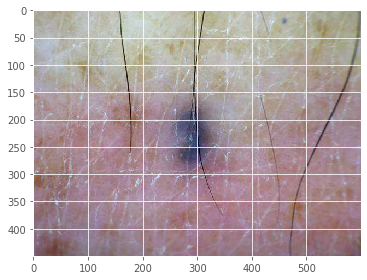

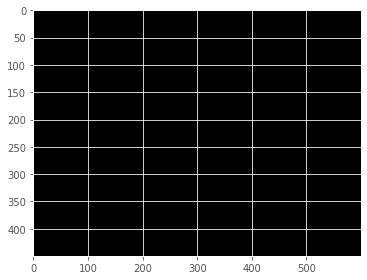

ISIC_0025865
1/1 [==============================] - 0s 5ms/sample


202
430
190
348
ISIC_0024935
1/1 [==============================] - 0s 5ms/sample


188
257
274
344
ISIC_0029091
1/1 [==============================] - 0s 5ms/sample


128
307
209
376
ISIC_0032026
1/1 [==============================] - 0s 5ms/sample


171
264
255
344
ISIC_0026889
1/1 [==============================] - 0s 5ms/sample


111
335
185
404
ISIC_0030963
1/1 [==============================] - 0s 5ms/sample


139
289
166
390
ISIC_0030336
1/1 [==============================] - 0s 5ms/sample


199
261
260
339
ISIC_0027970
1/1 [==============================] - 0s 5ms/sample


107
296
157
414
ISIC_0027140
1/1 [==============================] - 0s 5ms/sample


128
271
223
372
ISIC_0031322
1/1 [==============================] - 0s 5ms/sample


107
359
134
451
ISIC_0031985
1/1 [==============================] - 0s 5ms/sample


163
257
246
362
ISIC_0030890
1/1 [==============================] - 0s 6ms/sample


65
391
35
597
ISIC_0030404
1/1 [==============================] - 0s 5ms/sample


37
412
59
498
ISIC_0027311
1/1 [==============================] - 0s 5ms/sample


142
289
218
390
ISIC_0031896
1/1 [==============================] - 0s 5ms/sample


51
395
82
498
ISIC_0025355
1/1 [==============================] - 0s 6ms/sample


163
293
73
358
ISIC_0032388
1/1 [==============================] - 0s 7ms/sample


47
373
124
428
ISIC_0031973
1/1 [==============================] - 0s 5ms/sample


37
405
16
587
ISIC_0025956
1/1 [==============================] - 0s 4ms/sample


54
405
195
423
ISIC_0027607
1/1 [==============================] - 0s 6ms/sample
100
387
152
597
1/1 [==============================] - 0s 4ms/sample


156
293
171
414
ISIC_0025473
1/1 [==============================] - 0s 5ms/sample


149
271
101
498
ISIC_0025670
1/1 [==============================] - 0s 4ms/sample


181
264
237
372
ISIC_0025898
1/1 [==============================] - 0s 5ms/sample


23
423
115
461
ISIC_0029786
1/1 [==============================] - 0s 5ms/sample


146
317
227
376
ISIC_0027642
1/1 [==============================] - 0s 5ms/sample


132
296
171
419
ISIC_0024540
1/1 [==============================] - 0s 5ms/sample


174
293
213
381
ISIC_0027948
1/1 [==============================] - 0s 5ms/sample


79
377
138
475
ISIC_0032008
1/1 [==============================] - 0s 5ms/sample


128
271
213
395
ISIC_0031317
1/1 [==============================] - 0s 5ms/sample


142
328
152
372
ISIC_0024734
1/1 [==============================] - 0s 5ms/sample


171
447
21
344
ISIC_0027012
1/1 [==============================] - 0s 5ms/sample
93
359
171


414
ISIC_0029592
1/1 [==============================] - 0s 5ms/sample


132
307
232
390
ISIC_0026037
1/1 [==============================] - 0s 5ms/sample


132
310
213
390
ISIC_0025062
1/1 [==============================] - 0s 5ms/sample


90
314
199
362
ISIC_0030299
1/1 [==============================] - 0s 5ms/sample


69
377
82
564
ISIC_0028866
1/1 [==============================] - 0s 4ms/sample


76
331
115
465
ISIC_0025253
1/1 [==============================] - 0s 4ms/sample


23
405
54
597
ISIC_0027961
1/1 [==============================] - 0s 5ms/sample


104
286
241
423
ISIC_0026749
1/1 [==============================] - 0s 5ms/sample


76
359
138
442
ISIC_0029895
1/1 [==============================] - 0s 5ms/sample


83
402
120
479
ISIC_0030059
1/1 [==============================] - 0s 4ms/sample


76
366
35
578
ISIC_0028658
1/1 [==============================] - 0s 4ms/sample


83
352
190
381
ISIC_0032020
1/1 [==============================] - 0s 5ms/sample
9
430
138
433


ISIC_0024745
1/1 [==============================] - 0s 5ms/sample


93
363
166
390
ISIC_0026190
1/1 [==============================] - 0s 5ms/sample


156
275
270
376
ISIC_0025881
1/1 [==============================] - 0s 5ms/sample


114
338
124
489
ISIC_0029970
1/1 [==============================] - 0s 5ms/sample


58
395
16
597
ISIC_0025101
1/1 [==============================] - 0s 4ms/sample
139
352
209
367
1/1 [==============================] - 0s 5ms/sample


40
440
129
442
ISIC_0028632
1/1 [==============================] - 0s 5ms/sample


2
447
82
437
ISIC_0029537
1/1 [==============================] - 0s 5ms/sample


93
331
213
404
ISIC_0031668
1/1 [==============================] - 0s 10ms/sample


135
275
255
372
ISIC_0027431
4602
4602
0


In [0]:
gc.disable()
counter=0
x=0
y=0
m ="/content/drive/My Drive/Colab Notebooks/u_net-architecture-weights-colorcons.h5"
for filename in glob.glob("/content/drive/My Drive/Color_Constancy_skin_cancer/nv/*.jpg"): #assuming gif    
    path = filename.split("/")
    name = path[6]  
    parts=name.split(".")
    ids=parts[0]                          
    img=imread(filename)
    img1 = resize(img, (128, 128), mode='constant', preserve_range=True)
    img3 = crop_function(img,m)
    if counter < int(nv_num*0.8):
      #train
      if ids in train:
        continue
      else:
        imsave("/content/drive/My Drive/color_cons_skin_cancer_crop/nv/train/"+ids+".jpg",img3)
        x=x+1
        print(ids)
    else:
      #validation
      if ids in validate:
        continue
      else:
        imsave("/content/drive/My Drive/color_cons_skin_cancer_crop/nv/validation/"+ids+".jpg",img3)
        y=y+1
        print(ids)
    counter=counter+1
gc.enable() 
print(counter)  
print(x)
print(y)

In [0]:
gc.disable()
counter=0
x=0
y=0
m ="/content/drive/My Drive/Colab Notebooks/u_net-architecture-weights-colorcons.h5"
for filename in glob.glob("/content/drive/My Drive/Color_Constancy_skin_cancer/vasc/*.jpg"): #assuming gif    
    path = filename.split("/")
    name = path[6]  
    parts=name.split(".")
    ids=parts[0]                          
    img=imread(filename)
    img1 = resize(img, (128, 128), mode='constant', preserve_range=True)
    img3 = crop_function(img,m)
    if counter < int(vasc_num*0.8):#train
      imsave("/content/drive/My Drive/color_cons_skin_cancer_crop/vasc/train/"+ids+".jpg",img3)
      x=x+1
    else:#validation
      imsave("/content/drive/My Drive/color_cons_skin_cancer_crop/vasc/validation/"+ids+".jpg",img3)
      y=y+1
    counter=counter+1
gc.enable() 
print(counter)  
print(x)
print(y)

1/1 [==============================] - 0s 5ms/sample


79
328
176
414
1/1 [==============================] - 0s 4ms/sample


142
286
232
372
1/1 [==============================] - 0s 5ms/sample


51
419
49
447
1/1 [==============================] - 0s 5ms/sample


128
352
162
386
1/1 [==============================] - 0s 5ms/sample


139
275
213
404
1/1 [==============================] - 0s 5ms/sample


185
264
232
334
1/1 [==============================] - 0s 5ms/sample


114
293
204
400
1/1 [==============================] - 0s 5ms/sample


76
303
204
362
1/1 [==============================] - 0s 5ms/sample


44
345
40
465
1/1 [==============================] - 0s 5ms/sample
139
363
148
461


1/1 [==============================] - 0s 5ms/sample


90
335
63
461
1/1 [==============================] - 0s 5ms/sample


160
303
171
414
1/1 [==============================] - 0s 5ms/sample


149
289
237
367
1/1 [==============================] - 0s 5ms/sample


132
331
195
395
1/1 [==============================] - 0s 5ms/sample


149
314
204
353
1/1 [==============================] - 0s 5ms/sample


69
370
157
423
1/1 [==============================] - 0s 5ms/sample


149
286
232
386
1/1 [==============================] - 0s 5ms/sample


72
352
166
479
1/1 [==============================] - 0s 5ms/sample


114
303
227
494
1/1 [==============================] - 0s 5ms/sample


195
293
246
390
1/1 [==============================] - 0s 5ms/sample


167
261
241
348
1/1 [==============================] - 0s 5ms/sample
111
387
157
442


1/1 [==============================] - 0s 5ms/sample


132
293
209
372
1/1 [==============================] - 0s 5ms/sample


163
271
237
362
1/1 [==============================] - 0s 4ms/sample


146
271
255
381
1/1 [==============================] - 0s 4ms/sample


100
331
162
479
1/1 [==============================] - 0s 4ms/sample


199
286
255
339
1/1 [==============================] - 0s 4ms/sample


104
321
143
395
1/1 [==============================] - 0s 4ms/sample


135
349
148
423
1/1 [==============================] - 0s 4ms/sample


160
278
223
362
1/1 [==============================] - 0s 4ms/sample


76
296
152
395
1/1 [==============================] - 0s 4ms/sample


2
307
91
390
1/1 [==============================] - 0s 4ms/sample


2
324
26
419
1/1 [==============================] - 0s 4ms/sample
16
387
96
461


1/1 [==============================] - 0s 4ms/sample


2
426
2
564
1/1 [==============================] - 0s 4ms/sample


65
416
110
484
1/1 [==============================] - 0s 4ms/sample


2
447
91
554
1/1 [==============================] - 0s 4ms/sample


54
437
35
597
1/1 [==============================] - 0s 4ms/sample


128
363
162
437
1/1 [==============================] - 0s 5ms/sample


33
447
30
597
1/1 [==============================] - 0s 4ms/sample


5
447
138
470
1/1 [==============================] - 0s 5ms/sample


79
395
237
470
1/1 [==============================] - 0s 5ms/sample


114
345
213
386
1/1 [==============================] - 0s 4ms/sample
79
423
73
433


1/1 [==============================] - 0s 4ms/sample


33
447
59
494
1/1 [==============================] - 0s 4ms/sample


132
359
157
395
1/1 [==============================] - 0s 4ms/sample


125
261
241
447
1/1 [==============================] - 0s 5ms/sample


76
278
213
526
1/1 [==============================] - 0s 5ms/sample


153
254
218
362
1/1 [==============================] - 0s 4ms/sample


47
349
124
498
1/1 [==============================] - 0s 4ms/sample


19
447
16
554
1/1 [==============================] - 0s 4ms/sample


125
356
138
414
1/1 [==============================] - 0s 5ms/sample


83
395
101
465
1/1 [==============================] - 0s 5ms/sample


19
423
2
550
1/1 [==============================] - 0s 4ms/sample


54
380
45
484
1/1 [==============================] - 0s 4ms/sample


142
289
190
372
1/1 [==============================] - 0s 4ms/sample


44
402
101
494
1/1 [==============================] - 0s 4ms/sample


2
433
2
597
1/1 [==============================] - 0s 4ms/sample


23
444
2
512
1/1 [==============================] - 0s 4ms/sample


2
419
218
489
1/1 [==============================] - 0s 4ms/sample


93
331
199
442
1/1 [==============================] - 0s 5ms/sample


16
447
2
479
1/1 [==============================] - 0s 5ms/sample


93
338
124
419
1/1 [==============================] - 0s 5ms/sample


79
331
129
381
1/1 [==============================] - 0s 5ms/sample


2
380
105
545
1/1 [==============================] - 0s 5ms/sample


19
391
35
554
1/1 [==============================] - 0s 5ms/sample


30
314
68
554
1/1 [==============================] - 0s 5ms/sample


26
444
110
550
1/1 [==============================] - 0s 5ms/sample


111
356
54
470
1/1 [==============================] - 0s 5ms/sample


160
271
204
372
1/1 [==============================] - 0s 5ms/sample


118
300
195
390
1/1 [==============================] - 0s 5ms/sample


192
257
270
334
1/1 [==============================] - 0s 4ms/sample


146
275
199
381
1/1 [==============================] - 0s 4ms/sample


93
331
63
419
1/1 [==============================] - 0s 4ms/sample


118
359
148
433
1/1 [==============================] - 0s 4ms/sample


188
282
241
348
1/1 [==============================] - 0s 4ms/sample


181
261
255
353
1/1 [==============================] - 0s 5ms/sample


104
282
176
419
1/1 [==============================] - 0s 5ms/sample


167
293
251
381
1/1 [==============================] - 0s 4ms/sample


100
387
115
442
1/1 [==============================] - 0s 5ms/sample


128
296
195
348
1/1 [==============================] - 0s 4ms/sample


97
328
176
390
1/1 [==============================] - 0s 4ms/sample


146
229
246
329
1/1 [==============================] - 0s 4ms/sample


79
328
152
451
1/1 [==============================] - 0s 4ms/sample


86
373
134
465
1/1 [==============================] - 0s 5ms/sample


33
433
73
484
1/1 [==============================] - 0s 4ms/sample
90
370
115
400


1/1 [==============================] - 0s 4ms/sample


142
314
190
358
1/1 [==============================] - 0s 7ms/sample


213
377
227
386
1/1 [==============================] - 0s 5ms/sample


199
349
204
386
1/1 [==============================] - 0s 5ms/sample


69
303
223
428
1/1 [==============================] - 0s 5ms/sample


206
331
45
175
1/1 [==============================] - 0s 4ms/sample


132
307
176
376
1/1 [==============================] - 0s 4ms/sample


149
384
190
419
1/1 [==============================] - 0s 5ms/sample


255
444
77
269
1/1 [==============================] - 0s 5ms/sample


146
359
265
498
1/1 [==============================] - 0s 6ms/sample


178
349
213
390
1/1 [==============================] - 0s 5ms/sample


118
356
190
442
1/1 [==============================] - 0s 5ms/sample


40
261
166
358
1/1 [==============================] - 0s 5ms/sample


79
380
49
597
1/1 [==============================] - 0s 4ms/sample


163
321
120
283
1/1 [==============================] - 0s 5ms/sample


79
268
185
395
1/1 [==============================] - 0s 5ms/sample


26
187
82
278
1/1 [==============================] - 0s 5ms/sample


139
335
171
423
1/1 [==============================] - 0s 5ms/sample


100
264
157
292
1/1 [==============================] - 0s 5ms/sample


185
345
162
315
1/1 [==============================] - 0s 5ms/sample


195
314
237
358
1/1 [==============================] - 0s 5ms/sample


135
387
2
456
1/1 [==============================] - 0s 4ms/sample


199
328
157
320
1/1 [==============================] - 0s 4ms/sample
47
377
2
517


1/1 [==============================] - 0s 4ms/sample


2
444
45
536
1/1 [==============================] - 0s 4ms/sample


128
363
152
362
1/1 [==============================] - 0s 4ms/sample


223
363
129
259
1/1 [==============================] - 0s 4ms/sample


100
254
246
409
1/1 [==============================] - 0s 4ms/sample


142
363
227
428
1/1 [==============================] - 0s 4ms/sample


174
380
232
437
1/1 [==============================] - 0s 4ms/sample


174
370
171
409
1/1 [==============================] - 0s 4ms/sample


97
257
330
475
1/1 [==============================] - 0s 4ms/sample


16
303
101
451
1/1 [==============================] - 0s 4ms/sample


93
307
213
442
1/1 [==============================] - 0s 4ms/sample


93
293
209
404
1/1 [==============================] - 0s 4ms/sample


16
356
157
367
1/1 [==============================] - 0s 4ms/sample


107
243
255
409
1/1 [==============================] - 0s 4ms/sample


199
300
176
273
1/1 [==============================] - 0s 4ms/sample


188
275
246
334
1/1 [==============================] - 0s 4ms/sample


100
430
124
526
1/1 [==============================] - 0s 4ms/sample


111
402
143
381
1/1 [==============================] - 0s 4ms/sample


132
317
105
250
1/1 [==============================] - 0s 4ms/sample


121
398
213
597
1/1 [==============================] - 0s 4ms/sample


128
324
251
470
1/1 [==============================] - 0s 4ms/sample


121
321
157
334
1/1 [==============================] - 0s 5ms/sample


30
282
91
334
1/1 [==============================] - 0s 5ms/sample


195
338
270
419
1/1 [==============================] - 0s 5ms/sample


104
282
152
465
1/1 [==============================] - 0s 5ms/sample


163
328
134
358
1/1 [==============================] - 0s 5ms/sample


76
247
162
320
1/1 [==============================] - 0s 5ms/sample


167
377
134
339
1/1 [==============================] - 0s 5ms/sample


139
331
87
297
1/1 [==============================] - 0s 5ms/sample


100
264
138
287
1/1 [==============================] - 0s 5ms/sample


146
303
270
428
1/1 [==============================] - 0s 5ms/sample


2
423
54
475
1/1 [==============================] - 0s 4ms/sample


9
395
110
414
142
113
29


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
